In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set_style('whitegrid')
import os
import re
import ast
# we'll need our old function, some of them with a bit modification to extract our codes
from data_extraction_functions import *

os.chdir('/home/anovax/open_data/edrsr_data')

In [41]:
# to update imported file when needed
import data_extraction_functions
import importlib
importlib.reload(data_extraction_functions)

<module 'data_extraction_functions' from '/home/anovax/ml_projects/courts_study/unstructured/data_extraction_functions.py'>

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
texts_1819 = pd.read_csv('texts_1819_all_regions.txt', chunksize=15000, 
                      sep=':custom_separator:', header=None, names=['id', 'text'])

In [4]:
# let's extract first part of texts to see what's inside and apply extraction for a sample first

text_1 = next(texts_1819)
text_1.dropna(inplace=True)
text_1['id'] = text_1.id.astype(int)

In [48]:
# EDRPOU codes consist of 8 digits preceding by a word EDRPOU or just code etc.
# let's check how much them we have

text_1.text.str.contains('код \d{8}').sum()

4003

In [49]:
code_mask = text_1.text.str.contains('ЄДРПОУ')

code_mask.sum()

5196

Sometetimes codes are indicated in the header of the document, but usually we have them in a resolution part of the doc. The last case connected with a positive decisions, where court decide to withdraw funds from the defendant, thus all credentials are listed for that. **This means that much more decisions with codes are positive ones, which may lead us to unbalanced classes in our dataset**.

In [50]:
# and we see that almost all of them are positive cases that withdraw funds from defendant entities

text_1[code_mask].text.str.contains('[Сс]тягнути').sum()

4333

In [51]:
# only 863 are potential negative candidtaes

withdraw_mask = text_1[code_mask].text.str.contains('[Сс]тягнути')

neg_candidates = text_1[code_mask][~withdraw_mask]

neg_candidates.text.count()

863

In [5]:
# also we need to load rest of the features

features = pd.read_csv('features_2.txt', sep=';', 
                       names=['id', 'outcome', 'outcomeFull', 'length', 'n_judges', 'judges_names', 'sex'])

features.dropna(subset=['id'], inplace=True)
features = features.reset_index().drop('index', axis=1)
features.dropna(subset=['outcomeFull'], inplace=True)

decisions = pd.read_csv('decisions_1819.csv')

courts = pd.read_csv('2018/courts.csv', sep='\t')
instances = pd.read_csv('2018/instances.csv', sep='\t')

In [6]:
# merging our data

merged = pd.merge(features, text_1, how='inner')
court_df = pd.merge(decisions, merged, left_on='doc_id', right_on='id').drop('doc_id', axis=1)

mapper = {'name_x': 'court_name', 'name_y': 'instance'}
instances_df = pd.merge(courts, instances, on='instance_code').set_index('court_code').loc[court_df.court_code.unique()][['name_x', 'name_y']].reset_index().rename(mapper, axis=1)

df = pd.merge(instances_df, court_df,).drop('court_name', axis=1)

## Trying to get codes from a resolution part

In [7]:
edrpou_mask = df.text.str.contains('ЄДРПОУ')
id_code_mask = df.text.str.contains('код\s?\d{8}')

# overall almost 10k

print(df[edrpou_mask].shape)
print(df[id_code_mask].shape)

(5194, 15)
(4005, 15)


In [95]:
# sometimes there is different naming conventions for codes in one piece of text, for example

print('2. Стягнути з Управління соціального захисту населення Перечинської районної державної адміністрації (89200, Закарпатська обл., м. Перечин, вул. Ужанська, 19, код 03192862) на користь Публічного акціонерного товариства "Укртелеком", м.  Київ в особі Закарпатської філії Публічного акціонерного товариства "Укртелеком" (платіжні реквізити код ЄДРПОУ 21560766)')

2. Стягнути з Управління соціального захисту населення Перечинської районної державної адміністрації (89200, Закарпатська обл., м. Перечин, вул. Ужанська, 19, код 03192862) на користь Публічного акціонерного товариства "Укртелеком", м.  Київ в особі Закарпатської філії Публічного акціонерного товариства "Укртелеком" (платіжні реквізити код ЄДРПОУ 21560766)


In [8]:
# trying to create overall mask for codes

code_mask = df.text.str.contains('код\s?\-?\:?\s?\d{8}|ЄДРПОУ\s?\-?\:?\s?\d{8}')

In [76]:
df[code_mask].shape

(8629, 15)

In [77]:
# checking if it's working

sample_string = '2. Стягнути з Управління соціального захисту населення Перечинської районної державної адміністрації (89200, Закарпатська обл., м. Перечин, вул. Ужанська, 19, код 03192862) на користь Публічного акціонерного товариства "Укртелеком", м.  Київ в особі Закарпатської філії Публічного акціонерного товариства "Укртелеком" (платіжні реквізити код ЄДРПОУ 21560766)'

print(sample_string, '\n')

re.search(r'[Сс]тягнути.+(код|ЄДРПОУ)\:?\s?(\d{8})\s?\)?\s?на\s?користь.+(код|ЄДРПОУ)\:?\s?(\d{8})', 
                              sample_string).group(2, 4)

2. Стягнути з Управління соціального захисту населення Перечинської районної державної адміністрації (89200, Закарпатська обл., м. Перечин, вул. Ужанська, 19, код 03192862) на користь Публічного акціонерного товариства "Укртелеком", м.  Київ в особі Закарпатської філії Публічного акціонерного товариства "Укртелеком" (платіжні реквізити код ЄДРПОУ 21560766) 



('03192862', '21560766')

In [3]:
def get_code(row):
    """Function to get EDRPOU codes from a resolutin part of a decision"""
    
    try:
        parties_codes = re.search(r'[Сс]тягнути.+(код|ЄДРПОУ)\s?\-?\:?\s?(\d{8}).+на\s?користь.+(код|ЄДРПОУ)\s?\-?\:?\s?(\d{8})', 
                              row).group(2, 4)
        return parties_codes
    
    except AttributeError:
        return None

In [10]:
all_codes = df[code_mask].text.apply(get_code)

all_codes.head()

0    (35611593, 31538866)
1    (31338328, 00131529)
2    (31962917, 22111310)
3                    None
5    (31477620, 22079373)
Name: text, dtype: object

In [11]:
# NaNs can be cases when one party is a person (FOP) and second - company with code found or just one of EDRPOU hided
# or code indicated not in resolution, but in the header which we are going to handle in the next section

all_codes.isnull().sum()

2482

In [82]:
all_codes.notnull().sum()

6147

In [12]:
df_codes = df[code_mask].copy()

# now applying all at once
df_codes['codes_res'] = df_codes.text.apply(get_code)
df_codes.dropna(subset=['codes_res'], inplace=True)

df_codes.shape

(6147, 16)

## Extract parties from header if match EDRPOU

In [13]:
code_mask = df.text.str.contains('ЄДРПОУ|код\s?\-?\:?\s?\d{8}')

codes_header = df[code_mask].copy()

# applying our imported old function to extract parties
codes_header['parties'] = codes_header.apply(get_parties, axis=1)
codes_header.dropna(subset=['parties'], inplace=True)

In [14]:
# cleaning parties and extracting EDRPOU from them with modified function

codes_header['cleaned'] = codes_header.parties.apply(cleaning_parties_edrpou)
codes_header.dropna(subset=['cleaned'], inplace=True)

# double-check if all of the extracted are codes
codes_header['cleaned'] = codes_header.cleaned.apply(lambda x: tuple(x) 
                                                     if len([i for i in x if len(i) == 8]) == 2 else None)
codes_header.dropna(subset=['cleaned'], inplace=True)

# only 416 entries
codes_header.shape

(529, 17)

## Merging codes from header and resolution parts

In [15]:
# reverse order of parties, because in resolution part first goes defendant and then claimant

df_codes['cleaned'] = df_codes.codes_res.apply(lambda x: (x[1], x[0]))

In [17]:
# almost all header values repeated in resolution

codes_header.id.isin(df_codes['id']).sum()

416

In [18]:
# only 113 out of 529 are unique and supposed to be refusal decisions

(~codes_header.id.isin(df_codes['id'])).sum()

113

In [20]:
unique_codes = codes_header[~codes_header.id.isin(df_codes['id'])]

unique_codes.shape

(113, 17)

In [21]:
df_codes.append(unique_codes).shape

(6260, 18)

In [4]:
# function to apply all the above procedure to entire dataset iteratively

def get_codes_from_chunks(generator):

    decisions = pd.read_csv('decisions_1819.csv')

    courts = pd.read_csv('2018/courts.csv', sep='\t')
    instances = pd.read_csv('2018/instances.csv', sep='\t')
    
    codes_df_list = []
    
    
    for chunk in generator:
        
        chunk.dropna(inplace=True)
        chunk['id'] = chunk.id.astype(int)
        

        court_df = pd.merge(decisions, chunk, left_on='doc_id', right_on='id').drop('doc_id', axis=1)

        mapper = {'name_x': 'court_name', 'name_y': 'instance'}
        instances_df = pd.merge(courts, instances, on='instance_code').set_index('court_code').loc[court_df.court_code.unique()][['name_x', 'name_y']].reset_index().rename(mapper, axis=1)

        df = pd.merge(instances_df, court_df,).drop('court_name', axis=1)
        
        del chunk
        
        # extraction: RESOLUTION part
        code_mask = df.text.str.contains('код\s?\-?\:?\s?\d{8}|ЄДРПОУ\s?\-?\:?\s?\d{8}')
        
        all_codes = df[code_mask].text.apply(get_code)
        
        df_codes = df[code_mask].copy()

        df_codes['codes_res'] = df_codes.text.apply(get_code)
        del df_codes['text']
        
        df_codes.dropna(subset=['codes_res'], inplace=True)
        
        # extraction: HEADER part
        code_mask = df.text.str.contains('ЄДРПОУ|код\s?\-?\:?\s?\d{8}')
        codes_header = df[code_mask].copy()
        del df
        
        codes_header['parties'] = codes_header.apply(get_parties, axis=1)
        codes_header.dropna(subset=['parties'], inplace=True)
        
        codes_header['cleaned'] = codes_header.parties.apply(cleaning_parties_edrpou)
        codes_header.dropna(subset=['cleaned'], inplace=True)

        codes_header['cleaned'] = codes_header.cleaned.apply(lambda x: tuple(x) 
                                                             if len([i for i in x if len(i) == 8]) == 2 else None)
        codes_header.dropna(subset=['cleaned'], inplace=True)

        codes_header.drop(codes_header[codes_header.cleaned.apply(len) != 2].index, inplace=True)
        
        
        # merging part
        df_codes['cleaned'] = df_codes.codes_res.apply(lambda x: (x[1], x[0]))
        del df_codes['codes_res']
        
        unique_codes = codes_header[~codes_header.id.isin(df_codes['id'])]
        
        concatenated = df_codes[['id', 'cleaned']].append(unique_codes[['id', 'cleaned']])
        
        codes_df_list.append(concatenated)
        
        del df_codes
        del unique_codes
        
    return codes_df_list

In [5]:
# reloading the dataset

texts_1819 = pd.read_csv('texts_1819_all_regions.txt', chunksize=15000, 
                      sep=':custom_separator:', header=None, names=['id', 'text'])

In [6]:
# applying function

codes_df_list = get_codes_from_chunks(texts_1819)

In [7]:
# concatenating the result

all_codes_df = pd.concat(codes_df_list)

all_codes_df.shape

(31337, 2)

In [9]:
# saving to csv

all_codes_df.to_csv('all_codes_df_v2.csv', index=False)

# Getting companies names

In [10]:
unique_codes = extract_parties(all_codes_df.cleaned)

unique_codes.shape

(21726,)

In [12]:
df_to_append = iterate_xml_edrpou(unique_codes)

1000
Matched:  15
                                                  NAME    EDRPOU  \
25   КОМУНАЛЬНЕ ПІДПРИЄМСТВО "ШЛЯХОВО-ЕКСПЛУАТАЦІЙН...  05446166   
71   ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "СКАЙК...  19040769   
105                ФЕРМЕРСЬКЕ ГОСПОДАРСТВО "ЕДЕЛЬВЕЙС"  21373627   
315  ГРОМАДСЬКА ОРГАНІЗАЦІЯ "СОЮЗ ВЕТЕРАНІВ ВІЙСЬК ...  23407448   
329  СХІДНЕ ТЕРИТОРІАЛЬНЕ КВАРТИРНО-ЕКСПЛУАТАЦІЙНЕ ...  26614946   
354       РОЗДІЛЬНЯНСЬКА РАЙОННА РАДА ОДЕСЬКОЇ ОБЛАСТІ  25033638   
406                             СМІЛЯНСЬКА МІСЬКА РАДА  25874705   
465        ПРИВАТНЕ ПІДПРИЄМСТВО "СТРОЙИНВЕСТ-ПАРТНЕР"  32940627   
478  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "АБРИС...  31714550   
532   ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ІНЛАЙН"  30722199   
540                      ПРИВАТНЕ ПІДПРИЄМСТВО "КОЛБІ"  30442251   
547  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "УКРХА...  30479810   
595  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ХІММА...  39875041   
687  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІ

959  33.14 Ремонт і технічне обслуговування електри...  
6000
Matched:  53
                                                  NAME    EDRPOU  \
15      ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ЯВІР"  32449945   
78                     ПРИВАТНЕ ПІДПРИЄМСТВО "СІАГРУС"  31000849   
97                    ПРИВАТНЕ ПІДПРИЄМСТВО "ОПТ ПЛЮС"  31488040   
284  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ПЛАЗМ...  41622807   
707  КОМУНАЛЬНЕ ПІДПРИЄМСТВО "ЖИТЛОВО-ЕКСПЛУАТАЦІЙН...  26385486   
760                         КРЕДИТНА СПІЛКА "БУКОВИНА"  25811231   
791        СЕЛЯНСЬКЕ (ФЕРМЕРСЬКЕ) ГОСПОДАРСТВО "СТАРТ"  31853455   
884  ПРИВАТНЕ ПІДПРИЄМСТВО "ТОРГОВО-УНІВЕРСАЛЬНА ФІ...  30362449   
941  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "БУД-А...  39392178   

                   STAN                                            ADDRESS  \
15        зареєстровано  33013, Рівненська обл., місто Рівне, ПРОСПЕКТ ...   
78        зареєстровано  35600, Рівненська обл., місто Дубно, ВУЛИЦЯ С....   
97        

9000
Matched:  84
                                                  NAME    EDRPOU  \
251  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "КОСАК...  35960960   
288                  ПРИВАТНЕ ПІДПРИЄМСТВО "НП ЕНЕРГО"  34079103   
423  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ГАСТЕ...  39756446   
437  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ДІЄВА...  33789984   
527  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "АГРОТ...  41124632   
565  ПІДПРИЄМСТВО "РЕДАКЦІЯ ГАЗЕТИ "В ІМ'Я ЖИТТЯ" Х...  31151036   
828  НОВОГУЙВИНСЬКЕ ВИРОБНИЧЕ ЖИТЛОВЕ РЕМОНТНО-ЕКСП...  30273396   
836  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ТД"УК...  33594105   
920  ПРИВАТНЕ ВИРОБНИЧО-КОМЕРЦІЙНЕ ПІДПРИЄМСТВО "ТЕ...  30991890   
958     ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ЕЛБИ"  38473994   
960  ОБ'ЄДНАННЯ СПІВВЛАСНИКІВ БАГАТОКВАРТИРНОГО БУД...  40563327   

              STAN                                            ADDRESS  \
251  зареєстровано  04071, м.Київ, Подільський район, ВУЛИЦЯ ВЕРХН...   
288  зареєстровано 

Matched:  125
                                                  NAME    EDRPOU  \
2    ОБ'ЄДНАННЯ СПІВВЛАСНИКІВ БАГАТОКВАРТИРНОГО БУД...  39982658   
533                       ДЕРЖАВНЕ ПІДПРИЄМСТВО  "ТВК"  24971375   
582  ГОРІШНЬОПЛАВНІВСЬКА МІСЬКА РАДА ПОЛТАВСЬКОЇ ОБ...  24388291   
635  ГРОМАДСЬКА ОРГАНІЗАЦІЯ ЦЕНТР СОЦІАЛЬНОЇ ДОПОМО...  25699969   
712  ПРИВАТНЕ АКЦІОНЕРНЕ ТОВАРИСТВО "ЧЕРКАСЬКЕ ХІМВ...  00204033   
716  ДНІПРОПЕТРОВСЬКЕ ОБЛАСНЕ ТЕРИТОРІАЛЬНЕ ВІДДІЛЕ...  20306037   
786                ПРИВАТНЕ ПІДПРИЄМСТВО "СФЕРА-ПЛАСТ"  35492967   

              STAN                                            ADDRESS  \
2    зареєстровано  39617, Полтавська обл., місто Кременчук, Автоз...   
533  зареєстровано  67806, Одеська обл., Овідіопольський район, се...   
582  зареєстровано  39800, Полтавська обл., місто Горішні Плавні, ...   
635  зареєстровано  03146, м.Київ, Солом'янський район, ВУЛИЦЯ ПРО...   
712  зареєстровано  18013, Черкаська обл., місто Черкаси, Придніпр...   
716

20000
Matched:  174
                                                  NAME    EDRPOU  \
111  КУЗНЕЦІВСЬКА ЗАГАЛЬНООСВІТНЯ ШКОЛА І-ІІІ СТУПЕ...  23043687   
133  ПРИВАТНЕ ПІДПРИЄМСТВО "РЕМОНТНО-БУДІВЕЛЬНА ФІРМА"  24340154   
297  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "НІКОЛ...  40817061   
304  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ГЛОБА...  39994244   
340  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ДК ДН...  41221083   
525  ДЕРЖАВНЕ ПІДПРИЄМСТВО "МИКОЛАЇВСЬКИЙ АВІАРЕМОН...  09794409   
541  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "БІЗНЕ...  40400679   
866  ГОЛОВНЕ УПРАВЛІННЯ ДЕРЖАВНОЇ МІГРАЦІЙНОЇ СЛУЖБ...  37806243   

              STAN                                            ADDRESS  \
111  зареєстровано  56418, Миколаївська обл., Доманівський район, ...   
133  зареєстровано  61003, Харківська обл., місто Харків, Київськи...   
297  зареєстровано  73000, Херсонська обл., місто Херсон, Суворовс...   
304  зареєстровано  46008, Тернопільська обл., місто Тернопіль, ВУ...   
34

26000
Matched:  209
                                                  NAME    EDRPOU  \
176  ЛИМАНСЬКА РАЙОННА ДЕРЖАВНА АДМІНІСТРАЦІЯ ОДЕСЬ...  04057155   
439      ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "БЛС"  35086034   
578                              ПРИВАТНА ФІРМА "РОМБ"  25173902   
673  ДЕПАРТАМЕНТ МІСТОБУДУВАННЯ, АРХІТЕКТУРИ ТА КУЛ...  40216470   
804  СЛУЖБА АВТОМОБІЛЬНИХ ДОРІГ У ЧЕРНІВЕЦЬКІЙ ОБЛАСТІ  22843868   
952  ШЕВЧЕНКІВСЬКИЙ ВІДДІЛ ДЕРЖАВНОЇ ВИКОНАВЧОЇ СЛУ...  35009321   

                   STAN                                            ADDRESS  \
176       зареєстровано  67500, Одеська обл., Лиманський район, селище ...   
439       зареєстровано  04050, м.Київ, Шевченківський район, ВУЛ.ИЦЯ М...   
578       зареєстровано  61002, Харківська обл., місто Харків, Київськи...   
673  в стані припинення  76018, Івано-Франківська обл., місто Івано-Фра...   
804       зареєстровано  58018, Чернівецька обл., місто Чернівці, Першо...   
952       зареєстровано  79007, Льв

31000
Matched:  264
                                                  NAME    EDRPOU  \
76                      ПРИВАТНЕ ПІДПРИЄМСТВО "РЯБІНА"  20593210   
218  ВИРОБНИЧО-КОМЕРЦІЙНА ФІРМА "ПРОЕКТГІДРОБУД" (У...  20943531   
235  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ІМПЕР...  38677154   
284  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ЕНЕРГ...  33742752   
332  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ЮГЕВР...  36622779   
371  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ЮЖНАЯ...  38622702   
391  ОБ'ЄДНАННЯ СПІВВЛАСНИКІВ БАГАТОКВАРТИРНОГО БУД...  41436931   
579  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ НАУКОВ...  21960856   
716  ПІДПРИЄМСТВО "УПРАВЛІННЯ ВИРОБНИЧО-ТЕХНОЛОГІЧН...  03588614   
720            СІЛЬСЬКОГОСПОДАРСЬКИЙ КООПЕРАТИВ "ВОЛЯ"  03728630   
787  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ТОРГО...  40883705   
845  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ХАВЕС...  31115663   
920  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ТРІНІТА"  25419131   
986  ТОВАРИСТВО З ОБМЕЖЕНОЮ 

34000
Matched:  291
                                                  NAME    EDRPOU  \
147  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ІМІДЖ...  33694243   
149  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ТЕЛЕР...  23729809   
194  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "АРГО-...  32249009   
301  ПЕРВОМАЙСЬКЕ КОМУНАЛЬНЕ ВИРОБНИЧЕ УПРАВЛІННЯ В...  22714272   
327  ПІДПРИЄМСТВО З ІНОЗЕМНОЮ ІНВЕСТИЦІЄЮ У ФОРМІ Т...  20005075   
439  СЕКТОР ОСВІТИ ВАРВИНСЬКОЇ РАЙОННОЇ ДЕРЖАВНОЇ А...  02147397   
543  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "АГРЕЙ...  38052610   
585   ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "БЄЗЕРА"  38523086   

              STAN                                            ADDRESS  \
147  зареєстровано  04201, м.Київ, Оболонський район,  ВУЛ. КОНДРА...   
149  зареєстровано  04080, м.Київ, Подільський район, ВУЛИЦЯ КИРИЛ...   
194  зареєстровано  01024, м.Київ, Печерський район, ПРОВУЛОК ВИНО...   
301  зареєстровано  64102, Харківська обл., місто Первомайський, В...   
32

39000
Matched:  361
                                                  NAME    EDRPOU  \
100  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ВИРОБ...  35316486   
129  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "АТЛАН...  40289732   
145  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "АЛЬФА...  41069294   
197  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ДДК Т...  40410708   
606  ПРИВАТНЕ АКЦІОНЕРНЕ ТОВАРИСТВО "ЛІЗИНГ ІНФОРМА...  33149830   
748  ПРИВАТНЕ АКЦІОНЕРНЕ ТОВАРИСТВО "ВИДОБУВНА КОМП...  33152471   
847  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "СОФІЯ...  34055691   
848  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ТОРГО...  34055728   
869          ПРИВАТНЕ ПІДПРИЄМСТВО "ТОРГОВИЙ ЦЕНТР -Д"  24177281   

              STAN                                            ADDRESS  \
100  зареєстровано  02090, м.Київ, Дніпровський район, ВУЛ. ВОЛОДИ...   
129  зареєстровано  02260, м.Київ, Деснянський район, ВУЛИЦЯ МАГНІ...   
145  зареєстровано  51931, Дніпропетровська обл., місто Кам’янське...   
197  за

42000
Matched:  393
                                                  NAME    EDRPOU  \
467  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "УНІРЕ...  36442090   
481  ОБ'ЄДНАННЯ СПІВВЛАСНИКІВ БАГАТОКВАРТИРНОГО БУД...  38039673   
493  ВИРОБНИЧО-КОМЕРЦІЙНЕ ПІДПРИЄМСТВО "ЩЕКАВИЦЯ" У...  19015582   
731  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ВОЛИН...  13344285   
732  ПРИВАТНЕ АКЦІОНЕРНЕ ТОВАРИСТВО "ВОЛИНЬАГРОРЕММАШ"  13344285   
850  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "НАУКО...  30987251   
888  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ФІРМА...  22876483   

              STAN                                            ADDRESS  \
467  зареєстровано  52323, Дніпропетровська обл., Криничанський ра...   
481  зареєстровано  03150, м.Київ, Голосіївський район, ВУЛИЦЯ АНТ...   
493  зареєстровано  04080, м.Київ, Подільський район, ВУЛИЦЯ КОСТЯ...   
731  зареєстровано  43010, Волинська обл., місто Луцьк, ВУЛИЦЯ ДУБ...   
732      припинено  43010, Волинська обл., місто Луцьк, ВУЛ.ДУБНІВ... 

45000
Matched:  432
                                                  NAME    EDRPOU  \
13   ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ТОРГО...  21809562   
14        ПРИВАТНЕ МАЛЕ ПІДПРИЄМСТВО ФІРМА "ЕДЕЛЬВЕЙС"  21809562   
29    СЕЛЯНСЬКЕ ФЕРМЕРСЬКЕ ГОСПОДАРСТВО  " РОКСОЛАНА "  23687258   
143  КІРОВОГРАДСЬКА ОБЛАСНА ГРОМАДСЬКА ОРГАНІЗАЦІЯ ...  35561930   
153  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ЕЛЕКТ...  31386990   
364  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ГІЛФО...  39542115   
389  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "КОМІН...  33564395   
398  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "СУМИГ...  39586236   
473  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ЮНАЛЕКС"  39539893   
492  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ІНТЕР...  21682481   
509  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "СВЕТК...  39552715   
574   ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "АЙКВЕН"  40582093   
615   ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ЗДРАВО"  34603398   
710  ТОВАРИСТВО З ОБМЕЖЕНОЮ 

981  46.72 Оптова торгівля металами та металевими р...  
48000
Matched:  469
                                                  NAME    EDRPOU  \
26                 ДОЧІРНЄ ПІДПРИЄМСТВО "РІТЕЙЛ ЦЕНТР"  38734018   
155  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "БУКЛЕ...  40748323   
175          ВИКОНАВЧИЙ КОМІТЕТ ІЗЮМСЬКОЇ МІСЬКОЇ РАДИ  04058806   
349  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "МАЗРЕ...  38759797   
390  ОПОРНИЙ ЗАКЛАД "КАЛАЙДИНЦІВСЬКА ЗАГАЛЬНООСВІТН...  23547244   
392  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ІНФО ...  37033890   
453  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "АРФ К...  35926343   
598  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ФАРМА...  32371015   
638  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "РЕСУР...  41085447   
737                             САРНЕНСЬКА МІСЬКА РАДА  04057770   
739                        ВОЛОДИМИРЕЦЬКА РАЙОННА РАДА  04057818   
853  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ФАРМА...  41627653   
872   ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛ

51000
Matched:  497
                                                  NAME    EDRPOU  \
48   КОМУНАЛЬНЕ ПІДПРИЄМСТВО ФІРМА "ТЕРНОПІЛЬБУДІНВ...  14055223   
77   ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ЕЛЕКТ...  39962542   
184  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "АКВА-...  38468193   
225  УПРАВЛІННЯ ОСВІТИ ХОТИНСЬКОЇ РАЙОННОЇ ДЕРЖАВНО...  39967399   
273   ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ДІКСОН"  24423171   
361  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ГРЕЙН...  39969176   
397  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ НТП "Б...  24084504   
454  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "КОМПА...  38774071   
478  ТОРГОВЕЛЬНА ФІРМА "СПОРТИВНИЙ ОДЯГ" ТОВАРИСТВО...  14065121   
497  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "УКР П...  39915623   
548  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "РЦ РЕ...  40104201   
640  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "АГРОІ...  39922300   
671  ОБ'ЄДНАННЯ ПРОФСПІЛОК, ОРГАНІЗАЦІЙ ПРОФСПІЛОК ...  02670408   
836  ДОЧІРНЄ ПІДПРИЄМСТВО  "

54000
Matched:  530
                                                  NAME    EDRPOU  \
2    ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ТРЕЙД...  38979492   
38    ЖИТЛОВО-БУДІВЕЛЬНИЙ КООПЕРАТИВ "МАШИНОСТРОИТЕЛЬ"  23065717   
71   ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ЮКРЕЙ...  39329834   
184        ЖИТЛОВО-БУДІВЕЛЬНИЙ КООПЕРАТИВ "ЖОВТЕНЬ-13"  23068437   
289  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ХІМІЯ...  38986599   
529  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "СТС-Е...  37878098   
574  СІЛЬСЬКОГОСПОДАРСЬКИЙ ВИРОБНИЧИЙ КООПЕРАТИВ "Б...  03738947   
876  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "СПАРТ...  38376726   
889  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ШАХТА...  37909183   
893     ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "УПТІ"  37910639   
975                              ЛЬВІВСЬКА МИТНИЦЯ ДФС  39420875   

              STAN                                            ADDRESS  \
2    зареєстровано  02100, м.Київ, Дніпровський район, ВУЛИЦЯ  БУД...   
38   зареєстрован

57000
Matched:  561
                                                  NAME    EDRPOU  \
252  КОМУНАЛЬНЕ ПІДПРИЄМСТВО "ОБЛАСНА БАЗА СПЕЦІАЛЬ...  00180611   
253  КОМУНАЛЬНА УСТАНОВА "ОБЛАСНА БАЗА СПЕЦІАЛЬНОГО...  00180611   
335  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "МОНОЛ...  39696508   
407  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ВИРОБ...  14285986   
546  АКЦІОНЕРНЕ ТОВАРИСТВО "ДНІПРОПЕТРОВСЬКИЙ ЗАВОД...  00187375   
694  ПУБЛІЧНЕ АКЦІОНЕРНЕ ТОВАРИСТВО "КРИВОРІЗЬКИЙ З...  00191307   
748  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ФАЛЬО...  33744765   
831  ПУБЛІЧНЕ АКЦІОНЕРНЕ ТОВАРИСТВО "КІРОВОГРАДСЬКЕ...  00191891   
864  ПУБЛІЧНЕ АКЦІОНЕРНЕ ТОВАРИСТВО "ХЕРСОНСЬКИЙ СУ...  14308500   

                   STAN                                            ADDRESS  \
252           припинено  10019, Житомирська обл., місто Житомир, Король...   
253  в стані припинення  10019, Житомирська обл., місто Житомир, Король...   
335       зареєстровано  54000, Миколаївська обл., місто Миколаїв

60000
Matched:  590
                                                  NAME    EDRPOU  \
85   ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ВИРОБ...  33612032   
239  ГРОМАДСЬКА ОРГАНІЗАЦІЯ "КОМІТЕТ ЗАХИСТУ ПРАВ Л...  25959360   
637  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "НИВА-СЛ"  24445422   
773  УПРАВЛІННЯ СОЦІАЛЬНОГО ЗАХИСТУ НАСЕЛЕННЯ БІЛОЗ...  24117729   
777                ПРИВАТНЕ МАЛЕ ПІДПРИЄМСТВО "СКОВОД"  14179178   
785    ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "КАНОН"  24446462   
899  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "УКР-Є...  39318644   
978  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ІНВЕС...  32215839   
994  ПРИВАТНЕ АКЦІОНЕРНЕ ТОВАРИСТВО "АВТОТРАНСПОРТН...  03119581   

                   STAN                                            ADDRESS  \
85        зареєстровано  49019, Дніпропетровська обл., місто Дніпро, Че...   
239       зареєстровано  02140, м.Київ, Дарницький район, ВУЛ. РЕВУЦЬКО...   
637       зареєстровано  50059, Дніпропетровська обл., місто Крив

63000
Matched:  631
                                                  NAME    EDRPOU  \
41   ВІДДІЛ ОСВІТИ, МОЛОДІ ТА СПОРТУ ШИРЯЇВСЬКОЇ РА...  02145323   
112  ДЕПАРТАМЕНТ "ЦЕНТР НАДАННЯ АДМІНІСТРАТИВНИХ ПО...  38527410   
179  ДОЧІРНЄ ПІДПРИЄМСТВО " ПОЛІС-ПРОД " ПІДПРИЄМСТ...  31432291   
374  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "МЕЗОН...  40645844   
427  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "АГРО-...  31880578   
638  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ " ГУТА...  30520292   
668  ЗАКРИТЕ АКЦІОНЕРНЕ ТОВАРИСТВО "ПЕРШИЙ КИЇВСЬКИ...  30530468   
669  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ПЕРШИ...  30530468   
693       СЕЛЯНСЬКЕ (ФЕРМЕРСЬКЕ) ГОСПОДАРСТВО "ЛЕЛЕКИ"  31217196   
696      ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ЮБК"  31217809   
706  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ЦЕНТР...  23939044   
754  УПРАВЛІННЯ СОЦІАЛЬНОГО ЗАХИСТУ НАСЕЛЕННЯ БОРІВ...  25793378   
831  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "МЕДІА...  32872704   
836                  ПРИВАТН

66000
Matched:  664
                                                  NAME    EDRPOU  \
214  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ЦЕНТР...  24226281   
233  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ГРІН ...  36757934   
253  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "КАТЕР...  35431993   
380  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "КОМБІ...  38334859   
396  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ТЕХНО...  38384339   
551  ПУБЛІЧНЕ АКЦІОНЕРНЕ ТОВАРИСТВО "ЄВПАТОРІЙСЬКИЙ...  20663004   
725  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ТОРГО...  33226396   
779  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "КИЇВС...  24541083   
902  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "БУДЛІ...  40474667   
929  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "НАФТО...  39890819   
946  КОМУНАЛЬНЕ КОМЕРЦІЙНЕ ПІДПРИЄМСТВО МАРІУПОЛЬСЬ...  38349197   

              STAN                                            ADDRESS  \
214  зареєстровано  49006, Дніпропетровська обл., місто Дніпро, Кр...   
233  зареєстрован

69000
Matched:  709
                                                  NAME    EDRPOU  \
28   ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "НАУКО...  36604756   
71   ДЕРЖАВНА ЕКОЛОГІЧНА ІНСПЕКЦІЯ У ХАРКІВСЬКІЙ ОБ...  37999518   
79    КОМУНАЛЬНЕ ПІДПРИЄМСТВО "КИЇВСЬКИЙ МЕТРОПОЛІТЕН"  03328913   
117  ПРИВАТНЕ ПІДПРИЄМСТВО ПРИВАТНЕ ПІДПРИЄМСТВО "В...  34864103   
122            ПРИВАТНЕ ПІДПРИЄМСТВО "ПІРАМІДА - АГРО"  34924277   
149             ПРИВАТНЕ АКЦІОНЕРНЕ ТОВАРИСТВО "РУСИН"  03767788   
240  СІЛЬСЬКОГОСПОДАРСЬКЕ ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІ...  03728200   
266  ПРИВАТНЕ ПІДПРИЄМСТВО "ВИРОБНИЧО-ТОРГОВА КОМПА...  23808087   
301  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "РІАЛ-...  36564890   
367  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ЧАРНО...  35508971   
378  ДЕРЖАВНЕ ПІДПРИЄМСТВО "ПІДПРИЄМСТВО ІЗ ЗАБЕЗПЕ...  03482347   
383  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "БОРАН...  39642190   
385            ЧЕРНІГІВСЬКИЙ ОБЛАСНИЙ ЦЕНТР ЗАЙНЯТОСТІ  03491464   
390  ТОВАРИСТВО З ОБМЕЖЕНОЮ 

72000
Matched:  749
                                                  NAME    EDRPOU  \
145  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ВИРОБ...  39871073   
152  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "РЕМПО...  39912753   
256  ПРИВАТНЕ ВИРОБНИЧО-КОМЕРЦІЙНЕ ПІДПРИЄМСТВО ФІР...  22162074   
801  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ЗАВОД...  23251236   
978  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "БАЛЛІ...  41093086   

                                          STAN  \
145                              зареєстровано   
152                              зареєстровано   
256                              зареєстровано   
801  порушено справу про банкрутство (санація)   
978                              зареєстровано   

                                               ADDRESS  \
145  03127, м.Київ, Голосіївський район, ПРОСПЕКТ Г...   
152  40022, Сумська обл., місто Суми, Ковпаківський...   
256  72319, Запорізька обл., місто Мелітополь, ВУЛИ...   
801  43000, Волинська обл., місто Луць

75000
Matched:  793
                                                  NAME    EDRPOU  \
32   ГРОМАДСЬКА ОРГАНІЗАЦІЯ ЛЬВІВСЬКА ОБЛАСНА МОЛОД...  34667980   
37   ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ЗАВОД...  34668888   
157  ПРИВАТНЕ АКЦІОНЕРНЕ ТОВАРИСТВО "СЛОВ'ЯНСЬКІ ШП...  00278876   
184  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ДІМ К...  22332122   
241  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ЕЛЬДО...  41145592   
268  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ТОРГО...  40618763   
309  ВІЙСЬКОВА ЧАСТИНА 2269 НАЦІОНАЛЬНОЇ ГВАРДІЇ УК...  14322859   
310                             ВІЙСЬКОВА ЧАСТИНА 2269  14322859   
462  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "АВАНГ...  21377944   
526  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "МАЙСТ...  40656311   
544  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "УКРСП...  23925736   
583  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ФІНЕК...  38895507   
634   ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "АВІПРО"  37203655   
723  ТОВАРИСТВО З ОБМЕЖЕНОЮ 

78000
Matched:  828
                                                  NAME    EDRPOU  \
60   ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ЗЕРНО...  38234181   
107                             УКРАЇНСЬКА МІСЬКА РАДА  04052991   
218   ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "РЕГІОН"  25096372   
248  ВИРОБНИЧИЙ СІЛЬСЬКОГОСПОДАРСЬКИЙ  КООПЕРАТИВ "...  03788721   
333  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ЛИТПР...  38187996   
504  СПІЛЬНЕ УКРАЇНСЬКО-КІПРСЬКЕ ПІДПРИЄМСТВО "ДОНБ...  25100518   
627  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ТАТНЄ...  38194448   
655  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ " АТЛА...  40150609   
710  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ІМПЕР...  35030380   
728               ЗАПОРІЗЬКИЙ МІСЬКИЙ ЦЕНТР ЗАЙНЯТОСТІ  20482573   
765  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ЕКОТЕ...  38195771   
873         МІСЬКЕ КОМУНАЛЬНЕ ПІДПРИЄМСТВО "ОСНОВАНІЄ"  20485152   
903               ПРИВАТНЕ ПІДПРИЄМСТВО "ПРОТЕЇН-АГРО"  39316804   
915  ТОВАРИСТВО З ОБМЕЖЕНОЮ 

81000
Matched:  859
                                                  NAME    EDRPOU  \
62   ОБСЛУГОВУЮЧИЙ КООПЕРАТИВ "ГАРАЖНО-БУДІВЕЛЬНИЙ ...  36895055   
350   ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "МІЛВУД"  37322161   
391                 ФЕРМЕРСЬКЕ ГОСПОДАРСТВО "БРИГАДИР"  40342209   
413  КОЛЕКТИВНЕ ПІДПРИЄМСТВО "ФІРМА "АЗОВБУДМАТЕРІАЛИ"  00290541   
528  ПІДПРИЄМСТВО З ІНОЗЕМНИМИ ІНВЕСТИЦІЯМИ У ФОРМІ...  14351789   
545  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ШЕРІФ...  39675294   
555  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ОРГАН...  37335322   
563  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "УКРАГ...  37349109   
753            ФЕРМЕРСЬКЕ ГОСПОДАРСТВО "ПЕРЛИНА ТУРІЇ"  34918724   
761  ДЕРЖАВНА УСТАНОВА "ІНСТИТУТ ЕКОНОМІКИ ТА ПРОГН...  25199155   
908  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ВАБ-І...  25201053   

              STAN                                            ADDRESS  \
62   зареєстровано  08300, Київська обл., місто Бориспіль, ВУЛИЦЯ ...   
350  зареєстрован

84000
Matched:  899
                                                  NAME    EDRPOU  \
3    ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ПРОФІ...  38013655   
92   АНДРІЯШІВСЬКА СІЛЬСЬКА РАДА РОМЕНСЬКОГО РАЙОНУ...  04391167   
125  ДОЧІРНЄ ПІДПРИЄМСТВО "КОРОПСЬКИЙ СИРЗАВОД" ТОВ...  30894726   
154  УПРАВЛІННЯ ДЕРЖАВНОЇ КАЗНАЧЕЙСЬКОЇ СЛУЖБИ УКРА...  38025393   
193  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "КОМПА...  31281990   
201  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "СПЕЦК...  40012865   
224  СТАРОСІЛЬСЬКА СІЛЬСЬКА РАДА РОКИТНІВСЬКОГО РАЙ...  04387645   
291  УПРАВЛІННЯ ДЕРЖАВНОЇ КАЗНАЧЕЙСЬКОЇ СЛУЖБИ УКРА...  38020568   
374                           ГУСЯТИНСЬКА СЕЛИЩНА РАДА  04396391   
483  СПЕЦІАЛІЗОВАНА ЗАГАЛЬНООСВІТНЯ ШКОЛА I-III СТУ...  23279996   
644  УПРАВЛІННЯ ПРАЦІ ТА СОЦІАЛЬНОГО ЗАХИСТУ НАСЕЛЕ...  33281305   
707  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ПАТРІ...  32122231   
896  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ  "ЦЕГЕ...  22365334   
915  ТОВАРИСТВО З ОБМЕЖЕНОЮ 

87000
Matched:  931
                                                  NAME    EDRPOU  \
145                             РОГАНСЬКА СЕЛИЩНА РАДА  04396740   
290  СЛАТИНСЬКА СЕЛИЩНА РАДА ДЕРГАЧІВСЬКОГО РАЙОНУ ...  04398809   
291                     РУСЬКО-ЛОЗІВСЬКА СІЛЬСЬКА РАДА  04398896   
786  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ПОРТО...  40173076   
941                ПРИВАТНЕ ПІДПРИЄМСТВО "ТРАНСБУД-ВГ"  40660616   
948  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "СТАР-...  37031631   

              STAN                                            ADDRESS  \
145  зареєстровано  62481, Харківська обл., Харківський район, сел...   
290  зареєстровано  62321, Харківська обл., Дергачівський район, с...   
291  зареєстровано  62332, Харківська обл., Дергачівський район, с...   
786  зареєстровано  27552, Кіровоградська обл., місто Світловодськ...   
941  зареєстровано  19604, Черкаська обл., Черкаський район, село ...   
948  зареєстровано  02094, м.Київ, Деснянський район, ВУЛИЦЯ МАГН

92000
Matched:  979
                                                  NAME    EDRPOU  \
18   ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "УКРАЇ...  38900925   
27   ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ЛІЗОФ...  34937637   
70     ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ФОРМА"  24733144   
130  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "КОМПЛ...  33684003   
390  ДЕПАРТАМЕНТ ПАТРУЛЬНОЇ СЛУЖБИ МІНІСТЕРСТВА ВНУ...  39856301   
460  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "КРОКУ...  32915428   
788  КОМУНАЛЬНЕ ПІДПРИЄМСТВО ЕЛЕКТРОМЕРЕЖ ЗОВНІШНЬО...  31134534   
807  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "МІЖНА...  33699090   
810     ПРИВАТНЕ АГРОПРОМИСЛОВЕ ПІДПРИЄМСТВО " ДЗВІН "  30787900   
908  КОМУНАЛЬНЕ ПІДПРИЄМСТВО ЯЛТИНСЬКОЇ МІСЬКОЇ РАД...  24406617   
958  ЖИТЛОВО-БУДІВЕЛЬНИЙ КООПЕРАТИВ "ДОМОБУДІВЕЛЬНИ...  21909269   

                   STAN                                            ADDRESS  \
18        зареєстровано  01133, м.Київ, Печерський район, ВУЛИЦЯ ЄВГЕНА...   
27     

Matched:  1011
                                                  NAME    EDRPOU  \
76   ДЕРЖАВНЕ ПІДПРИЄМСТВО "ЛУГИНСЬКЕ СПЕЦІАЛІЗОВАН...  05418496   
87     ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ЕНІРЕ"  35568056   
92   ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "АГРОФ...  23948183   
129  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "КРЕДО...  33270822   
157  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "БІЛДІ...  34981775   
285        МАРІУПОЛЬСЬКА МІСЬКА РАДА ДОНЕЦЬКОЇ ОБЛАСТІ  33852448   
303  УПРАВЛІННЯ ОСВІТИ І НАУКИ  БОРИСПІЛЬСЬКОЇ МІСЬ...  05408355   
367  ДОЧІРНЄ ПІДПРИЄМСТВО "ШРБУ № 100" ВІДКРИТЕ АКЦ...  05423018   
414  КОМУНАЛЬНЕ ПІДПРИЄМСТВО "МАРІУПОЛЬСЬКЕ ТРАМВАЙ...  05393725   
524  БОГОРОДЧАНСЬКИЙ СПЕЦІАЛІЗОВАНИЙ АГРОЛІСГОСП ОК...  05442352   
607          ПРИВАТНЕ АКЦІОНЕРНЕ ТОВАРИСТВО "ФІТОФАРМ"  05430596   
646  КОМУНАЛЬНЕ ПІДПРИЄМСТВО "СПЕЦІАЛІЗОВАНЕ ТЕПЛОЗ...  35100378   
799  УПРАВЛІННЯ ПРАЦІ ТА СОЦІАЛЬНОГО ЗАХИСТУ НАСЕЛЕ...  05431220   
823  МИКОЛАЇВСЬКЕ МІЖРАЙОННЕ УПРА

97000
Matched:  1054
                                                  NAME    EDRPOU  \
31         КОМУНАЛЬНЕ ПІДПРИЄМСТВО "ЧЕРНІВЦІВОДОКАНАЛ"  03361780   
79   ПРИВАТНЕ АКЦІОНЕРНЕ ТОВАРИСТВО "ДНІПРОПЕТРОВСЬ...  00378000   
198  МУКАЧІВСЬКЕ МІСЬКЕ КОМУНАЛЬНЕ ПІДПРИЄМСТВО "МУ...  03344556   
453  ПУБЛІЧНЕ АКЦІОНЕРНЕ ТОВАРИСТВО ПО ГАЗОПОСТАЧАН...  03358104   
522                             ГЛИБОЦЬКА СЕЛИЩНА РАДА  04417004   
544  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "АРГО-...  37227503   
637  ПРИВАТНЕ АКЦІОНЕРНЕ ТОВАРИСТВО "ІЗМАЇЛЬСЬКИЙ Ц...  00278818   
651  ПРИВАТНЕ АКЦІОНЕРНЕ ТОВАРИСТВО "ІЗМАЇЛЬСЬКИЙ З...  00383716   
702    ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "РЕГУЛ"  21925618   
905                       ПРИВАТНЕ ПІДПРИЄМСТВО "ФЛЕШ"  19365595   
947  ПРИВАТНЕ АКЦІОНЕРНЕ ТОВАРИСТВО "КИЇВСЬКИЙ РАДІ...  30722314   
975  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "МОНОЛ...  33846345   
997  КОМУНАЛЬНЕ ВИРОБНИЧЕ ЖИТЛОВЕ РЕМОНТНО-ЕКСПЛУАТ...  20274082   

                          

998     84.11 Державне управління загального характеру  
101000
Matched:  1101
                                                  NAME    EDRPOU  \
145  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ХЛІБН...  39617824   
256  УПРАВЛІННЯ ДЕРЖАВНОЇ СЛУЖБИ СПЕЦІАЛЬНОГО ЗВ'ЯЗ...  34813174   
347                     ДЕРЖАВНЕ ПІДПРИЄМСТВО "БАР'ЄР"  31330051   
362  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ІНТЕР...  31753495   
433  ОБЛАСНЕ КОМУНАЛЬНЕ ПІДПРИЄМСТВО"ЛАБОРАТОРІЯ КО...  31758142   
498  ДЕРЖАВНЕ ПІДПРИЄМСТВО "ПОЛТАВСЬКЕ ДЕРЖАВНЕ ЛІС...  31758362   
542  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ЮНІВЕ...  36411674   
669  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ІННОВ...  39436120   
670  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ЛІСОВ...  40610889   
801  КОМУНАЛЬНИЙ ЗАКЛАД ОХОРОНИ ЗДОРОВ'Я "ХОДОРІВСЬ...  20763846   
802  КОМУНАЛЬНА УСТАНОВА "ХОДОРІВСЬКА МІСЬКА ЛІКАРН...  20763846   
904  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "КУТУЗ...  38508136   

                   STAN             

104000
Matched:  1149
                                                  NAME    EDRPOU  \
306                   ПРИВАТНЕ ПІДПРИЄМСТВО "КОНТРАСТ"  13706055   
414  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ЮННА ...  40819818   
448  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ НАУКОВ...  35788406   
483  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "АЗОВЕ...  36637130   
487  ОБСЛУГОВУЮЧИЙ КООПЕРАТИВ "ЖИТЛОВО-БУДІВЕЛЬНИЙ ...  40582580   
489       ЖИТЛОВО-БУДІВЕЛЬНИЙ КООПЕРАТИВ "КИЇВСЬКИЙ-6"  20997372   
577  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "БУДСТ...  40431644   
665     ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "КЗВА"  38263872   
752  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "АЛЕКС...  40775451   
771  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "НВП "...  36613738   
865   ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "КНЯЖИЧ"  33779929   
908  ПРИВАТНЕ СІЛЬСЬКОГОСПОДАРСЬКЕ ПІДПРИЄМСТВО "НИВА"  00707550   
930  ЛИМАНСЬКА СІЛЬСЬКА РАДА ТАТАРБУНАРСЬКОГО РАЙОН...  04379404   
979  ПРИВАТНЕ АКЦІОНЕРНЕ Т

107000
Matched:  1187
                                                  NAME    EDRPOU  \
28   ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ФАБРИ...  39757167   
181      МАЛЕ КОЛЕКТИВНЕ ПІДПРИЄМСТВО "ТРУБОПРОВОДБУД"  13511179   
277  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "АБРАЗ...  32655837   
362                  ПРИВАТНЕ ПІДПРИЄМСТВО "БУДПОСТАЧ"  24267110   
433  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "КЛУБ-...  39558167   
544  УПРАВЛІННЯ   СОЦІАЛЬНОГО ЗАХИСТУ НАСЕЛЕННЯ ТИС...  20552084   
676                    ПРИВАТНА АГРОФІРМА "БІЛИЙ СТІК"  03760651   
702              ЖИТОМИРСЬКИЙ МІСЬКИЙ ЦЕНТР ЗАЙНЯТОСТІ  13561251   
732  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ФАНН ...  31611909   
834  СІЛЬСЬКОГОСПОДАРСЬКЕ ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІ...  03792906   

                   STAN                                            ADDRESS  \
28   в стані припинення  61166, Харківська обл., місто Харків, Дзержинс...   
181       зареєстровано  87536, Донецька обл., місто Маріуполь, Орджоні..

110000
Matched:  1236
                                                  NAME    EDRPOU  \
90        ПРИВАТНА ВИРОБНИЧО-ТОРГІВЕЛЬНА ФІРМА "СИВКА"  22555141   
108  ПІДПРИЄМСТВО З ІНОЗЕМНИМИ ІНВЕСТИЦІЯМИ У ФОРМІ...  22837796   
238                     ПРИВАТНЕ ПІДПРИЄМСТВО "САЛЬДО"  24878658   
245  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ТОМАШ...  34152493   
392  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ВЕЛНЕ...  38134017   
432  КОМУНАЛЬНА МЕДИЧНА УСТАНОВА "МІСЬКИЙ КЛІНІЧНИЙ...  05481412   
464     ПУБЛІЧНЕ АКЦІОНЕРНЕ ТОВАРИСТВО "МЕЛІТОПОЛЬГАЗ"  05535349   
514  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "АСТАТ...  38117651   
557                         ГОСТОМЕЛЬСЬКА СЕЛИЩНА РАДА  04360617   
586  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ПТАХО...  05513187   
587  ЗАКРИТЕ АКЦІОНЕРНЕ ТОВАРИСТВО "ПТАХОФАБРИКА КИ...  05513187   
588  ВІДКРИТЕ АКЦІОНЕРНЕ ТОВАРИСТВО "ПТАХОФАБРИКА К...  05513187   
601     ПРИВАТНЕ АКЦІОНЕРНЕ ТОВАРИСТВО "КИЇВХІМПОСТАЧ"  05539123   
614  ТОВАРИСТВО З ОБМЕЖЕНО

112000
Matched:  1261
                                                  NAME    EDRPOU  \
77   ФЕРМЕРСЬКЕ ГОСПОДАРСТВО "МАЯК" КУХАРУКА ОЛЕКСА...  23040999   
126  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ТЕХНІ...  36252220   
530  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ВИРОБ...  39249927   
656      ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ЕТС"  24308872   
670  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ЧЕРВО...  39251208   
697  КОМУНАЛЬНИЙ ЗАКЛАД "САНАТОРНИЙ ДОШКІЛЬНИЙ НАВЧ...  20292855   
791  КОМУНАЛЬНЕ ПІДПРИЄМСТВО "ЦЕНТРАЛЬНА РАЙОННА АП...  01976967   
843  ФЕРМЕРСЬКЕ ГОСПОДАРСТВО "ФЕРМЕР ГЖЕБІНСЬКИЙ Ю.В."  13324804   
872         ЗАПОРІЗЬКИЙ ДЕРЖАВНИЙ МЕДИЧНИЙ УНІВЕРСИТЕТ  02010741   
873              МИКОЛАЇВСЬКИЙ БАЗОВИЙ МЕДИЧНИЙ КОЛЕДЖ  02011456   
877  ДЕРЖАВНА УСТАНОВА "ІНСТИТУТ ПАТОЛОГІЇ ХРЕБТА Т...  02012214   
906  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "АЛЕНГ...  39909892   

              STAN                                            ADDRESS  \
77   зареєстровано  

114000
Matched:  1307
                                                  NAME    EDRPOU  \
37   ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ПРОМ-...  40982991   
80   ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ФАКТО...  38358377   
82    ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ЯСІОНА"  40327589   
125  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "АКВА ...  38441810   
175  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "СПЕЦТ...  39473932   
208  ПРИВАТНЕ АКЦІОНЕРНЕ ТОВАРИСТВО "ХАРКІВСЬКИЙ ТР...  05750295   
220  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ФІРМА...  38359469   
236  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ГАРДЕ...  40390357   
243  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ПРОМИ...  40433547   
270  НОВОКОДАЦЬКИЙ ВІДДІЛ ДЕРЖАВНОЇ ВИКОНАВЧОЇ СЛУЖ...  34984467   
361  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ПРОДТ...  38363015   
510  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "АЛАРІ...  40393960   
711        ПРИВАТНЕ ПІДПРИЄМСТВО "АБМ ПРОЕКТНІ РОБОТИ"  39306246   
757                      П

683     86.90 Інша діяльність у сфері охорони здоров'я  
116000
Matched:  1336
                                                  NAME    EDRPOU  \
5    ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ТЕК "...  35774697   
26   УПРАВЛІННЯ ПОЛІЦІЇ ОХОРОНИ В ІВАНО-ФРАНКІВСЬКІ...  40108892   
32   ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ТОРГО...  40952259   
132  ДОЧІРНЄ ПІДПРИЄМСТВО "ХМЕЛЬНИЦЬКИЙ ОБЛАВТОДОР"...  31100492   
179           КАЗЕННЕ ПІДПРИЄМСТВО "ПІВДЕНУКРГЕОЛОГІЯ"  01432150   
238       ПРИВАТНЕ ПІДПРИЄМСТВО "ЧОРНОМОРСЬКА ПЕРЛИНА"  35818257   
278  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "НАУКО...  35636047   
323  ДЕРЖАВНЕ ПІДПРИЄМСТВО " НАУКОВО-ДОСЛІДНИЙ ТА К...  05757883   
474  ДНІПРОПЕТРОВСЬКА ОБЛАСНА СПІЛКА СПОЖИВЧИХ ТОВА...  01746687   
695  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "УКРТР...  38456848   
786  ОБ'ЄДНАННЯ СПІВВЛАСНИКІВ БАГАТОКВАРТИРНОГО БУД...  34532359   
938  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "СІГМА...  34373941   

              STAN                  

121000
Matched:  1394
                                                  NAME    EDRPOU  \
46   ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "НИКТЕ...  33310875   
206  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ВЕПЕС...  13606810   
273  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ЧОРНО...  32478489   
403  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "УКРАЇ...  31084651   
408  ПРИВАТНЕ СІЛЬСЬКОГОСПОДАРСЬКЕ ПІДПРИЄМСТВО "РІТА"  31929728   
431  ВІЛЬНОГІРСЬКА МІСЬКА РАДА ДНІПРОПЕТРОВСЬКОЇ ОБ...  21929734   
709  ЗАКРИТЕ АКЦІОНЕРНЕ ТОВАРИСТВО "ІНВЕСТИЦІЙНІ ТЕ...  33103749   
710  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ІНВЕС...  33103749   
718              ОБСЛУГОВУЮЧИЙ КООПЕРАТИВ  "ВОСТОК-32"  21929964   
791  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ІНТВАЙР"  34230377   
811  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "НОВОВ...  32404375   
868  ГРОМАДСЬКА ОРГАНІЗАЦІЯ "ЗАХИСТУ ІНВАЛІДІВ ТА П...  41606429   
910  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ФІРМА...  32627532   
914  ТОВАРИСТВО З ОБМЕЖЕНО

985  35.22 Розподілення газоподібного палива через ...  
124000
Matched:  1448
                                                  NAME    EDRPOU  \
38                      КОМАНДИТНЕ ТОВАРИСТВО "ЛЕОНІД"  32941112   
85   ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ВИРОБ...  14252662   
89      ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ТУЛС"  35447191   
157  ДЕРЖАВНА УСТАНОВА "НАЦІОНАЛЬНИЙ НАУКОВО-ДОСЛІД...  21609797   
160  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "УКРБУ...  38012845   
172  4 ДЕРЖАВНИЙ ПОЖЕЖНО-РЯТУВАЛЬНИЙ ЗАГІН УПРАВЛІН...  38189181   
264  КОМУНАЛЬНИЙ ЗАКЛАД  "СОФІЇВСЬКА ЦЕНТРАЛЬНА РАЙ...  01989378   
391  СПІЛЬНЕ ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТ...  23557419   
406  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ЛАЙМ ...  33939240   
496  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ФК АУ...  39243396   
628  УПРАВЛІННЯ ОСВІТИ ДАРНИЦЬКОЇ РАЙОННОЇ В МІСТІ ...  37448113   
753  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ТРЕЙД...  39189800   
958  ДЕПАРТАМЕНТ КАПІТАЛЬНОГО БУДІВНИ

127000
Matched:  1494
                                                  NAME    EDRPOU  \
51   ВІДДІЛ ОСВІТИ ВИКОНАВЧОГО КОМІТЕТУ ЗНАМ'ЯНСЬКО...  02143956   
387  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ЗАХІД...  38172052   
528  ДЕРЖАВНИЙ НАВЧАЛЬНИЙ ЗАКЛАД "МОНАСТИРИЩЕНСЬКИЙ...  05537845   
529  ДЕРЖАВНЕ ПІДПРИЄМСТВО "УКРАЇНСЬКИЙ РЕГІОНАЛЬНИ...  13823105   
583  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "СІТІ ...  37143874   
605  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ВЕСТ ...  41324510   
633  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ФАКТУ...  39726521   
669  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "МЕТАЛ...  13835605   
675  ТЯЧІВСЬКЕ МІЖРАЙОННЕ УПРАВЛІННЯ ВОДНОГО ГОСПОД...  19103470   
686  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ХІМЛА...  23522853   
762     ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ИССО"  25153041   
849  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ГРАДОКС"  38018098   
920  ПУБЛІЧНЕ АКЦІОНЕРНЕ ТОВАРИСТВО "КОМЕРЦІЙНИЙ БА...  20058668   

                   STAN  

130000
Matched:  1543
                                                  NAME    EDRPOU  \
56   ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ - СПІЛ...  14369753   
132                    ПРИВАТНЕ ПІДПРИЄМСТВО "МІВІТЕЛ"  33165255   
160  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ФАКТО...  37333655   
174  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ЛОДЖИ...  37403470   
385  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "АГРОФ...  36933901   
469  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ЮГТРА...  35304198   
547  ДЕРЖАВНА УСТАНОВА "БАЗА ВІДПОЧИНКУ "КОНЧА-ЗАСП...  02304230   
555  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ -НАУКО...  13323704   
636  КОМУНАЛЬНЕ ПІДПРИЄМСТВО "ЖИТОМИРТЕПЛОКОМУНЕНЕР...  35343771   
637     ДЕРЖАВНЕ ПІДПРИЄМСТВО "ЧОРНОМОРСЬКИЙ ЯХТ-КЛУБ"  33933233   
681     УПРАВЛІННЯ ОСВІТИ МІСЬКОЇ РАДИ М КОСТЯНТИНІВКИ  02142879   
814                МЕДИЧНЕ УЧИЛИЩЕ ІМ. В.О.ЖУКОВСЬКОГО  02011485   
816  ДЕРЖАВНА УСТАНОВА "НАЦІОНАЛЬНИЙ ІНСТИТУТ ХІРУР...  02011953   
820  ДЕРЖАВНА УСТАНОВА "ІН

133000
Matched:  1578
                                                  NAME    EDRPOU  \
138  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "АВ І ММ"  32884835   
143                            КРИВОРІЗЬКА МІСЬКА РАДА  33874388   
160  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ДЕЛКО...  35043933   
204            ФЕРМЕРСЬКЕ ГОСПОДАРСТВО "СВЯТОВІД-АГРО"  39288086   
286  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "БЦ АТ...  39870237   
345  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ФОРСЕ...  39363388   
452  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "УКРАЇНА"  20939771   
477  ВИРОБНИЧИЙ СІЛЬСЬКОГОСПОДАРСЬКИЙ КООПЕРАТИВ "З...  30827576   
633             ПРИВАТНЕ АКЦІОНЕРНЕ ТОВАРИСТВО "ТАЙГА"  13685175   
689  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ІНВЕС...  39690197   
700               ПРИВАТНЕ ПІДПРИЄМСТВО "СПЕЦКОМПЛЕКТ"  32191331   
731  ОБ'ЄДНАННЯ СПІВВЛАСНИКІВ БАГАТОКВАРТИРНОГО БУД...  42136167   
811  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ЕВРОДОР"  33387560   
900  ТОВАРИСТВО З ОБМЕЖЕНО

136000
Matched:  1624
                                                  NAME    EDRPOU  \
17     ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "М"БУД"  41088673   
119  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "АББА ...  40277994   
220  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ВЕЛЕС...  38257172   
314  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ВОРОН...  41477035   
394  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "АЗС -...  35429628   
407  ДЕРЖАВНЕ ПІДПРИЄМСТВО "НАУКОВО-ВИРОБНИЧИЙ КОМП...  31821381   
508  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "АГРОЗ...  30048570   
661  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ЄВРОБ...  40051548   
707  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ОПТІМ...  41161689   
741  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "СВЯТА...  32120543   
747  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ВИШИВ...  32109928   
782  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "АВТОС...  38771018   
830  ДЕРЖАВНЕ ПІДПРИЄМСТВО "ІВАНО-ФРАНКІВСЬКИЙ КОТЕ...  07552205   
953   ЖИТЛОВО-БУДІВЕЛЬНИЙ 

141000
Matched:  1676
                                                  NAME    EDRPOU  \
279  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ЧЕМПІ...  40066858   
386   ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ГАРД-А"  40292745   
592  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ЄРЕМІ...  38437804   
600  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ЗАКАР...  38456110   
608  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ХАРАК...  41634131   
775  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "МАГУР...  40363022   
875  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "БУДЛА...  38441192   
906  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ГАЛНА...  39720205   
941   ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ІВНИЦЯ"  32277345   
956  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ПАРТН...  38593148   
970  ПУБЛІЧНЕ АКЦІОНЕРНЕ ТОВАРИСТВО "МАШИНОБУДІВНЕ ...  14309913   

              STAN                                            ADDRESS  \
279  зареєстровано  79017, Львівська обл., місто Львів, Личаківськ...   
386  зареєстров

144000
Matched:  1715
                                                  NAME    EDRPOU  \
13   ДЕРЖАВНА ЦЕНТРАЛЬНА РАЙОННА АПТЕКА №33 ЛЮБЕШІВ...  01975287   
226  ДЕРЖАВНЕ ПІДПРИЄМСТВО "РАДОМИШЛЬСЬКЕ ЛІСОМИСЛИ...  13568251   
258  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "АГРОД...  37870455   
307                           ДЕРАЖНЯНСЬКА МІСЬКА РАДА  04403025   
320       ВИКОНАВЧИЙ КОМІТЕТ МАРГАНЕЦЬКОЇ МІСЬКОЇ РАДИ  04052181   
340  КВАРТИРНО-ЕКСПЛУАТАЦІЙНИЙ ВІДДІЛ МІСТА ВОЛОДИМ...  07516184   
431        ПРИВАТНЕ ПІДПРИЄМСТВО "ТОРГОВИЙ ДІМ "АВІРА"  31559671   
475                           КУРИЛІВСЬКА СЕЛИЩНА РАДА  04339681   
573     ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ЮКОН"  31089780   
593  КОМУНАЛЬНЕ ПІДПРИЄМСТВО ТЕПЛОВИХ МЕРЕЖ "ТЕРНОП...  14034534   
752  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ОПТ Р...  38835542   
756         ДРОГОБИЦЬКА МІСЬКА РАДА ЛЬВІВСЬКОЇ ОБЛАСТІ  04055972   
758  ШЕВЧЕНКІВСЬКА РАЙОННА АДМІНІСТРАЦІЯ ЛЬВІВСЬКОЇ...  04056115   
796  ТОВАРИСТВО З ОБМЕЖЕНО

147000
Matched:  1755
                                                  NAME    EDRPOU  \
10   ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ - СПІЛ...  31083066   
38   ТЕРНОПІЛЬСЬКЕ ОБЛАСНЕ ТЕРИТОРІАЛЬНЕ ВІДДІЛЕННЯ...  21157616   
111  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "КАПІТ...  41380025   
121  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "УКРБУ...  32920218   
170  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ ПСК-ХА...  32676731   
307                  ПРИВАТНЕ ПІДПРИЄМСТВО "ЛЕНДТРАНС"  32101892   
336  МІСЬКЕ КОМУНАЛЬНЕ ПІДПРИЄМСТВО "ЧЕРНІВЦІМІСЬКЛ...  33540107   
380  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ПРОФІ...  40458289   
423  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "СОЮЗЕ...  38870524   
425     ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ГУГА"  38870759   
434  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ІНЖЕН...  38893447   
501  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "БУКОВ...  41347674   
562  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "САНДР...  38839683   
589  ТОВАРИСТВО З ОБМЕЖЕНО

150000
Matched:  1786
                                                  NAME    EDRPOU  \
30   ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "БЕЛІН...  36688033   
60   КОМУНАЛЬНИЙ ЗАКЛАД "ЗАХАРІВСЬКА ДИТЯЧО-ЮНАЦЬКА...  36650151   
494                   ПРИВАТНЕ ПІДПРИЄМСТВО "ЯВІРСЬКЕ"  33201387   
498    ГРОМАДСЬКА ОРГАНІЗАЦІЯ "БЮРО ПІДТРИМКИ БІЗНЕСУ"  40535090   
500  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "АТУМ ...  40535284   
554   ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ЕМПОЛІ"  40624839   
686  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ТЕХАВІА"  39964691   
692       КОМУНАЛЬНЕ ПІДПРИЄМСТВО "ШВИДКІСНИЙ ТРАМВАЙ"  30950099   
701                   ФЕРМЕРСЬКЕ ГОСПОДАРСТВО "ЦАРИНА"  35163438   
823              ПРИВАТНЕ ПІДПРИЄМСТВО "ДУНАЙВОДБУД-2"  36673336   
984  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ТЕХКО...  20616482   

              STAN                                            ADDRESS  \
30   зареєстровано  02160, м.Київ, Дніпровський район, ВУЛИЦЯ ХАРК...   
60   зареєстров

153000
Matched:  1827
                                                  NAME    EDRPOU  \
25   1 ДЕРЖАВНИЙ ПОЖЕЖНО-РЯТУВАЛЬНИЙ ЗАГІН ГОЛОВНОГ...  38276829   
107  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ПОГРЕ...  32701610   
163  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "МЕЛАВ...  36714707   
202  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "С.Т.М...  31212072   
443  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ІМПОР...  39608851   
451  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ТОРГО...  39560747   
473  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "МАРВЕ...  41212532   
539                    ПРИВАТНЕ ПІДПРИЄМСТВО " СОКІЛ "  32704276   
575  ДЕРЖАВНЕ ПІДПРИЄМСТВО "ДОСЛІДНЕ ГОСПОДАРСТВО "...  00494597   
605  ДЕРЖАВНЕ ПІДПРИЄМСТВО "МАКАРІВСЬКЕ ЛІСОВЕ ГОСП...  00992160   
610     ВІДКРИТЕ АКЦІОНЕРНЕ ТОВАРИСТВО "СОДОВИЙ ЗАВОД"  00204895   
622  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ВУДЕН...  41092522   
780  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ЧЕРНІ...  33800300   
867                     ПР

156000
Matched:  1868
                                                  NAME    EDRPOU  \
73   УПРАВЛІННЯ СОЦІАЛЬНОГО ЗАХИСТУ НАСЕЛЕННЯ ВЕЛИК...  03197233   
117                      ОРГАНІЗАЦІЯ ВЕТЕРАНІВ УКРАЇНИ  00011009   
179  ОБСЛУГОВУЮЧИЙ КООПЕРАТИВ ЖИТЛОВО-БУДІВЕЛЬНИЙ К...  22883052   
337               ПРИВАТНЕ ПІДПРИЄМСТВО "СХІДНА БРАМА"  30288109   
413  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ГАЗТЕ...  34329007   
589  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "СІВЄР...  34350594   
619  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ФОРТ:...  40286202   
684  КОМУНАЛЬНЕ ПІДПРИЄМСТВО "СЄВЄРОДОНЕЦЬКТЕПЛОКОМ...  13405551   
685  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "КОМПА...  40074680   
747            ПРИВАТНЕ ПІДПРИЄМСТВО "ЛЕНД ІНВЕСТМЕНТ"  41735116   
986              ПРИВАТНЕ ПІДПРИЄМСТВО "УКРАВТОДИЗЕЛЬ"  41013833   

                   STAN                                            ADDRESS  \
73        зареєстровано  85500, Донецька обл., Великоновосілківський ра...   
117  

159000
Matched:  1914
                                                  NAME    EDRPOU  \
89   ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "УКРБІ...  32255426   
139  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ІНТЕР...  33668606   
180               ПРИВАТНЕ ПІДПРИЄМСТВО "РЕМШЛЯХБУД Т"  30743842   
218  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "КОМПЛ...  38296887   
270  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "СВ МА...  41462542   
300  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ОРІМІ...  30309935   
346               ПРИВАТНЕ АКЦІОНЕРНЕ ТОВАРИСТВО "ІВА"  20046903   
395  ПРИВАТНЕ АКЦІОНЕРНЕ ТОВАРИСТВО "ПРОДОВОЛЬЧА КО...  33143011   
441  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "УКРПО...  19252307   
482  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "УНІВЕ...  34891802   
490  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "СІРІУ...  31617387   
560  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "СПВ К...  24569992   
601          ГОЛОВНЕ УПРАВЛІННЯ ДФС В ОДЕСЬКІЙ ОБЛАСТІ  39398646   
645  ТОВАРИСТВО З ОБМЕЖЕНО

162000
Matched:  1964
                                                  NAME    EDRPOU  \
49   ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ТРАНС...  39292181   
105  ОРГАН САМООРГАНІЗАЦІЇ НАСЕЛЕННЯ "КОМІТЕТ МІКРО...  26386577   
160  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "СІНТР...  36994079   
299  ПРИВАТНЕ ПІДПРИЄМСТВО ІНЖЕНЕРНО-БУДІВЕЛЬНИЙ ЦЕ...  14288795   
413  ПРИВАТНЕ ПІДПРИЄМСТВО "СПЕЦІАЛІЗОВАНЕ, ЛІСОМИС...  30475245   
716  ПУБЛІЧНЕ АКЦІОНЕРНЕ ТОВАРИСТВО "ЗАПОРІЗЬКИЙ ВТ...  00193097   
764                           ВІЙСЬКОВА ЧАСТИНА А 1283  22994917   
803  КОМУНАЛЬНЕ ПІДПРИЄМСТВО "ПРИЛУКИТЕПЛОВОДОПОСТА...  32863684   
840  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ПРОМ-...  40463215   
864  ПРИВАТНЕ АКЦІОНЕРНЕ ТОВАРИСТВО "КРИВОРІЗЬКИЙ С...  00204607   
870  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "УНІВЕ...  32210390   
899  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ДАНА ...  33097767   
980  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "СУМИ ...  14353647   

              STAN       

165000
Matched:  2000
                                                  NAME    EDRPOU  \
67   ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "БЕРДЯ...  37595542   
73   ПРИВАТНЕ АКЦІОНЕРНЕ ТОВАРИСТВО "СТРАХОВА КОМПА...  25285050   
102  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ТЕРНО...  31743974   
103  ПРИВАТНИЙ ВИЩИЙ НАВЧАЛЬНИЙ ЗАКЛАД "ТЕРНОПІЛЬСЬ...  31743974   
203                ПРИВАТНЕ ПІДПРИЄМСТВО - ФІРМА "АЮФ"  21343655   
367  УМАНСЬКИЙ ДЕРЖАВНИЙ ПЕДАГОГІЧНИЙ УНІВЕРСИТЕТ І...  02125639   
429     ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ВЄНА"  18094266   
683                      ПРИВАТНЕ ПІДПРИЄМСТВО "АМКОН"  34649489   
762                      ПРИВАТНЕ ПІДПРИЄМСТВО "ЗОДЧІ"  22214322   
849  ПРОФЕСІЙНО-ТЕХНІЧНИЙ НАВЧАЛЬНИЙ ЗАКЛАД "СПОРТИ...  22895612   

              STAN                                            ADDRESS  \
67   зареєстровано  71100, Запорізька обл., місто Бердянськ, ВУЛИЦ...   
73   зареєстровано  04080, м.Київ, Подільський район, ВУЛИЦЯ НОВОК...   
102      п

168000
Matched:  2046
                                                  NAME    EDRPOU  \
28   ВІДДІЛ ОСВІТИ СТАВИЩЕНСЬКОЇ РАЙОННОЇ ДЕРЖАВНОЇ...  02143784   
45   ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ЗАВОД...  35511654   
109  АСОЦІАЦІЯ "ПРИРОДНОГО ГАЗУ ДЛЯ ТРАНСПОРТНИХ ЗА...  41697102   
252  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "РЕНОМ...  32625535   
294  ОБ'ЄДНАННЯ СПІВВЛАСНИКІВ БАГАТОКВАРТИРНОГО БУД...  38385945   
324  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ДОНПРОМ"  30075693   
349    ПРИВАТНЕ АКЦІОНЕРНЕ ТОВАРИСТВО "МАНДАРИН ПЛАЗА"  30675610   
360  ПРИВАТНЕ СІЛЬСЬКОГОСПОДАРСЬКЕ ПІДПРИЄМСТВО "КО...  30684507   
366         КОМУНАЛЬНЕ ПІДПРИЄМСТВО "БОЯРКА-ВОДОКАНАЛ"  30687118   
429  СІЛЬСЬКОГОСПОДАРСЬКЕ ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІ...  00449830   
430  КОЛЕКТИВНЕ СІЛЬСЬКОГОСПОДАРСЬКЕ ПІДПРИЄМСТВО "...  00449830   
469  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "АВІОН...  30370004   
498  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "РЯТУВ...  30680620   
584              ДЕРЖАВНЕ 

171000
Matched:  2089
                                                  NAME    EDRPOU  \
289  ПРИВАТНЕ АКЦІОНЕРНЕ ТОВАРИСТВО "БУДІВЕЛЬНО-ВИР...  25385857   
388  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "АГРОЛ...  34270184   
447     ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "РІСТ"  25412904   
468  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ЕНЕРГ...  38425034   
479  ГРОМАДСЬКА ОРГАНІЗАЦІЯ САДІВНИЧЕ ОБ'ЄДНАННЯ ГР...  26134659   
579  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "АРТ Ф...  40983089   
633  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ФРЕЯ ...  38469747   
709  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ГАРАН...  25392923   
743  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "СЕРВІ...  38397332   
850  УПРАВЛІННЯ ДЕРЖАВНОЇ КАЗНАЧЕЙСЬКОЇ СЛУЖБИ УКРА...  38019510   
920          ПРИВАТНЕ ПІДПРИЄМСТВО "ТЕХНО КАНСТРАКШЕН"  38494401   

              STAN                                            ADDRESS  \
289  зареєстровано  04073, м.Київ, Оболонський район, ВУЛ. СИРЕЦЬК...   
388  зареєстров

174000
Matched:  2128
                                                  NAME    EDRPOU  \
8       ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ГАРТ"  19312920   
131      ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "999"  37143333   
258  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ФІРМА...  20233516   
400                               УЗИНСЬКА МІСЬКА РАДА  04054990   
514  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "СИГМА...  40811159   
527  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ТРИ К...  40848613   
571  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ЗАХІД...  32053671   
704  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ПАРК-...  34484206   
814  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ВОГ Р...  38740702   
838  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "НАУКО...  30942459   
914        СЕЛЯНСЬКЕ /ФЕРМЕРСЬКЕ/ ГОСПОДАРСТВО "ОБРІЙ"  23999986   
972                ПРИВАТНЕ ПІДПРИЄМСТВО "БІЛОКРИНИЦЯ"  31879740   

              STAN                                            ADDRESS  \
8    зареєстровано  

177000
Matched:  2159
                                                  NAME    EDRPOU  \
460             ДЕРЖАВНЕ ПІДПРИЄМСТВО "УКРВЕТСАНЗАВОД"  38519326   
549  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ АКАДЕМ...  40545014   
582                      ПРИВАТНЕ ПІДПРИЄМСТВО "УДАЧА"  36735088   
741                  ПРИВАТНЕ ПІДПРИЄМСТВО "АГРІ ФАРМ"  38523374   
899  "ЖИТЛОВО-ЕКСПЛУАТАЦІЙНА КОНТОРА №3 ЖИТЛОВО-КОМ...  05384494   
904  КОМУНАЛЬНЕ ПІДПРИЄМСТВО "ЗЕЛЕНБУД" ЧЕРНІГІВСЬК...  05388629   
907  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ '' ЖИЩ...  39929002   

                                          STAN  \
460  порушено справу про банкрутство (санація)   
549                              зареєстровано   
582                              зареєстровано   
741                              зареєстровано   
899                         в стані припинення   
904                              зареєстровано   
907                              зареєстровано   

                                

978  68.20 Надання в оренду й експлуатацію власного...  
180000
Matched:  2195
                                                  NAME    EDRPOU  \
37   ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ДОТРЕ...  33649583   
175  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "СТРОЙ...  35823120   
184                               ТОРЕЦЬКА МІСЬКА РАДА  34686390   
211  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "УКРЄВ...  33384123   
321                                 ПРИВАТНА АПТЕКА №5  30253500   
451  УПРАВЛІННЯ ДЕРЖАВНОЇ КАЗНАЧЕЙСЬКОЇ СЛУЖБИ УКРА...  38037409   
830  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ТЕХНО...  36858264   
851                        ОВІДІОПОЛЬСЬКА СЕЛИЩНА РАДА  04379172   
874     СЛУЖБА АВТОМОБІЛЬНИХ ДОРІГ У ДОНЕЦЬКІЙ ОБЛАСТІ  25946285   
974  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ТБ ФР...  39878629   
985  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "БУДЕН...  36879457   

              STAN                                            ADDRESS  \
37   зареєстровано  10029, Жито

185000
Matched:  2255
                                                  NAME    EDRPOU  \
12   ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "АЛК К...  38391718   
18                   ПРИВАТНЕ ПІДПРИЄМСТВО "БРАТИ КІП"  35799355   
341              ЗАКРИТЕ АКЦІОНЕРНЕ ТОВАРИСТВО "СПІКА"  13677750   
553                   ПРИВАТНЕ ПІДПРИЄМСТВО "СТАРТ 19"  19277261   
685  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ФАКТО...  30897890   
697   ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ІНФОРТ"  14357970   
788                   ПРИВАТНЕ ПІДПРИЄМСТВО "ОЛЬХОВИЙ"  32704716   
893                      ФЕРМЕРСЬКЕ ГОСПОДАРСТВО "ВМС"  33570084   
894                      ПРИВАТНЕ ПІДПРИЄМСТВО "МЛІЇВ"  33570084   
898  УПРАВЛІННЯ ВИКОНАВЧОЇ ДИРЕКЦІЇ ФОНДУ СОЦІАЛЬНО...  41317393   
966  ДЕРЖАВНЕ ПІДПРИЄМСТВО "ЦЕНТР СЕРТИФІКАЦІЇ ТА Е...  37884028   

              STAN                                            ADDRESS  \
12       припинено  08131, Київська обл., Києво-Святошинський райо...   
18   зареєстров

188000
Matched:  2293
                                                  NAME    EDRPOU  \
50                   ПРИВАТНЕ ПІДПРИЄМСТВО "БАРО ПЛЮС"  38368322   
58   ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ВИРОБ...  38729888   
71   ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "МАКС-...  40905126   
543  ДЕРЖАВНЕ ПІДПРИЄМСТВО МІНІСТЕРСТВА ВНУТРІШНІХ ...  34413884   
574  ДОЧІРНЄ ПІДПРИЄМСТВО "ІНСТИТУТ "КИЇВТЕЛЕКОМЕЛЕ...  35948257   
593  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ " ОРІО...  38997794   
611  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "С-ИНВ...  32567175   
633    ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ОЛКЕН"  40324991   
762  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "РИТУА...  42015522   
809  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ " ПРОД...  38913206   
830                   ПРИВАТНЕ ПІДПРИЄМСТВО "АКВАСВІТ"  35927614   
868  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ЛІМОД...  40619662   
878  ГРУПА ПО ТРАНСПОРТНО-ГОСПОДАРСЬКОМУ ОБСЛУГОВУВ...  25811774   
910                   ПРИВ

191000
Matched:  2320
                                                  NAME    EDRPOU  \
6    ОБ'ЄДНАННЯ СПІВВЛАСНИКІВ БАГАТОКВАРТИРНОГО БУД...  25155583   
79                 КОМУНАЛЬНЕ ПІДПРИЄМСТВО "ЕКОСЕРВІС"  31789191   
116  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ІННОВ...  33058251   
274             КОМУНАЛЬНЕ ПІДПРИЄМСТВО "ЖИЛКОМСЕРВІС"  34467793   
399  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ІНТЕР...  35746387   
427  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "СНЕК ...  40467576   
508  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "СПІЛЬ...  19362881   
653  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ХАРКІ...  19364229   
683  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ІНГРА...  38705872   
788  ПУБЛІЧНЕ АКЦІОНЕРНЕ ТОВАРИСТВО "СЕВАСТОПОЛЬСЬК...  05518316   
885                   ПРИВАТНЕ ПІДПРИЄМСТВО "ІНТЕРДАК"  19401782   
965  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ВЕСТТ...  41424236   

              STAN                                            ADDRESS  \
6    зареєстровано  

194000
Matched:  2361
                                                  NAME    EDRPOU  \
47   ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ЄВРОТ...  31462986   
121  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "АВІАК...  32259588   
122  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "АКВ І Г"  33066718   
352  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ НАУКОВ...  38461109   
458                ДОЧІРНЄ ПІДПРИЄМСТВО "РУЖИН-МОЛОКО"  31826107   
478                      ПРИВАТНЕ ПІДПРИЄМСТВО "ЗУМ-1"  37235776   
652  ТОВАРНА БІРЖА "ПЕРША УКРАЇНСЬКА МІЖНАРОДНА БІРЖА"  31914780   
676             ВОВЧАНСЬКЕ ПІДПРИЄМСТВО ТЕПЛОВИХ МЕРЕЖ  32447026   
678  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ФУТУРРА"  37397106   
801      ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "АМІ"  32427895   

              STAN                                            ADDRESS  \
47   зареєстровано  48500, Тернопільська обл., місто Чортків, ВУЛИ...   
121  зареєстровано  04116, м.Київ, Шевченківський район, ВУЛИЦЯ ШУ...   
122  зареє

196000
Matched:  2394
                                                  NAME    EDRPOU  \
206  СІЛЬСЬКОГОСПОДАРСЬКЕ ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІ...  32276472   
221                     ПРИВАТНЕ ПІДПРИЄМСТВО "ВІНІОЛ"  31041251   
241  УПРАВЛІННЯ ПОЛІЦІЇ ОХОРОНИ В ЧЕРНІГІВСЬКІЙ ОБЛ...  40109021   
281  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ЮВІЛЕ...  30787869   
282  ПРИВАТНЕ АГРОПРОМИСЛОВЕ ПІДПРИЄМСТВО " ЮВІЛЕЙНЕ "  30787869   
311  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "АЗОВ ...  40786710   
341  ОБСЛУГОВУЮЧИЙ КООПЕРАТИВ "АВТОГАРАЖНИЙ КООПЕРА...  35665222   
392  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ТРАНС...  38742485   
545  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ІНТЕР...  33011522   
613  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "КОНСА...  38129062   
665  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "АГРО ...  38759975   
735  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "БЕТОН...  32375528   
801  АВАРІЙНО-РЯТУВАЛЬНИЙ ЗАГІН СПЕЦІАЛЬНОГО ПРИЗНА...  23312417   
898  ГОЛОВНЕ ТЕРИТОРІАЛЬНЕ

199000
Matched:  2440
                                                  NAME    EDRPOU  \
235  ПРИВАТНЕ АКЦІОНЕРНЕ ТОВАРИСТВО "СТРАХОВА КОМПА...  31650052   
352                АКЦІОНЕРНЕ ТОВАРИСТВО "БАНК АЛЬЯНС"  14360506   
447  ОДЕСЬКА ОБЛАСНА ОРГАНІЗАЦІЯ ТОВАРИСТВА ЧЕРВОНО...  02940291   
473  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ЯВОРІ...  00291204   
474  ВІДКРИТЕ АКЦІОНЕРНЕ ТОВАРИСТВО "ЯВОРІВСЬКЕ ЗАВ...  00291204   
488  ІНСТИТУТ ТВАРИННИЦТВА НАЦІОНАЛЬНОЇ АКАДЕМІЇ АГ...  00497199   
528  ОБСЛУГОВУЮЧИЙ КООПЕРАТИВ ГАРАЖНО-БУДІВЕЛЬНИЙ К...  34391295   
535    ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "СОЛУМ"  36867614   
566  КОМУНАЛЬНЕ ПІДПРИЄМСТВО "РУБІЖАНСЬКЕ ВИРОБНИЧЕ...  32026192   
600  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ФІРМА...  24942675   
746                  ФЕРМЕРСЬКЕ ГОСПОДАРСТВО "ДЕМЕТРА"  25565016   
764                   АГРОФІРМА РАДГОСП "БІЛОЗЕРСЬКИЙ"  00413506   
806  КОМУНАЛЬНЕ ПІДПРИЄМСТВО " ПРИЛУЦЬКЕ МІЖМІСЬКЕ ...  03358185   
809  ТОВАРИСТВО З ОБМЕЖЕНО

202000
Matched:  2472
                                                  NAME    EDRPOU  \
15   ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ФІТОК...  41714850   
53                СКВИРСЬКИЙ РАЙОННИЙ ЦЕНТР ЗАЙНЯТОСТІ  23243969   
100  КОМУНАЛЬНЕ ПІДПРИЄМСТВО "ЖИТЛОМАСИВ" МЕЛІТОПОЛ...  32723194   
240  ТОВАРИСТВО З ДОДАТКОВОЮ ВІДПОВІДАЛЬНІСТЮ "ЕКСП...  36086124   
259  СПІЛЬНЕ УКРАЇНСЬКО-ПОЛЬСЬКЕ ПІДПРИЄМСТВО ТОВАР...  23270759   
313  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ОТТОМ...  41062482   
506  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "РІШОН...  36050098   
555  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "М.А.Т...  35513159   
650                       ПРИВАТНЕ ПІДПРИЄМСТВО "МАРС"  19070829   
885  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "АМ-ІН...  41012337   

                   STAN                                            ADDRESS  \
15        зареєстровано  61052, Харківська обл., місто Харків, Ленінськ...   
53   в стані припинення  09000, Київська обл., Сквирський район, місто ..

207000
Matched:  2530
                                                  NAME    EDRPOU  \
2    ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ТБМ-Б...  35396818   
40           ФЕРМЕРСЬКЕ ГОСПОДАРСТВО КОЛОТУЦЬКОГО О.Л.  13340772   
175  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ЛЛОЙД...  34400147   
244  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ВИРОБ...  34739075   
262            ПРИВАТНЕ ПІДПРИЄМСТВО "АГРОТРЕЙД ГРУПП"  32588017   
434     ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ОПКО"  37118811   
498  ПРИВАТНЕ ПІДПРИЄМСТВО "ТОРГОВИЙ ДІМ "ЗОЛОТА МИЛЯ"  34470937   
538  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ДІПІ ...  37147067   
767  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "РВПГ ...  33484760   
808  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ГЕНЕЗ...  35985812   
860  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ПОДІЛ...  37126115   
879  "ЗАБОЛОТНЕНСЬКЕ ВИЩЕ ПРОФЕСІЙНЕ УЧИЛИЩЕ № 31 І...  02539849   
928  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ХАРКІ...  32032253   
930    ТОВАРИСТВО З ОБМЕЖЕ

210000
Matched:  2567
                                                  NAME    EDRPOU  \
422  ПІДПРИЄМСТВО З 100% ІНОЗЕМНИМИ ІНВЕСТИЦІЯМИ "Б...  25288083   
486  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ РЕСТОР...  14025156   
669  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "МТС А...  36928708   
831  ДОЧІРНЄ ПІДПРИЄМСТВО ДЕРЖАВНОЇ АКЦІОНЕРНОЇ КОМ...  00956112   
844                  ПРИВАТНЕ ПІДПРИЄМСТВО "МАРМАРА-В"  34931640   
899  ДЕРЖАВНЕ ПІДПРИЄМСТВО "ОДЕСЬКИЙ НАУКОВО-ДОСЛІД...  00702995   
978  ДЕРЖАВНЕ ПІДПРИЄМСТВО "ДИМЕРСЬКЕ ЛІСОВЕ ГОСПОД...  00992036   

              STAN                                            ADDRESS  \
422  зареєстровано  02141, м.Київ, Дарницький район, ВУЛИЦЯ ГРИШКА...   
486  зареєстровано  42200, Сумська обл., місто Лебедин, ВУЛИЦЯ КАР...   
669  зареєстровано  13600, Житомирська обл., Ружинський район, сел...   
831  зареєстровано  47004, Тернопільська обл., місто Кременець, ВУ...   
844  зареєстровано  65033, Одеська обл., місто Одеса, Малиновський..

Matched:  2613
                                                  NAME    EDRPOU  \
39               ПРИВАТНЕ ПІДПРИЄМСТВО "ДЖИНТАМА-БРИЗ"  37335521   
140  СІЛЬСЬКОГОСПОДАРСЬКЕ ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІ...  31309318   
193      ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "КПД"  31911363   
292  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ЕЛІТ ...  38525649   
333  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ДИРЕК...  39768032   
356  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ПАРИТ...  32952480   
384  ГРОМАДСЬКЕ ФОРМУВАННЯ З ОХОРОНИ ГРОМАДСЬКОГО П...  39144560   
427  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ОІЛМЕ...  38527850   
604  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ТД ВЛ...  32947554   
619  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ВИРОБ...  38546999   
642  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "АМІКА...  39105940   
686  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "УКРКАВА"  31541491   
719  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "АГРОС...  24333539   
790  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПО

911  01.11 Вирощування зернових культур (крім рису)...  
217000
Matched:  2657
                                                  NAME    EDRPOU  \
54   ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ДИТЯЧ...  38806913   
56   ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ПРОДІ...  38809674   
64   КОМУНАЛЬНЕ НЕКОМЕРЦІЙНЕ ПІДПРИЄМСТВО "НІЖИНСЬК...  38860558   
65   КОМУНАЛЬНИЙ ЗАКЛАД "НІЖИНСЬКИЙ РАЙОННИЙ ЦЕНТР ...  38860558   
120  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ОФІСН...  36061644   
248       ПРИВАТНЕ ПІДПРИЄМСТВО "ЗАВОД ОБРОБКИ КАМЕНЮ"  35308229   
263  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ТРИСК...  36067578   
327  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ПКФ Л...  37167921   
333  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "РЕАЛ-...  37169887   
447   ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "БАГІРА"  32297581   
478  ПРИВАТНЕ АКЦІОНЕРНЕ ТОВАРИСТВО " СТРАХОВА КОМП...  32374372   
712  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "РЕАЛ ...  38680214   
817  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДА

220000
Matched:  2693
                                                  NAME    EDRPOU  \
30            ПРИВАТНЕ ПІДПРИЄМСТВО "СТРОЙ-СЕРВІС-999"  36397204   
110  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "АНТИКУС"  40411298   
156   ПРИВАТНЕ АКЦІОНЕРНЕ ТОВАРИСТВО "УКРЕНЕРГОРЕМОНТ"  21888124   
174  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ДАЛЬ ...  37962949   
186  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "АГРОТ...  39700208   
188  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ПОРШЕ...  36422974   
235     ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ОНВІ"  24705171   
389                  ПРИВАТНЕ ПІДПРИЄМСТВО "ГРАНД ТСМ"  39487070   
505  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ПК "О...  31939708   
524     ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ШАЯН"  32511049   
612  ОБ'ЄДНАННЯ СПІВВЛАСНИКІВ БАГАТОКВАРТИРНОГО БУД...  40637427   
707  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "СІБ -...  32257135   
708                   ПРИВАТНЕ ПІДПРИЄМСТВО "СІБ-АГРО"  32257135   

              STAN       

223000
Matched:  2739
                                                  NAME    EDRPOU  \
17    ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "РКГРУП"  37769914   
55   ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "СПЕЦІ...  33052422   
225  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ЗАХІД...  38331376   
431    ПУБЛІЧНЕ АКЦІОНЕРНЕ ТОВАРИСТВО "БРОКБІЗНЕСБАНК"  19357489   
433  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ДОБРІ...  40943182   
483  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ЛИМАН...  32323794   
530  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "СУМИ-...  36437535   
542     ПРИВАТНЕ ПІДПРИЄМСТВО "ФІРМА "КАЛИНА ТРЕЙДІНГ"  31407024   
692  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "МАЛБІ...  37150787   
708    ПРИВАТНЕ АКЦІОНЕРНЕ ТОВАРИСТВО "КОНЦЕРН СТИРОЛ"  05761614   
768  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ФРАМ-...  35918945   
814  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "МС ПР...  39410909   
865  ДОЧІРНЄ ПІДПРИЄМСТВО "СПЕЦІАЛІЗОВАНЕ РЕМОНТНО-...  22109878   
883                 ПРИВАТ

226000
Matched:  2771
                                                  NAME    EDRPOU  \
3    ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ВИРОБ...  38652575   
16   ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "КОРН ...  39049347   
83   ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "МІЖНА...  37241470   
197  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ДНІПР...  37862355   
203  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ПОЛІА...  38409227   
310  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "СТРАТ...  41409190   
314  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "БІЗНЕ...  41410190   
552  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ГАЗПІ...  32977772   
786  ОБ'ЄДНАННЯ СПІВВЛАСНИКІВ БАГАТОКВАРТИРНОГО БУД...  40972538   
798  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "СХІДН...  40414765   
803  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ЄВРОМ...  41087601   

              STAN                                            ADDRESS  \
3    зареєстровано  45400, Волинська обл., місто Нововолинськ, ВУЛ...   
16   зареєстров

229000
Matched:  2818
                                                  NAME    EDRPOU  \
100  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "КАМУС...  25203037   
176  КОМУНАЛЬНЕ ПІДПРИЄМСТВО "ЖИТЛОВО-ЕКСПЛУАТАЦІЙН...  13760379   
243  ПРИВАТНЕ АКЦІОНЕРНЕ ТОВАРИСТВО "МОРШИНСЬКИЙ ЗА...  22415322   
293                    ПРИВАТНЕ ПІДПРИЄМСТВО "СКІФ-ОЛ"  30466654   
318                      ПРИВАТНЕ ПІДПРИЄМСТВО "ГАММА"  13761686   
332            ЖИТЛОВО-БУДІВЕЛЬНИЙ КООПЕРАТИВ  "ВОДІЙ"  22883106   
413  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ЮРИДИ...  40062777   
460  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ФІНАН...  38123843   
584  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "КАРБО...  21647378   
630      АКЦІОНЕРНЕ ТОВАРИСТВО ЗАКРИТОГО ТИПУ  "ПАРАД"  21926747   
631  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ПАРАД...  21926747   
677         ПРИВАТНА ВИРОБНИЧО-КОМЕРЦІЙНА ФІРМА "ЛЕНС"  25184679   
818  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "МОНТА...  40114361   
846  ДЕРЖАВНЕ ПІДПРИЄМСТВО

232000
Matched:  2852
                                                  NAME    EDRPOU  \
38                            КРАМАТОРСЬКА МІСЬКА РАДА  24812116   
92   ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ІНВЕС...  34844747   
228  ЖИТОМИРСЬКЕ ОБЛАСНЕ УПРАВЛІННЯ ЛІСОВОГО ТА МИС...  35238267   
229  ЖИТОМИРСЬКЕ ОБЛАСНЕ УПРАВЛІННЯ ЛІСОВОГО ТА МИС...  35238267   
313  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ЛИВАР...  40824278   
346                   ПРИВАТНЕ ПІДПРИЄМСТВО "ВИСОТНИК"  19299540   
353  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "РУНА ...  38725160   
354  ДЕПАРТАМЕНТ ОХОРОНИ ЗДОРОВ'Я ЛЬВІВСЬКОЇ ОБЛАСН...  02013047   
375                ПРИВАТНЕ ПІДПРИЄМСТВО "ГАЛЕКС-АГРО"  13553775   
399           ВІДКРИТЕ АКЦІОНЕРНЕ ТОВАРИСТВО "ПРЕСМАШ"  13643567   
723  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "АЛЬЯН...  31586710   
776  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ЛЮКСО...  37007719   
778       ПРИВАТНЕ ПІДПРИЄМСТВО "ЗАГАЛЬНЕ БУДІВНИЦТВО"  36568345   
795  КОМУНАЛЬНИЙ ЗАКЛАД ГО

235000
Matched:  2891
                                                  NAME    EDRPOU  \
106  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "СУМСЬ...  33525487   
136   ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ВІППЕР"  41073468   
153  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ТОРГО...  39194009   
161  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ФАКТО...  36125262   
305  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ГРАДО...  36127170   
313                    ПРИВАТНЕ ПІДПРИЄМСТВО "СТІТЕКС"  36135129   
318  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ВИРОБ...  40068132   
350              ПРИВАТНЕ ПІДПРИЄМСТВО "ТЕКТОНІКА АРТ"  34482612   
367  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ЮНАЙТ...  40726027   
433  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ТАРГЕ...  33580176   
660  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "НАГВА...  36059310   
754   ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "КАЗОКИ"  41466898   
766  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ТОРГІ...  37306066   
880       СЕЛЯНСЬКЕ (ФЕРМЕ

238000
Matched:  2932
                                                  NAME    EDRPOU  \
2               ПРИВАТНЕ ПІДПРИЄМСТВО "АЛЬФА ОІЛ ГРУП"  41274109   
16         НОВОАЗОВСЬКА РАЙОННА ДЕРЖАВНА АДМІНІСТРАЦІЯ  05420445   
38      ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ФОРС"  21885304   
104  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "РІН ЛТД"  13625948   
110  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ЗАХІД...  40264629   
221            "ТОВАРИСТВО ВЛАСНИКІВ КВАРТИР "ТРОЯНДА"  25655883   
319  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ПРОМВ...  21887355   
668  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "РЕГІО...  33567485   
744  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "УКРМА...  41820447   
769    ЖИТОМИРСЬКИЙ НАВЧАЛЬНО - ВИХОВНИЙ КОМПЛЕКС № 11  22061870   
772  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "НАУКО...  21459234   
773          КОЛЕКТИВНА НАУКОВО-ВИРОБНИЧА ФІРМА "ЕЛНА"  21459234   
877  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "КОМЕР...  41389997   

                   STAN  

                                                  NAME    EDRPOU  \
45   ХАРКІВСЬКЕ ОБЛАСНЕ ТЕРИТОРІАЛЬНЕ ВІДДІЛЕННЯ АН...  22630473   
97                АКЦІОНЕРНЕ ТОВАРИСТВО "ДНІПРОВАЖМАШ"  00168076   
157   ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "БІТЕКС"  32380700   
197      ФЕРМЕРСЬКЕ ГОСПОДАРСТВО "ПОДІЛЬСЬКИЙ КРИСТАЛ"  39557865   
210  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "БУДПР...  38482752   
319   ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "МІРАЛЬ"  39558319   
345  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ФІРМА...  23545050   
400  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ ФІРМА ...  22618189   
487  ОНОКІВСЬКА СІЛЬСЬКА РАДА УЖГОРОДСЬКОГО РАЙОНУ ...  04350168   
649  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ТРАНС...  36472538   
685        МИКОЛАЇВСЬКА ОБЛАСНА ДЕРЖАВНА АДМІНІСТРАЦІЯ  00022579   
726  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "НОВІ ...  39570100   
778  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ФІНАН...  40894130   
808  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "НП

244000
Matched:  2997
                                                  NAME    EDRPOU  \
33   РЕЛІГІЙНА ГРОМАДА УСПЕННЯ ПРЕСВЯТОЇ БОГОРОДИЦІ...  35426585   
67   ГОЛОВНЕ УПРАВЛІННЯ  ДЕРЖГЕОКАДАСТРУ У КИЇВСЬКІ...  39817550   
140      ЖИТЛОВО-БУДІВЕЛЬНИЙ КООПЕРАТИВ  "ТРИКОТАЖНИК"  13578433   
141  ОБ'ЄДНАННЯ СПІВВЛАСНИКІВ БАГАТОКВАРТИРНОГО БУД...  13578433   
263                ДЕРЖАВНЕ ПІДПРИЄМСТВО ''РІВНЕТОРФ''  02968193   
382   ТОВАРИСТВО  З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ТИРБА"  37799577   
518  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "АГРО ...  37803813   
555  ПУБЛІЧНЕ АКЦІОНЕРНЕ ТОВАРИСТВО "ЛЬВІВСЬКЕ АВТО...  03114744   
608                ПРИВАТНЕ ПІДПРИЄМСТВО "РІВНЕ-ФЛЕКС"  35504804   
617  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ЦЕНТР...  39550938   
660  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ТОРГІ...  37811232   
668  ДЕРЖАВНЕ ПІДПРИЄМСТВО "УКРАЇНСЬКА СТУДІЯ ТЕЛЕВ...  02841347   
710  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "СЛУЖБ...  39553462   
760            ПУБЛІЧНЕ АК

247000
Matched:  3043
                                                  NAME    EDRPOU  \
66   ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ХАРКІ...  37023594   
209  ПІДПРИЄМСТВО КОРОСТИШІВСЬКОЇ РАЙСПОЖИВСПІЛКИ "...  31843604   
244                           МАГАЛЬСЬКА СІЛЬСЬКА РАДА  04417636   
287  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ЮЖФАР...  30239355   
307             ПРИВАТНЕ ПІДПРИЄМСТВО "СТМ БУДЗВ'ЯЗОК"  35084346   
321  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "БІЗНЕ...  39815726   
328  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "КОМПА...  33172959   
475  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ТАТІС...  33175310   
492          ПРИВАТНЕ ПІДПРИЄМСТВО "ТРАНСОЙЛ - СЕРВІС"  34052601   
521  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "СЕЛФ-...  39547354   
534  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "МЕТАЛ...  37066774   
601    ДЕРЖАВНА СЛУЖБА УКРАЇНИ З БЕЗПЕКИ НА ТРАНСПОРТІ  39816845   
607  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "АЛЬФА...  32523630   
662  ВІДДІЛЕННЯ ДЕРЖАВНОГО

250000
Matched:  3096
                                                  NAME    EDRPOU  \
19   ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "АГРОТ...  31994650   
131  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "АТРІМ...  39499793   
152  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ОФІС ...  33735808   
164  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "АГРОБ...  39671614   
173                                   "КОМПАНІЯ "РОНА"  31789757   
174  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "КОМПА...  31789757   
177  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "УКРІН...  31790296   
240  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "СОКА ...  36200627   
274                  ФЕРМЕРСЬКЕ ГОСПОДАРСТВО "БОРЩУНА"  30795707   
280  ЗАКРИТЕ АКЦІОНЕРНЕ ТОВАРИСТВО "КОМПАНІЯ "БІЛ І...  22180346   
281  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "КОМПА...  22180346   
319  КОМУНАЛЬНЕ ПІДПРИЄМСТВО "РОЗВИТОК КУРОРТНОЇ ЗОНИ"  31791572   
420          ПРИВАТНЕ ПІДПРИЄМСТВО ФІРМА "ВОЛОШ-ТРАНС"  30797730   
449   ТОВАРИСТВО З ОБМЕЖЕН

253000
Matched:  3134
                                                  NAME    EDRPOU  \
98   ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "БУДАЛ...  37272006   
249  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "БЛАГО...  38942504   
328  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "САТУР...  30636875   
619  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "СЕРВІ...  38713841   
650  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ГОЛОВ...  34275690   
688  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "КРЕМЕ...  34957779   
712  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ЄВРОП...  32605152   
822  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ТЕХНІ...  38958084   
965  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ЕКОСИ...  38962342   
971  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "КЛЕВЕ...  39004772   

              STAN                                            ADDRESS  \
98   зареєстровано  50051, Дніпропетровська обл., місто Кривий Ріг...   
249  зареєстровано  04053, м.Київ, Шевченківський район, ПРОВУЛОК ...   
328  зареє

997         46.75 Оптова торгівля хімічними продуктами  
257000
Matched:  3186
                                                  NAME    EDRPOU  \
9     ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ТЕРМ-2"  38089625   
26   ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ВЕЛТАЙМ"  38130447   
28     ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "БАВАЛ"  38139240   
85              КРЕМЕНЕЦЬКА РАЙОННА КОМУНАЛЬНА ЛІКАРНЯ  02000820   
197  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "БІГ Б...  36574694   
228  ПРИВАТНЕ СІЛЬСЬКОГОСПОДАРСЬКЕ ПІДПРИЄМСТВО "БЛ...  30459270   
282               КОМУНАЛЬНЕ ПІДПРИЄМСТВО "СОФІЇВСЬКЕ"  37019085   
653                   ПРИВАТНЕ ПІДПРИЄМСТВО "ХІМПЛАСТ"  31170656   
841  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ЮНОНА-2"  20242751   
857  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "АСКО ...  39574147   
860  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ДЕНІ ...  39574461   

                   STAN                                            ADDRESS  \
9         зареєстровано  1

260000
Matched:  3224
                                                  NAME    EDRPOU  \
167  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ДНІПР...  32122634   
223  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ " ТЕРМ...  33623434   
305   ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "СКІФ-2"  19382814   
343  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ПРИКА...  39539212   
400  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "К.П.В...  21742823   
401                    КОЛЕКТИВНЕ ПІДПРИЄМСТВО "ВЕРЕС"  21742823   
592  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ТОРГО...  37114602   
618  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ЮНАЙТ...  39829938   
781  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "КАРПА...  32483403   
838                              КОНСОРЦІУМ "АЛВІ РОД"  40611574   
921  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "МАКСІ...  38684795   

              STAN                                            ADDRESS  \
167  зареєстровано  49000, Дніпропетровська обл., місто Дніпро, Ле...   
223  зареєстров

263000
Matched:  3269
                                                  NAME    EDRPOU  \
28    ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "РОКМАР"  39602158   
301  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ДРІМВУД"  35655955   
305  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "КАПРО...  34000286   
429  БУДІВЕЛЬНЕ УПРАВЛІННЯ ДЕРЖАВНОГО УПРАВЛІННЯ СП...  31407993   
430                      ПРИВАТНЕ ПІДПРИЄМСТВО "ХУТІР"  36037098   
457  АГРАРНО-ВИРОБНИЧЕ ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПО...  31371742   
478       СЕЛЯНСЬКО-ФЕРМЕРСЬКЕ ГОСПОДАРСТВО "ДОБРОБУТ"  31000744   
488  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ НАУКОВ...  31017014   
494  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "СІМ В...  40097933   
732  ОБ'ЄДНАННЯ СПІВВЛАСНИКІВ БАГАТОКВАРТИРНОГО БУД...  35659787   
750  ПРИВАТНЕ СІЛЬСЬКОГОСПОДАРСЬКЕ ПІДПРИЄМСТВО "ПО...  31380542   
795  ЛЬВІВСЬКЕ ОБЛАСНЕ ТЕРИТОРІАЛЬНЕ ВІДДІЛЕННЯ АНТ...  20812013   
807     ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "АҐЕЯ"  37359165   
856    ТОВАРИСТВО З ОБМЕЖЕ

266000
Matched:  3319
                                                  NAME    EDRPOU  \
27   ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "АВРОР...  34840889   
88   ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ПРОФ-...  40878281   
167  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ІНТЕЛ...  41105520   
232  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "УКРАЇ...  40170908   
269  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ -ВИРОБ...  25317347   
289  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "РЕГІО...  38775604   
338  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ДМ-ПР...  41239457   
356  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "УКРБУ...  40257061   
588  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ІНГУЛ...  41117981   
618  КОМУНАЛЬНЕ ПІДПРИЄМСТВО "БІЛОВОДСЬКТЕПЛО" БІЛО...  34895168   
668  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "КОССА...  38204309   
792  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "СМАРТ...  38154557   
818  ЧЕРНІВЕЦЬКИЙ СЛІДЧИЙ ІЗОЛЯТОР ВІДДІЛУ ДЕРЖАВНО...  08565032   
819  ДЕРЖАВНА УСТАНОВА "ЧЕ

269000
Matched:  3354
                                                  NAME    EDRPOU  \
181  ПУБЛІЧНЕ АКЦІОНЕРНЕ ТОВАРИСТВО "НАЦІОНАЛЬНА АК...  31169745   
245  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "КИЩЕНЦІ"  31561125   
302    ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ОСЕЛЯ"  31162624   
365  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ ТРАНСП...  31558657   
395   ПРИВАТНЕ НАУКОВО-ВИРОБНИЧЕ ПІДПРИЄМСТВО "АВЕРСА"  21103939   
476  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ТРОСТ...  40893309   
719               ПРИВАТНЕ ПІДПРИЄМСТВО "АВАНТА-ТРЕЙД"  32563558   
733  МИКОЛАЇВСЬКА ОБЛАСНА ОРГАНІЗАЦІЯ УКРАЇНСЬКОГО ...  03928375   
735  ЧЕРНІВЕЦЬКЕ УЧБОВО-ВИРОБНИЧЕ ПІДПРИЄМСТВО УКРА...  03972844   
864           ФЕРМЕРСЬКЕ ГОСПОДАРСТВО "СВІТЛОПІЛЬСЬКЕ"  30862579   
872     ВЕРХІВЦЕВСЬКИЙ ВИКОНАВЧИЙ КОМІТЕТ МІСЬКОЇ РАДИ  04052608   
873  ВИКОНАВЧИЙ КОМІТЕТ ВІЛЬНОГІРСЬКОЇ МІСЬКОЇ РАДИ...  04052614   
876          ЧОПСЬКА МІСЬКА РАДА ЗАКАРПАТСЬКОЇ ОБЛАСТІ  04053737   
991  ПРИВАТНЕ ПІДПРИЄМСТВО

272000
Matched:  3399
                                                  NAME    EDRPOU  \
17   ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ПМК-121"  37382524   
46    ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "УГАРІТ"  31025030   
50   ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ІНТЕР...  31026872   
125                     ФЕРМЕРСЬКЕ ГОСПОДАРСТВО "РІЦА"  30827026   
229  ДЕРЖАВНЕ ПІДПРИЄМСТВО "ДОСЛІДНЕ ГОСПОДАРСТВО "...  30093529   
417            ДОЧІРНЄ ПІДПРИЄМСТВО "ОЛЛТЕК - УКРАЇНА"  32047626   
631           ПРИВАТНЕ ПІДПРИЄМСТВО "ХАРКІВСПЕЦПОСТАЧ"  31436081   
785  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ПУЛЬС...  39208131   
863  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "АРОМА...  31420265   
900  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ПРОДС...  31412956   
908  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "АГРОНТА"  36885811   

              STAN                                            ADDRESS  \
17   зареєстровано  48300, Тернопільська обл., Монастириський райо...   
46   зареєстров

275000
Matched:  3425
                                                  NAME    EDRPOU  \
310   ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ВОЛАНЖ"  40528335   
505  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "АТТУАЛЬ"  39589415   
506  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ ''РІВН...  39589441   
508  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ІНЖЕН...  39591120   
656  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "НАУКО...  36938941   
812  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ТАНК ...  32115067   

              STAN                                            ADDRESS  \
310  зареєстровано  79022, Львівська обл., місто Львів, Залізнични...   
505  зареєстровано  65033, Одеська обл., місто Одеса, Малиновський...   
506  зареєстровано  33027, Рівненська обл., місто Рівне, ВУЛИЦЯ ІВ...   
508  зареєстровано  69000, Запорізька обл., місто Запоріжжя, Возне...   
656  зареєстровано  03113, м.Київ, Солом'янський район, ВУЛИЦЯ МИК...   
812  зареєстровано  81500, Львівська обл., Городоцький район, м

281000
Matched:  3505
                                                  NAME    EDRPOU  \
92   ПРИВАТНЕ АКЦІОНЕРНЕ ТОВАРИСТВО "СТРАХОВА КОМПА...  32495221   
104  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "КОМБІ...  36982346   
126  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "КОЛОС-Т"  35579120   
228  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "НАДРА...  35602704   
247  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "АЛЬТЕ...  41266433   
529  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ТІС А...  41659397   
573  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ВІМЕК...  37338260   
615  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "КОРСУ...  32570104   
683                 ПРИВАТНЕ ПІДПРИЄМСТВО "БУД-ПРОЕКТ"  38618371   
716  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "МІРРО...  40522689   
812  КОМУНАЛЬНЕ ПІДПРИЄМСТВО "КІЦМАНСЬКИЙ НЕКОМЕРЦІ...  38561624   
813  КОМУНАЛЬНА УСТАНОВА "КІЦМАНСЬКИЙ РАЙОННИЙ ЦЕНТ...  38561624   
961  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "БІЗНЕ...  38590325   

              STAN       

284000
Matched:  3550
                                                  NAME    EDRPOU  \
100  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ДІРЕК...  40020457   
156  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "БІЛДИ...  34968555   
249  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "УКРБУ...  40084966   
252  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "БЕРДЯ...  40085226   
257  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ПРОФІ...  40127606   
489  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "АГРОС...  40938942   
535  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ТЕПЛО...  40030837   
548  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "БУДІН...  40089215   
610  КОМУНАЛЬНО-ПОБУТОВЕ ПІДПРИЄМСТВО "ТЕПЛОЕНЕРГОП...  32973584   
698  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ЕКСПЛ...  40138403   
721  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ДІДЖІ...  37833282   
772  ГРОМАДСЬКА ОРГАНІЗАЦІЯ "МИКОЛАЇВСЬКЕ ДИТЯЧЕ ТВ...  40857020   
867  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ТОРГІ...  34940079   
997  ДЕРЖАВНА УСТАНОВА "ІН

287000
Matched:  3579
                                                  NAME    EDRPOU  \
40   СЕКРЕТАРІАТ УПОВНОВАЖЕНОГО ВЕРХОВНОЇ РАДИ УКРА...  21661556   
84    ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ІР СОМ"  32338465   
441  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ПРОФІ...  39631901   
487  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "КАВЕР...  39659618   
495  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "УКРАГ...  39668245   
636  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ГОТЕЛ...  31795692   
709  МІЖРЕГІОНАЛЬНИЙ ЦЕНТР ПРОФЕСІЙНОЇ ПЕРЕПІДГОТОВ...  05536113   
771  ПРИВАТНЕ АКЦІОНЕРНЕ ТОВАРИСТВО "ПІДПРИЄМСТВО З...  31793056   
880  КОМУНАЛЬНЕ ПІДПРИЄМСТВО "ІНФОРМАЦІЙНО-АНАЛІТИЧ...  05433614   
953         СЕЛЯНСЬКЕ (ФЕРМЕРСЬКЕ) ГОСПОДАРСТВО "ЛЕНА"  25223043   
974  КОМУНАЛЬНЕ ПІДПРИЄМСТВО "ЗАПОРІЗЬКЕ МІСЬКЕ ІНВ...  25217812   

              STAN                                            ADDRESS  \
40   зареєстровано  01008, м.Київ, Печерський район, ВУЛИЦЯ ІНСТИТ...   
84   зареєстров

290000
Matched:  3623
                                                  NAME    EDRPOU  \
73   ПРИВАТНЕ АКЦІОНЕРНЕ ТОВАРИСТВО "СТРАХОВА КОМПА...  31282951   
90   ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "МАКС ...  33814748   
358  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "РАФІНАД"  35369543   
470  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "СПЕЦШ...  35551613   
647                       ПРИВАТНЕ ПІДПРИЄМСТВО "ГРИФ"  20603918   
702  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "АВТОМ...  37876546   
710   ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "МОДЕРН"  23128569   
837  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ ВИРОБН...  30926071   
911  ПУБЛІЧНЕ АКЦІОНЕРНЕ ТОВАРИСТВО "ЧЕРНІВЕЦЬКИЙ Х...  03293304   
956  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "НАЯДА...  37071357   

              STAN                                            ADDRESS  \
73   зареєстровано  03150, м.Київ, Голосіївський район, ВУЛИЦЯ  ЧЕ...   
90   зареєстровано  62540, Харківська обл., Вовчанський район, сел...   
358  зареє

294000
Matched:  3689
                                                  NAME    EDRPOU  \
104                           ПРИВАТНА ФІРМА "ФАРМ-АК"  24273688   
120  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "НЬЮ-Т...  34124377   
122  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "НІКОП...  34124403   
177  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "МАЛОД...  38305791   
259  ДОЧІРНЄ ПІДПРИЄМСТВО "БЕРДИЧ-БУД" ПРИВАТНОГО П...  34126217   
311  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ІНТЕР...  40710305   
334                     КОЛЕКТИВНЕ ПІДПРИЄМСТВО "АСЕМ"  22466727   
532  УПРАВЛІННЯ СОЦІАЛЬНОГО ЗАХИСТУ НАСЕЛЕННЯ ДЕБАЛ...  25954574   

              STAN                                            ADDRESS  \
104  зареєстровано  61166, Харківська обл., місто Харків, Шевченкі...   
120  зареєстровано  53201, Дніпропетровська обл., місто Нікополь, ...   
122  зареєстровано  53209, Дніпропетровська обл., місто Нікополь, ...   
177  зареєстровано  17520, Чернігівська обл., Прилуцький район, се...   


297000
Matched:  3735
                                                  NAME    EDRPOU  \
7     ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "МОТАРД"  38739539   
14   ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ГІДРО...  38741313   
40   ПРИВАТНЕ ПІДПРИЄМСТВО "ЕФЕКТИВНИЙ ТЕХНІЧНИЙ НА...  36628833   
42   ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "РЕМДО...  41438860   
59   ДОЧІРНЄ ПІДПРИЄМСТВО "СЕРВІС-АВТО" ТОВАРИСТВА ...  30148242   
257           ЖИТЛОВО-БУДІВЕЛЬНИЙ КООПЕРАТИВ "МОРЯК-1"  23210817   
375                ПРИВАТНЕ ПІДПРИЄМСТВО "КИЇВ-РЕСУРС"  30931322   
435  ГРОМАДСЬКА СПІЛКА "ФЕДЕРАЦІЯ ОРГАНІВ САМООРГАН...  38746505   
751  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "АЕРО-...  39704948   
783  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ПРОФА...  34955297   
837  БАХМАЦЬКЕ РАЙОННЕ ДОЧІРНЄ АГРОЛІСОГОСПОДАРСЬКЕ...  31396180   
895  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ  "ЧОРН...  05385237   
896    ВІДКРИТЕ АКЦІОНЕРНЕ ТОВАРИСТВО  "ЧОРНУХИ-ПТИЦЯ"  05385237   
914        ПРИВАТНЕ АКЦІОН

300000
Matched:  3776
                                                  NAME    EDRPOU  \
28   ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ЦЕНТР...  37143654   
75   ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ДА-УК...  34353747   
203   ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "НАФКОМ"  25391757   
240  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "СДК І...  38746175   
252  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ІТ ЕК...  38777989   
263  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "БАСТІ...  41021089   
365              МАНГУШСЬКИЙ РАЙОННИЙ ЦЕНТР ЗАЙНЯТОСТІ  25095740   
463  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ФІРМА...  34327874   
545  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "КИТАЙ...  38780169   
549  ДОЧІРНЄ ПІДПРИЄМСТВО "ПРОЕКТНИЙ ІНСТИТУТ "ТЕРН...  33357934   
584  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "БУДІВ...  33306078   
682  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ДНІПР...  38752278   
858                   АДВОКАТСЬКЕ ОБ'ЄДНАННЯ "ЮРИСЕНС"  40236104   
877  ТОВАРИСТВО З ОБМЕЖЕНО

303000
Matched:  3805
                                                  NAME    EDRPOU  \
159  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "БІПРО...  38856866   
160  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "МАЛКА...  25568003   
183                 ПРИВАТНЕ ПІДПРИЄМСТВО "ВІТТА-ГРУП"  35002829   
338  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ ВИРОБН...  31008937   
459  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ФУНДА...  34044590   
463  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ ВИРОБН...  24225778   
490  ОБ'ЄДНАННЯ СПІВВЛАСНИКІВ БАГАТОКВАРТИРНОГО БУД...  41174442   
610          САМБІРСЬКА МІСЬКА РАДА ЛЬВІВСЬКОЇ ОБЛАСТІ  26269805   
651                             ВІЙСЬКОВА ЧАСТИНА 3012  23314215   
652  ВІЙСЬКОВА ЧАСТИНА 3012 НАЦІОНАЛЬНОЇ ГВАРДІЇ УК...  23314215   
800  СПІЛЬНЕ УКРАЇНСЬКО-НІМЕЦЬКЕ ПІДПРИЄМСТВО У ФОР...  25077759   
938  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "АФАЛІНА"  22701074   

              STAN                                            ADDRESS  \
159  зареєстровано  

306000
Matched:  3827
                                                  NAME    EDRPOU  \
33   ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ФАВОР...  40358292   
152  УПРАВЛІННЯ КОМУНАЛЬНОЇ ВЛАСНОСТІ ДЕПАРТАМЕНТУ ...  25558625   
430  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ТАНДЕ...  39440320   
522  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "МАДЖЕ...  38298439   
558  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ЦЕНТР...  30883206   
630  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "МЕТАЛ...  30781317   
706  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "КОЛОД...  30885580   
744  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ТАФФІ...  41838920   

              STAN                                            ADDRESS  \
33   зареєстровано  81083, Львівська обл., Яворівський район, село...   
152  зареєстровано  79008, Львівська обл., місто Львів, Галицький ...   
430  зареєстровано  84333, Донецька обл., місто Краматорськ, ВУЛИЦ...   
522  зареєстровано  49000, Дніпропетровська обл., місто Дніпро, Ба...   


309000
Matched:  3864
                                                  NAME    EDRPOU  \
5    ДОЧІРНЄ ПІДПРИЄМСТВО "ПІВНІЧТЕПЛОЕНЕРГО" КОМУН...  38835102   
232  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ДОБРО...  37105713   
237  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ЗАХІД...  35780810   
268  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "КОМПА...  37147952   
370  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ВОРЛД...  35749566   
388  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ІНСТИ...  35812763   
417  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ТАВРИ...  35836784   
545        НАЦІОНАЛЬНА АКАДЕМІЯ АГРАРНИХ НАУК УКРАЇНИ   00024360   
578   ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "КРАЙ-1"  22863249   
652  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "СПЕЦІ...  41281053   
688  ПРИВАТНЕ АКЦІОНЕРНЕ ТОВАРИСТВО "ПІВДЕНТЕПЛОЕНЕ...  00121146   
693           ПРИВАТНЕ АКЦІОНЕРНЕ ТОВАРИСТВО "ЕЛЕКТРO"  00132486   
811  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ЛІКОВІТ"  37135439   
902  СОСНИЦЬКА РАЙОННА ДИТ

312000
Matched:  3914
                                                  NAME    EDRPOU  \
148  ДЕРЖАВНЕ ПІДПРИЄМСТВО  "ПІДПРИЄМСТВО ДЕРЖАВНОЇ...  08680193   
151  УПРАВЛІННЯ  ДЕРЖАВНОЇ АВТОМОБІЛЬНОЇ ІНСПЕКЦІЇ ...  08681904   
239  УПРАВЛІННЯ ДЕРЖАВНОЇ КАЗНАЧЕЙСЬКОЇ СЛУЖБИ  УКР...  37343087   
325                           ЧЕРНІВЕЦЬКА ОБЛАСНА РАДА  25081241   
356  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "НАЦІО...  38931801   
389  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "АРНІ ...  37359594   
392  ПЕРВИННА ПРОФСПІЛКОВА ОРГАНІЗАЦІЯ ФІЛІЇ "ЗАПОР...  37359605   
394  ГРОМАДСЬКА ОРГАНІЗАЦІЯ "ІНСТИТУТ ПРАКТИЧНОЇ ФІ...  26548801   
399  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "СК"ЛУВР"  37368248   
421   ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ЛЮНЕБУ"  37395910   
573                    ФЕРМЕРСЬКЕ ГОСПОДАРСТВО "ОРСАН"  30439275   
574  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ СІЛЬСЬ...  30439275   
648                ПРИВАТНЕ ПІДПРИЄМСТВО "РУДОПОСТАЧ"   38936472   
651  ТОВАРИСТВО З ОБМЕЖЕНО

315000
Matched:  3950
                                                  NAME    EDRPOU  \
309       КІРОВОГРАДСЬКИЙ КІБЕРНЕТИКО-ТЕХНІЧНИЙ КОЛЕДЖ  31920086   
360  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "БРАТІ...  40506068   
492      ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ЛІК"  25609251   
511  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "МИРГО...  32772880   
549                            ВІЙСЬКОВА ЧАСТИНА А0501  24976272   
575    ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "АРЄОЛ"  33175635   
718  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "КМ-ІН...  39648145   
934  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ ТЕЛЕРА...  32180639   
938  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "СЕРВІ...  40514259   
966  СХІДНЕ ТЕРИТОРІАЛЬНЕ УПРАВЛІННЯ НАЦІОНАЛЬНОЇ Г...  25575782   
967  УПРАВЛІННЯ СХІДНОГО ТЕРИТОРІАЛЬНОГО КОМАНДУВАН...  25575782   

                   STAN                                            ADDRESS  \
309  в стані припинення  25006, Кіровоградська обл., місто Кіровоград, ...   
360  

318000
Matched:  3989
                                                  NAME    EDRPOU  \
1    ВІДДІЛ ОСВІТИ, МОЛОДІ ТА СПОРТУ СОКИРЯНСЬКОЇ Р...  38462940   
273  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ОПТІМ...  35474890   
286  ГОЛОВНЕ ТЕРИТОРІАЛЬНЕ УПРАВЛІННЯ ЮСТИЦІЇ У ПОЛ...  34874347   
467  ЖИТЛОВО-БУДІВЕЛЬНИЙ КООПЕРАТИВ "БУЧА-ЖИТЛОБУД №1"  38662326   
514  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ЗЛАТА...  37983796   
578             ФЕРМЕРСЬКЕ ГОСПОДАРСТВО "АРГАМАК ПЛЮС"  38602691   
596  ПРИВАТНЕ АКЦІОНЕРНЕ ТОВАРИСТВО "РІВНЕВОДАВТОТР...  01035029   
622  СІЛЬСЬКОГОСПОДАРСЬКИЙ ВИРОБНИЧИЙ КООПЕРАТИВ "З...  30807916   
649  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ГІАЛА...  34048030   
700              ДЕРЖАВНЕ ПІДПРИЄМСТВО "ДЕРЖЕКОІНВЕСТ"  36939719   
707  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "АРТ -...  36989671   
724  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "АГРОП...  41265104   
825  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "СІМКАРД"  37508561   
843  ТОВАРИСТВО З ОБМЕЖЕНО

321000
Matched:  4035
                                                  NAME    EDRPOU  \
39   ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ПРОМА...  24789564   
60        ЖИТЛОВО-БУДІВЕЛЬНИЙ КООПЕРАТИВ № 142 "ІСКРА"  23360155   
76   ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ВОГ Т...  38390515   
214  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "БАЛАС...  38368830   
296  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ФАЕТО...  31988212   
333  ТОРГОВИЙ ДІМ "ПАЛЬМІРА" ДОЧІРНЄ ПІДПРИЄМСТВО К...  25422297   
344  ХАРКІВСЬКА МІСЬКА ГРОМАДСЬКА ОРГАНІЗАЦІЯ "СПОР...  26018658   
346       МАЛЕ ПРИВАТНЕ ПІДПРИЄМСТВО "НОВІ ТЕХНОЛОГІЇ"  23655399   
495  ТЕРИТОРІАЛЬНЕ УПРАВЛІННЯ ДЕРЖАВНОЇ СУДОВОЇ АДМ...  26281249   
547     ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ЮЛІЯ"  22580564   
626  РОЗДІЛЬНЯНСЬКИЙ РАЙОННИЙ ЦЕНТР СОЦІАЛЬНИХ СЛУЖ...  25430612   
683  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "УКРАЇ...  39977014   
942  УПРАВЛІННЯ СОЦІАЛЬНОГО ЗАХИСТУ НАСЕЛЕННЯ НОВОК...  03192483   
954  36 ШЛЯХО-ВІДНОВЛЮВАЛЬ

324000
Matched:  4061
                                                  NAME    EDRPOU  \
34   ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ІЗЮМС...  36293727   
84   ДЕРЖАВНА ОРГАНІЗАЦІЯ (УСТАНОВА, ЗАКЛАД) ІНСТИТ...  05398131   
238     ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "МІКА"  22198497   
394  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "НІЖИН...  34721754   
487  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ТАТ-АРТ"  24738354   

              STAN                                            ADDRESS  \
34   зареєстровано  64300, Харківська обл., місто Ізюм, ВУЛИЦЯ ПОК...   
84   зареєстровано  03164, м.Київ, Святошинський район, ВУЛИЦЯ ГЕН...   
238  зареєстровано  76018, Івано-Франківська обл., місто Івано-Фра...   
394  зареєстровано  16600, Чернігівська обл., місто Ніжин, ВУЛИЦЯ ...   
487  зареєстровано  04050, м.Київ, Шевченківський район, ВУЛИЦЯ ДЕ...   

                           BOSS  \
34    ЗАЇКА ВІКТОРІЯ ЄВГЕНІЇВНА   
84    БРЕЙ ВОЛОДИМИР ВІКТОРОВИЧ   
238     БУТЧАК АНДРІЙ ЮЛІ

Matched:  4096
                                                  NAME    EDRPOU  \
176  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ " ФАРМ...  38023218   
224  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ФІНАН...  32979256   
265  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ВП РО...  38084836   
332  ВІДДІЛ ОСВІТИ, МОЛОДІ ТА СПОРТУ КИРИКІВСЬКОЇ С...  38043810   
373  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "АЗОВД...  38068369   
395  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "БФ ЗА...  35512066   
601  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "СКЛАД...  33890682   
810  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "МЕТ І...  38839437   
886                            ХЕРСОНСЬКА ОБЛАСНА РАДА  24121079   

              STAN                                            ADDRESS  \
176  зареєстровано  24321, Вінницька обл., місто Ладижин, ВУЛИЦЯ Х...   
224  зареєстровано  04210, м.Київ, Оболонський район, ПРОСПЕКТ ГЕР...   
265  зареєстровано  02160, м.Київ, Дніпровський район, ПРОСПЕКТ СО...   
332  зареєст

330000
Matched:  4138
                                                  NAME    EDRPOU  \
29   ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "АГРО ...  39780395   
122  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "СІЛЬК...  38026182   
211      ПРИВАТНЕ АКЦІОНЕРНЕ ТОВАРИСТВО "АЛЬФА ІНВЕСТ"  33325200   
224  ДЕРЖАВНЕ ПІДПРИЄМСТВО "ДНІПРОПЕТРОВСЬКИЙ МЕТРО...  21927215   
225  КОМУНАЛЬНЕ ПІДПРИЄМСТВО "ДНІПРОВСЬКИЙ МЕТРОПОЛ...  21927215   
248  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ФУД І...  36993646   
283  ПУБЛІЧНЕ АКЦІОНЕРНЕ ТОВАРИСТВО "АРСЕЛОРМІТТАЛ ...  24432974   
393  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "НАУКО...  36999957   
451  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "УКРСП...  39758794   
467  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ІНСТА...  39670260   
497   ОЧАКІВСЬКЕ ОБ'ЄДНАНЕ УПРАВЛІННЯ ПЕНСІЙНОГО ФО...  20916600   
527  ПРИВАТНЕ ПІДПРИЄМСТВО "МОСТОБУДІВЕЛЬНЕ УПРАВЛІ...  37000121   
533  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ВІС-К...  37001633   
551  ТОВАРИСТВО З ОБМЕЖЕНО

333000
Matched:  4168
                                                  NAME    EDRPOU  \
272  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ЕК"АР...  40994621   
341  ПУБЛІЧНЕ АКЦІОНЕРНЕ ТОВАРИСТВО "ЗАПОРІЗЬКИЙ МЕ...  00191230   
345     ПУБЛІЧНЕ АКЦІОНЕРНЕ ТОВАРИСТВО "УКРВТОРЧОРМЕТ"  00191483   
390   ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "БУДМИР"  36108226   
422                      ПРИВАТНЕ ПІДПРИЄМСТВО "ВЕСНА"  24262199   
445  ТОВАРИСТВО З ДОДАТКОВОЮ ВІДПОВІДАЛЬНІСТЮ "СТРА...  38924569   
571  УПРАВЛІННЯ ПРАЦІ ТА СОЦІАЛЬНОГО ЗАХИСТУ НАСЕЛЕ...  21433826   
734     ПУБЛІЧНЕ АКЦІОНЕРНЕ ТОВАРИСТВО "АГРАРНИЙ ФОНД"  38926880   
939       КРИВОРІЗЬКА МІСЬКА ОРГАНІЗАЦІЯ "СТАРЕ МІСТО"  21934221   

              STAN                                            ADDRESS  \
272  зареєстровано  02152, м.Київ, Дніпровський район, ПРОСПЕКТ ПА...   
341  зареєстровано  69008, Запорізька обл., місто Запоріжжя, Завод...   
345  зареєстровано  02160, м.Київ, Дніпровський район, ВУЛ. КАУНАС...   
390  

336000
Matched:  4217
                                                  NAME    EDRPOU  \
86   ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "СВІТ ...  30867247   
172                     ПРИВАТНЕ ПІДПРИЄМСТВО "АМСТЕК"  34665208   
200  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ВНГ Е...  39814319   
236                                ОДЕСЬКА МИТНИЦЯ ДФС  39441717   
437  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "СКЛО-...  39788787   
507  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "СКЛАД...  41378241   
665  ЗАКРИТЕ АКЦІОНЕРНЕ ТОВАРИСТВО "ХМЕЛЬНИЦЬКЛЕГПРОМ"  22768641   
666  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "КІН-Т...  22768641   
832  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "АДОНІ...  40105933   
834  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ПРИВА...  40990096   
863  УПРАВЛІННЯ ДЕРЖАВНОЇ КАЗНАЧЕЙСЬКОЇ СЛУЖБИ УКРА...  37999654   
864  УПРАВЛІННЯ ДЕРЖАВНОЇ КАЗНАЧЕЙСЬКОЇ СЛУЖБИ УКРА...  37999696   

                                STAN  \
86                     зареєстровано   
172          

339000
Matched:  4271
                                                  NAME    EDRPOU  \
36               БАЛТСЬКА МІСЬКА РАДА ОДЕСЬКОЇ ОБЛАСТІ  04056954   
60                           ФЕСЬКІВСЬКА СІЛЬСЬКА РАДА  04398666   
105  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "АТРІУ...  33407581   
190                         МАР'ЯНІВСЬКА СІЛЬСЬКА РАДА  04339296   
219  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "АКС І...  39604658   
221  КОМУНАЛЬНЕ ПІДПРИЄМСТВО "КЕРУЮЧА КОМПАНІЯ З ОБ...  39606435   
232  ПРИВАТНЕ ПІДПРИЄМСТВО "ВИРОБНИЧО-КОМЕРЦІЙНА ФІ...  37022077   
247  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ДІБРО...  33408585   
302  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "АКВАДІА"  38961768   
313           ВИКОНАВЧИЙ КОМІТЕТ СУМСЬКОЇ МІСЬКОЇ РАДИ  04057942   
316  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ЮНІКА...  39017226   
318  ХАРКІВСЬКА РАЙОННА ДЕРЖАВНА АДМІНІСТРАЦІЯ ХАРК...  04058775   
322                           БЕРИСЛАВСЬКА МІСЬКА РАДА  04059906   
363  ТОВАРИСТВО З ОБМЕЖЕНО

342000
Matched:  4315
                                                  NAME    EDRPOU  \
57   ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "АБРИС...  40236130   
209  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "НОВОБ...  32845885   
309  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ ФІРМА ...  21645020   
318  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "СЕРВІ...  31364688   
324          ЯМПІЛЬСЬКА РАЙОННА ДЕРЖАВНА АДМІНІСТРАЦІЯ  04058166   
521  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ДИСТР...  39132314   
622                ПРИВАТНЕ ПІДПРИЄМСТВО " УКРАГРОЮГ "  31965719   
742  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ЧЕРНІ...  39576385   
751  ГОРЛІВСЬКА ЄПАРХІЯ УКРАЇНСЬКОЇ ПРАВОСЛАВНОЇ ЦЕ...  21969060   
788      СЕЛЯНСЬКЕ /ФЕРМЕРСЬКЕ/ ГОСПОДАРСТВО "КРИНИЦЯ"  24831390   
806  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ТЕХНО...  32530538   
917  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ПЕРШО...  34245509   
932  МІЖРЕГІОНАЛЬНИЙ ЦЕНТР ШВИДКОГО РЕАГУВАННЯ ДЕРЖ...  33219415   
933  СПЕЦІАЛЬНИЙ АВАРІЙНО-

345000
Matched:  4358
                                                  NAME    EDRPOU  \
22   УПРАВЛІННЯ КАПІТАЛЬНОГО БУДІВНИЦТВА ТА ДОРОЖНЬ...  00433331   
64   ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ЕТАЛО...  37660108   
139  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ ФІРМА ...  20216601   
311              ПРИВАТНЕ АКЦІОНЕРНЕ ТОВАРИСТВО "ЮРІЯ"  00447853   
360  КОМУНАЛЬНЕ ПІДПРИЄМСТВО ''РІВНЕЕЛЕКТРОАВТОТРАН...  03362844   
372    ПРИВАТНЕ АКЦІОНЕРНЕ ТОВАРИСТВО "УКРГІДРОЕНЕРГО"  20588716   
407  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ЕКОБІ...  32125693   
550               ПРИВАТНЕ ПІДПРИЄМСТВО "ДНІПРОХІМТЕХ"  32130258   
586  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "АЛВЕР...  35974088   
641  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ЕНЕРГ...  39273829   
646                ПРИВАТНЕ ПІДПРИЄМСТВО "ЕТУАЛЬ-С ІІ"  34211024   
784  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ХОЛДИ...  30551949   
887  ПРИВАТНЕ АКЦІОНЕРНЕ ТОВАРИСТВО "ТОРГОВИЙ ЦЕНТР...  32477464   
893                     ПР

347000
Matched:  4403
                                                  NAME    EDRPOU  \
233  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "АГЕНЦ...  42074305   
246  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ТАЛАН...  40818835   
284  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ЮНАЙТ...  22902499   
304  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ГРАНД...  32604138   
313  ДЕРЖАВНЕ ПІДПРИЄМСТВО "ДОСЛІДНЕ ГОСПОДАРСТВО "...  00704391   
421  КОМУНАЛЬНЕ ПІДПРИЄМСТВО "ЛУГАНСЬКА ОБЛАСНА "ФА...  40045927   
554  ОБ'ЄДНАННЯ СПІВВЛАСНИКІВ БАГАТОКВАРТИРНОГО БУД...  39025022   
653  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "АГРОФ...  37574805   
783                 АДВОКАТСЬКЕ БЮРО "ОЛЕГА ГОЛОВКОВА"  39590504   
864  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ІНВЕС...  40302077   
917  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ФІНАН...  39114819   

              STAN                                            ADDRESS  \
233  зареєстровано  01103, м.Київ, Печерський район, ВУЛИЦЯ КІКВІД...   
246  зареєстров

350000
Matched:  4438
                                                  NAME    EDRPOU  \
334  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ІНСТИ...  37355642   
454  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "АХА Б...  40392286   
618  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ФАСТ-...  41178887   
639  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "САН Г...  41249287   
666  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ЖИТЛО...  38512116   
706  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "КЕЙТЕ...  40287672   
718  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "БК СК...  40357896   
911   ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "НП БУД"  41232741   

              STAN                                            ADDRESS  \
334  зареєстровано  02094, м.Київ, Дніпровський район, ВУЛИЦЯ ЧЕРВ...   
454  зареєстровано  87515, Донецька обл., місто Маріуполь, Централ...   
618  зареєстровано  01013, м.Київ, Голосіївський район, ВУЛИЦЯ БУД...   
639  зареєстровано  69104, Запорізька обл., місто Запоріжжя, Комун...   


353000
Matched:  4476
                                                  NAME    EDRPOU  \
20   ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ФАБРИ...  39865735   
132  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ЛОКАНТА"  40575992   
137  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "АТЛАНТС"  40637440   
257  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "РЕСПЕ...  38426771   
339  ВІЙСЬКОВО-ЦИВІЛЬНА АДМІНІСТРАЦІЯ МІСТА МАР'ЇНК...  40134189   
383  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "УКРАГ...  37248963   
396  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ІРС С...  37259158   
456  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "КОМПЛ...  06959123   
460  УПРАВЛІННЯ ДЕРЖАВНОЇ СЛУЖБИ ОХОРОНИ ПРИ ГУМВС ...  08597026   
497  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "УКРАЇ...  13834468   
598  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ЄВРОПАК"  30946906   
831                        АГРАРНЕ ПІДПРИЄМСТВО "НИВА"  21145240   
838   ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ПРИЧАЛ"  23038809   
989  ТОВАРИСТВО З ОБМЕЖЕНО

356000
Matched:  4509
                                                  NAME    EDRPOU  \
77         МАЛЕ ПРИВАТНЕ ПІДПРИЄМСТВО "ПРОГРЕС-ІНВЕСТ"  19150653   
134  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "КОМПА...  36176406   
163  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "КОРПО...  41547712   
236  БІЛЬМАЦЬКА РАЙОННА ДЕРЖАВНА АДМІНІСТРАЦІЯ ЗАПО...  02126308   
241  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "АЛПЕН...  40523305   
516  ОБ'ЄДНАННЯ СПІВВЛАСНИКІВ БАГАТОКВАРТИРНОГО БУД...  40664186   
589  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "БУДІВ...  38752550   
686  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ТОРГІ...  36985106   
835  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ПЕРШИ...  34427263   
908  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "КА ТЕ...  41155943   

              STAN                                            ADDRESS  \
77   зареєстровано  53300, Дніпропетровська обл., місто Орджонікід...   
134  зареєстровано  04053, м.Київ, Шевченківський район, ВУЛИЦЯ ОБ...   
163  зареє

359000
Matched:  4559
                                                  NAME    EDRPOU  \
141  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "КАБЕЛ...  38632904   
193  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ІНТЕЛ...  37223729   
301  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "БРОКЕ...  40050036   
409  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "УКРІН...  39205460   
412                ПРИВАТНЕ ПІДПРИЄМСТВО "ОЛЕКСАНДРИТ"  19431487   
498     ДОНЕЦЬКИЙ ГІРНИЧИЙ ТЕХНІКУМ ІМ. Є.Т. АБАКУМОВА  00173456   
562                         КУМЕЙКІВСЬКА СІЛЬСЬКА РАДА  26323433   
572  ПРИВАТНЕ АКЦІОНЕРНЕ ТОВАРИСТВО "КОСТОПІЛЬСЬКИЙ...  30923971   
620  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "СНЕК ...  41789470   
650  СЕЛЯНСЬКЕ (ФЕРМЕРСЬКЕ) ГОСПОДАРСТВО "ОЛЕКСІЄНК...  20884745   
651  КОМУНАЛЬНЕ ПІДПРИЄМСТВО "СУМИЖИТЛО" СУМСЬКОЇ М...  37654796   
741  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ПРОФІ...  40257894   
816  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ФТЛ С...  40826406   
817     ПРИВАТНЕ АКЦІОНЕРН

931            79.12 Діяльність туристичних операторів  
363000
Matched:  4617
                                                  NAME    EDRPOU  \
35               ПРИВАТНЕ ПІДПРИЄМСТВО "АРКАДА СЕРВІС"  36621749   
81   ВІДКРИТЕ АКЦІОНЕРНЕ ТОВАРИСТВО "ВИНОГРАДІВСЬКА...  01037092   
82   ПРИВАТНЕ АКЦІОНЕРНЕ ТОВАРИСТВО "ВИНОГРАДІВСЬКА...  01037092   
192     ПРИВАТНЕ АКЦІОНЕРНЕ ТОВАРИСТВО "ЗАПОРІЖБУДМАШ"  01234970   
193                   ПРИВАТНЕ ПІДПРИЄМСТВО "ВІКТОРІА"  35576088   
196  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "УКРСП...  31366140   
480  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "СТАНІ...  38162272   
509                ПРИВАТНЕ ПІДПРИЄМСТВО "КАРГО ТРЕНД"  38136797   
717  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ШЛЯХБ...  38162678   
832  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ЗАВОД...  38114294   
943        ЛЬВІВСЬКЕ КОМУНАЛЬНЕ ПІДПРИЄМСТВО "СОНЯЧНЕ"  20806900   

              STAN                                            ADDRESS  \
35   зареєстровано  04053, м.Ки

366000
Matched:  4672
                                                  NAME    EDRPOU  \
32     ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ДАЙСІ"  39341207   
54   ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ЮРИДИ...  40259301   
96   ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "АЛЬБА...  39417658   
155  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ГРІНВ...  37472790   
283  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ВІКТО...  37474117   
386  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ВОЛИН...  31496816   
419  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ОРОБО...  37476177   
474  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "БЛАНК...  39380136   
483     ГОЛОВНЕ УПРАВЛІННЯ ДФС У ЧЕРНІГІВСЬКІЙ ОБЛАСТІ  39392183   
528  ЗАКРИТЕ АКЦІОНЕРНЕ ТОВАРИСТВО АКЦІОНЕРНЕ ТОВАР...  03482146   
559  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ДИСТР...  37476690   
580  ЖИТЛОВО-БУДІВЕЛЬНИЙ КООПЕРАТИВ "НАБЕРЕЖНИЙ КВА...  39348417   
664  ДЕПАРТАМЕНТ ФІНАНСОВОЇ ПОЛІТИКИ ЧЕРКАСЬКОЇ МІС...  38764629   
717  ТОВАРИСТВО З ОБМЕЖЕНО

369000
Matched:  4730
                                                  NAME    EDRPOU  \
18   ПРИВАТНЕ АКЦІОНЕРНЕ ТОВАРИСТВО "РУБІЖАНСЬКИЙ К...  01882551   
121  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "БІЗНЕ...  35302976   
212           ПРИВАТНЕ ПІДПРИЄМСТВО "ПОЛІССЯКОМСЕРВІС"  36188516   
391  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "УКРЕН...  37230626   
568  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "МДМ І...  38952245   
591  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "НФ ТР...  37883328   
687  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "АГРОВ...  13584712   
703  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "УКРСП...  38953343   
707           КОМУНАЛЬНЕ ПІДПРИЄМСТВО  "СВАТОВЕ-ТЕПЛО"  35130308   
742  ПРИВАТНЕ АКЦІОНЕРНЕ ТОВАРИСТВО "БІЛГОРОД-ДНІСТ...  21007519   
798        СЕЛЯНСЬКЕ (ФЕРМЕРСЬКЕ) ГОСПОДАРСТВО "ПОСЕВ"  20241237   
809  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "МАРКЕ...  37841434   
813             ФЕРМЕРСЬКЕ ГОСПОДАРСТВО "АГРАРІЙ ПЛЮС"  38469312   
850                   ФЕРМ

372000
Matched:  4778
                                                  NAME    EDRPOU  \
61     ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "МЕЛЕГ"  39992048   
162  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ПРОГР...  39006413   
205  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ВІ ЕС...  39976581   
308  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "КЛІМА...  39226166   
418  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "УМИГ ...  39040213   
482  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "АРАНК...  39938567   
510       ВОЛИНСЬКА ОБЛАСНА СПІЛКА СПОЖИВЧИХ ТОВАРИСТВ  01743401   
518                   НОВОМАЯЧКІВСЬКИЙ РАДГОСП-РОБКООП  01770608   
520  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "УНІБРУК"  40824985   
563  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ЕВОЛЮ...  32711084   
617                       ПРИВАТНЕ ПІДПРИЄМСТВО "ВІАС"  32951288   
649             СЛАВУТСЬКЕ РАЙОННЕ СПОЖИВЧЕ ТОВАРИСТВО  01773267   
736  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "КОНСА...  39894347   
765    ЗАКАРПАТСЬКА ОБЛАСН

375000
Matched:  4819
                                                  NAME    EDRPOU  \
321                        ПРИВАТНЕ ПІДПРИЄМСТВО "АХП"  38885588   
333  ПУБЛІЧНЕ АКЦІОНЕРНЕ ТОВАРИСТВО "СПЕЦІАЛІЗОВАНА...  05473097   
413  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "БУДСЕ...  38801542   
613  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "АГВ Ц...  33859140   
649  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ТОРГО...  37509040   
664  ПРИВАТНЕ АКЦІОНЕРНЕ ТОВАРИСТВО "СТРАХОВА КОМПА...  33248430   
824  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ЗОРЯ ...  40115936   
883                 МАЛЕ ПРИВАТНЕ ПІДПРИЄМСТВО "ГЕКОН"  14266641   

              STAN                                            ADDRESS  \
321  зареєстровано  04213, м.Київ, Оболонський район, ВУЛИЦЯ ПРИРІ...   
333  зареєстровано  54007, Миколаївська обл., місто Миколаїв, Інгу...   
413  зареєстровано  56101, Миколаївська обл., Баштанський район, м...   
613  зареєстровано  76018, Івано-Франківська обл., місто Івано-Фра...   


381000
Matched:  4895
                                                  NAME    EDRPOU  \
6    ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ  "АКАЦІЯ"  30536119   
165  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ДОБРО...  39275784   
285  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ДОРМА...  36742687   
457  УПРАВЛІННЯ ОСВІТИ, МОЛОДІ ТА СПОРТУ СВЯТОШИНСЬ...  37498536   
482  ПУБЛІЧНЕ АКЦІОНЕРНЕ ТОВАРИСТВО "КОНЦЕРН ГАЛНАФ...  31729918   
529  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ЛЮКС ...  40716380   
665  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ЦЕНТР...  40744781   
671                ПРИВАТНЕ ПІДПРИЄМСТВО "ХОЛІДЕЙ-ТУР"  32163278   
753  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ЄВРОП...  39722270   
812               ПРИВАТНЕ ПІДПРИЄМСТВО "СОЛИДАРНОСТЬ"  40086717   
898  ДЕРЖАВНА ЕКОЛОГІЧНА ІНСПЕКЦІЯ У КІРОВОГРАДСЬКІ...  38037110   
935  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "БУТСА...  36871573   
941                           ЩАСЛИВСЬКА СІЛЬСЬКА РАДА  04527520   

              STAN       

384000
Matched:  4943
                                                  NAME    EDRPOU  \
24   ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ДОРСТ...  38238694   
96   ПРИВАТНЕ АКЦІОНЕРНЕ ТОВАРИСТВО "УКРАЇНСЬКИЙ АК...  01417802   
127  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "СПАРТ...  39625877   
232  ДЕРЖАВНЕ ПІДПРИЄМСТВО "МАНЕВИЦЬКЕ ЛІСОВЕ ГОСПО...  00991545   
236  ДЕРЖАВНЕ ПІДПРИЄМСТВО "РАВА-РУСЬКЕ ЛІСОВЕ ГОСП...  00992450   
237  ДЕРЖАВНЕ ПІДПРИЄМСТВО "БУСЬКЕ ЛІСОВЕ ГОСПОДАРС...  00992504   
440  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ТОРГО...  37667056   
488  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ФОРТ ...  39281393   
632  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "АС ТР...  39284956   
661  ПРИВАТНЕ АКЦІОНЕРНЕ ТОВАРИСТВО "ВІННИЦЬКИЙ УНІ...  01557213   
668                 ПОПІЛЬНЯНСЬКИЙ КООПЕРАТИВНИЙ РИНОК  01559092   
699  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "БУДСЕ...  40624515   
818  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "КОМПА...  35175176   
921  ДОЧІРНЄ ПІДПРИЄМСТВО 

386000
Matched:  4973
                                                  NAME    EDRPOU  \
7    ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "СТАРА...  37413316   
19   ПРИВАТНЕ АКЦІОНЕРНЕ ТОВАРИСТВО ПЕРЕСУВНА МЕХАН...  01037152   
124  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ ФІРМА ...  22701364   
168                   ПРИВАТНЕ ПІДПРИЄМСТВО "ЛАГУНА-С"  31651632   
182             ПРИВАТНЕ ПІДПРИЄМСТВО " ОВРУЧГАЗАВТО "  32906984   
203  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "НАФТО...  38700881   
333       ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "НН"  33211070   
383  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ДЖЕТ ...  41021692   
467                ПРИВАТНЕ ПІДПРИЄМСТВО "ФЕНИКС-ПЛЮС"  37678115   
500  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "АЛТИС...  38755766   
633  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "НЕО-Г...  36129948   
658  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ФЛОРІ...  24933400   
660  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ПАЛИВ...  35420777   
696  ДЕРЖАВНЕ ПІДПРИЄМСТВО

389000
Matched:  5015
                                                  NAME    EDRPOU  \
1    ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "СПЕЦ-...  36449624   
61   ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "БЕЙО ...  35390512   
97   ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ВСІМИ...  38504901   
110  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ГІДРО...  39044726   
317  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "АКІРА...  40145819   
321  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "МАРТІ...  40042088   
432   ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "АЛАРІТ"  33370300   
488  БЛАГОДІЙНА ОРГАНІЗАЦІЯ "БЛАГОДІЙНИЙ ФОНД "ЛЮДС...  39600873   
625  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "СЕЛИД...  33454029   
719  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "БЄЛАЯ...  21935485   
737                       ПРИВАТНЕ ПІДПРИЄМСТВО "ЛЄОН"  34366803   
748  ДЕПАРТАМЕНТ ЕКОЛОГІЇ ТА ПРИРОДНИХ РЕСУРСІВ РІВ...  38756267   
815  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "БУДІВ...  13914983   
816  КОЛЕКТИВНЕ МАЛЕ ПІДПР

392000
Matched:  5069
                                                  NAME    EDRPOU  \
5      ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ТАВЕК"  31634989   
31   ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ПРОМТ...  37607458   
88          ТЕРЕБОВЛЯНСЬКЕ РАЙОННЕ СПОЖИВЧЕ ТОВАРИСТВО  01767330   
91                      ПРИВАТНЕ ПІДПРИЄМСТВО "СТО-ВП"  36026552   
106  КОМУНАЛЬНИЙ ЗАКЛАД "БЕРДЯНСЬКИЙ МЕДИЧНИЙ КОЛЕД...  02011315   
134  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ " ДЕНТ...  24933073   
201                    ПРИВАТНЕ ПІДПРИЄМСТВО "ВЕРІНЕТ"  37677111   
220            ГУСЯТИНСЬКЕ РАЙОННЕ СПОЖИВЧЕ ТОВАРИСТВО  01767382   
221  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "КЕРУЮ...  38021357   
297  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ВЕТТШ...  32145332   
346  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ДІОНІ...  39359015   
349  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ЛІДЕР...  39359785   
397  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ЛІБЕР...  39762786   
510  УПРАВЛІННЯ ДЕРЖАВНОЇ 

395000
Matched:  5107
                                                  NAME    EDRPOU  \
2    НАДВІРНЯНСЬКИЙ СПЕЦІАЛІЗОВАНИЙ АГРОЛІСГОСП ОКП...  05442412   
187                            ГЛИБОЦЬКА СІЛЬСЬКА РАДА  04396638   
188  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "УНІПЛИТ"  30905968   
318  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "МІЖНА...  41538244   
344     ПРИВАТНЕ ПІДПРИЄМСТВО "ШЕРИФ-ОХОРОННІ ПОСЛУГИ"  39207159   
426     ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "АСАТ"  14326366   
561                ПРИВАТНЕ ПІДПРИЄМСТВО "СОЮЗ-СВІТЛО"  33104255   
562  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "СОЮЗ ...  33104255   
871  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ФАРМА...  35533730   
937  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "КРАНС...  38334838   
993  МУРОВАНОКУРИЛОВЕЦЬКА РАЙОННА ОРГАНІЗАЦІЯ  "СОЮ...  26244337   

              STAN                                            ADDRESS  \
2    зареєстровано  78400, Івано-Франківська обл., Надвірнянський ...   
187  зареєстров

398000
Matched:  5155
                                                  NAME    EDRPOU  \
130  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ВИСОК...  36376609   
182  НАЦІОНАЛЬНИЙ ІСТОРИКО-КУЛЬТУРНИЙ ЗАПОВІДНИК "К...  02215420   
189  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ПІВДЕ...  40685599   
231         МАКАРІВСЬКА РАЙОННА ДЕРЖАВНА АДМІНІСТРАЦІЯ  24217537   
260  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "СПЕКТ...  36348550   
443  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ЕКО П...  40021602   
509  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ГУД-ВУД"  39532704   
567  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ ВИРОБН...  23764970   
601  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "САНАТ...  32286611   
602  ДОЧІРНЄ ПІДПРИЄМСТВО "САНАТОРІЙ "НОВОМОСКОВСЬК...  32286611   
682  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "АТТІК...  35246634   
805  ДЕРЖАВНЕ ПІДПРИЄМСТВО ЗОВНІШНЬОЕКОНОМІЧНОЇ ДІЯ...  19480600   
809  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ІТАТІ...  35371547   
995  ТОВАРИСТВО З ОБМЕЖЕНО

401000
Matched:  5199
                                                  NAME    EDRPOU  \
106        ПРИВАТНЕ ПІДПРИЄМСТВО "ПРОМБУДСЕРВІС-КОСІВ"  33909174   
259  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ХЛІБО...  31856098   
278  ПРИВАТНЕ СІЛЬСЬКОГОСПОДАРСЬКЕ ПІДПРИЄМСТВО "ЯН...  30813927   
515  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "МЕТАКОМ"  30634270   
568  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ  " ЛІД...  30710162   
607  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ТОРГО...  32456266   
624  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ФАРМ ...  39432854   
703      ПРИВАТНЕ АКЦІОНЕРНЕ ТОВАРИСТВО "СП КОНТИНЕНТ"  24519155   
704  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "СП "К...  24519155   
713  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "МЕГА ...  39410390   
728  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "МАЛИН...  37555721   
759  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ЕКСПР...  39435132   
851                            КОЗЯТИНСЬКА МІСЬКА РАДА  23063121   
980  ТОВАРИСТВО З ОБМЕЖЕНО

Matched:  5232
                                                  NAME    EDRPOU  \
13   ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "РЕНЕС...  39763275   
28   ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "МІРОТ...  37807598   
151  ПРИВАТНИЙ ЗАКЛАД ЗАГАЛЬНОЇ СЕРЕДНЬОЇ ОСВІТИ І-...  21617070   
373  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "НОВАК...  40557266   
397  БЛАГОДІЙНА ОРГАНІЗАЦІЯ "МІЖНАРОДНИЙ БЛАГОДІЙНИ...  39388418   
403  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ДНК-Л...  39390474   
406  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "УКРАЇ...  33261949   
408                  ДЕРЖАВНИЙ КОНЦЕРН "УКРОБОРОНПРОМ"  37854297   
441  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "СААД ...  37814474   
598              БЛАГОДІЙНИЙ ФОНД "РОЗВИТОК ЧЕРКАЩИНИ"  38843477   
674  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "БУДІВ...  35888371   
806                      ПРИВАТНЕ ПІДПРИЄМСТВО "ТАРОН"  30398014   
861  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ПРАВО...  37818924   
919  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПО

858   41.20 Будівництво житлових і нежитлових будівель  
407000
Matched:  5292
                                                  NAME    EDRPOU  \
22   ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ГРАНД...  33733858   
53   ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "АГЕНС...  36515728   
76         ПРИВАТНЕ АКЦІОНЕРНЕ ТОВАРИСТВО "ПІАСТРЕЛЛА"  33293530   
132  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ДП "А...  35698784   
250  СІЛЬСЬКОГОСПОДАРСЬКЕ ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІ...  30588523   
266  ПРИВАТНЕ АКЦІОНЕРНЕ ТОВАРИСТВО " КИЇВМІСЬКГОЛО...  04542755   
290  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "БІЛОГ...  33707592   
372                     ПРИВАТНЕ ПІДПРИЄМСТВО "УКРЗІЗ"  39032930   
394  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "СТРІМ...  39057887   
511  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ХАУСБ...  40253837   
558  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "АШЕН ...  41381579   
621                     ФЕРМЕРСЬКЕ ГОСПОДАРСТВО " МДГ"  34596119   
622  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДА

409000
Matched:  5316
                                                  NAME    EDRPOU  \
117    ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ОВІЛС"  39095759   
137  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "БІЗНЕ...  37436459   
248  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "БУДМА...  39091713   
298  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ПРОМЖ...  35032937   
487  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "МЕРКУ...  39056181   
499  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ТРЕЙД...  39064166   
503    ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "СЛЕМЗ"  39076056   
526  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ЮБІПА...  36690058   
661  ДЕРЖАВНЕ ПІДПРИЄМСТВО "НАУКОВО-ДОСЛІДНИЙ  ІНСТ...  38283024   
746  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ПЕГАС...  37781528   
812  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ДРУЖК...  34283984   
843  УПРАВЛІННЯ ВИКОНАВЧОЇ ДИРЕКЦІЇ ФОНДУ СОЦІАЛЬНО...  41323962   
892   ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ВАРИКС"  39516902   

              STAN       

412000
Matched:  5349
                                                  NAME    EDRPOU  \
60   ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ФОРЕС...  39972208   
173  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ІМПЕЛ...  35634872   
177  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "АКВАЕ...  38727079   
324  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ДНІПР...  38567034   
386  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "УКРСП...  31424275   
412  ФРАНКІВСЬКА РАЙОННА АДМІНІСТРАЦІЯ ЛЬВІВСЬКОЇ М...  04056121   
587  ВЕЛИКОПИСАРІВСЬКА РАЙОННА ОРГАНІЗАЦІЯ УКРАЇНСЬ...  34205728   
662        ШИРОКІВСЬКЕ ЖИТЛОВО-КОМУНАЛЬНЕ ПІДПРИЄМСТВО  32193428   
931  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "АГРО-...  41260850   
933  ОБ'ЄДНАННЯ СПІВВЛАСНИКІВ БАГАТОКВАРТИРНОГО БУД...  35935384   
947  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "СТАТУ...  32420030   
981  ПЕРЕЯСЛАВ-ХМЕЛЬНИЦЬКА МІСЬКА РАДА КИЇВСЬКОЇ ОБ...  04054978   

              STAN                                            ADDRESS  \
60   зареєстровано  

Matched:  5385
                                                  NAME    EDRPOU  \
112  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "АВТОТ...  40131874   
116  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ФАРАМОР"  40131979   
175                  ПРИВАТНЕ ПІДПРИЄМСТВО "ПРОФТРЕЙД"  41667984   
351  ДЕРЖАВНЕ КОМУНАЛЬНЕ ПІДПРИЄМСТВО ТЕЛЕРАДІОКОМП...  30941866   
395    ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ВАГРА"  24373355   
482  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "АЛТАНІК"  32006768   
508           ПРИВАТНЕ ПІДПРИЄМСТВО "АГРОФІРМА "СТАРТ"  31761369   
965  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "МЕТА ...  39872894   
991                      ПРИВАТНЕ ПІДПРИЄМСТВО "РОКУС"  35494550   
998  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ПАКУВ...  41259929   

              STAN                                            ADDRESS  \
112  зареєстровано  66502, Одеська обл., Любашівський район, селищ...   
116  зареєстровано  61000, Харківська обл., місто Харків, Московсь...   
175  зареєстрован

419000
Matched:  5419
                                                  NAME    EDRPOU  \
34   ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "БЕСЕД...  40872138   
208  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "УКРАЇ...  31807372   
223  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ВУЛКА...  40958602   
263  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ЖИТОМ...  39577504   
422  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ОКОНІКА"  37251981   
584  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ДІ ВІ...  38976973   
639  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "МММ-М...  40765108   
766              ПРИВАТНЕ ПІДПРИЄМСТВО "ОККО КОНТРАКТ"  36248687   
984   ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ТАРКОТ"  37262354   
989                    ПРИВАТНЕ ПІДПРИЄМСТВО "РАДДАНТ"  37263740   

              STAN                                            ADDRESS  \
34   зареєстровано  49000, Дніпропетровська обл., місто Дніпро, Жо...   
208  зареєстровано  03124, м.Київ, Солом'янський район, ВУЛИЦЯ МИК...   
223  зареє

422000
Matched:  5465
                                                  NAME    EDRPOU  \
190  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ПЛАФЕ...  21442251   
205                    ФЕРМЕРСЬКЕ ГОСПОДАРСТВО "РАНЕТ"  33222590   
325  КОМУНАЛЬНЕ ПІДПРИЄМСТВО "ЗДОЛБУНІВСЬКЕ РЕЄСТРА...  40353446   
364  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "КАРТ ...  38913693   
398  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ЄС ПР...  31745458   
422  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ТОРГО...  38057032   
448  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ЦЕНТР...  35703825   
469                ДОЧІРНЄ ПІДПРИЄМСТВО "ЖИТЛО СЕРВІС"  37284912   
488  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ГРУПА...  35166313   
495  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ФЕНІК...  37918161   
550            ФЕРМЕРСЬКЕ ГОСПОДАРСТВО "ТАЛІСМАН-АГРО"  41057446   
697  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "КОМПА...  38544897   
733           ПРИВАТНЕ ПІДПРИЄМСТВО "ПОЛТАВААРХПРОЕКТ"  33090625   
882  ТОВАРИСТВО З ОБМЕЖЕНО

425000
Matched:  5516
                                                  NAME    EDRPOU  \
60   ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ТД "К...  36967155   
119  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "РАЙОН...  41170935   
176  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "АТТОЛІС"  34497978   
182  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ГОЛД ...  32355454   
277  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "БУДЛІ...  41410012   
320  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "МЕРЕЖ...  40373986   
326  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ПУМАН...  37655297   
336  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "НАУКО...  33966101   
349  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ФІЛКО...  40176130   
391  ВІДДІЛ ОСВІТИ ЖИДАЧІВСЬКОЇ РАЙОННОЇ ДЕРЖАВНОЇ ...  02144536   
414  ВІДДІЛ КУЛЬТУРИ І ТУРИЗМУ МЛИНІВСЬКОЇ РАЙОННОЇ...  02230098   
477  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "УЛФ-Ф...  41110750   
583            ВІДКРИТЕ АКЦІОНЕРНЕ ТОВАРИСТВО "ЧУМАКИ"  00847736   
584                     ПР

428000
Matched:  5552
                                                  NAME    EDRPOU  \
74   ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ВИРОБ...  38836284   
101  ЛЬВІВСЬКЕ МІСЬКЕ КОМУНАЛЬНЕ ПІДПРИЄМСТВО "ЛЬВІ...  05506460   
162  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "АВЕНТ...  38090546   
180  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "КОЛЦЕ...  39026047   
289     ПРИВАТНЕ АКЦІОНЕРНЕ ТОВАРИСТВО "ПРИАЗОВКУРОРТ"  02647763   
322  ВІЙСЬКОВИЙ ІНСТИТУТ ОДЕСЬКОГО НАЦІОНАЛЬНОГО ПО...  24983020   
329  КОЛЕКТИВНЕ ІНЖЕНЕРНО-ВИРОБНИЧЕ ПІДПРИЄМСТВО "С...  13818417   
487  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "НЕО Г...  36336524   
563  ДЕРЖАВНИЙ ПРОФЕСІЙНО-ТЕХНІЧНИЙ НАВЧАЛЬНИЙ ЗАКЛ...  02541409   
754            ПРИВАТНЕ ПІДПРИЄМСТВО "БАСТІОН БЕЗПЕКИ"  33295999   
984  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ЛУГАН...  31260498   

              STAN                                            ADDRESS  \
74   зареєстровано  49000, Дніпропетровська обл., місто Дніпро, Ле...   
101  зареєстров

431000
Matched:  5599
                                                  NAME    EDRPOU  \
31   УПРАВЛІННЯ ДЕРЖАВНОЇ КАЗНАЧЕЙСЬКОЇ СЛУЖБИ УКРА...  37951057   
77   ПРИВАТНЕ АКЦІОНЕРНЕ ТОВАРИСТВО "ПРОМИСЛОВА ГРУ...  39018476   
109  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ - ТОРГ...  02471132   
200  УПРАВЛІННЯ ДЕРЖАВНОЇ КАЗНАЧЕЙСЬКОЇ СЛУЖБИ  УКР...  38025367   
205  КОМУНАЛЬНЕ ПІДПРИЄМСТВО "ПАРКУВАННЯ ТА РИНОК" ...  22828596   
207  ПРИВАТНЕ ПІДПРИЄМСТВО "НАУКОВО-НАВЧАЛЬНО-ВИРОБ...  32360087   
302  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ВИРОБ...  35495711   
337  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "КАРПА...  38025723   
382  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "КОРАЛ...  39087545   
422  УПРАВЛІННЯ ОХОРОНИ ЗДОРОВ’Я СВЯТОШИНСЬКОЇ РАЙО...  37498583   
468  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ТРАНС...  31969289   
498  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ТОРГА...  39022147   
516  ВИРОБНИЧО-КОМЕРЦІЙНЕ ПРИВАТНЕ ПІДПРИЄМСТВО "ЯВ...  22773949   
704                     ПР

434000
Matched:  5639
                                                  NAME    EDRPOU  \
31   ПРАВОСЛАВНА РЕЛІГІЙНА ГРОМАДА РІЗДВА ПРЕСВЯТОЇ...  36434843   
52   ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "АГРО-...  38000049   
66   ПРИВАТНЕ АКЦІОНЕРНЕ ТОВАРИСТВО "ТРЕТІЙ ЕКСПЕДИ...  14287714   
67   ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ТРЕТІ...  14287714   
126  РЕГІОНАЛЬНЕ ВІДДІЛЕННЯ ФОНДУ ДЕРЖАВНОГО МАЙНА ...  21124686   
143  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ТЕГОЛ...  32910655   
443  УПРАВЛІННЯ ОСВІТИ СОЛОМ'ЯНСЬКОЇ РАЙОННОЇ В МІС...  37485490   
568  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "НОВОГ...  03580179   
593  ОБ'ЄДНАННЯ СПІВВЛАСНИКІВ БАГАТОКВАРТИРНОГО БУД...  40539336   
718  УПРАВЛІННЯ СОЦІАЛЬНОГО ЗАХИСТУ НАСЕЛЕННЯ СИНЕЛ...  25001414   
723  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ - ФІРМ...  13983286   
838  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "САРГО...  37534317   
878  СТАРОКОСТЯНТИНІВСЬКА РАЙОННА РАДА ХМЕЛЬНИЦЬКОЇ...  04060648   
918  ХАРКІВСЬКЕ ОБЛАСНЕ ВІ

437000
Matched:  5692
                                                  NAME    EDRPOU  \
26   ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ТОРГІ...  37317015   
27   ТОВАРИСТВО З ДОДАТКОВОЮ ВІДПОВІДАЛЬНІСТЮ "СТРА...  37317151   
143  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ПАКЕТТІ"  33528273   
144  ЗАПОРІЗЬКА ОБЛАСНА ГРОМАДСЬКА ОРГАНІЗАЦІЯ ПРАЦ...  33528509   
232  КОМУНАЛЬНЕ ПІДПРИЄМСТВО "СТОРОЖИНЕЦЬКЕ ЖИТЛОВО...  35221651   
486  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "МАРСЄ...  40058098   
565  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "КОСМЕ...  39694961   
597  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "БІЛДЕ...  37329882   
608  ЦЕНТРАЛЬНО-МІСЬКИЙ ВІДДІЛ ДЕРЖАВНОЇ ВИКОНАВЧОЇ...  34545876   
677   ПРИВАТНЕ ПІДПРИЄМСТВО "ОХОРОННЕ АГЕНТСТВО ШЕРИФ"  39207232   
699  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "АДОР ...  39662903   
800                       ПРОКУРАТУРА ОДЕСЬКОЇ ОБЛАСТІ  03528552   
954  ЧЕРНІГІВСЬКА ОБЛАСНА КОРПОРАЦІЯ АГРОПРОМИСЛОВО...  03089986   

              STAN       

440000
Matched:  5726
                                                  NAME    EDRPOU  \
36   ВІДДІЛ ОСВІТИ НОВОСАНЖАРСЬКОЇ РАЙОННОЇ ДЕРЖАВН...  02145613   
160  ОПОРНИЙ ЗАКЛАД "ТАРАНДИНЦІВСЬКА ЗАГАЛЬНООСВІТН...  23547327   
405    ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "СОФРО"  35741876   
427                  ПРИВАТНЕ ПІДПРИЄМСТВО "АНДРІЇВКА"  32081117   
522  ДЕРЖАВНА ПОДАТКОВА ІНСПЕКЦІЯ У М. ХЕРСОНІ ХЕРС...  21296163   
523       ДЕРЖАВНА ПОДАТКОВА ІНСПЕКЦІЯ У МІСТІ ХЕРСОНІ  21296163   
562  ПРИВАТНЕ ПІДПРИЄМСТВО "ПРИВАТНА ФІРМА ПО РЕМОН...  30388472   
633  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "УКРАГ...  38285990   
656  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "УКРТР...  37876237   
810  УПРАВЛІННЯ СОЦІАЛЬНОГО ЗАХИСТУ НАСЕЛЕННЯ СОФІЇ...  03192307   
851  ПУБЛІЧНЕ АКЦІОНЕРНЕ ТОВАРИСТВО "ДНІПРОПЕТРОВСЬ...  05393122   
871  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ТОРГО...  40876237   
915  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ГЕНІЧ...  36290967   
990  ТОВАРИСТВО З ОБМЕЖЕНО

443000
Matched:  5771
                                                  NAME    EDRPOU  \
59                   ПРИВАТНЕ ПІДПРИЄМСТВО "ІНКОМСКЛО"  38099182   
109   ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "БК САН"  41523835   
219        ЖИТЛОВО-КОМУНАЛЬНЕ ПІДПРИЄМСТВО "НЕМІШАЄВЕ"  23579528   
266  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ ФІРМА ...  21237338   
278  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ІНЕРТ...  40000624   
333  ПРИВАТНЕ ПІДПРИЄМСТВО "КОНСТРУКТОРСЬКЕ БЮРО ВА...  36626045   
366  ПРИВАТНЕ АКЦІОНЕРНЕ ТОВАРИСТВО  "СТРАХОВА КОМП...  22917331   
378  ОБ'ЄДНАННЯ СПІВВЛАСНИКІВ БАГАТОКВАРТИРНОГО БУД...  35782528   
449  КОМУНАЛЬНЕ ПІДПРИЄМСТВО "СКВИРСЬКЕ КОМУНАЛЬНЕ ...  34921014   
460  УПРАВЛІННЯ ДЕРЖАВНОЇ КАЗНАЧЕЙСЬКОЇ СЛУЖБИ УКРА...  36751529   
469  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ФУД Т...  39204708   
487  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "КУЗЬМ...  36781548   
510  ГРОМАДСЬКА ОРГАНІЗАЦІЯ "СПІЛКА ГРОМАДЯН-СПІВВЛ...  36783021   
591  ТОВАРИСТВО З ОБМЕЖЕНО

Matched:  5791
                                                  NAME    EDRPOU  \
46                       ПРИВАТНЕ ПІДПРИЄМСТВО "БУРАК"  33800405   
94   ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ДАНІК...  39744645   
97   ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "КРОК ...  36586411   
140  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "УКРАЇ...  39190177   
171  ОБСЛУГОВУЮЧИЙ КООПЕРАТИВ ЖИТЛОВО-БУДІВЕЛЬНИЙ К...  39206443   
259  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ТРИГЛ...  38352464   
297  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ХОЛДИ...  39195086   
304    ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ЗМК-1"  39203416   
468  ПРИВАТНЕ СІЛЬСЬКОГОСПОДАРСЬКЕ ПІДПРИЄМСТВО "ВА...  39366106   
605  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "КИЇВП...  40955271   
645  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ГІДРО...  41599919   
772  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "АЙ СІ...  39075728   

                   STAN                                            ADDRESS  \
46        зареєстрован

448000
Matched:  5820
                                                  NAME    EDRPOU  \
224   ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ВК БУД"  41613829   
363  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ЗАПОР...  03344941   
364  ОРЕНДНЕ ПІДПРИЄМСТВО ЗАПОРІЗЬКЕ МІЖМІСЬКЕ БЮРО...  03344941   
508  РЕГІОНАЛЬНИЙ СЕРВІСНИЙ ЦЕНТР МВС  В ТЕРНОПІЛЬС...  40112233   
584  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ДЖЕНЕ...  39174532   
590              ПРИВАТНЕ АКЦІОНЕРНЕ ТОВАРИСТВО "ЯВІР"  00274861   
950  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ВИРОБ...  41305388   
980  ДЕРЖАВНЕ ПІДПРИЄМСТВО "ВИЩЕДУБЕЧАНСЬКЕ ЛІСОВЕ ...  00992094   

              STAN                                            ADDRESS  \
224  зареєстровано  01010, м.Київ, Печерський район, ВУЛИЦЯ  ІВАНА...   
363  зареєстровано  69063, Запорізька обл., місто Запоріжжя, Олекс...   
364      припинено  69063, Запорізька обл., місто Запоріжжя, Олекс...   
508  зареєстровано  46400, Тернопільська обл., Тернопільський райо...   


451000
Matched:  5862
                                                  NAME    EDRPOU  \
101  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "САНТЕ...  24370762   
248  ХМЕЛЬНИЦЬКЕ ПРИВАТНЕ ВИРОБНИЧО-ТОРГІВЕЛЬНЕ ПІД...  23829770   
266                         МАР'ЯНІВСЬКА СІЛЬСЬКА РАДА  24630243   
307  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "КИЇВЗ...  33446505   
349  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "НІКСП...  33797953   
359  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ВПК Б...  35530169   
403  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "КИЇВО...  39253933   
447  СІЛЬСЬКОГОСПОДАРСЬКЕ ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІ...  40810108   
680  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "АЙ ПІ...  39234989   
717  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ВСЕУК...  33340559   
825  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "СТЕНТ...  39237843   
947    ЖИТЛОВО-БУДІВЕЛЬНИЙ КООПЕРАТИВ "БОРОДИНОВСЬКИЙ"  22684789   

              STAN                                            ADDRESS  \
101  зареєстровано  

454000
Matched:  5907
                                                  NAME    EDRPOU  \
9    ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ПМК-2...  39869258   
40   ПІДПРИЄМСТВО "ЦЕНТР СОЦІАЛЬНО-ТРУДОВОЇ РЕАБІЛІ...  30382690   
54   ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "БІАГРІС"  38614749   
338  ІВАНО-ФРАНКІВСЬКА ОБЛАСНА ОРГАНІЗАЦІЯ УКРАЇНСЬ...  03928330   
344  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ ФІРМА ...  21569796   
378  КИЇВСЬКИЙ НАЦІОНАЛЬНИЙ УНІВЕРСИТЕТ ТЕАТРУ, КІН...  02214171   
436  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "РЕНТ-...  38391079   
466  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ГАЗОВ...  38418870   
473            ПРИВАТНЕ ПІДПРИЄМСТВО "МОНОЛИТАЛЬЯНС-М"  39228540   
475  ДЕРЖАВНЕ ПІДПРИЄМСТВО "ВОВЧАНСЬКЕ ЛІСОВЕ ГОСПО...  00993136   
530  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "АДЕЛІ...  40186059   
569  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ВИРОБ...  30619540   
755  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "АКСОР...  37806217   
868  ЖИТЛОВО-ЕКСПЛУАТАЦІЙН

956  13.94 Виробництво канатів, мотузок, шпагату та...  
457000
Matched:  5959
                                                  NAME    EDRPOU  \
151  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ПАНАМ...  34934217   
180  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ПРОМЛИТ"  36403773   
283  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ТАМЕРСА"  37070361   
374              ПРИВАТНЕ ПІДПРИЄМСТВО "ЦАРСЬКЕ ОЗЕРО"  39185785   
450  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "АСТЕК...  22968334   
461               ФЕРМЕРСЬКЕ ГОСПОДАРСТВО "ЧАЙКА ПЛЮС"  23121462   
654    ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "СОНАС"  40551421   
717                         ГРЕБІНКІВСЬКА СЕЛИЩНА РАДА  04359152   
718                     ПРИВАТНЕ ПІДПРИЄМСТВО "ЖЕК-10"  37844488   
745  УПРАВЛІННЯ СОЦІАЛЬНОГО ЗАХИСТУ НАСЕЛЕННЯ РОКИТ...  03193726   
794  ПІДПРИЄМСТВО ФЕДЕРАЦІЇ ПРОФЕСІЙНИХ СПІЛОК УКРА...  02597114   
795  УПРАВЛІННЯ КОМУНАЛЬНОЇ ВЛАСНОСТІ ЕНЕРГОДАРСЬКО...  26249961   
842          ПУБЛІЧНЕ АКЦІОНЕРНЕ ТОВА

460000
Matched:  6002
                                                  NAME    EDRPOU  \
107  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "БУДІВ...  38684376   
345  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "АГРО-...  34463469   
346            ЗАКРИТЕ АКЦІОНЕРНЕ ТОВАРИСТВО "ПОДІЛЛЯ"  30807151   
347  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ПОДІЛ...  30807151   
482  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ПКО В...  21391789   
483                     ПОВНЕ ТОВАРИСТВО "ПКО ВИХОР-2"  21391789   
485  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ФІРМА...  21393386   
565  ДОЧІРНЄ ПІДПРИЄМСТВО "МОНТАЖНИК" ТОВАРИСТВА З ...  23065137   
570         ЖИТЛОВО-БУДІВЕЛЬНИЙ КООПЕРАТИВ "ВОСТОК-12"  23065982   
645  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "КИЇВТ...  20357980   
700                   ПРИВАТНЕ ПІДПРИЄМСТВО "НОРМАВУД"  30471827   
745  ПУБЛІЧНЕ АКЦІОНЕРНЕ ТОВАРИСТВО "ЧЕРНІГІВОБЛЕНЕ...  22815333   
837  ВІДДІЛ ОСВІТИ ЗОЛОТОНІСЬКОЇ МІСЬКОЇ РАДИ ТА ВИ...  21367348   

              STAN       

463000
Matched:  6038
                                                  NAME    EDRPOU  \
83                   ПРИВАТНЕ ПІДПРИЄМСТВО "БУДФОРМАТ"  35898238   
137      ПРИВАТНЕ АКЦІОНЕРНЕ ТОВАРИСТВО "ПОЛТАВА-АВТО"  03118340   
271  ПРИВАТНЕ АКЦІОНЕРНЕ ТОВАРИСТВО "ДНІПРОПЕТРОВСЬ...  13428292   
276  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "КАРГІ...  32730400   
454  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "КЕС-У...  37140134   
592  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ТРЕЙД-Р"  39230628   
631  ПРИВАТНЕ АКЦІОНЕРНЕ ТОВАРИСТВО "АВІАКОМПАНІЯ "...  31792885   
655  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ГАРАН...  40554286   
840  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ПРОМС...  39677108   
869  РИТУАЛЬНА СЛУЖБА СПЕЦІАЛІЗОВАНЕ КОМУНАЛЬНЕ ПІД...  03358475   
870  КОМУНАЛЬНЕ ПІДПРИЄМСТВО "СПЕЦІАЛІЗОВАНИЙ КОМБІ...  03358475   
946  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ЦЕНТР...  39713219   

              STAN                                            ADDRESS  \
83   зареєстровано  

                                                  NAME    EDRPOU  \
6     ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ТРЕК-С"  38040474   
24   ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ДЛС Ф...  40980308   
134  УПРАВЛІННЯ ПРАЦІ ТА СОЦІАЛЬНОГО ЗАХИСТУ НАСЕЛЕ...  03317252   
275                           ПІСКІВСЬКА СІЛЬСЬКА РАДА  03331370   
371  УПРАВЛІННЯ СОЦІАЛЬНОГО ЗАХИСТУ НАСЕЛЕННЯ ГЛУХІ...  22592610   
404  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "КЖБК ...  38012908   
415  КОМУНАЛЬНЕ ПІДПРИЄМСТВО "ШЛЯХОВО-ЕКСПЛУАТАЦІЙН...  03334894   
417  ПУБЛІЧНЕ АКЦІОНЕРНЕ ТОВАРИСТВО ПО ГАЗОПОСТАЧАН...  03336166   
591  ДОЧІРНЄ ПІДПРИЄМСТВО "САНАТОРІЙ "ДНІПРОВСЬКИЙ"...  32293110   
629  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ЄВРО ...  41526218   
702  КОМУНАЛЬНЕ ПІДПРИЄМСТВО "КОРОСТЕНСЬКЕ МІЖМІСЬК...  03343953   
779  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ЕНЕРГ...  36007828   
832      КОМУНАЛЬНЕ ПІДПРИЄМСТВО "ОДЕСТРАНСПАРКСЕРВІС"  38018133   
882  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ГЛ

469000
Matched:  6137
                                                  NAME    EDRPOU  \
0    ГОЛОВНЕ УПРАВЛІННЯ НАЦІОНАЛЬНОЇ ПОЛІЦІЇ В ЛУГА...  40108845   
56   ЦЕНТРАЛЬНИЙ ВІДДІЛ ДЕРЖАВНОЇ ВИКОНАВЧОЇ СЛУЖБИ...  40143408   
63   ЗАКРИТЕ АКЦІОНЕРНЕ ТОВАРИСТВО "АТ КАРГІЛЛ" ("C...  20010397   
64   ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "АТ КА...  20010397   
134  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ПРАЛЬ...  34344528   
179  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ТАЙМЛ...  40117509   
195  ОБ'ЄДНАННЯ СПІВВЛАСНИКІВ БАГАТОКВАРТИРНОГО БУД...  32963597   
349  ПРИВАТНЕ АКЦІОНЕРНЕ ТОВАРИСТВО "БІЛОЦЕРКІВСЬКЕ...  19405691   
395  КОМУНАЛЬНЕ ПІДПРИЄМСТВО "МІСЬКИЙ ПАЛАЦ КУЛЬТУР...  22824664   
523  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ІНГІБ...  31794070   
687  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "НАУКО...  38159780   
769        ГРОМАДСЬКА ОРГАНІЗАЦІЯ "БАХМУТ УКРАЇНСЬКИЙ"  39441282   
867  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "УНІВЕ...  32632940   
961  ТОВАРИСТВО З ОБМЕЖЕНО

472000
Matched:  6183
                                                  NAME    EDRPOU  \
8    ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ТЕЛЕР...  34047881   
115  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ВИРОБ...  39865410   
380  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ШЕВЧЕ...  35992924   
572  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ІНТЕР...  38353845   
805  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "СПЕЦІ...  36000108   
892    ЧОРНОМОРСЬКЕ ГОЛОВНЕ МОРСЬКЕ АГЕНТСТВО "ІНФЛОТ"  01180568   
938  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ТЕЛЕР...  32798254   

              STAN                                            ADDRESS  \
8    зареєстровано  79000, Львівська обл., місто Львів, Галицький ...   
115  зареєстровано  53003, Дніпропетровська обл., Криворізький рай...   
380  зареєстровано  65014, Одеська обл., місто Одеса, Приморський ...   
572  зареєстровано  03049, м.Київ, Солом'янський район, ВУЛИЦЯ КУР...   
805  зареєстровано  61052, Харківська обл., місто Харків, Ленінськ..

475000
Matched:  6215
                                                  NAME    EDRPOU  \
121              ПРИВАТНЕ ПІДПРИЄМСТВО "ФАСТТОРГ-2009"  36516700   
142  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ЗАВОД...  14103790   
143          ЗАКРИТЕ АКЦІОНЕРНЕ ТОВАРИСТВО "БУДІНВЕСТ"  14103790   
177  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ДЖ.П....  40376809   
274  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "КОРАЛ...  40410158   
283  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "АЛСІТ...  40421931   
319  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ГУД В...  41741230   
516  ОБ'ЄДНАННЯ СПІВВЛАСНИКІВ БАГАТОКВАРТИРНОГО БУД...  26081243   
556  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ПРОЕК...  32521649   
745  ДЕРЖАВНЕ НАУКОВО-ВИРОБНИЧЕ ПІДПРИЄМСТВО "АЛКОН...  30153645   
843  ОБ'ЄДНАННЯ СПІВВЛАСНИКІВ БАГАТОКВАРТИРНОГО БУД...  32528492   
933  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ГАЗОН...  33475819   

              STAN                                            ADDRESS  \
121  зареєстровано  

478000
Matched:  6253
                                                  NAME    EDRPOU  \
6    ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "СКАЙЛ...  39362164   
168  КОМУНАЛЬНЕ ПІДПРИЄМСТВО "ХОТИНТЕПЛОМЕРЕЖА ХОТИ...  34091022   
175             ГРОМАДСЬКА ОРГАНІЗАЦІЯ "СУПЕРСЕТ 880!"  38425720   
176  КОМУНАЛЬНЕ ПІДПРИЄМСТВО "ДУБЕНСЬКА ЦЕНТРАЛЬНА ...  38426195   
289  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "СІТІ ...  39343471   
376  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "КОМІН...  35079053   
384          МАЛЕ ПРИВАТНЕ ПІДПРИЄМСТВО ФІРМА "ЕРІДОН"  19420704   
394  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ЕКВІТ...  40416579   
411     ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "МІРС"  19217374   
439  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "МЕЛІТ...  39376884   
469  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ТЕХМЕ...  38471929   
517  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ПРОДЕ...  42163997   
575  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ІНЖАГРО"  39350398   

                   STAN  

481000
Matched:  6292
                                                  NAME    EDRPOU  \
152  ОБСЛУГОВУЮЧИЙ КООПЕРАТИВ "ЖИТЛОВО-БУДІВЕЛЬНИЙ ...  39228404   
176  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "БАЗА ...  35995972   
201                       ПРИВАТНЕ ПІДПРИЄМСТВО "САЙТ"  31070612   
235  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "БІЗНЕ...  39283140   
299  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ТОРГО...  33510973   
351   ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ЕНТАКА"  39663121   
428  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ТОРГО...  39190355   
537  ДЕРЖАВНЕ ПІДПРИЄМСТВО УКРАЇНИ "МІЖНАРОДНИЙ ДИТ...  16502790   
606  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ХАРКІ...  35587866   
666            ДЕРЖАВНЕ ПІДПРИЄМСТВО "БУРШТИН УКРАЇНИ"  34112754   
699  КОМУНАЛЬНЕ ПІДПРИЄМСТВО БЕРЕЗАНСЬКОЇ СІЛЬСЬКОЇ...  42062724   
745                      ПРИВАТНЕ ПІДПРИЄМСТВО "СЄВЄР"  32535929   
748  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "УКРФР...  39286911   
765           КВАРТИРНО-ЕК

484000
Matched:  6340
                                                  NAME    EDRPOU  \
17          ЖИТЛОВО-БУДІВЕЛЬНИЙ КООПЕРАТИВ "АВТОМАТ-3"  22908527   
78   ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ІНФОР...  39235296   
192  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ПОЛІМ...  37492560   
207  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ВИДАВ...  39192719   
240  ДЕРЖАВНЕ ПІДПРИЄМСТВО "КРАСИЛІВСЬКИЙ АГРЕГАТНИ...  14307831   
317  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ " КОМП...  14108787   
325  ПОЛОГІВСЬКА РАЙОННА ДЕРЖАВНА АДМІНІСТРАЦІЯ ЗАП...  02126354   
472  ДОЧІРНЄ ПІДПРИЄМСТВО "СОЛОНЕТЕПЛОЕНЕРГО" КОМУН...  02128135   
484   ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ІНФОКС"  14289688   
771  ПРИВАТНЕ АКЦІОНЕРНЕ ТОВАРИСТВО "ЧЕРНІГІВСЬКИЙ ...  14307392   
789  ВІДКРИТЕ АКЦІОНЕРНЕ ТОВАРИСТВО "ЛЬВІВСЬКЕ АВТО...  03117719   
790  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ЛЬВІВ...  03117719   
837  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ЕРКО ...  38130940   
896              ПРИВАТНЕ 

487000
Matched:  6379
                                                  NAME    EDRPOU  \
145  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ФАСАД...  35030793   
167  КОМУНАЛЬНЕ ПІДПРИЄМСТВО БІЛОЦЕРКІВСЬКОЇ МІСЬКО...  19420911   
210  ДЕРЖАВНЕ ПІДПРИЄМСТВО "БЕРЕГІВСЬКЕ ЛІСОВЕ ГОСП...  22114537   
214  ДЕРЖАВНЕ ПІДПРИЄМСТВО "ХАРКІВСЬКИЙ МАШИНОБУДІВ...  14310052   
523    ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ЛІДОС"  37571390   
553  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ ФІРМА ...  20219195   
738  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ІНТЕР...  36731785   
840  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "УКРЕК...  34998836   
895  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "КОЛОС...  38379690   

              STAN                                            ADDRESS  \
145  зареєстровано  02068, м.Київ, Дарницький район, ВУЛИЦЯ ДРАГОМ...   
167  зареєстровано  09100, Київська обл., місто Біла Церква, ВУЛИЦ...   
210  зареєстровано  90233, Закарпатська обл., Берегівський район, ...   
214  

490000
Matched:  6429
                                                  NAME    EDRPOU  \
117  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "НАУКО...  38524048   
280  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ВАЛДПРО"  40340987   
292  ПУБЛІЧНЕ АКЦІОНЕРНЕ ТОВАРИСТВО "СІЛЬСЬКОГОСПОД...  00385632   
300  КОМУНАЛЬНЕ ПІДПРИЄМСТВО ЕЛЕКТРОМЕРЕЖ ЗОВНІШНЬО...  03360905   
363  УПРАВЛІННЯ  СОЦІАЛЬНОГО ЗАХИСТУ НАСЕЛЕННЯ ПЕРЕ...  05408622   
365  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ДИСТР...  36312042   
400  ГРОМАДСЬКА СПІЛКА "АДВОКАТСЬКИЙ ФУТБОЛЬНИЙ КЛУ...  41379659   
464  ІНСТИТУТ МОНОКРИСТАЛІВ НАЦІОНАЛЬНОЇ АКАДЕМІЇ Н...  00210217   
506  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ІНСТР...  37659862   
543  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ЛЮКС ...  39237508   
587  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "АРБ С...  39278220   
746  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ДЖИ Е...  39301725   
747  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ЕКОІН...  39301761   
837  ТОВАРИСТВО З ОБМЕЖЕНО

Matched:  6451
                                                  NAME    EDRPOU  \
151  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "УПРАВ...  40615123   
477  КОМУНАЛЬНЕ ПІДПРИЄМСТВО ТЕПЛОВИХ МЕРЕЖ ХАРКІВС...  33561415   
527  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "СПЕЦІ...  33591958   
601  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "КАТАЛ...  30879163   
925  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ПІНТА...  32570662   
947  КОМУНАЛЬНЕ ПІДПРИЄМСТВО "АВТОГОСПОДАРСТВО" ЗАП...  33570414   
963  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ТРІПЛ...  34184368   

              STAN                                            ADDRESS  \
151  зареєстровано  18001, Черкаська обл., місто Черкаси, Придніпр...   
477  зареєстровано  62466, Харківська обл., Харківський район, сел...   
527  зареєстровано  01042, м.Київ, Печерський район, ВУЛИЦЯ ІВАНА ...   
601  зареєстровано  27025, Кіровоградська обл., Добровеличківський...   
925  зареєстровано  92900, Луганська обл., Кремінський район, міст...   
94

497000
Matched:  6502
                                                  NAME    EDRPOU  \
55   КОМУНАЛЬНЕ ПІДПРИЄМСТВО "ІВАНО-ФРАНКІВСЬКВОДОЕ...  32360815   
242  ПРИВАТНЕ АКЦІОНЕРНЕ ТОВАРИСТВО "КРИВОРІЖІНДУСТ...  01239186   
296                  ФЕРМЕРСЬКЕ ГОСПОДАРСТВО " ЛІДІЯ "  20890734   
316               ПРИВАТНЕ МАЛЕ ПІДПРИЄМСТВО "ВЕРБЕНА"  22005707   
634  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ВЕРІО...  36641084   
680  ДЕПАРТАМЕНТ АДМІНІСТРАТИВНИХ ПОСЛУГ ТА ДОЗВІЛЬ...  40392181   
682  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ЗАКАР...  01728956   
941  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ПРОЛО...  32483640   
945         ПУБЛІЧНЕ АКЦІОНЕРНЕ ТОВАРИСТВО "МОТОР СІЧ"  14307794   

                   STAN                                            ADDRESS  \
55        зареєстровано  76011, Івано-Франківська обл., місто Івано-Фра...   
242       зареєстровано  50051, Дніпропетровська обл., місто Кривий Ріг...   
296       зареєстровано  57050, Миколаївська обл., Веселинівськ

500000
Matched:  6557
                                                  NAME    EDRPOU  \
36     ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "АНФАС"  35121911   
73    ВІДДІЛ ОСВІТИ МИРГОРОДСЬКОЇ РАЙДЕРЖАДМІНІСТРАЦІЇ  02145607   
110                            ТЯГИНСЬКА СІЛЬСЬКА РАДА  04401345   
112                        СТАНІСЛАВСЬКА СІЛЬСЬКА РАДА  04401492   
119  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ПОЛІГ...  37515417   
154  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "Ю-КОН...  39404434   
155  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "САЙБЕРІ"  39404570   
176  ОБСЛУГОВУЮЧИЙ КООПЕРАТИВ "ЖИТЛОВО-БУДІВЕЛЬНИЙ ...  23066444   
186                            КОЛЕДЖ РАДІОЕЛЕКТРОНІКИ  21910232   
231  СІЛЬСЬКОГОСПОДАРСЬКЕ ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІ...  03744103   
239            МІСЬКИЙ ВІДДІЛ КАПІТАЛЬНОГО БУДІВНИЦТВА  04011839   
271  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ПРОМЕ...  40231736   
383      ВИКОНАВЧИЙ КОМІТЕТ ЖОВТОВОДСЬКОЇ МІСЬКОЇ РАДИ  04052086   
508  ТОВАРИСТВО З ОБМЕЖЕНО

503000
Matched:  6628
                                                  NAME    EDRPOU  \
34               АСОЦІАЦІЯ ПІДПРИЄМСТВ "СПІВДРУЖНІСТЬ"  22629483   
66   ДОЛИНСЬКЕ ВИРОБНИЧЕ УПРАВЛІННЯ ВОДОПРОВІДНО-КА...  03361626   
90   ПІДПРИЄМСТВО ОБ'ЄДНАННЯ ГРОМАДЯН "ХАРКІВСЬКЕ В...  03972784   
95   КОМУНАЛЬНЕ ПІДПРИЄМСТВО "АВТОТРАНСПОРТНЕ ПІДПР...  04012460   
98           ЖИТЛОВО-БУДІВЕЛЬНИЙ КООПЕРАТИВ  "ТЕМП-14"  22894943   
160  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "КОМПА...  38282261   
195                     ПРИВАТНЕ ПІДПРИЄМСТВО "ЮНІПАК"  36246656   
235  ВИКОНАВЧИЙ КОМІТЕТ МАРІУПОЛЬСЬКОЇ МІСЬКОЇ РАДИ...  04052784   
366  КОМУНАЛЬНЕ ПІДПРИЄМСТВО " УПРАВЛІННЯ КАПІТАЛЬН...  04054151   
367  ТЛУМАЦЬКА МІСЬКА РАДА ОБ'ЄДНАНОЇ ТЕРИТОРІАЛЬНО...  04054234   
368  БОЛЕХІВСЬКА МІСЬКА РАДА  ІВАНО-ФРАНКІВСЬКОЇ ОБ...  04054270   
371        ВИКОНАВЧИЙ КОМІТЕТ ТЕТІЇВСЬКОЇ МІСЬКОЇ РАДИ  04054889   
374  БЕРЕЗАНСЬКА РАЙОННА ДЕРЖАВНА АДМІНІСТРАЦІЯ МИК...  04056693   
484              ХЕРСОНСЬК

506000
Matched:  6676
                                                  NAME    EDRPOU  \
27   ПРИВАТНЕ ПІДПРИЄМСТВО "ПОЛТАВСЬКИЙ ЛИВАРНО-МЕХ...  31495420   
45   ПРИВАТНЕ АКЦІОНЕРНЕ ТОВАРИСТВО "СТРАХОВА КОМПА...  30859524   
83   ПРИВАТНЕ ПІДПРИЄМСТВО "ПОЛТАВСЬКЕ ПІДПРИЄМСТВО...  35206261   
89      ПРИВАТНЕ ПІДПРИЄМСТВО "АГРОФІРМА "ЗЕЛЕНИЙ ГАЙ"  35235973   
124   ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "СОЛОМА"  36933660   
237  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ПРОМ ...  35275445   
276  УКРАЇНСЬКО-НІМЕЦЬКЕ СІЛЬСЬКОГОСПОДАРСЬКЕ ПІДПР...  30421839   
457  КОМУНАЛЬНЕ ПІДПРИЄМСТВО "НАШЕ МІСТО" ЗАПОРІЗЬК...  40545596   
510  ВОЛИНСЬКЕ ОБЛАСНЕ УПРАВЛІННЯ ЛІСОВОГО ТА МИСЛИ...  35213572   
511  ВОЛИНСЬКЕ ОБЛАСНЕ УПРАВЛІННЯ ЛІСОВОГО ТА МИСЛИ...  35213572   
668               ФЕРМЕРСЬКЕ ГОСПОДАРСТВО "МЕРЕДІАН-К"  35283131   
813  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ВУДГОФФ"  36894669   
829  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "УКРПР...  30839639   
836  ТОВАРИСТВО З ОБМЕЖЕНО

509000
Matched:  6714
                                                  NAME    EDRPOU  \
270               ФЕРМЕРСЬКЕ ГОСПОДАРСТВО "ОРІОН-АГРО"  33420597   
298  ДЕРЖАВНЕ ПІДПРИЄМСТВО "УКРАЇНСЬКИЙ ІНСТИТУТ ІН...  38488780   
306  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ІМПОР...  34955148   
494   ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ГВАРДА"  36712191   
601  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "КУПЕР...  36825312   
708  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "АРКАД...  41554575   
775                           МИКОЛАЇВСЬКА МІСЬКА РАДА  26565573   

              STAN                                            ADDRESS  \
270  зареєстровано  23721, Вінницька обл., Гайсинський район, село...   
298  зареєстровано  01133, м.Київ, Печерський район, БУЛЬВАР ЛЕСІ ...   
306  зареєстровано  61054, Харківська обл., місто Харків, Московсь...   
494  зареєстровано  08151, Київська обл., Києво-Святошинський райо...   
601  зареєстровано  02140, м.Київ, Дарницький район, ВУЛИЦЯ ЛАРИСИ..

512000
Matched:  6762
                                                  NAME    EDRPOU  \
30   ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "БУЛОЧКА"  24272855   
199  ДЕРЖАВНЕ ПІДПРИЄМСТВО "ІВАНО-ФРАНКІВСЬКИЙ КОМБ...  05513715   
213  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ М'ЯСОК...  24615640   
294  ПРИВАТНЕ АКЦІОНЕРНЕ ТОВАРИСТВО "ХЕРСОНСЬКЕ АВТ...  03119003   
295  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ХЕРСО...  03119003   
351          ПРИВАТНЕ АКЦІОНЕРНЕ ТОВАРИСТВО "ГАДЯЧГАЗ"  05524660   
485  КОМУНАЛЬНЕ ПІДПРИЄМСТВО "ДРОГОБИЧТЕПЛОЕНЕРГО" ...  05445563   
524  АКЦІОНЕРНЕ ТОВАРИСТВО "ПЕРШИЙ УКРАЇНСЬКИЙ МІЖН...  14282829   
628        СІЛЬСЬКОГОСПОДАРСЬКИЙ КООПЕРАТИВ " ПОБЕДА "  05530837   
629  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ПОБЕД...  05530837   
663  УКРАЇНСЬКО-НІМЕЦЬКЕ ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІД...  14283674   
668     ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ІЛТА"  14284053   
752  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ГРАНД...  36094659   
765  ТОВАРИСТВО З ДОДАТКОВ

515000
Matched:  6789
                                                  NAME    EDRPOU  \
49                   ПРИВАТНЕ ПІДПРИЄМСТВО "ДОМ ТРАНС"  39318356   
112  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ТОРГО...  35133089   
229  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "РЕКОН...  40930833   
372  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ТРЕЙД...  40932647   
426  КОМУНАЛЬНЕ ПІДПРИЄМСТВО "СЛУЖБА УТРИМАННЯ БУДИ...  36701739   
429  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "БУДІВ...  37621961   
452  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ІДІКСУС"  35073402   
671  ДЕРЖАВНЕ ПІДПРИЄМСТВО "ОДЕСЬКИЙ НАФТОПЕРЕРОБНИ...  41864238   
967  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "УБК "...  35144635   

                   STAN                                            ADDRESS  \
49        зареєстровано  79052, Львівська обл., місто Львів, Залізнични...   
112       зареєстровано  04070, м.Київ, Подільський район, ВУЛИЦЯ ПОЧАЙ...   
229       зареєстровано  36007, Полтавська обл., місто Полтава,

518000
Matched:  6822
                                                  NAME    EDRPOU  \
38   ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "МІНЕР...  37685405   
94   ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ВОЛИН...  39491108   
155  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "УКРЛІ...  36091050   
340  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "СПЕЦК...  37701175   
392  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "РА РЕ...  38506558   
464  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ФОРС-...  41941076   
610  ПРИВАТНЕ АКЦІОНЕРНЕ ТОВАРИСТВО "СПЕЦІАЛІЗОВАНЕ...  04715664   
625  ДЕРЖАВНЕ ПІДПРИЄМСТВО "ОЛЕКСАНДРІВСЬКЕ ЛІСОВЕ ...  05396899   
687                            САДІВСЬКА СІЛЬСЬКА РАДА  26347250   
909  ВОЗНЕСЕНІВСЬКИЙ ВІДДІЛ ДЕРЖАВНОЇ ВИКОНАВЧОЇ СЛ...  35037170   

                   STAN                                            ADDRESS  \
38        зареєстровано  35331, Рівненська обл., Рівненський район, сел...   
94        зареєстровано  45602, Волинська обл., Луцький район, село Під..

521000
Matched:  6861
                                                  NAME    EDRPOU  \
2                    ВИРОБНИЧО-КОМЕРЦІЙНА ФІРМА "ТІНА"  24417503   
13             ДЕРЖАВНЕ ПІДПРИЄМСТВО "ВУГІЛЛЯ УКРАЇНИ"  32709929   
233  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ЖИТЛО...  33667445   
413  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "РОЗВА...  35516825   
530  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "СМД-І...  33704759   
600    ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ТВІНС"  24748170   
665            ПРИВАТНЕ ПІДПРИЄМСТВО ФІРМА " АЛЬТАИР "  24346393   
810  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "КВАДР...  33709542   
911  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "СТЕЛЛ...  34424744   

                                STAN  \
2                      зареєстровано   
13   порушено справу про банкрутство   
233                    зареєстровано   
413                    зареєстровано   
530                    зареєстровано   
600                    зареєстровано   
665              

524000
Matched:  6912
                                                  NAME    EDRPOU  \
27                          ШЕВЧЕНКІВСЬКА РАЙОННА РАДА  04058798   
210  ВАРВИНСЬКА СЕЛИЩНА РАДА ВАРВИНСЬКОГО РАЙОНУ ЧЕ...  04412372   
243  ПУБЛІЧНЕ АКЦІОНЕРНЕ ТОВАРИСТВО ПО ГАЗОПОСТАЧАН...  03340920   
430  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ТОРГО...  38468832   
444  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ТЕХОЙ...  40458839   
539  ПРИВАТНЕ АКЦІОНЕРНЕ ТОВАРИСТВО "АВТОТРАНСПОРТН...  03345863   
570  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "Н'ЮСА...  38442175   
661  УПРАВЛІННЯ ПРАЦІ ТА СОЦІАЛЬНОГО ЗАХИСТУ НАСЕЛЕ...  05431213   
718  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ПРОМИ...  38471232   
801  БІЛЯЇВСЬКЕ ЖИТЛОВО-ЕКСПЛУАТАЦІЙНЕ КОМУНАЛЬНЕ П...  26471487   
821                  АКЦІОНЕРНЕ ТОВАРИСТВО "ХЕРСОНГАЗ"  03355353   
949  УПРАВЛІННЯ  СОЦІАЛЬНОГО ЗАХИСТУ НАСЕЛЕННЯ КОЗЯ...  03191874   
951  УПРАВЛІННЯ ПРАЦІ ТА СОЦІАЛЬНОГО ЗАХИСТУ НАСЕЛЕ...  03192750   
952  ДЕПАРТАМЕНТ ПРАЦІ ТА 

528000
Matched:  6973
                                                  NAME    EDRPOU  \
147  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ГРІН ...  39960173   
230  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ДЕЛЬТ...  39448817   
274  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ХЕРСО...  39308683   
278   ПОКРОВСЬКА МІСЬКА РАДА ДНІПРОПЕТРОВСЬКОЇ ОБЛАСТІ  34081234   
310  НОВОГУЙВИНСЬКА СЕЛИЩНА РАДА ЖИТОМИРСЬКОГО РАЙО...  04348303   
498  ДНІПРОПЕТРОВСЬКА ДИТЯЧО-ЮНАЦЬКА СПОРТИВНА ГРОМ...  26239632   
523  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ЕН-АЙ...  39454930   
658  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ДИАД-...  39425648   
920  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ  "СХК ...  33623350   
921  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ТРАНС...  32748376   

              STAN                                            ADDRESS  \
147  зареєстровано  01133, м.Київ, Печерський район, ПРОВУЛОК ЛАБО...   
230  зареєстровано  08132, Київська обл., Києво-Святошинський райо...   
274  зареє

531000
Matched:  7015
                                                  NAME    EDRPOU  \
217  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "АВТОД...  33207174   
361        КОСІВСЬКЕ РАЙОННЕ ПІДПРИЄМСТВО "РАЙАГРОЛІС"  13658480   
410          ПРИВАТНЕ ПІДПРИЄМСТВО "ТЕХНІЧНИЙ НОВАТОР"  36509819   
425  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ЛІТИН...  36564670   
513  ДЕРЖАВНА УСТАНОВА "НАЦІОНАЛЬНИЙ ІНСТИТУТ СЕРЦЕ...  05493562   
541  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "САНДР...  36490777   
591  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ПОЛОН...  39305478   
621  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "КОНСЕ...  32218536   
669  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ХАРЦИ...  31916216   
701               ПРИВАТНЕ ПІДПРИЄМСТВО "УКРСТРОЙГРУП"  36566992   
709  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ТАНДЕ...  39248070   
743  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "АЕТЕР...  39331424   
818  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "АЙ ТЕ...  35957125   
850  ТОВАРИСТВО З ОБМЕЖЕНО

534000
Matched:  7054
                                                  NAME    EDRPOU  \
45   ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "МІКО-...  36981321   
122  ФЕРМЕРСЬКЕ ГОСПОДАРСТВО "РОМЕНСЬКА ІНВЕСТИЦІЙН...  33197711   
124  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ЗАХІД...  34988901   
177   ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ПРИЗМА"  31225317   
226  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ФІЛІН...  39400762   
421          ПРИВАТНЕ АКЦІОНЕРНЕ ТОВАРИСТВО "КИЇВХЛІБ"  00381574   
486          ПРИВАТНЕ ПІДПРИЄМСТВО "СЦЕНІЧНИЙ ПРОСТІР"  38577194   
662  ПРИВАТНЕ АКЦІОНЕРНЕ ТОВАРИСТВО "ПРИКАРПАТТЯОБЛ...  00131564   
698        ВІДКРИТЕ АКЦІОНЕРНЕ ТОВАРИСТВО "ГОРОДОЦЬКЕ"  00412470   
699  ТОВАРИСТВО З ДОДАТКОВОЮ ВІДПОВІДАЛЬНІСТЮ "ГОРО...  00412470   
753  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ВЕСТ ...  39384319   
833             ФЕРМЕРСЬКЕ ГОСПОДАРСТВО " ИСТОК АГРО "  34226470   
840  ДЕРЖАВНЕ ПІДПРИЄМСТВО "ДОСЛІДНЕ ГОСПОДАРСТВО "...  00415712   
971  КОЛЕКТИВНЕ ПІДПРИЄМСТ

537000
Matched:  7086
                                                  NAME    EDRPOU  \
148  ДОЧІРНЄ ПІДПРИЄМСТВО "ЖИТЛОКОМУНГОСП" ПУБЛІЧНО...  25584383   
323  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ ФІРМА ...  21087117   
378  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ОХТИР...  37761522   
534  ОБ'ЄДНАННЯ СПІВВЛАСНИКІВ БАГАТОКВАРТИРНОГО БУД...  37792770   
656    ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ДАНКО"  32727466   
832  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "КИЇВЛ...  39504519   

                   STAN                                            ADDRESS  \
148  в стані припинення  19100, Черкаська обл., Монастирищенський район...   
323       зареєстровано  35314, Рівненська обл., Рівненський район, сел...   
378       зареєстровано  42700, Сумська обл., місто Охтирка, ПРОВУЛОК  ...   
534       зареєстровано  98640, Автономна Республіка Крим, місто Ялта, ...   
656       зареєстровано  03035, м.Київ, Солом'янський район, ВУЛИЦЯ МЕХ...   
832       зареєстровано  03039, м

541000
Matched:  7143
                                                  NAME    EDRPOU  \
28   ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "УКРПЛ...  36265155   
45   ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ЕНЕРГ...  37033838   
66   ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ  "КЕРР...  39038398   
97         ДОЧІРНЄ ПІДПРИЄМСТВО "ПАНСІОНАТ "ЕНЕРГЕТИК"  25552829   
134  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "СОФІЯ 2"  35428472   
168  ПРИВАТНЕ АКЦІОНЕРНЕ ТОВАРИСТВО "БЕРДЯНСЬКЕ ПІД...  05541120   
292  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ТИСА-...  24085372   
303  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ТИПОГ...  41625436   
325    КВАРТИРНО-ЕКСПЛУАТАЦІЙНИЙ ВІДДІЛ МІСТА МУКАЧЕВЕ  08439994   
336  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ВИРОБ...  13667585   
337  КОЛЕКТИВНЕ ПІДПРИЄМСТВО ВИРОБНИЧО-БУДІВЕЛЬНА Ф...  13667585   
460  ПРИВАТНЕ АКЦІОНЕРНЕ ТОВАРИСТВО "НОВОКРАМАТОРСЬ...  05763599   
461     ПУБЛІЧНЕ АКЦІОНЕРНЕ ТОВАРИСТВО "ДОНЕЦЬКГІРМАШ"  05763702   
472  ДЕРЖАВНА УСТАНОВА "КО

544000
Matched:  7189
                                                  NAME    EDRPOU  \
34   ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "КОМПА...  39763055   
90                              ВІННИЦЬКА ОБЛАСНА РАДА  00022438   
100                 ПРИВАТНЕ ПІДПРИЄМСТВО "ВІКІНГ БУД"  38697914   
122  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ПАСИФІК"  39603827   
196  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ФІРМА...  35774241   
200                     ГЕНЕРАЛЬНА ПРОКУРАТУРА УКРАЇНИ  00034051   
206  ПРИВАТНЕ АКЦІОНЕРНЕ ТОВАРИСТВО "БІЛОЦЕРКІВСЬКИ...  00130659   
242  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "СФС Т...  39548253   
274  ГРОМАДСЬКА ОРГАНІЗАЦІЯ "ЛЬВІВСЬКА ОБЛАСНА ФЕДЕ...  41542046   
294  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ПРОФП...  39710291   
351      КРИВОРІЗЬКИЙ ТЕХНІКУМ ЕКОНОМІКИ ТА УПРАВЛІННЯ  00193275   
444  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ЛЕГІО...  39775097   
476  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "МОНОЛ...  26302616   
587  ТОВАРИСТВО З ОБМЕЖЕНО

547000
Matched:  7242
                                                  NAME    EDRPOU  \
404            ФЕРМЕРСЬКЕ ГОСПОДАРСТВО "ГОРБЕНКО М.С."  21982243   
430  КОМУНАЛЬНИЙ ЗАКЛАД СУМСЬКОІ ОБЛАСНОІ РАДИ  ГЛУ...  21128773   
488  СПІЛЬНЕ УКРАЇНСЬКО-ІСПАНСЬКЕ ПІДПРИЄМСТВО У ФО...  20112362   
578             КРЕМЕНЕЦЬКИЙ РАЙОННИЙ ЦЕНТР ЗАЙНЯТОСТІ  21134325   
594  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ДАКО ...  21520264   
658  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "АЙ СІ...  39988890   
670  ДНІПРОПЕТРОВСЬКЕ МІСЬКЕ УПРАВЛІННЯ ГОЛОВНОГО У...  08670964   
674  ДЕРЖАВНЕ ПІДПРИЄМСТВО "ПІДПРИЄМСТВО ДЕРЖАВНОЇ ...  08680224   
829  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "КЛАСІ...  40981816   
889  КОМУНАЛЬНЕ ПІДПРИЄМСТВО "ЖИТЛОВЕ ГОСПОДАРСТВО ...  21852055   
952                 ПРИВАТНЕ ПІДПРИЄМСТВО "ЕНЕРГОСВІТ"  25281454   

                   STAN                                            ADDRESS  \
404       зареєстровано  85333, Донецька обл., Покровський район, село ...   
430  

550000
Matched:  7289
                                                  NAME    EDRPOU  \
49    ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ЛАНКОР"  37894223   
115  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "КЕН-П...  35413712   
195  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ВОЛИН...  39569446   
228  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ВИРОБ...  30060116   
315  ПРИВАТНЕ АКЦІОНЕРНЕ ТОВАРИСТВО "ЄНАКІЄВСЬКИЙ К...  31272173   
406  ПУБЛІЧНЕ АКЦІОНЕРНЕ ТОВАРИСТВО "НАЦІОНАЛЬНА АК...  38519070   
465  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "МЕМФИ...  33144224   
517  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ПЕРШИ...  36844047   
555      ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "АСС"  30260000   
599  ПРИВАТНЕ АКЦІОНЕРНЕ ТОВАРИСТВО "ГАЛІЦІЯ ДИСТИЛ...  31274359   
632  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ВОЛГА...  31300011   
649  ПРИВАТНЕ АКЦІОНЕРНЕ ТОВАРИСТВО "СТРАХОВЕ ТОВАР...  25186738   
756    ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "САМЕЙ"  30580325   
757  ТОВАРИСТВО З ОБМЕЖЕНО

553000
Matched:  7333
                                                  NAME    EDRPOU  \
54   ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "НОВА-...  36155133   
94   ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "СТЕЛЛ...  39783422   
299     ВИКОНАВЧИЙ КОМІТЕТ МОГИЛІВСЬКОЇ СІЛЬСЬКОЇ РАДИ  40207974   
368  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "СК ГУ...  39834644   
520  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ВЕСТІМО"  39149768   
561  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "БІО Ф...  40196140   
702  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ТОРГО...  41349598   
704  ОБ'ЄДНАННЯ СПІВВЛАСНИКІВ БАГАТОКВАРТИРНОГО БУД...  40817902   
713  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "УВК П...  40272687   
773     ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ПЕРТ"  35263995   
874  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "БРЕНД...  40256115   
970  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ОФІСН...  41357478   

              STAN                                            ADDRESS  \
54   зареєстровано  

556000
Matched:  7371
                                                  NAME    EDRPOU  \
17           РІВНЕНСЬКА ОБЛАСНА ДЕРЖАВНА АДМІНІСТРАЦІЯ  13986712   
162                   ПРИВАТНЕ МАЛЕ ПІДПРИЄМСТВО "МЛС"  13991251   
166    ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "МАГУР"  13992859   
242  ОБ'ЄДНАННЯ СПІВВЛАСНИКІВ БАГАТОКВАРТИРНОГО БУД...  26142111   
252  СУМСЬКЕ ОБ'ЄДНАННЯ ВІЛЬНИХ ПРОФСПІЛОК "ГРОМАДС...  26440742   
272                     ПРИВАТНЕ ПІДПРИЄМСТВО "С-БЕЙС"  38648846   
605  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ДНІПР...  31923768   
612  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "БЕРЕЗ...  41434761   
634  СІЛЬСЬКОГОСПОДАРСЬКИЙ ВИРОБНИЧИЙ КООПЕРАТИВ "Х...  03770247   
742  ПРИВАТНЕ СІЛЬСЬКОГОСПОДАРСЬКЕ ПІДПРИЄМСТВО "АГ...  31852404   
827            ПРИВАТНЕ ПІДПРИЄМСТВО " ГРАНІТ - АГРО "  32843846   
860  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ДОМІН...  34484452   
884  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ВИСОТ...  34539658   

              STAN       

559000
Matched:  7412
                                                  NAME    EDRPOU  \
432  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ЕЛЕКТ...  16306103   
460                     ІНОЗЕМНЕ ПІДПРИЄМСТВО "ВІКІНГ"  32513994   
476       ПРИВАТНЕ ПІДПРИЄМСТВО "ФАБРИКА МЕБЛІВ "НОВА"  30344990   
753  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "КУР'Є...  34494350   
844  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "МАЛИН...  40778426   
879  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ХЛ ГРУП"  39435389   
888            ПІДПРИЄМСТВО СПОЖИВЧОЇ КООПЕРАЦІЇ "САМ"  34572936   
928  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ОМЕГА...  39852354   
996    ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "СВІЧА"  19393284   

              STAN                                            ADDRESS  \
432  зареєстровано  02096, м.Київ, Дарницький район, ВУЛИЦЯ РЕМОНТ...   
460  зареєстровано  25006, Кіровоградська обл., місто Кропивницьки...   
476  зареєстровано  46010, Тернопільська обл., місто Тернопіль, ВУ...   
753  

924  49.31 Пасажирський наземний транспорт міського...  
563000
Matched:  7461
                                                  NAME    EDRPOU  \
10   ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ТОРГО...  37816324   
19   ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "БІООБ...  37822511   
246  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "СІ ФРУТ"  36946748   
382                          ЕНЕРГОДАРСЬКА МІСЬКА РАДА  20514818   
405  КОНОТОПСЬКЕ УПРАВЛІННЯ ДЕРЖАВНОЇ КАЗНАЧЕЙСЬКОЇ...  37784555   
438                 ПРИВАТНЕ ПІДПРИЄМСТВО "ГЛОРІЯ-ДЕЙ"  36069533   
486     ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "СІМА"  13558318   
597  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ІНВЕС...  37794610   
602  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ХІПП ...  32524959   
650  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "МГМ-А...  39908789   
759  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ЗАПОР...  33175792   
768  ПРИВАТНЕ АКЦІОНЕРНЕ ТОВАРИСТВО "СТРАХОВА КОМПА...  13550765   
930  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДА

567000
Matched:  7515
                                                  NAME    EDRPOU  \
236  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ЮНАЙТ...  30599273   
268  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ДХЛ Л...  22945557   
329  ПЕРЕЯСЛАВ-ХМЕЛЬНИЦЬКА РАЙОННА ДЕРЖАВНА АДМІНІС...  24219983   
362  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "КЛУБ ...  30600985   
372  ГОЛОВНЕ УПРАВЛІННЯ ДЕРЖПРОДСПОЖИВСЛУЖБИ У ВІНН...  40310643   
479  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "НІССЕ...  32824488   
587  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "БАВТ ...  39520678   
598  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "КОТЕЛ...  41304798   
634                  ВИРОБНИЧО-КОМЕРЦІЙНА ФІРМА "РУТА"  30356299   
684  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "УКРЛІ...  34564930   
701  ОБ'ЄДНАННЯ СПІВВЛАСНИКІВ БАГАТОКВАРТИРНОГО БУД...  23245891   
702                ЖИТЛОВО-БУДІВЕЛЬНИЙ КООПЕРАТИВ № 22  23245891   

                   STAN                                            ADDRESS  \
236       зареє

571000
Matched:  7560
                                                  NAME    EDRPOU  \
17   ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ЛРК-Г...  41367617   
117  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "АНКЕМ...  41638712   
246  КОМУНАЛЬНЕ ПІДПРИЄМСТВО "БЛАГОУСТРІЙ" ВУГЛЕДАР...  40761077   
463             ПРИВАТНЕ ПІДПРИЄМСТВО "АВТОТЕХНОЛОГІЯ"  33001116   
487  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ТЕРАК...  40139810   
533  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "КОМПА...  40199246   
604               ПРИВАТНЕ ПІДПРИЄМСТВО "КОМФОРТ-2000"  30045460   
687  ПРИВАТНЕ АКЦІОНЕРНЕ ТОВАРИСТВО "РЕМТОРГУСТАТКУ...  02132668   
799  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ДНІПР...  41507593   
938  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "АГРОМ...  40219555   

                   STAN                                            ADDRESS  \
17   в стані припинення  69095, Запорізька обл., місто Запоріжжя, Олекс...   
117       зареєстровано  01021, м.Київ, Печерський район, ВУЛИЦЯ МЕЧНІК..

574000
Matched:  7600
                                                  NAME    EDRPOU  \
117  ДИТЯЧА КЛІНІЧНА ЛІКАРНЯ №7 ПЕЧЕРСЬКОГО РАЙОНУ ...  01993842   
196  КОМУНАЛЬНЕ ПІДПРИЄМСТВО "ВИРОБНИЧЕ ЖИТЛОВО-РЕМ...  20202467   
306  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "РЕСУР...  14013621   
307  ПРИВАТНЕ МАЛЕ ВИРОБНИЧО-КОМЕРЦІЙНЕ ПІДПРИЄМСТВ...  14013621   
318  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "СПОРТ...  40436066   
519                      ПРИВАТНЕ ПІДПРИЄМСТВО "ЛІМІК"  22591059   
520    ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ЛІМІК"  22591059   
529  ВИГОДСЬКА ЗАГАЛЬНООСВІТНЯ СПЕЦІАЛЬНА ШКОЛА-ІНТ...  20564845   
530  ВИГОДСЬКИЙ НАВЧАЛЬНО-РЕАБІЛІТАЦІЙНИЙ ЦЕНТР ІВА...  20564845   
598  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "УКРСТ...  35278933   
788  КОМУНАЛЬНИЙ ЗАКЛАД КИЇВСЬКОЇ ОБЛАСНОЇ РАДИ "ОБ...  01994793   
888  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "МІЖНА...  39561405   
923  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ХОЛОД...  24133378   
935                   ПРИВ

577000
Matched:  7627
                                                  NAME    EDRPOU  \
117           ПРИВАТНЕ ПІДПРИЄМСТВО "ВІКІНГ-ДЕНО-ПЛЮС"  35403112   
265  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ПРОМБ...  32875401   
367  КОЛЕКТИВНЕ СІЛЬСЬКОГОСПОДАРСЬКЕ ПІДПРИЄМСТВО "...  03754892   
395     ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ТТВК"  36285831   
567  ПРИВАТНЕ ВИРОБНИЧО-КОМЕРЦІЙНЕ ПІДПРИЄМСТВО "ОГ...  25208842   
588                        ПРИВАТНЕ ПІДПРИЄМСТВО "РОС"  24763659   
601                        ПРИВАТНЕ ПІДПРИЄМСТВО "ОМД"  24924909   
879  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "АВІА ...  37826186   
886  ДОЧІРНЄ ПІДПРИЄМСТВО "КИЇВСЬКЕ ОБЛАСНЕ ДОРОЖНЄ...  33096517   
914                   АКЦІОНЕРНЕ ТОВАРИСТВО "ВТБ БАНК"  14359319   
970  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ ФІРМА ...  22736629   

                                          STAN  \
117                              зареєстровано   
265                              зареєстровано   
367        

581000
Matched:  7661
                                                  NAME    EDRPOU  \
55   БОГОДУХІВСЬКЕ ОБ'ЄДНАНЕ УПРАВЛІННЯ ПЕНСІЙНОГО ...  40383355   
112                      ПРИВАТНЕ ПІДПРИЄМСТВО "ТРАСК"  32870398   
323        ФЕРМЕРСЬКЕ ГОСПОДАРСТВО " МАРЧЕНКО  В. О. "  35288248   
328  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ЗАВОД...  40312064   
466  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "КАСІБУС"  40323741   
468  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ПРОМ ...  40324132   
911  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "УКРАЇ...  33094698   
921  ХЕРСОНСЬКЕ ОБЛАСНЕ ТЕРИТОРІАЛЬНЕ ВІДДІЛЕННЯ АН...  21292403   

                   STAN                                            ADDRESS  \
55   в стані припинення  62103, Харківська обл., Богодухівський район, ...   
112       зареєстровано  61002, Харківська обл., місто Харків, Дзержинс...   
323       зареєстровано  42333, Сумська обл., Сумський район, село Вели...   
328       зареєстровано  08186, Київська обл., Василь

586000
Matched:  7721
                                                  NAME    EDRPOU  \
27   ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "МАРІС...  36871856   
34   ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ГРУПА...  41479980   
210  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "АСКАН...  30468065   
225  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ПАРИТЕТ"  32225721   
302  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "КАПІТ...  42134044   
309  ВОЛИНСЬКИЙ ОБЛАСНИЙ БЛАГОДІЙНИЙ ФОНД "КАРІТАС-...  36875782   
335             ПРИВАТНЕ МЕДИЧНЕ ПІДПРИЄМСТВО "ДІАМЕБ"  30610569   
336   ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ДІАМЕБ"  30610569   
377  ОБЛАСНЕ КОМУНАЛЬНЕ ПІДПРИЄМСТВО "МИКОЛАЇВОБЛТЕ...  31319242   
501  МИКОЛАЇВСЬКА ОБЛАСНА КЛІНІЧНА ЛІКАРНЯ МИКОЛАЇВ...  01998383   
564  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ЮКОН-...  36254159   
614  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "СТІЛП...  39622347   
750  ОБ'ЄДНАННЯ СПІВВЛАСНИКІВ БАГАТОКВАРТИРНОГО БУД...  39623403   
865  ТОВАРИСТВО З ОБМЕЖЕНО

589000
Matched:  7749
                                                  NAME    EDRPOU  \
151                  ПРИВАТНЕ ПІДПРИЄМСТВО "ТЕРРА-ПАК"  35400640   
187  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ИТАЛ ...  37104395   
216  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ДНЕПР...  30922208   
313  ІНОЗЕМНЕ ПІДПРИЄМСТВО ПІДПРИЄМСТВО,ЗАСНОВАНЕ Н...  23342795   
553               ЧЕРКАСЬКИЙ ОБЛАСНИЙ ЦЕНТР ЗАЙНЯТОСТІ  02771598   
666  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ФАЕТО...  36166749   
823  ДНІПРОВСЬКИЙ РАЙОННИЙ СПОРТИВНО - ТЕХНІЧНИЙ КЛ...  02718078   
828  ДНІПРОПЕТРОВСЬКА ТЕХНІЧНА ШКОЛА ТОВАРИСТВА СПР...  02723613   
934  ШИРОКІВСЬКА РАЙОННА  ДЕРЖАВНА ЛІКАРНЯ  ВЕТЕРИН...  25789307   

              STAN                                            ADDRESS  \
151  зареєстровано  80561, Львівська обл., Буський район, село Уті...   
187  зареєстровано  54055, Миколаївська обл., місто Миколаїв, Цент...   
216  зареєстровано  49033, Дніпропетровська обл., місто Дніпро, Ба...   
313  

592000
Matched:  7780
                                                  NAME    EDRPOU  \
103  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "МЕТІН...  34093721   
108  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ЄВРОК...  35264999   
395        СЕЛЯНСЬКЕ (ФЕРМЕРСЬКЕ) ГОСПОДАРСТВО "НАДІЯ"  20623128   
396         СЕЛЯНСЬКЕ(ФЕРМЕРСЬКЕ ) ГОСПОДАРСТВО "РИСК"  20623424   
501  СІЛЬСЬКОГОСПОДАРСЬКЕ ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІ...  30786954   
642   ПРИВАТНЕ АГРОПРОМИСЛОВЕ ПІДПРИЄМСТВО " ПОЛІВЦІ "  30787958   
873     ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ДАНА"  22146939   

              STAN                                            ADDRESS  \
103  зареєстровано  87534, Донецька обл., місто Маріуполь, Приморс...   
108  зареєстровано  01014, м.Київ, Печерський район, ВУЛИЦЯ КАТЕРИ...   
395  зареєстровано  09240, Київська обл., Кагарлицький район, село...   
396  зареєстровано  07631, Київська обл., Згурівський район, село ...   
501  зареєстровано  47422, Тернопільська обл., Лановецький район, ..

598000
Matched:  7852
                                                  NAME    EDRPOU  \
44                          ПРИВАТНА ФІРМА "КАНКУН-96"  23225138   
166  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ДЕМОЛ...  39864050   
217  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "СІГНЕ...  38180739   
339  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "НИВА ...  35416493   
429  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ІМПЕР...  39727750   
451  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "СВІТ ...  41321677   
517   ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "КРУГ А"  32887904   
669             ЖИТОМИРСЬКИЙ ОБЛАСНИЙ ЦЕНТР ЗАЙНЯТОСТІ  03491398   
682  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ДНІПР...  24228943   
683  ЗАКРИТЕ АКЦІОНЕРНЕ ТОВАРИСТВО "АКЦІОНЕРНЕ ТОВА...  24228943   
874    ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ЛЄКОЛ"  32398592   
882            БЛАГОДІЙНА ОРГАНІЗАЦІЯ "РОДИНА ТУРБОТА"  40534584   
889  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ДЕНВЕ...  40628420   
915  ТОВАРИСТВО З ОБМЕЖЕНО

601000
Matched:  7894
                                                  NAME    EDRPOU  \
52   ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ТАЙМФІШ"  40232356   
245  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ТОРГО...  22926991   
254  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "КОНДО...  24516406   
301  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "СТАРС...  40010779   
315  ПРИВАТНЕ ПІДПРИЄМСТВО  "ТЕРНОПІЛЬСЬКА ФІРМА "Б...  30066909   
324  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ТАЙФУ...  37948479   
443  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ САЛОН-...  23733231   
500  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "НАФТО...  33680859   
540                      ПРИВАТНЕ ПІДПРИЄМСТВО "ЗАХРО"  24824792   
602                 ПРИВАТНЕ ПІДПРИЄМСТВО "ТЕРРА ВІТА"  32503180   
753  БЛИЗНЮКІВСЬКИЙ РАЙОННИЙ КОМІТЕТ ТОВАРИСТВА СПР...  02730103   
948  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ДОНБА...  24811068   

                                          STAN  \
52                               зареєстров

604000
Matched:  7920
                                                  NAME    EDRPOU  \
42   ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "БУДПА...  38717605   
104        ГОСПРОЗРАХУНКОВА ДІЛЬНИЦЯ ОБЛСІЛЬКОМУНГОСПУ  22546343   
256  ПУБЛІЧНЕ АКЦІОНЕРНЕ ТОВАРИСТВО "ЯГОТИНСЬКИЙ МА...  00446003   
257  ТОВАРИСТВО З ДОДАТКОВОЮ ВІДПОВІДАЛЬНІСТЮ "ЯГОТ...  00446003   
320  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ОВ МЕ...  38943157   
467  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "НАУКО...  31984307   
518            МАЛЕ ПРИВАТНЕ ПІДПРИЄМСТВО "ІНПРОГРЕСС"  21436405   
620                     ФЕРМЕРСЬКЕ ГОСПОДАРСТВО "ГРІМ"  32012750   
624        ЖИТЛОВО-БУДІВЕЛЬНИЙ КООПЕРАТИВ "РАССВЕТ-32"  21908548   
766  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ТРАНС...  38737726   
971  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ТЕКСС...  35892372   

              STAN                                            ADDRESS  \
42   зареєстровано  21036, Вінницька обл., місто Вінниця, ВУЛИЦЯ Х...   
104  зареєстров

607000
Matched:  7944
                                                  NAME    EDRPOU  \
26   ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ТРАНС...  34875031   
28   ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ТУРБО...  34875157   
96       ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "КТА"  31477924   
107  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ЗООТЕ...  32853429   
161  ПРИВАТНЕ ВИРОБНИЧЕ ПІДПРИЄМСТВО "АВТО-ДІЗЕЛЬ-С...  20472557   
224  УКРАЇНСЬКО-ЕСТОНСЬКЕ ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІ...  30431468   
492  ДЕРЖАВНЕ ПІДПРИЄМСТВО "УКРАЇНСЬКА СТУДІЯ ХРОНІ...  02404397   
848     ДЕРЖАВНА АЗОВСЬКА МОРСЬКА ЕКОЛОГІЧНА ІНСПЕКЦІЯ  37989735   

              STAN                                            ADDRESS  \
26   зареєстровано  02002, м.Київ, Дніпровський район, ВУЛ. МАРИНИ...   
28   зареєстровано  03035, м.Київ, Солом'янський район, ВУЛИЦЯ МИТ...   
96   зареєстровано  08306, Київська обл., місто Бориспіль, ВУЛИЦЯ ...   
107  зареєстровано  73025, Херсонська обл., місто Херсон, Суворовс...   


610000
Matched:  7986
                                                  NAME    EDRPOU  \
100    ПРИВАТНЕ АКЦІОНЕРНЕ ТОВАРИСТВО "ЗАВОД ПЛАСТМАС"  04593190   
159  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ІНВЕС...  34386966   
222                  ПРИВАТНЕ ПІДПРИЄМСТВО ІМЕНІ СМИКА  03743799   
262  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ЕТО ПАК"  38603464   
294    ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ОЛІСП"  13559074   
305  ПІДПРИЄМСТВО ОБ'ЄДНАННЯ ГРОМАДЯН (РЕЛІГІЙНОЇ О...  38723074   
383  ПРИВАТНЕ ПІДПРИЄМСТВО ГОСПРОЗРАХУНКОВА ФІРМА "...  13582877   
402    ЖИТЛОВО-БУДІВЕЛЬНИЙ КООПЕРАТИВ "МАШИНОБУДІВНИК"  23572785   
459     ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ПЕРО"  33886524   
529  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ХРОМА...  33289833   
557                  ПРИВАТНЕ ПІДПРИЄМСТВО "СЛУЖБА 52"  32432575   
595  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "С.Ю.Д...  34733775   
703  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "Т КОР...  38752435   
848  ТОВАРИСТВО З ОБМЕЖЕНО

613000
Matched:  8021
                                                  NAME    EDRPOU  \
59   ДНІПРОПЕТРОВСЬКА ОБЛАСНА ОРГАНІЗАЦІЯ УКРАЇНСЬК...  03920310   
67   ДНІПРОПЕТРОВСЬКЕ ОБЛАСНЕ КОМУНАЛЬНЕ ПІДПРИЄМСТ...  04011621   
75   ДРУГИЙ ДНІПРОВСЬКИЙ МІСЦЕВИЙ ЦЕНТР З НАДАННЯ Б...  39774895   
79   ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ТЕХНО...  32397693   
195      ПРИВАТНЕ АКЦІОНЕРНЕ ТОВАРИСТВО  "ЗАПОРІЖКОКС"  00191224   
211        ВИКОНАВЧИЙ КОМІТЕТ ФАСТІВСЬКОЇ МІСЬКОЇ РАДИ  04054926   
519    ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "НІК...  32893148   
591  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "НАУКО...  36226069   
634  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ВІКТО...  31146326   
654  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ТОРГО...  32895779   
973  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "УКРАГ...  32354026   

                   STAN                                            ADDRESS  \
59        зареєстровано  49094, Дніпропетровська обл., місто Дніпро, Жо...   
67   

616000
Matched:  8049
                                                  NAME    EDRPOU  \
51   ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ЦЕНТР...  25377757   
66                    ПРИВАТНЕ ПІДПРИЄМСТВО "КАРБОКОМ"  24812102   
153  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "СМЦ У...  40160748   
191  ОБСЛУГОВУЮЧИЙ КООПЕРАТИВ ЖИТЛОВО-БУДІВЕЛЬНИЙ К...  25666680   
260  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ТУ ДЖ...  39562697   
556  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ОПТІМ...  41237596   
620  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ВОЗНЕ...  24781924   
694  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ІНТЕГ...  41242077   
700  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ЖИТОМ...  41244671   
730          СТЕБНИЦЬКА МІСЬКА РАДА ЛЬВІВСЬКОЇ ОБЛАСТІ  26269521   
776  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "БУДКО...  32246715   
952  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ЕЛЕКТ...  33611832   

                   STAN                                            ADDRESS  \
51        зареє

619000
Matched:  8102
                                                  NAME    EDRPOU  \
13   КОМУНАЛЬНЕ ПІДПРИЄМСТВО ПО РЕМОНТУ І УТРИМАННЮ...  03359018   
234   ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ГЮНСЕЛ"  25292096   
235                                           "ГЮНСЕЛ"  25292096   
276  УПРАВЛІННЯ ДЕРЖАВНОЇ КАЗНАЧЕЙСЬКОЇ СЛУЖБИ УКРА...  37934859   
724  СЛУЖБА АВТОМОБІЛЬНИХ ДОРІГ У ЗАКАРПАТСЬКІЙ ОБЛ...  25449824   
747  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ НАУКОВ...  32593378   
938  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ХОЛДИ...  41013037   

              STAN                                            ADDRESS  \
13   зареєстровано  01013, м.Київ, Печерський район, НАБЕРЕЖНО-ПЕЧ...   
234  зареєстровано  03048, м.Київ, Солом'янський район, ВУЛИЦЯ ФЕД...   
235      припинено   03061, ВУЛ. НОВО-ПОЛЬОВА, 2, МІСТО КИЇВ, УКРАЇНА   
276  зареєстровано  75500, Херсонська обл., Генічеський район, міс...   
724  зареєстровано  88000, Закарпатська обл., місто Ужгород, ВУЛИЦ..

623000
Matched:  8157
                                                  NAME    EDRPOU  \
43                    ПРИВАТНЕ ПІДПРИЄМСТВО  "ГРІНПЕТ"  13991989   
58             ПУБЛІЧНЕ АКЦІОНЕРНЕ ТОВАРИСТВО "КАТІОН"  05470288   
61      ВІДКРИТЕ АКЦІОНЕРНЕ ТОВАРИСТВО "УКРЛІФТСЕРВІС"  05472637   
62   ТОВАРИСТВО З ДОДАТКОВОЮ ВІДПОВІДАЛЬНІСТЮ "УКРЛ...  05472637   
65            ПУБЛІЧНЕ АКЦІОНЕРНЕ ТОВАРИСТВО АТП 13058  05475147   
139  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "РУБІК...  35761007   
198  КРИЖАНІВСЬКА СІЛЬСЬКА РАДА ЛИМАНСЬКОГО РАЙОНУ ...  05384560   
307  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ВИРОБ...  36456935   
448  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ЗАХІД...  33064160   
477  ПУБЛІЧНЕ АКЦІОНЕРНЕ ТОВАРИСТВО ПО ГАЗОПОСТАЧАН...  05395598   
551  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ІНВЕН...  33320092   
656  ДЕРЖАВНЕ ПІДПРИЄМСТВО "ДОСЛІДНЕ ГОСПОДАРСТВО "...  00724838   
781  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "СМАРТ...  38875234   
802  ТОВАРИСТВО З ОБМЕЖЕНО

626000
Matched:  8200
                                                  NAME    EDRPOU  \
16   ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ВЕРТО...  38923261   
34   ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ДРОГЕ...  38779719   
69   ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "СТАЛЬ...  41885216   
94   ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ГЛОБА...  39968117   
139  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ЄВРОІ...  35538131   
182  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ТД ПАКС"  40930807   
411  КОМУНАЛЬНЕ ПІДПРИЄМСТВО "АГЕНТСТВО З УПРАВЛІНН...  34788934   
475  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ДОРОЖ...  41036887   
575  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ЧЕРКА...  31701672   
676  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "БУДІВ...  33707409   
681  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ТКС-Є...  33709047   
755        ПРИВАТНЕ АКЦІОНЕРНЕ ТОВАРИСТВО "ІСКРА ПЛЮС"  41049854   
975  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "МЕТРО...  36391685   

              STAN       

629000
Matched:  8257
                                                  NAME    EDRPOU  \
53   ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ФІНАН...  39763909   
71   ЯВОРІВСЬКА КВАРТИРНО-ЕКСПЛУАТАЦІЙНА ЧАСТИНА РА...  07930854   
88   ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "МІРРА...  39724079   
195  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ЦУКОР...  13706670   
196   МАЛЕ КОЛЕКТИВНЕ ПІДПРИЄМСТВО "ЦУКОРЕНЕРГОМОНТАЖ"  13706670   
292  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ВЕЛТО...  39730611   
298                  КОМУНАЛЬНЕ ПІДПРИЄМСТВО "ЖЕК № 7"  32599207   
365                  ПРИВАТНЕ ПІДПРИЄМСТВО " МАТРИЦЯ "  32579311   
374  ДОЧІРНЄ ПІДПРИЄМСТВО "ЗАВОД МЕТАЛЕВИХ КОНСТРУК...  33265372   
375  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ЗАВОД...  33265372   
387  ДОЧІРНЄ ПІДПРИЄМСТВО УКРАЇНСЬКО-ЧЕСЬКЕ СПІЛЬНЕ...  34177764   
388  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "КАРПА...  34177764   
465  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ ТОРГОВ...  13618049   
545  ТОВАРИСТВО З ОБМЕЖЕНО

632000
Matched:  8299
                                                  NAME    EDRPOU  \
88   ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ПРОМБ...  31932840   
169                 ДЕРЖАВНА СЛУЖБА СТАТИСТИКИ УКРАЇНИ  37507880   
184  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "БІК М...  40286642   
543    ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "КІНЕР"  31955700   
642  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ХОРСЕНС"  41618083   
731                          МОНАСТИРИСЬКА МІСЬКА РАДА  04058433   
734  УПРАВЛІННЯ З БУДІВНИЦТВА, РЕМОНТУ ТА РЕКОНСТРУ...  04058516   
748  НОВОПЕТРІВСЬКА СІЛЬСЬКА РАДА МИКОЛАЇВСЬКОГО РА...  04380206   
814  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "СОЮЗ-...  35961869   
854         ПРИВАТНЕ АКЦІОНЕРНЕ ТОВАРИСТВО "КАНІВРИБА"  02799036   
875  ВИКОНАВЧИЙ КОМІТЕТ ХМЕЛЬНИЦЬКОЇ МІСЬКОЇ РАДИ Х...  04060772   
880  КОЗЕЛЕЦЬКА РАЙОННА ДЕРЖАВНА АДМІНІСТРАЦІЯ ЧЕРН...  04061903   
881                              НОСІВСЬКА МІСЬКА РАДА  04061984   
888  ВЕЛИКОБЕРЕЗНЯНСЬКА СЕ

635000
Matched:  8339
                                                  NAME    EDRPOU  \
220  ХМЕЛЬНИЦЬКЕ ОБЛАСНЕ ТЕРИТОРІАЛЬНЕ ВІДДІЛЕННЯ А...  21312821   
238            ПРИВАТНЕ ПІДПРИЄМСТВО "ВІНДОРМОНТАЖБУД"  35446093   
608  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ІНТЕР...  32045346   
626  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "АГРО-...  34622735   
680  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "А.О. ...  21774527   
764  ПУБЛІЧНЕ АКЦІОНЕРНЕ ТОВАРИСТВО "ВСЕУКРАЇНСЬКИЙ...  36470620   
902  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "БУДІВ...  39139346   
935  ПІДПРИЄМСТВО У ФОРМІ ТОВАРИСТВА З ОБМЕЖЕНОЮ ВІ...  21738684   

                   STAN                                            ADDRESS  \
220       зареєстровано  29001, Хмельницька обл., місто Хмельницький, В...   
238       зареєстровано  21010, Вінницька обл., місто Вінниця, ВУЛИЦЯ І...   
608       зареєстровано  01103, м.Київ, Печерський район, ВУЛИЦЯ ПРОФЕС...   
626       зареєстровано  70224, Запорізька обл., Гуля

Matched:  8371
                                                  NAME    EDRPOU  \
176  ПЕРВИННА ПРОФСПІЛКОВА ОРГАНІЗАЦІЯ "КП "КЕРУЮЧА...  26196880   
223  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "АКВАР...  36192192   
229  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "КВІТУ...  35603954   
413  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "КОМЕР...  26253000   
414  ПУБЛІЧНЕ АКЦІОНЕРНЕ ТОВАРИСТВО "КОМЕРЦІЙНИЙ БА...  26253000   
843  ОБЛАСНЕ КОМУНАЛЬНЕ ВИРОБНИЧЕ ПІДПРИЄМСТВО ТЕПЛ...  25682207   

                   STAN                                            ADDRESS  \
176       зареєстровано  01021, м.Київ, Печерський район, ПРОВУЛОК ІВАН...   
223       зареєстровано  02139, м.Київ, Деснянський район, ВУЛИЦЯ БРАТИ...   
229       зареєстровано  42741, Сумська обл., Охтирський район, село За...   
413           припинено  03127, м.Київ, Голосіївський район, ПРОСПЕКТ 4...   
414  в стані припинення  04070, м.Київ, Подільський район, ВУЛИЦЯ БОРИС...   
843       зареєстровано  37600, Полтавсь

641000
Matched:  8402
                                                  NAME    EDRPOU  \
334        КОМУНАЛЬНЕ ПІДПРИЄМСТВО "МАКІЇВТЕПЛОМЕРЕЖА"  31534547   
356      ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "УКС"  33747635   
377  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "КОММО...  37175178   
460  ОБ'ЄДНАННЯ СПІВВЛАСНИКІВ БАГАТОКВАРТИРНОГО БУД...  40740172   
513  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "МЕГАТ...  37176428   
515  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "СПОЖИ...  37177271   
735  ДЕРЖАВНА УСТАНОВА "ШОСТКИНСЬКА ВИПРАВНА КОЛОНІ...  08565084   
781  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "СУМСЬ...  41589304   
953  ОБ'ЄДНАННЯ СПІВВЛАСНИКІВ БАГАТОКВАРТИРНОГО БУД...  41403864   

              STAN                                            ADDRESS  \
334  зареєстровано  86156, Донецька обл., місто Макіївка, Гірницьк...   
356  зареєстровано  03115, м.Київ, Святошинський район, ВУЛ.ФЕОДОР...   
377  зареєстровано  03048, м.Київ, Солом'янський район, ВУЛИЦЯ ІВА...   
460  

899  46.39 Неспеціалізована оптова торгівля продукт...  
644000
Matched:  8448
                                                  NAME    EDRPOU  \
20   СІЛЬСЬКОГОСПОДАРСЬКЕ ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІ...  25207363   
28   ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ФІНАН...  40284315   
46   ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ПЛЕТТАК"  24918464   
183  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ПЛАСТ...  24587464   
317  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ЕНЕРГ...  41253424   
403  ДОЧІРНЄ ПІДПРИЄМСТВО "ВІННИЦЬКИЙ ОБЛАВТОДОР" В...  32054743   
431                ПРИВАТНЕ ПІДПРИЄМСТВО "СПЕЦТЕХАГРО"  38089567   
556  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ФОРТР...  32664239   
566  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "СІТІ ...  38090923   
601  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ІНТЕР...  39822707   
611  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "МАРКО...  40363318   
613  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "СІТІ ...  41417861   
662  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДА

647000
Matched:  8486
                                                  NAME    EDRPOU  \
55   ДЕРЖАВНИЙ ЗАКЛАД "СПЕЦІАЛІЗОВАНА МЕДИКО-САНІТА...  14280960   
56   КОМУНАЛЬНЕ НЕКОМЕРЦІЙНЕ ПІДПРИЄМСТВО "ЖОВТОВОД...  14280960   
57   ДОЧІРНЄ ПІДПРИЄМСТВО ДЕРЖАВНОЇ КОМПАНІЇ "УКРСП...  14281072   
61   ПРИВАТНЕ АКЦІОНЕРНЕ ТОВАРИСТВО  "ТЕПЛИЦЬКЕ АВТ...  13330130   
181   ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "СВІТОЧ"  14120512   
239  КОМУНАЛЬНЕ ПІДПРИЄМСТВО "БЮРО ДЕРЖАВНОЇ РЕЄСТР...  40311488   
349   ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "М.Ж.К."  13348495   
459      ПРИВАТНЕ ПІДПРИЄМСТВО "КОНТРАКТ ПРОДРЕЗЕРВ 5"  35601826   
460  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ  "КОНТ...  35601826   
484              "КИЇВСЬКИЙ РЕМОНТНО-МЕХАНІЧНИЙ ЗАВОД"  14302667   
485  ДЕРЖАВНЕ ПІДПРИЄМСТВО "КИЇВСЬКИЙ БРОНЕТАНКОВИЙ...  14302667   
488  КАЗЕННЕ ПІДПРИЄМСТВО СПЕЦІАЛЬНОГО ПРИЛАДОБУДУВ...  14307357   
493  ПІДПРИЄМСТВО "НОВОВОЛИНСЬКВОДОКАНАЛ" ЖИТЛОВО-К...  13353837   
637       ПУБЛІЧНЕ АКЦІОНЕ

650000
Matched:  8525
                                                  NAME    EDRPOU  \
16   ПРИВАТНЕ АКЦІОНЕРНЕ ТОВАРИСТВО "СЄВЄРОДОНЕЦЬКЕ...  33270581   
159  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ЗАВОД...  33273933   
177  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "АГРОФ...  32282287   
223  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ЮК-ІН...  33998180   
294  ОБ'ЄДНАННЯ СПІВВЛАСНИКІВ БАГАТОКВАРТИРНОГО БУД...  32575631   
342  ПРИВАТНЕ АКЦІОНЕРНЕ ТОВАРИСТВО "СТРАХОВА КОМПА...  34350924   
351  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ГАЗОК...  32030408   
590           ПРИВАТНЕ ПІДПРИЄМСТВО "ЛЬВІВКУЛЬТТОВАРИ"  33285520   
724  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ЕЛЕКТ...  32582387   
735  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ПРЕСЛ...  33288693   
790                   ПРИВАТНЕ ПІДПРИЄМСТВО "ФЛЕШ АЗС"  35606049   
883  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "СААН-...  32888557   
934                  ПРИВАТНЕ ПІДПРИЄМСТВО "ФОКС-МАКС"  31998849   
935      ДОЧІРНЄ ПІДПРИЄМС

653000
Matched:  8596
                                                  NAME    EDRPOU  \
2    КОМУНАЛЬНЕ ПІДПРИЄМСТВО "СЕВТЕПЛОЕНЕРГО" СЕВАС...  03358357   
33   ДЕРЖАВНЕ ПІДПРИЄМСТВО "ЗАПОРІЗЬКИЙ АВТОМОБІЛЬН...  08011078   
66                 ФЕРМЕРСЬКЕ ГОСПОДАРСТВО "АРТЕМІВКА"  35852167   
107  ДОЧІРНЄ ПІДПРИЄМСТВО З ІНОЗЕМНОЮ ІНВЕСТИЦІЄЮ "...  31243671   
142  УПРАВЛІННЯ СОЦІАЛЬНОГО ЗАХИСТУ НАСЕЛЕННЯ ГОРОХ...  03192000   
147  УПРАВЛІННЯ ПРАЦІ ТА СОЦІАЛЬНОГО ЗАХИСТУ НАСЕЛЕ...  03192980   
148  ДЕПАРТАМЕНТ ПРАЦІ ТА СОЦІАЛЬНОГО ЗАХИСТУ НАСЕЛ...  03192997   
246  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ЛЬВІВ...  39594527   
278  УПРАВЛІННЯ СОЦІАЛЬНОГО ЗАХИСТУ НАСЕЛЕННЯ СНІГУ...  03194571   
281  УПРАВЛІННЯ ПРАЦІ ТА СОЦІАЛЬНОГО ЗАХИСТУ НАСЕЛЕ...  03195501   
282  УПРАВЛІННЯ СОЦІАЛЬНОГО ЗАХИСТУ НАСЕЛЕННЯ РІПКИ...  03196127   
283  УПРАВЛІННЯ СОЦІАЛЬНОГО ЗАХИСТУ НАСЕЛЕННЯ ВЕЛИК...  03196682   
284  УПРАВЛІННЯ СОЦІАЛЬНОГО ЗАХИСТУ НАСЕЛЕННЯ НОВОП...  03196995   
346  ТОВАРИСТВО З ОБМЕЖЕНО

656000
Matched:  8624
                                                  NAME    EDRPOU  \
3                   ФЕРМЕРСЬКЕ ГОСПОДАРСТВО "ДРОБОНОГ"  06710429   
78   ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ АГРОФІ...  30614605   
366   ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "БРИВАР"  36474630   
498  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ - ФІРМ...  30560010   
819     ПРИВАТНЕ АКЦІОНЕРНЕ ТОВАРИСТВО "КОРУМ УКРАЇНА"  25332714   
879  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ВІП С...  36300959   
993  ПРИВАТНЕ АКЦІОНЕРНЕ ТОВАРИСТВО ШВЕЙНА ФАБРИКА ...  05522811   
994  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ  ШВЕЙН...  05522811   

              STAN                                            ADDRESS  \
3    зареєстровано  41740, Сумська обл., Буринський район, село Че...   
78   зареєстровано  63440, Харківська обл., Зміївський район, село...   
366  зареєстровано  21030, Вінницька обл., місто Вінниця, ПРОСПЕКТ...   
498  зареєстровано  33003, Рівненська обл., місто Рівне, ВУЛИЦЯ ГА...   


659000
Matched:  8660
                                                  NAME    EDRPOU  \
94   ТОВАРИСТВО З ДОДАТКОВОЮ ВІДПОВІДАЛЬНІСТЮ "МІЖН...  31236795   
154  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ЛЕКСВ...  36538792   
277  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ОРСО-...  36541941   
415  ПРИВАТНЕ АКЦІОНЕРНЕ ТОВАРИСТВО "НАУКОВО-ВИРОБН...  23326299   
592  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "УКР-Є...  40097797   
593  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ЮНІОН...  40097823   
706               КОМУНАЛЬНЕ ПІДПРИЄМСТВО "ЧУГУЇВВОДА"  36555336   
748       ПРИВАТНЕ АКЦІОНЕРНЕ ТОВАРИСТВО  "АЗОВКАБЕЛЬ"  31600918   
836  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "КУПЕР...  37281251   
949  ДОЧІРНЄ ПІДПРИЄМСТВО "ГСІ - УКРНАФТОГАЗБУД" АК...  31640201   
953  ПРИВАТНЕ ПІДПРИЄМСТВО ВИРОБНИЧО-КОМЕРЦІЙНА ФІР...  33367675   
983  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ТЕРРА...  37284960   

                   STAN                                            ADDRESS  \
94        зареє

662000
Matched:  8689
                                                  NAME    EDRPOU  \
7    ПУБЛІЧНЕ АКЦІОНЕРНЕ ТОВАРИСТВО "ПРОЕКТНО-ТЕХНО...  04012951   
215  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ТРАНС...  32530098   
407  ПРИВАТНЕ АКЦІОНЕРНЕ ТОВАРИСТВО "КОНДИТЕРСЬКА Ф...  32967502   
558  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "АГРОТ...  41810664   
660  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ПРОГР...  37272781   
767  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "І.В.Т...  32111502   
843  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "АЛЬЯН...  37574103   
950  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ІНВЕС...  39140702   
956  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ФАБРИ...  39141753   

              STAN                                            ADDRESS  \
7    зареєстровано  01010, м.Київ, Печерський район, ВУЛИЦЯ МИХАЙЛ...   
215  зареєстровано  03110, м.Київ, Солом'янський район, ВУЛИЦЯ СОЛ...   
407  зареєстровано  09200, Київська обл., Кагарлицький район, міст...   
558  

665000
Matched:  8735
                                                  NAME    EDRPOU  \
25                     ПРИВАТНЕ ПІДПРИЄМСТВО "В ТІКЕТ"  33545147   
59   КОМУНАЛЬНЕ ПІДПРИЄМСТВО КАМ'ЯНСЬКОЇ МІСЬКОЇ РА...  05472910   
74   ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "АВТОБ...  37311783   
218  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "АНЛІМ...  37002464   
235  ОБСЛУГОВУЮЧИЙ КООПЕРАТИВ "ГАРАЖНИЙ КООПЕРАТИВ ...  38352024   
237  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ВІТАС...  38352218   
298  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ОМЕГА...  39812400   
428  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "БК КИ...  35905517   
439  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "АСТОР...  39812547   
598  ПРИВАТНЕ АКЦІОНЕРНЕ ТОВАРИСТВО "ХОЛДИНГОВА КОМ...  05393518   
647  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ТУ ДЖ...  38721936   
700  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ПРОФЕ...  34718076   
743     ПРИВАТНЕ ПІДПРИЄМСТВО "ВОЛОДАРСЬКИЙ ПІНОПЛАСТ"  34161326   
812  ТОВАРИСТВО З ОБМЕЖЕНО

668000
Matched:  8764
                                                  NAME    EDRPOU  \
135  ПРИВАТНЕ АКЦІОНЕРНЕ ТОВАРИСТВО "СТРАХОВА КОМПА...  20782312   
142  КОМУНАЛЬНЕ ПІДПРИЄМСТВО "ДІЛОВИЙ ЦЕНТР" ЧЕРНІГ...  33469496   
156                ПРИВАТНЕ ПІДПРИЄМСТВО "ІМПЕКС 2010"  36563829   
284            ПРИВАТНЕ ПІДПРИЄМСТВО "КУТАСЕВИЧ І СИН"  20810681   
304  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ЕКСПР...  32683817   
436  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ВЛАСІ...  34895482   
495  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "М.З.Т...  40096437   
766  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "КОРДО...  40041739   
842  УПРАВЛІННЯ СОЦІАЛЬНОГО ЗАХИСТУ НАСЕЛЕННЯ ЛИМАН...  33767887   
969   ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "КОРСАР"  21161279   

              STAN                                            ADDRESS  \
135  зареєстровано  04053, м.Київ, Шевченківський район, ВУЛИЦЯ СІ...   
142  зареєстровано  14000, Чернігівська обл., місто Чернігів, Десн...   
156  зареє

671000
Matched:  8805
                                                  NAME    EDRPOU  \
19   УПРАВЛІННЯ ПРАЦІ ТА СОЦІАЛЬНОГО ЗАХИСТУ НАСЕЛЕ...  03195398   
190                   ПРИВАТНЕ ПІДПРИЄМСТВО "ГАРСІНІЯ"  36055143   
245  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ПРОФІ...  39524667   
378    ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "НАБАТ"  31517338   
412  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "НАУКО...  32559798   
420                      КОМУНАЛЬНЕ ПІДПРИЄМСТВО "ТІК"  32562161   
471  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ЛЬВІВ...  33285781   
530                       ПРИВАТНЕ ПІДПРИЄМСТВО "УПТК"  21016100   
790              ПРИВАТНЕ ПІДПРИЄМСТВО "УКРАВТОІНВЕСТ"  31394529   
829                 ПРИВАТНЕ ПІДПРИЄМСТВО "КАРПАТ-БУД"  31833402   
875  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "НАУКО...  35564114   

                   STAN                                            ADDRESS  \
19        зареєстровано  34500, Рівненська обл., Сарненський район, міс...   
190  

674000
Matched:  8839
                                                  NAME    EDRPOU  \
40                ПРИВАТНЕ ПІДПРИЄМСТВО "ЛІБО - ПЛАСТ"  34282404   
159  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ ''ТЕПЛ...  39880486   
259                    643 УПРАВЛІННЯ НАЧАЛЬНИКА РОБІТ  08382113   
264  ХАРКІВСЬКИЙ НАЦІОНАЛЬНИЙ УНІВЕРСИТЕТ ВНУТРІШНІ...  08571096   
383  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "СІЛЬС...  34219861   
495  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ДІЕКС...  34239427   
496  ПРИВАТНЕ АКЦІОНЕРНЕ ТОВАРИСТВО ІНВЕСТИЦІЙНА КО...  23517763   
526  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "УКР І...  39870132   
607  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "НОВИЙ...  22891092   
697  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "НОВОДІМ"  30707123   
908  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ХЛІБО...  30880006   
909   ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "РИБИЦЯ"  30880399   
912  ОБСЛУГОВУЮЧИЙ КООПЕРАТИВ ЖИТЛОВО-БУДІВЕЛЬНИЙ К...  22893642   
963  ДЕРЖАВНЕ ПІДПРИЄМСТВО

677000
Matched:  8882
                                                  NAME    EDRPOU  \
75   ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "УКРАЇ...  39993371   
79   ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ОМЕГА...  32740838   
121  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ХІМРЕ...  32344814   
272  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ТОРГО...  31758184   
304      ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ФТД"  33410840   
613  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "УКРТЕ...  32136333   
655  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ТРАНС...  40001366   
663  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "СТРАЖ...  35049500   
721  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ОБРІЙ...  31721746   
811  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ЛЕНАК...  32754018   
890  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "АПП Т...  38677479   
913  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "АБВ-П...  41154049   
939  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "АГРОФ...  34337154   

                   STAN  

680000
Matched:  8910
                                                  NAME    EDRPOU  \
107  ОБ'ЄДНАННЯ СПІВВЛАСНИКІВ БАГАТОКВАРТИРНОГО БУД...  40436993   
118  ДЕПАРТАМЕНТ ЖИТЛОВО-КОМУНАЛЬНОГО ГОСПОДАРСТВА ...  25082708   
124  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "БУДСТ...  39544479   
191  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "БАЛАК...  40482678   
347                        НОВОГРОДІВСЬКИЙ МІСЬКИЙ СУД  23599695   
358  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ЖИТЛО...  40085032   
515  ПІДПРИЄМСТВО ПРОФСПІЛКИ "ТОРГОВИЙ ДІМ КОРОСТЕН...  38410447   
536  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ВАГАТ...  37298527   
537                ПРИВАТНЕ ПІДПРИЄМСТВО "ВАГАТ-ТРАНС"  37298527   
741       УПРАВЛІННЯ ОСВІТИ ЧЕРНІГІВСЬКОЇ МІСЬКОЇ РАДИ  02147598   
960  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ЗЕОНБУД"  35917061   

                   STAN                                            ADDRESS  \
107       зареєстровано  10014, Житомирська обл., місто Житомир, Богунс...   
118  

684000
Matched:  8945
                                                  NAME    EDRPOU  \
74   ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "СМГ"БУГ"  33729731   
172                  ПРИВАТНЕ ПІДПРИЄМСТВО "ДЕЛЬТА-ЮГ"  32928463   
371  ОБЛАСНА КОМУНАЛЬНА УСТАНОВА "ЧЕРНІВЕЦЬКА ОБЛАС...  02005734   
411  ТЕЛЕРАДІОКОМПАНІЯ "АВТОРАДІО-ДНІПРО" У ФОРМІ Т...  23363550   
558  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ІМАТЕ...  31751854   
627  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ЛІНКО...  23422442   
723  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ ФІРМА ...  23581436   
725  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ПІВДЕ...  32146488   
802  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ СК "ІН...  39858969   
836          ПРИВАТНЕ ПІДПРИЄМСТВО "СТАНДАРТ - ІНВЕСТ"  30621895   
878            ПРИВАТНЕ ПІДПРИЄМСТВО "ЦЕНТРМЕТ - ПЛЮС"  33436565   

                   STAN                                            ADDRESS  \
74        зареєстровано  57102, Миколаївська обл., Миколаївський район,...   
172  

687000
Matched:  8992
                                                  NAME    EDRPOU  \
53   ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "АСТРА...  34351635   
68            ФЕРМЕРСЬКЕ ГОСПОДАРСТВО "ГОЛОВАНЮК О.В."  38443116   
126  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "СТІЛІ...  33444766   
158  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ЗАХІД...  32186410   
161  ОБ'ЄДНАННЯ СПІВВЛАСНИКІВ БАГАТОКВАРТИРНОГО БУД...  32775593   
265         ДОЧІРНЄ ПІДПРИЄМСТВО "РИБГОСП "МАНЕВИЧІ"    30958915   
306  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ФОРТУНА"  32778133   
323  ЖИТЛОВО- КОМУНАЛЬНЕ ГОСПОДАРСТВО ЧОРНОМОРСЬКОЇ...  31790926   
435      ПРИВАТНЕ АКЦІОНЕРНЕ ТОВАРИСТВО "САНСЕТ ТРЕЙД"  32161511   
454  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ЮНА 2...  33387529   
472  СЕЛЯНСЬКЕ ФЕРМЕРСЬКЕ ГОСПОДАРСТВО " ВІДРОДЖЕННЯ "  31310131   
501  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "КОМПА...  35113717   
557  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "МЕШ І...  33358131   
609   ТОВАРИСТВО З ОБМЕЖЕН

690000
Matched:  9033
                                                  NAME    EDRPOU  \
26   СІЛЬСЬКОГОСПОДАРСЬКИЙ ОБСЛУГОВУЮЧИЙ КООПЕРАТИВ...  37712433   
51   ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "УКРЦЕ...  40138431   
72   ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "НАУКО...  37679611   
73   ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ТОРГІ...  37680166   
148  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ТОРГО...  34451123   
379                  ФЕРМЕРСЬКЕ ГОСПОДАРСТВО "УКРАЇНА"  20092010   
441  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ЛІСОВ...  37721631   
457  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "СІЛЬС...  35193242   
522  ВИШГОРОДСЬКИЙ РАЙОННИЙ ВІДДІЛ ДЕРЖАВНОЇ ВИКОНА...  34961544   
563  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "МИСОВ...  19141602   
747                                      "КРОНО-ЛЬВІВ"  31147999   
748  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "СВІСС...  31147999   
854  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "РУОЛ ...  34200887   
868  ЛЬВІВСЬКИЙ ОБЛАСНИЙ О

693000
Matched:  9061
                                                  NAME    EDRPOU  \
48   ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "СТИЛЬ...  31855740   
51   ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ДІВЧИ...  35632608   
123           ЖИТЛОВО-БУДІВЕЛЬНИЙ КООПЕРАТИВ "ВЕРСТАТ"  23493382   
126             ПРИВАТНЕ АКЦІОНЕРНЕ ТОВАРИСТВО "СОНАТ"  23493956   
269   КОМУНАЛЬНЕ ПІДПРИЄМСТВО ВИКОНАВЧОГО ОРГАНУ КИ...  23505151   
620  КОМУНАЛЬНЕ ПІДПРИЄМСТВО "ГЛУХІВСЬКИЙ ТЕПЛОВИЙ ...  31264398   
739       ПРИВАТНЕ ПІДПРИЄМСТВО "СПЕЦПІДРОЗДІЛ "КАЖАН"  32742086   
798  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ТРАНС...  31953195   
810  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "УПРАВ...  38234616   

              STAN                                            ADDRESS  \
48   зареєстровано  18030, Черкаська обл., місто Черкаси, Придніпр...   
51   зареєстровано  01042, м.Київ, Печерський район, ВУЛИЦЯ АКАДЕМ...   
123  зареєстровано  04128, м.Київ, Шевченківський район, ВУЛИЦЯ ІГ...   
126  

699000
Matched:  9136
                                                  NAME    EDRPOU  \
109  ПРИВАТНЕ ПІДПРИЄМСТВО "ОХОРОННО-ЮРИДИЧНА ФІРМА...  37776298   
276  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "С.ЕНЕ...  38268760   
296  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ЯСМАР...  38646519   
340  3 ДЕРЖАВНИЙ ПОЖЕЖНО-РЯТУВАЛЬНИЙ ЗАГІН ГОЛОВНОГ...  38242758   
344  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ТОРГО...  38244851   
490  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ ЖИТЛОВ...  38246731   
556  ПРИВАТНЕ АКЦІОНЕРНЕ ТОВАРИСТВО "ДУНАЄВЕЦЬКЕ АТ...  03119316   
591  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ЦВЕТМ...  39966306   
611    ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "КАРШЕ"  19121893   
621  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ДОМОБ...  40048603   
689  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "СУМИТ...  33698892   
734    ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "СТАРТ"  30240114   
746              МАЛЕ ПРИВАТНЕ ПІДПРИЄМСТВО "ГУЧТРАНС"  22362399   
807  ТОВАРИСТВО З ОБМЕЖЕНО

702000
Matched:  9175
                                                  NAME    EDRPOU  \
126  ОБ'ЄДНАННЯ СПІВВЛАСНИКІВ БАГАТОКВАРТИРНОГО БУД...  40676152   
167  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "СПЕЦВ...  36147637   
223  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "РЕЗЕР...  34916397   
292  ВІДКРИТЕ АКЦІОНЕРНЕ ТОВАРИСТВО "СУМСЬКИЙ РАФІН...  00372925   
336  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ВОТРА...  39052648   
442  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "СТ КО...  36206990   
465  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ЛІЗИН...  39054729   
490  НАЦІОНАЛЬНИЙ ПРИРОДНИЙ ПАРК " СКОЛІВСЬКІ БЕСКИ...  30405534   
661                   ПРИВАТНЕ ПІДПРИЄМСТВО "ОСОКОР-М"  36549500   
683     ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ТЕРА"  31577292   
806  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "АЙПІ-...  38134787   
900  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "АВІЦЕ...  39034697   
925  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "МАРГУ...  34858592   
997                ДЕРЖАВН

928  33.14 Ремонт і технічне обслуговування електри...  
706000
Matched:  9217
                                                  NAME    EDRPOU  \
254  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "АГРАР...  32450861   
326  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ПРОММ...  25611992   
588  УКРАЇНСЬКО-ПОЛЬСЬКЕ СПІЛЬНЕ ПІДПРИЄМСТВО ТОВАР...  30714984   
744   ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "КОРД-Л"  25272596   
767  ГРОМАДСЬКА ОРГАНІЗАЦІЯ  "КЛУБ СПОРТИВНОГО ТАНЦ...  25927815   
836  ЛІВОБЕРЕЖНЕ ОБ'ЄДНАНЕ УПРАВЛІННЯ ПЕНСІЙНОГО ФО...  41250905   
850  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "АГРОФ...  32460293   
862  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ПОЛІС...  40771310   
916  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "НАФТО...  31462406   

                   STAN                                            ADDRESS  \
254       зареєстровано  68702, Одеська обл., Болградський район, місто...   
326       зареєстровано  61174, Харківська обл., місто Харків, Ленінськ...   
588   

709000
Matched:  9264
                                                  NAME    EDRPOU  \
10   КОМУНАЛЬНЕ ПІДПРИЄМСТВО "ЗАПОРІЖРЕМСЕРВІС" ЗАП...  22144952   
122        КОМУНАЛЬНЕ ПІДПРИЄМСТВО "КОДИМАКОМУНСЕРВІС"  32429562   
163  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ВІС У...  34937239   
365                    ПРИВАТНЕ ПІДПРИЄМСТВО "МЕТРА-К"  37311956   
387  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "СУМСЬ...  33813854   
393  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ЛОГІС...  33814910   
416  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "КВАДР...  35810530   
441  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ЕКВІВ...  32788508   
480  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "НАУКО...  31297266   
506  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ОСК П...  32437154   
554  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ІНФОР...  36337266   
603                    ПРИВАТНЕ ПІДПРИЄМСТВО "СВІТЛАК"  32949745   
705  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "МОЛОК...  31292740   
911  ТОВАРИСТВО З ОБМЕЖЕНО

Matched:  9305
                                                  NAME    EDRPOU  \
91     ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ОЛІМП"  30485625   
162  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ЛЕГО-...  40035882   
238  УПРАВЛІННЯ ПРАЦІ ТА СОЦІАЛЬНОГО ЗАХИСТУ НАСЕЛЕ...  03196334   
284                 ФЕРМЕРСЬКЕ ГОСПОДАРСТВО КАВЕЦЬКОГО  35905276   
389  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ХЕРСО...  31006311   
401  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ " КАПІ...  31851107   
513  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "МЕРИД...  38185590   
554                  ФЕРМЕРСЬКЕ ГОСПОДАРСТВО "ЛАБЕНОК"  38232179   
682  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "АВІАЦ...  30678461   
739         ЖИТЛОВО-КОМУНАЛЬНЕ ПІДПРИЄМСТВО "ГАЛИЦЬКЕ"  31479188   
746                 ПРИВАТНЕ ПІДПРИЄМСТВО "ПРОФІТРАНС"  39975970   
861  УПРАВЛІННЯ ПОЛІЦІЇ ОХОРОНИ В ХМЕЛЬНИЦЬКІЙ ОБЛАСТІ  40108929   
944  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ЕНЕРГ...  31812911   
970  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПО

715000
Matched:  9340
                                                  NAME    EDRPOU  \
30   ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ГОРИЗ...  38500163   
86   ДЕРЖАВНЕ ПІДПРИЄМСТВО "ХОЛМИНСЬКЕ ЛІСОВЕ ГОСПО...  00993484   
104  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ТАВР-...  35715610   
171  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ЛИССТ...  38504723   
285  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ІБК "...  35944802   
327  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ТРАНС...  37459701   
438  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "КРУПЕ...  40240393   
457  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ВЕНДІ...  40628504   
500        ПРИВАТНЕ ПІДПРИЄМСТВО "ЗЕЛЕНА ЕНЕРГІЯ-АГРО"  39114782   
545  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "РАЙСН...  37449300   
626  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ДОНКО...  32781853   
690    ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "СОФУР"  39136607   
747  УПРАВЛІННЯ ОСВІТИ ШЕВЧЕНКІВСЬКОЇ РАЙОННОЇ В МІ...  37470086   
966  ТОВАРИСТВО З ОБМЕЖЕНО

719000
Matched:  9398
                                                  NAME    EDRPOU  \
8         СПІЛЬНА ВИРОБНИЧО-КОМЕРЦІЙНА ФІРМА "ДІПАРІС"  19233787   
28      ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ТАРА"  19273338   
153  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ВОСТО...  33922635   
162  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ЮРИДИ...  19240103   
300  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "КОНТР...  35264171   
303   ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ГОБАРТ"  35264276   
538            ПУБЛІЧНЕ АКЦІОНЕРНЕ ТОВАРИСТВО "ГЕРКОН"  22116418   
578  ПРИВАТНЕ АКЦІОНЕРНЕ ТОВАРИСТВО "ПРОМИСЛОВО СТР...  22134155   
644  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ПЕТРО...  38687544   
729  ПРИВАТНЕ ПІДПРИЄМСТВО " ВИРОБНИЧА ФІРМА "ВОДОЛІЙ"  22134540   
916  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ЄВРО-...  39220725   
990  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "КОМПА...  32941987   

              STAN                                            ADDRESS  \
8    зареєстровано  

722000
Matched:  9444
                                                  NAME    EDRPOU  \
79   ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ ВИРОБН...  19281792   
122  АКЦІОНЕРНЕ ТОВАРИСТВО КОМЕРЦІЙНИЙ БАНК "ПРИВАТ...  14360570   
124  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ПЕТРУ...  36942172   
144               ПРИВАТНЕ ПІДПРИЄМСТВО "ЖИЛКОМСЕРВІС"  31681803   
524  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "СТАРЛ...  36123396   
684  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "УКРЄВ...  36946004   
741  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "КОНКР...  38620349   
747  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ЕКСПР...  38621845   
750           ПРИВАТНЕ ПІДПРИЄМСТВО "СИМПАТІК-ЕЛЕКТРО"  34488991   
834             ПРИВАТНЕ ПІДПРИЄМСТВО "ЩЕБІНЬ УКРАЇНИ"  36981274   
862     ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ВІАТ"  33500510   
885  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ДЕРЕВ...  32070241   

              STAN                                            ADDRESS  \
79   зареєстровано  

Matched:  9473
                                                  NAME    EDRPOU  \
162  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ДЖАПА...  35212371   
516  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ВМВ Х...  33963954   
541  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ВІЛЬ ...  36314584   
603  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ІНТЕН...  41239829   
671  ПРИВАТНЕ ПІДПРИЄМСТВО "ЦЕНТР ЗДОРОВОГО МАТЕРИН...  31301628   
785  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ТОРГІ...  39510900   
810  ПРИВАТНЕ ПІДПРИЄМСТВО "ТОРГОВИЙ ДІМ "АВЕРС ТРЕЙД"  39718128   

              STAN                                            ADDRESS  \
162  зареєстровано  03151, м.Київ, Солом'янський район, ВУЛИЦЯ ДОН...   
516  зареєстровано  80100, Львівська обл., місто Червоноград, ПРОС...   
541  зареєстровано  20260, Черкаська обл., Звенигородський район, ...   
603  зареєстровано  36008, Полтавська обл., місто Полтава, Октябрс...   
671  зареєстровано  65091, Одеська обл., місто Одеса, Малиновський...   
78

728000
Matched:  9512
                                                  NAME    EDRPOU  \
6     ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ФАСТЕК"  37935276   
52   ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "АГРО-...  31161133   
109  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ТОРГО...  31567829   
200  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ДНІПР...  40165196   
239  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "МАШЛІ...  40241402   
406  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "НАФТО...  24718890   
408  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "АРДА ...  34616103   
412  ПІДПРИЄМСТВО СПОЖИВЧОЇ КООПЕРАЦІЇ "ТЕТІЇВСЬКИЙ...  01561166   
483               ПРИВАТНЕ МАЛЕ ПІДПРИЄМСТВО "КВН І К"  22479196   
530  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "АГРОЛ...  41446955   
883                ПРИВАТНЕ ПІДПРИЄМСТВО "ЛЕГІОН ЕЛІТ"  34489377   
955  ОБ'ЄДНАННЯ СПІВВЛАСНИКІВ БАГАТОКВАРТИРНОГО БУД...  21910278   
966  ДОЧІРНЄ ПІДПРИЄМСТВО "ЗОРЯ" ПУБЛІЧНОГО АКЦІОНЕ...  34951143   

              STAN       

731000
Matched:  9537
                                                  NAME    EDRPOU  \
122  ПРИВАТНЕ ПІДПРИЄМСТВО ТРАНСПОРТНА КОМПАНІЯ "СХ...  33523165   
292  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "СМАЧН...  38714164   
412                     ПРИВАТНЕ ПІДПРИЄМСТВО "НУРЛІС"  33541624   
467  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ДЕС Т...  40970787   
574  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ІТ-КО...  38715938   
696  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ВЕЙСТ...  38247777   
848  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "СЛАВУ...  40378523   

              STAN                                            ADDRESS  \
122  зареєстровано  51830, Дніпропетровська обл., Петриківський ра...   
292  зареєстровано  33022, Рівненська обл., місто Рівне, ПРОСПЕКТ ...   
412  зареєстровано  01034, м.Київ, Шевченківський район, ВУЛИЦЯ ЯР...   
467  зареєстровано  50000, Дніпропетровська обл., місто Кривий Ріг...   
574  зареєстровано  61052, Харківська обл., місто Харків, Жовтневи..

734000
Matched:  9566
                                                  NAME    EDRPOU  \
250  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ЮРИДИ...  35381026   
302  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "НАУКО...  32829129   
342  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ЗЕНДЕ...  33579789   
349  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ТАКТИ...  34430475   
543  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "КАПІТ...  33599077   

              STAN                                            ADDRESS  \
250  зареєстровано  52210, Дніпропетровська обл., місто Жовті Води...   
302  зареєстровано  01135, м.Київ, Шевченківський район, ВУЛИЦЯ ДМ...   
342  зареєстровано  44023, Волинська обл., Шацький район, село Смо...   
349  зареєстровано  01034, м.Київ, Шевченківський район, ВУЛИЦЯ ОЛ...   
543  зареєстровано  01015, м.Київ, Печерський район, ВУЛИЦЯ ІВАНА ...   

                             BOSS  \
250      ІВАННІКОВ АРТЕМ ЮРІЙОВИЧ   
302      ПАВЛІК СЕРГІЙ ВІКТОРОВИЧ   
342  СУРОВЦЕВ СЕРГІ

737000
Matched:  9611
                                                  NAME    EDRPOU  \
101  ПРИВАТНЕ ПІДПРИЄМСТВО "ВИРОБНИЧО-КОМЕРЦІЙНА ФІ...  36279079   
138  ПРИВАТНЕ ПІДПРИЄМСТВО "ЛУЦЬКА БУДІВЕЛЬНА КОМПА...  34310106   
145                 ПРИВАТНЕ ПІДПРИЄМСТВО "МЕГАПАК-06"  34320931   
208   ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ГАРАНТ"  24743763   
336  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ТОРГО...  34551277   
370  ПРИВАТНЕ ПІДПРИЄМСТВО "БУДІВЕЛЬНА  ФІРМА  "ПІР...  35734371   
392  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ІНВЕС...  36306526   
463  ДОЧІРНЄ ПІДПРИЄМСТВО "ЧЕРНІГІВСЬКИЙ ОБЛАВТОДОР...  32016315   
538           ПЕРВОМАЙСЬКЕ РАЙОННЕ СПОЖИВЧЕ ТОВАРИСТВО  01760121   
563  ПРИВАТНЕ АКЦІОНЕРНЕ ТОВАРИСТВО "БЕРЕЗАНСЬКИЙ З...  01033473   
612  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "АГРОФ...  32021519   
663  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ЦЕНТР...  38291014   
737  НАУКОВО - ВИРОБНИЧЕ ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІД...  21649070   
838  ТОВАРИСТВО З ОБМЕЖЕНО

740000
Matched:  9674
                                                  NAME    EDRPOU  \
92     ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "НІАН "  24924849   
133  ДЕПАРТАМЕНТ АГРОПРОМИСЛОВОГО РОЗВИТКУ МИКОЛАЇВ...  36384583   
178  ДОЧІРНЄ ПІДПРИЄМСТВО "ЗАВОД ЯКІСНИХ БЕТОНІВ" К...  35276460   
190  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ІНТЕР...  33161470   
208  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ПФ ПЕ...  34625081   
236  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ІНСТИ...  32780095   
294  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "РЕМПО...  25210017   
326  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ТРІНІТІ"  31111166   
373                 ПРИВАТНЕ ПІДПРИЄМСТВО "ДІД ВАСИЛЬ"  30587006   
374  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "АРТЕМ...  24609272   
542  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "НОВОГ...  00913404   
551  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "МОСКІ...  38824876   
605  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ІНВЕС...  23635787   
649  ТОВАРИСТВО З ОБМЕЖЕНО

743000
Matched:  9711
                                                  NAME    EDRPOU  \
2    УПРАВЛІННЯ СОЦІАЛЬНОГО ЗАХИСТУ НАСЕЛЕННЯ ЛІВОБ...  25968748   
38   ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "УКРТЕ...  34647655   
98   ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ДБК-П...  37856980   
141  ПРИВАТНЕ АКЦІОНЕРНЕ ТОВАРИСТВО "УКРАЇНСЬКИЙ ПР...  24747867   
150  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "А-ПОІНТ"  37832645   
213  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "НВП К...  38788037   
264  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "БОГАДАР"  37708191   
384  КОМУНАЛЬНЕ ПІДПРИЄМСТВО МАКАРІВСЬКОЇ РАЙОННОЇ ...  24879244   
427  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "СЕРВІ...  37823033   
542                 ПРИВАТНЕ ПІДПРИЄМСТВО "ТЛК ЄВРОПА"  37657692   
580  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "БВК-МЕТ"  39281819   
628  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ВКП М...  36220203   
643  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "АБРАМЯН"  38797607   
763  ТОВАРИСТВО З ОБМЕЖЕНО

746000
Matched:  9751
                                                  NAME    EDRPOU  \
72                           ЗАКАРПАТСЬКА ОБЛАСНА РАДА  25435963   
163   ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ВІПКАР"  33059721   
335  КОМУНАЛЬНИЙ ЗАКЛАД "ОХТИРСЬКА МІСЬКА СТОМАТОЛО...  33683650   
337                    ПРИВАТНЕ ПІДПРИЄМСТВО "АВТОМЕН"  33684434   
393  ПРИВАТНЕ АКЦІОНЕРНЕ ТОВАРИСТВО "УКРАЇНСЬКА ГІР...  25412086   
394  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "УКРАЇ...  25412086   
408     ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ЗАРС"  24533343   
589  ПІДПРИЄМСТВО ПО ОБСЛУГОВУВАННЮ ЖИТЛА ВИКОНАВЧО...  20576699   
593   ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "БІТУМ+"  41119245   
665  УПРАВЛІННЯ СОЦІАЛЬНОГО ЗАХИСТУ НАСЕЛЕННЯ БІЛЯЇ...  03195033   
668  УПРАВЛІННЯ ПРАЦІ ТА СОЦІАЛЬНОГО ЗАХИСТУ НАСЕЛЕ...  03195607   
723  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ ВИРОБН...  19226853   
812  УПРАВЛІННЯ СОЦІАЛЬНОГО ЗАХИСТУ НАСЕЛЕННЯ ЗМІЇВ...  03196446   
846  ПРИВАТНЕ АКЦІОНЕРНЕ Т

977  33.17 Ремонт і технічне обслуговування інших т...  
749000
Matched:  9797
                                                  NAME    EDRPOU  \
50   ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ЛАВЕР...  40375543   
116  ДЕРЖАВНЕ ПІДПРИЄМСТВО "МАРІУПОЛЬСЬКИЙ МОРСЬКИЙ...  01125755   
236          ПРИВАТНЕ ПІДПРИЄМСТВО "ІНТЕРМЕДИКА ОДЕСА"  40464910   
362  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "КОРПО...  31761141   
384               ПРИВАТНЕ ПІДПРИЄМСТВО "ПРИВАТ-СІТТІ"  40476671   
463  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ТД ЕЛ...  37052489   
640  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ЮЖМЕТИЗ"  31768611   
720  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "КОМКО...  36998932   
737  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ЕНЕРГ...  37039321   
800  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "СПЕЦІ...  37773496   
847  ЛЬВІВСЬКИЙ ДОШКІЛЬНИЙ НАВЧАЛЬНИЙ ЗАКЛАД №42 ЛЬ...  25251401   
931  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ЛОКОМ...  32875459   
935  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДА

752000
Matched:  9831
                                                  NAME    EDRPOU  \
0    КОМУНАЛЬНЕ РЕМОНТНО-ЕКСПЛУАТАЦІЙНЕ ПІДПРИЄМСТВ...  23224400   
80   ПУБЛІЧНЕ АКЦІОНЕРНЕ ТОВАРИСТВО ПО ГАЗОПОСТАЧАН...  03344071   
309  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "СПЕЦБ...  33157360   
333            ЖИТЛОВО-БУДІВЕЛЬНИЙ КООПЕРАТИВ "ЮНІСТЬ"  23493146   
371    ДЕПАРТАМЕНТ ЕКОНОМІКИ ЧЕРНІВЕЦЬКОЇ МІСЬКОЇ РАДИ  25082698   
528     ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "РУТА"  25089082   
531   ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "НІКОЛА"  32895475   
845  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ОЛЕКС...  38913452   
973                       ПРИВАТНЕ ПІДПРИЄМСТВО "ТРЕС"  32896987   

                   STAN                                            ADDRESS  \
0         зареєстровано  25002, Кіровоградська обл., місто Кіровоград, ...   
80        зареєстровано  10002, Житомирська обл., місто Житомир, Король...   
309       зареєстровано  02093, м.Київ, Дарницький район, ВУЛИЦ

755000
Matched:  9869
                                                  NAME    EDRPOU  \
129  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "АВМ К...  33741764   
270  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "КОМФО...  38446007   
310         ПРИВАТНЕ ПІДПРИЄМСТВО "ЗОЛОТИЙ - СТАНДАРТ"  36493013   
402  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "СИРЕН...  38391634   
438  КОМУНАЛЬНЕ ПІДПРИЄМСТВО "ТЕПЛО-СЕРВІС" ВОЗНЕСЕ...  36434288   
493  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ТАЙТЕ...  38379774   
657  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ЯНАТР...  38767132   
685  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "КИЇВ ...  38453716   
759  8 НАВЧАЛЬНИЙ ЦЕНТР ДЕРЖАВНОЇ СПЕЦІАЛЬНОЇ СЛУЖБ...  33111325   
872  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ГРУПА...  32779306   

              STAN                                            ADDRESS  \
129  зареєстровано  02218, м.Київ, Дніпровський район, ВУЛИЦЯ РАЙД...   
270  зареєстровано  72313, Запорізька обл., місто Мелітополь, ВУЛИ...   
310  зареє

758000
Matched:  9903
                                                  NAME    EDRPOU  \
12   ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ПЛАСТ...  23722747   
197  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "МАКРО...  35138569   
419  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ІВАНО...  39595350   
524  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "СОЮЗ-ТР"  37900615   
630                  ПРИВАТНЕ ПІДПРИЄМСТВО "ПОЛЕ-2007"  34634363   
655     ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ВАІС"  30599231   
695   КОРПОРАЦІЯ БУДІВЕЛЬНИХ ПІДПРИЄМСТВ "ГАЛИЧАРТБУД"  32894492   
707  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "БАРИШ...  32886518   
893                ПРИВАТНЕ ПІДПРИЄМСТВО "ПРОМ ВЕЛТЕК"  33605986   
972  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ОЛІМП...  39609090   

              STAN                                            ADDRESS  \
12   зареєстровано  03061, м.Київ, Солом'янський район, ВУЛИЦЯ ПОС...   
197  зареєстровано  03127, м.Київ, Голосіївський район, ПРОСПЕКТ 4...   
419  зареє

761000
Matched:  9935
                                                  NAME    EDRPOU  \
25   ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "УКР М...  42243485   
64   ОБ'ЄДНАННЯ СПІВВЛАСНИКІВ БАГАТОКВАРТИРНОГО БУД...  39640277   
78   ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ЕКСПО...  30304680   
355              ПРИВАТНЕ ПІДПРИЄМСТВО  "ПАРТНЕР-ОФІС"  39642887   
539   ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "СПЕКТР"  19045131   
585  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "КСМ-Г...  35508002   
604  КОМУНАЛЬНЕ ПІДПРИЄМСТВО "ЖИТЛОВО-ВОДОПОСТАЧАЛЬ...  37887846   
701  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "АГРОП...  21520749   
790  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ПРОЖЕ...  40270784   

              STAN                                            ADDRESS  \
25   зареєстровано  03151, м.Київ, Солом'янський район, ВУЛИЦЯ НАР...   
64   зареєстровано  11500, Житомирська обл., місто Коростень, ВУЛИ...   
78   зареєстровано  21018, Вінницька обл., місто Вінниця, ВУЛИЦЯ П...   
355  

764000
Matched:  9964
                                                  NAME    EDRPOU  \
44   ЛЬВІВСЬКИЙ ДЕРЖАВНИЙ УНІВЕРСИТЕТ ВНУТРІШНІХ СПРАВ  08571995   
297  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "РИМ2000"  23646710   
357                    ФЕРМЕРСЬКЕ ГОСПОДАРСТВО "КОЛОС"  23680090   
365  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ ВИРОБН...  13847146   
586  УПРАВЛІННЯ ДЕРЖАВНОЇ СЛУЖБИ СПЕЦІАЛЬНОГО ЗВ'ЯЗ...  34743411   
664  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ ФІРМА ...  30195659   
677  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "АВТОС...  30497614   
842  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ЗАВОД...  30827733   
843       ЗАКРИТЕ АКЦІОНЕРНЕ ТОВАРИСТВО "ЗАВОД КСАНТА"  30827733   
888  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ОПТІМ...  33051827   

              STAN                                            ADDRESS  \
44   зареєстровано  79007, Львівська обл., місто Львів, Шевченківс...   
297  зареєстровано  49600, Дніпропетровська обл., місто Дніпро, Жо...   
357  зареє

767000
Matched:  10008
                                                  NAME    EDRPOU  \
187  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ТРІУМ...  32913059   
244  СІЛЬСЬКОГОСПОДАРСЬКЕ ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІ...  31127574   
388  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ТОПМАРК"  36041832   
407  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ВВ-БР...  35057883   
446  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ПОЛЬС...  23732852   
467   ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "Ц.Р.У."  41202715   
503  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ПАРИТ...  34761734   
532  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "МАЛА ...  31130744   
558                     ПРИВАТНЕ ПІДПРИЄМСТВО "ГАРАНТ"  31143013   
591  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ГАЛІД...  41114399   
593     ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ШИКО"  23744507   
826  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "УКРМО...  35078050   
915  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ОКТАГ...  34729203   
930  ПРИВАТНЕ СІЛЬСЬКОГОС

770000
Matched:  10038
                                                  NAME    EDRPOU  \
20   КОЛЕКТИВНЕ ПІДПРИЄМСТВО ВИРОБНИЧО-КОМЕРЦІЙНА Ф...  21438686   
56   ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "КЕРАМ...  34063990   
167  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ЛЕГАТ...  38980665   
179  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ПРИВА...  33176534   
256      УПРАВЛІННЯ ОСВІТИ ЕНЕРГОДАРСЬКОЇ МІСЬКОЇ РАДИ  20520150   
289  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ІБЕРІ...  38936087   
301  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "АЛЬФА...  38963304   
436    ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ОМЕГА"  22483967   
587  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ВІКОН...  38964355   
648  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "АСТЕР...  35995595   
847  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "БУДІВ...  35323619   

              STAN                                            ADDRESS  \
20   зареєстровано  60100, Чернівецька обл., Кельменецький район, ...   
56   зареєстро

773000
Matched:  10068
                                                  NAME    EDRPOU  \
78                      ПРИВАТНЕ ПІДПРИЄМСТВО "ЕФФЕКТ"  33803233   
204      ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ФОБ"  22669519   
229     СЕЛЯНСЬКЕ (ФЕРМЕРСЬКЕ) ГОСПОДАРСТВО "ІВАНКОВО"  21901641   
317  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ГОЛДЕ...  39716859   
326          ФЕРМЕРСЬКЕ ГОСПОДАРСТВО "ОРГАНІК СІСТЕМС"  35521091   
358                   АДВОКАТСЬКЕ ОБ'ЄДНАННЯ "АЛЬТІУС"  42142605   
409                  БЛАГОДІЙНА ОРГАНІЗАЦІЯ "З СЕРЦЕМ"  39662332   
743             ФЕРМЕРСЬКЕ ГОСПОДАРСТВО "АНТАРІЯ-АГРО"  37972763   
862                 ПРИВАТНЕ ПІДПРИЄМСТВО "ЖИЛСЕРВІСС"  37959648   
868  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ФЕРОЗІТ"  37961273   
879  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ДРІМ ...  37974760   

                   STAN                                            ADDRESS  \
78        зареєстровано  67661, Одеська обл., Біляївський район, село Н...   
204 

776000
Matched:  10100
                                                  NAME    EDRPOU  \
55     ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "МАНАД"  32670436   
70    ПРИВАТНЕ АКЦІОНЕРНЕ ТОВАРИСТВО "ТЕХНОТЕРН-ОБРІЙ"  30453939   
247  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "КОНДИ...  20258769   
322  ПРИВАТНЕ АКЦІОНЕРНЕ ТОВАРИСТВО "АКЦІОНЕРНА СТР...  16285602   
381  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ВИРОБ...  39899785   
427  ВІДДІЛ ОСВІТИ, КУЛЬТУРИ, МОЛОДІ ТА СПОРТУ НОСІ...  02147492   
439  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ ПЛОДОВ...  36781820   
568  ВІДДІЛ ОСВІТИ ВИКОНАВЧОГО КОМІТЕТУ РОМЕНСЬКОЇ ...  02147919   
621  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "БУД Л...  36798525   
624  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "НОВИЙ...  36799162   
626  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ВЕРДИ...  36799749   
684              ПРИВАТНЕ ПІДПРИЄМСТВО "РАЦІОН-СЕРВІС"  41442620   
982  ВІДКРИТЕ АКЦІОНЕРНЕ ТОВАРИСТВО "ПРОМАГРОБУДІНВ...  31120819   
988  ТОВАРИСТВО З ОБМЕЖЕН

779000
Matched:  10135
                                                  NAME    EDRPOU  \
136  СІЛЬСЬКОГОСПОДАРСЬКЕ ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІ...  24842666   
303  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ " АГРО...  32533057   
408  ГРОМАДСЬКА ОРГАНІЗАЦІЯ "САДОВО - ГОРОДНИЦЬКЕ Т...  22433366   
513  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "КОМПА...  35371936   
585                    ФЕРМЕРСЬКЕ ГОСПОДАРСТВО "КРЕДО"  20337546   
766  КОМУНАЛЬНЕ ПІДПРИЄМСТВО "ІНЖЕНЕРНИЙ ЦЕНТР" ВИК...  33239981   
818  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "СІЛЬВ...  22708840   
957       КВАРТИРНО-ЕКСПЛУАТАЦІЙНИЙ ВІДДІЛ М. ЧЕРНІВЦІ  08179180   
959        КВАРТИРНО-ЕКСПЛУАТАЦІЙНИЙ ВІДДІЛ М.ЧЕРНІГІВ  08351733   

              STAN                                            ADDRESS  \
136  зареєстровано  16500, Чернігівська обл., Бахмацький район, мі...   
303  зареєстровано  16400, Чернігівська обл., Борзнянський район, ...   
408  зареєстровано  54018, Миколаївська обл., місто Миколаїв, Інгу...   
513 

782000
Matched:  10177
                                                  NAME    EDRPOU  \
15   ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ЛЕНД ...  36052561   
44                ПРИВАТНЕ ПІДПРИЄМСТВО "УКРРЕАЛТРЕЙД"  31992166   
133  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "АСГО ...  38260185   
134  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "САНТАУН"  38260190   
158  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ПОЛИИ...  40652233   
238  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "МІСТО...  38482600   
248                ПРИВАТНЕ ПІДПРИЄМСТВО "ПАРКЕР ПЛЮС"  36519387   
289  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "БЕТОН...  35546100   
324  НЕПІДПРИЄМНИЦЬКЕ ТОВАРИСТВО "ВІДКРИТИЙ НЕДЕРЖА...  33105725   
329  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ЯНДЕК...  33942824   
356  ОБ'ЄДНАННЯ СПІВВЛАСНИКІВ БАГАТОКВАРТИРНОГО БУД...  37102560   
388  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "СУМСЬ...  36572867   
446                  ПРИВАТНЕ ПІДПРИЄМСТВО "ЕВЕРЕСТ М"  37138052   
456  ОБ'ЄДНАННЯ СПІВВЛАСН

956            49.41 Вантажний автомобільний транспорт  
786000
Matched:  10230
                                                  NAME    EDRPOU  \
368  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ТРАНС...  37969525   
390  НАУКОВО-ВИРОБНИЧА СІЛЬСЬКОГОСПОДАРСЬКА ФІРМА "...  31137755   
439  ОБ'ЄДНАННЯ СПІВВЛАСНИКІВ БАГАТОКВАРТИРНОГО БУД...  40348001   
440  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "СМАРТ...  40525365   
497  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ПРОМЕ...  34843759   
501  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "МС-ЄВ...  37970518   
682  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "КИЇВС...  31824838   
691     ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ТВІС"  31826458   
733              КОМУНАЛЬНЕ ПІДПРИЄМСТВО "ТЕПЛОГАРАНТ"  32325215   
869  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "БІЛОЦ...  32326533   
946  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "АГРО-...  35027450   

                   STAN                                            ADDRESS  \
368       зареєстровано  

789000
Matched:  10267
                                                  NAME    EDRPOU  \
19    ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "КРІМЕТ"  39327313   
52                   ПРИВАТНЕ ПІДПРИЄМСТВО "КОМП І КА"  13990688   
59   ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "БАЛІВ...  37865555   
200    ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "АГУНА"  39407718   
339  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "БК ОЗ...  39046791   
375               ФЕРМЕРСЬКЕ ГОСПОДАРСТВО "СТАВЕЧЧИНА"  20130087   
398  ГОЛОВНЕ УПРАВЛІННЯ ДЕРЖАВНОЇ КАЗНАЧЕЙСЬКОЇ СЛУ...  37955989   
685  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ЗЕРНО...  37959564   
738                ПРИВАТНЕ ПІДПРИЄМСТВО "ОМЕГА МІТАЛ"  37679585   
746  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ДОМІН...  41444832   
755  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ЛАС С...  39352769   
764  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "АЛЬТЕ...  39353034   
838  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ББГ-С...  39002534   
880              ПРИВАТНЕ

792000
Matched:  10294
                                                  NAME    EDRPOU  \
139  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ПРОМ ...  39245676   
146  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "АРМА ...  39252751   
147  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ЗЕРНО...  39252903   
155  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ДАРІО...  39262089   
315    ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ШЕД-5"  39279464   
320  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "УКРТЕ...  39280595   
462  ПРИВАТНЕ АКЦІОНЕРНЕ ТОВАРИСТВО "КРИВОРІЗЬКА БУ...  31123365   
495  КОМУНАЛЬНЕ ПІДПРИЄМСТВО "КОМПЛЕКС З ВИВОЗУ ПОБ...  33290649   
522  ВИРОБНИЧО-КОМЕРЦІЙНА ФІРМА "ВІТА-АВТО" У ФОРМІ...  30473709   
741  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "АГРОФ...  30767795   
790                      ПРИВАТНЕ ПІДПРИЄМСТВО "АТРЕЙ"  33295035   

                   STAN                                            ADDRESS  \
139       зареєстровано  01001, м.Київ, Шевченківський район, ВУЛИЦЯ ВО...   
146 

990          01.61 Допоміжна діяльність у рослинництві  
797000
Matched:  10360
                                                  NAME    EDRPOU  \
172  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ТЕЛЕР...  21107661   
173  ГОЛОВНЕ УПРАВЛІННЯ ПЕНСІЙНОГО ФОНДУ УКРАЇНИ В ...  21108013   
234  ОДЕСЬКИЙ ОБЛАСНИЙ ФОНД ДОПОМОГИ ІНВАЛІДАМ ВІЙН...  20936040   
308  ПУБЛІЧНЕ АКЦІОНЕРНЕ ТОВАРИСТВО "ВОЛОДАРСЬКЕ СП...  20360893   
309  КОМАНДИТНЕ ТОВАРИСТВО "ТОВАРИСТВО З ОБМЕЖЕНОЮ ...  20360893   
323  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ЦЕНТР...  34172038   
418  ПУБЛІЧНЕ АКЦІОНЕРНЕ ТОВАРИСТВО "РОМАНІВСЬКА РА...  00903699   
511  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ ФІРМА ...  19209932   
567  ДОЧІРНЄ ПІДПРИЄМСТВО "ІМПУЛЬС-СВІТ" ВИРОБНИЧО-...  31998880   
586               АКЦІОНЕРНЕ ТОВАРИСТВО "БУДІНДУСТРІЯ"  01349644   
661  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "МАШИН...  38284929   
701  ДЕРЖАВНЕ ПІДПРИЄМСТВО " ДОСЛІДНЕ ГОСПОДАРСТВО ...  00853317   
715        МІСЬКА ЛІКАРНЯ №2 РІВНЕНС

799000
Matched:  10387
                                                  NAME    EDRPOU  \
187  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ПРОЛО...  16476414   
290  КОМУНАЛЬНЕ ПІДПРИЄМСТВО "ОВІДІОПОЛЬСЬКЕ РАЙОНН...  13911045   
310  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ДІРЕК...  35141875   
327  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "КОНСУ...  38495253   
396               ПРИВАТНЕ ПІДПРИЄМСТВО "ПРЕМІУМ-2010"  36653990   
510  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ЛІДЕР...  37214871   
577     ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ТІРО"  32035406   
589    ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "АБЗ-1"  41190464   
822  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ЛІНІЯ...  38493350   
855  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "УКРХІ...  32574004   
873  ДОЧІРНЄ ПІДПРИЄМСТВО "ПІЩАНКАВОДОКАНАЛ" КОМУНА...  38460241   
904  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ЕКОТЕ...  40637875   

                                STAN  \
187                    зареєстровано   
290         

802000
Matched:  10429
                                                  NAME    EDRPOU  \
49                       ДОЧІРНЄ ПІДПРИЄМСТВО " ШЕЛІ "  35125413   
217                           КІЗЛІВСЬКА СІЛЬСЬКА РАДА  22550161   
233        СЕЛЯНСЬКЕ (ФЕРМЕРСЬКЕ) ГОСПОДАРСТВО "ОРІОН"  25046724   
588  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ЯЛТА ...  35559557   
631                 ПРИВАТНЕ ПІДПРИЄМСТВО "АПТЕКА ВВ+"  36773867   
650  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "АВІСМ...  24078188   
856  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ ВИРОБН...  31261769   
905  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "СІМФЕ...  35112619   

                   STAN                                            ADDRESS  \
49        зареєстровано  29000, Хмельницька обл., місто Хмельницький, В...   
217       зареєстровано  37130, Полтавська обл., Чорнухинський район, с...   
233       зареєстровано  67021, Одеська обл., Миколаївський район, село...   
588       зареєстровано  02098, м.Київ, Дніпровський

807  56.10 Діяльність ресторанів, надання послуг мо...  
806000
Matched:  10472
                                                  NAME    EDRPOU  \
39   ВИРОБНИЧО-КОМЕРЦІЙНЕ ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІ...  30076990   
193  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "АТОМЕ...  38005052   
591                      ПРИВАТНЕ ПІДПРИЄМСТВО "БАЗИС"  31298893   
709   ПУБЛІЧНЕ АКЦІОНЕРНЕ ТОВАРИСТВО  "УКРГАЗПРОМБАНК"  24262992   
781  УПРАВЛІННЯ ДЕРЖАВНОЇ КАЗНАЧЕЙСЬКОЇ СЛУЖБИ УКРА...  38007620   
821  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "МАКВІ...  39148371   
861  СЛУЖБА АВТОМОБІЛЬНИХ ДОРІГ В ІВАНО-ФРАНКІВСЬКІ...  25825434   

                   STAN                                            ADDRESS  \
39        зареєстровано  85740, Донецька обл., місто Докучаєвськ, ВУЛ. ...   
193       зареєстровано  84302, Донецька обл., місто Краматорськ, ВУЛИЦ...   
591       зареєстровано  80300, Львівська обл., Жовківський район, міст...   
709  в стані припинення  02098, м.Київ, Дніпровський район, ДНІ

810000
Matched:  10522
                                                  NAME    EDRPOU  \
43   ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ДІМ-С...  39762989   
80   ДОЧІРНЯ КОМПАНІЯ "УКРГАЗВИДОБУВАННЯ" НАЦІОНАЛЬ...  30019775   
81          АКЦІОНЕРНЕ ТОВАРИСТВО "УКРГАЗВИДОБУВАННЯ"   30019775   
298  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ДЖИ Е...  39735850   
375    ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "РЕХАУ"  32108814   
414                   ДЕРЖАВНЕ ПІДПРИЄМСТВО "ДОКУМЕНТ"  32735236   
634                ПРИВАТНЕ ПІДПРИЄМСТВО "ЄЛС ТЕЛЕКОМ"  30646532   
704  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "АЛЬФА...  37250244   
818  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ХАРКІ...  35587131   
820                     ПРИВАТНЕ ПІДПРИЄМСТВО "ДУОМЕД"  36840315   
822  АДВОКАТСЬКЕ ОБ'ЄДНАННЯ "КУЛАКОВ, БІДНЯГІН І ПА...  36840880   
898  СІЛЬСЬКОГОСПОДАРСЬКЕ ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІ...  31132474   
925  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "КОРДО...  38948349   
971  ТОВАРИСТВО З ОБМЕЖЕН

813000
Matched:  10568
                                                  NAME    EDRPOU  \
94   ДЕРЖАВНИЙ ПРОФЕСІЙНО-ТЕХНІЧНИЙ НАВЧАЛЬНИЙ ЗАКЛ...  02547429   
117  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ЛАТЕБРА"  37202206   
237            ВИЩЕ ПРОФЕСІЙНЕ УЧИЛИЩЕ № 3 М. ЧЕРНІВЦІ  02548989   
300            ФЕРМЕРСЬКЕ ГОСПОДАРСТВО "ДУБОЛУГІВСЬКЕ"  38189108   
427              КОМУНАЛЬНЕ ПІДПРИЄМСТВО "КОМУНСЕРВІС"  32429709   
428  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "УКРБУ...  33941066   
447  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ФІТО ...  38191028   
452  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "СВАРО...  35125900   
463  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ПРЕМІ...  35172222   
758  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "БУДКО...  41612720   
772  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "БУДМО...  32213370   
815  УПРАВЛІННЯ МІСТОБУДУВАННЯ ТА АРХІТЕКТУРИ МІСЬК...  02498694   
861  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ЮГМЕД...  33946551   

              STAN      

816000
Matched:  10602
                                                  NAME    EDRPOU  \
45   НАЦІОНАЛЬНА АКАДЕМІЯ ОБРАЗОТВОРЧОГО МИСТЕЦТВА ...  02214165   
365  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "КОМЕТ...  33722034   
385  КОМУНАЛЬНЕ НЕКОМЕРЦІЙНЕ ПІДПРИЄМСТВО "ТРОСТЯНЕ...  01981508   
386  КОМУНАЛЬНИЙ ЗАКЛАД "ТРОСТЯНЕЦЬКА ЦЕНТРАЛЬНА РА...  01981508   
463         ПРИВАТНЕ АКЦІОНЕРНЕ ТОВАРИСТВО "ТЕРМОЛАЙФ"  34015182   
700    ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ТОФИС"  33331057   
857  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "СМАЙЛ...  34234167   
882  БЛАГОДІЙНА ОРГАНІЗАЦІЯ "ФОНД ВІДНОВЛЕННЯ ОБОРО...  39528153   
884  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "СИГМА...  39528415   

                   STAN                                            ADDRESS  \
45        зареєстровано  04053, м.Київ, Шевченківський район, ВУЛИЦЯ ВО...   
365       зареєстровано  36014, Полтавська обл., місто Полтава, Київськ...   
385       зареєстровано  42600, Сумська обл., Тростянецький ра

819000
Matched:  10640
                                                  NAME    EDRPOU  \
62   ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ВИРОБ...  36826283   
128  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "АЕРОП...  37282171   
153  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ТОРГО...  38134923   
191  ОБ'ЄДНАННЯ СПІВВЛАСНИКІВ БАГАТОКВАРТИРНОГО БУД...  38953495   
268  ОБ'ЄДНАННЯ СПІВВЛАСНИКІВ БАГАТОКВАРТИРНОГО БУД...  38988575   
589  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "РЕАЛІ...  38928359   
697  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ІРШАВ...  38056369   
788  ПРИВАТНЕ ПІДПРИЄМСТВО ВИРОБНИЧО-КОМЕРЦІЙНА ФІР...  30388158   
894  КРЕМЕНЧУЦЬКИЙ НАВЧАЛЬНО-ВИХОВНИЙ КОМПЛЕКС : ЗА...  39973989   
992  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ХІЛТІ...  23162194   

                   STAN                                            ADDRESS  \
62        зареєстровано  51911, Дніпропетровська обл., місто Кам’янське...   
128  в стані припинення  65026, Одеська обл., місто Одеса, Приморський .

822000
Matched:  10684
                                                  NAME    EDRPOU  \
186  ДЕПАРТАМЕНТ ІНФРАСТРУКТУРИ ХАРКІВСЬКОЇ МІСЬКОЇ...  34468231   
200          ГРОМАДСЬКА ОРГАНІЗАЦІЯ "НАДІЯ ІНВАЛІДІВ."  35993011   
238    ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ІНДЖІ"  38941998   
346  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "МЕГАП...  34501857   
517  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "АВТОХ...  34987866   
564   ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "КОМІТЕ"  31436867   
581  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ЮНАЙТ...  39880093   
722  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "НК ПР...  39882834   
749   ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "СЕЛЕСА"  36015514   
937  ОБ'ЄДНАННЯ СПІВВЛАСНИКІВ БАГАТОКВАРТИРНОГО БУД...  38948202   

                   STAN                                            ADDRESS  \
186       зареєстровано  61003, Харківська обл., місто Харків, Дзержинс...   
200       зареєстровано  65000, Одеська обл., місто Одеса, Приморський .

825000
Matched:  10731
                                                  NAME    EDRPOU  \
28   ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ЕЛІТ-...  38091618   
248  ХМЕЛЬНИЦЬКА СЕРЕДНЯ ЗАГАЛЬНООСВІТНЯ ШКОЛА I - ...  22771465   
249  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "СЕА Е...  38013262   
256  ОБ'ЄДНАННЯ СПІВВЛАСНИКІВ БАГАТОКВАРТИРНОГО БУД...  38032699   
324  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "БУДІВ...  14005202   
370                  ПРИВАТНЕ ПІДПРИЄМСТВО "К'Ю ПАРТС"  36458906   
432  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "КОНСА...  35208887   
500  ПРИВАТНЕ ЕКСПЕРИМЕНТАЛЬНО-ВИРОБНИЧО-КОМЕРЦІЙНЕ...  25568687   
721  ДЕРГАЧІВСЬКЕ ОБ'ЄДНАНЕ УПРАВЛІННЯ ПЕНСІЙНОГО Ф...  40383690   
722  ПОЛТАВСЬКЕ ОБ'ЄДНАНЕ УПРАВЛІННЯ ПЕНСІЙНОГО ФОН...  40383769   
799          СЕЛЯНСЬКЕ (ФЕРМЕРСЬКЕ) ГОСПОДАРСТВО "ЗІГ"  21218714   
817  ДЕРЖАВНА ЕКОЛОГІЧНА ІНСПЕКЦІЯ У ПОЛТАВСЬКІЙ ОБ...  38019348   
917  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ПРОМА...  24932636   

                   STAN 

828000
Matched:  10777
                                                  NAME    EDRPOU  \
9    ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "С-ТЕРРА"  38107781   
37   ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ " СОЛО...  31086287   
127  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ХРИСТ...  14049168   
168              ПРИВАТНЕ ПІДПРИЄМСТВО "ІСТА-ПРОМГРУП"  36390267   
211  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ІНВЕС...  36436620   
289  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ ФІРМА ...  19227278   
309  ЗАГАЛЬНООСВІТНІЙ НАВЧАЛЬНИЙ ЗАКЛАД "ГІМНАЗІЯ "...  38080344   
626   ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ДОМІАН"  39340596   
640  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ПЕРША...  39354546   
694           ГРОМАДСЬКА ОРГАНІЗАЦІЯ "ПРАВОВИЙ ГАРАНТ"  39403100   
780  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ВІРТУ...  39364245   
842  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "МІЛКІ...  39411237   
887  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "БЬЮТІ...  41600914   
894  ТОВАРИСТВО З ОБМЕЖЕН

831000
Matched:  10816
                                                  NAME    EDRPOU  \
11   ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ ТОРГІВ...  34332879   
102  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ЦЕНТР...  31044378   
212  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "КОМПА...  37693767   
230  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ДІДЖІ...  39020595   
329  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ВАЛМПАК"  36058469   
372  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "КРЕДО...  33929583   
514                 ФЕРМЕРСЬКЕ ГОСПОДАРСТВО "З.АЛ.ІВ."  35099478   
517  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ЕКСІС...  39050195   
562  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "КОМПА...  37762128   
683  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ГЛОБА...  40697185   
765  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ЧЕРНІ...  37699580   
785  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ПУРАТ...  33933338   
836          ДЕРЖАВНЕ ПІДПРИЄМСТВО "НІГИНСЬКИЙ КАР'ЄР"  00373741   

              STAN      

834000
Matched:  10852
                                                  NAME    EDRPOU  \
2    ДЕРЖАВНЕ ПІДПРИЄМСТВО МАТЕРІАЛЬНО-ТЕХНІЧНОГО З...  19014832   
20                  ПРИВАТНЕ ПІДПРИЄМСТВО "АВТО-АКТИВ"  32669813   
42                    ФЕРМЕРСЬКЕ ГОСПОДАРСТВО "УРОЖАЙ"  21300315   
57                    ЖИТЛОВИЙ КООПЕРАТИВ "РІЧКОВИК-3"  22884181   
369  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ПОДІЛ...  41001063   
389            ПРИВАТНЕ ПІДПРИЄМСТВО "ФОРТУНА ЛІМІТЕД"  39337075   
579                   ПРИВАТНЕ ПІДПРИЄМСТВО "ОМЕЛЬЧУК"  32651408   
580  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "НАФТЕ...  32651408   
731                ПРИВАТНЕ ПІДПРИЄМСТВО "МЛИНОК 2015"  39943341   
786  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "УКРТО...  40611155   
814   ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "МАРФАЛ"  40418665   
896  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "УКРАГ...  41178096   

                   STAN                                            ADDRESS  \
2    в стані п

837000
Matched:  10876
                                                  NAME    EDRPOU  \
276  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "СИНЕР...  40044588   
577  ДЕПАРТАМЕНТ РЕГІОНАЛЬНОГО РОЗВИТКУ  КИЇВСЬКОЇ ...  21467647   
595  ДЕРЖАВНЕ ПІДПРИЄМСТВО "УЖГОРОДСЬКЕ ЛІСОВЕ ГОСП...  22114655   
639  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "АВТОШ...  36864739   
684  СПЕЦІАЛІЗОВАНИЙ БУДИНОК ДЛЯ ВЕТЕРАНІВ ВІЙНИ ТА...  36852739   
716  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ТРАНС...  32751609   
790                      ФЕРМЕРСЬКЕ ГОСПОДАРСТВО "МІТ"  33514936   

                                STAN  \
276                    зареєстровано   
577                    зареєстровано   
595                    зареєстровано   
639                    зареєстровано   
684                    зареєстровано   
716  порушено справу про банкрутство   
790                    зареєстровано   

                                               ADDRESS  \
276  01133, м.Київ, Печерський район, ПРОВУЛОК ЛАБО..

840000
Matched:  10905
                                                  NAME    EDRPOU  \
65              ПРИВАТНЕ ПІДПРИЄМСТВО "П'ЯТИЙ БАСТІОН"  32689819   
316                             ГАЙСИНСЬКА МІСЬКА РАДА  03084523   
411  ТЕРНОПІЛЬСЬКА ОБЛАСНА ГРОМАДСЬКА ОРГАНІЗАЦІЯ "...  35883090   
464  ОБЛАСНЕ КОМУНАЛЬНЕ ПІДПРИЄМСТВО "ДОНЕЦЬКТЕПЛОК...  03337119   
567  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ТРАНС...  33518045   
635    ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "АМО-К"  33801110   
872   ВІДКРИТЕ АКЦІОНЕРНЕ ТОВАРИСТВО "ХЕРСОНАВТОТРАНС"  03119055   
873  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ХЕРСО...  03119055   
912  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ПОЛІМАШ"  32838527   
959  КОМУНАЛЬНЕ ПІДПРИЄМСТВО "ЛАЗУРНЕ" ЛАЗУРНЕНСЬКО...  39475463   

              STAN                                            ADDRESS  \
65   зареєстровано  38721, Полтавська обл., Полтавський район, сел...   
316  зареєстровано  23700, Вінницька обл., Гайсинський район, міст...   
411  заре

843000
Matched:  10960
                                                  NAME    EDRPOU  \
53   ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ІВІН ...  40878763   
116  ДЕПАРТАМЕНТ СОЦІАЛЬНОЇ ПОЛІТИКИ ЖИТОМИРСЬКОЇ М...  20429768   
301  ГОЛОВНЕ УПРАВЛІННЯ ПЕНСІЙНОГО ФОНДУ УКРАЇНИ В ...  21366538   
329  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ІНФОР...  37535221   
363  КОЛОМИЙСЬКИЙ МІСЬКИЙ СПОРТИВНО-ТЕХНІЧНИЙ КЛУБ ...  02720247   
378   ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "Д-ЛАЙТ"  35681503   
388                      ПРИВАТНЕ ПІДПРИЄМСТВО "РОТОР"  13430357   
463   ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ХАНДАЛ"  40118151   
477             СЕЛЯНСЬКЕ ФЕРМЕРСЬКЕ ОБ'ЄДНАННЯ "АГАТ"  23684484   
478                           ДІБРІВСЬКА СІЛЬСЬКА РАДА  23235800   
510  ПІДПРИЄМСТВО ОБ'ЄДНАННЯ ГРОМАДЯН "ЦЕНТРАЛЬНИЙ ...  02725836   
529  ДОЛИНСЬКИЙ СПЕЦІАЛІЗОВАНИЙ АГРОЛІСГОСП ОКП "ІВ...  03105975   
544  ЗАКРИТЕ АКЦІОНЕРНЕ ТОВАРИСТВО "МОЛОДІЖНИЙ ЖИТЛ...  19030959   
565  ТОВАРИСТВО З ОБМЕЖЕН

846000
Matched:  11001
                                                  NAME    EDRPOU  \
40   ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ПЕТРО...  35334636   
158  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "С.Р.К...  37001790   
243  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ТК ЗА...  40370990   
260                 ДЕРЖАВНЕ АГЕНТСТВО РЕЗЕРВУ УКРАЇНИ  37472392   
372  ГОЛОВНЕ УПРАВЛІННЯ УРЯДОВОГО ЗВ'ЯЗКУ ДЕРЖАВНОЇ...  34794089   
397  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "АМЕДІ...  37474170   
419  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ДИЛЕР...  36956714   
477  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ІНТЕР...  35421257   
522        ФЕРМЕРСЬКЕ ГОСПОДАРСТВО "АГРОТЕРРА УКРАЇНИ"  41952224   
697  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ГАЗПР...  36964133   
775  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ТЕРРА...  40901975   
900  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ВСЕУК...  38604128   

              STAN                                            ADDRESS  \
40   зареєстровано 

849000
Matched:  11043
                                                  NAME    EDRPOU  \
301                   ФЕРМЕРСЬКЕ ГОСПОДАРСТВО "ГЕРАНД"  20480440   
363               ПРИВАТНЕ ПІДПРИЄМСТВО "АРКАДІЯ-2000"  30914134   
392  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "БЕНІШ...  32485166   
403  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "НІКСП...  39583984   
442  ПІДПРИЄМСТВО ОБ'ЄДНАННЯ ГРОМАДЯН "ДОБРОБУТ" ДН...  36354124   
615  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ЗАДЛЯ...  30568711   
624  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ПОЛІС...  30918453   
644  КАТЕРИНІВСЬКА СІЛЬСЬКА РАДА КРОПИВНИЦЬКОГО РАЙ...  41744542   
733  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ПИВНА...  37443686   
807  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ПОЛІ ...  30987148   
895  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ВОДНІ...  39138190   

              STAN                                            ADDRESS  \
301  зареєстровано  72400, Запорізька обл., Приазовський район, се...   
363  зареєстро

852000
Matched:  11088
                                                  NAME    EDRPOU  \
108  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "СТАЛЬ...  38280458   
265    ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "АН ЮА"  39361862   
311  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ПІДПР...  19313492   
323                ФЕРМЕРСЬКЕ ГОСПОДАРСТВО " ПАРОСТОК"  20642440   
364  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "АЛТАН...  38488623   
399  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ТОРГО...  39340952   
419  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "АСТАР...  34881019   
546        СЕЛЯНСЬКЕ (ФЕРМЕРСЬКЕ) ГОСПОДАРСТВО "ЛІДЕР"  20259355   
566                 КОМУНАЛЬНЕ ПІДПРИЄМСТВО "КРИШТАЛЬ"  31765521   
594  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ПРЕСТ...  32954865   
744  КОМУНАЛЬНЕ ПІДПРИЄМСТВО "РЕНІЙСЬКЕ БЮРО ТЕХНІЧ...  21000814   
765                             РІВНЕНСЬКА МІСЬКА РАДА  34847334   
833                    ПРИВАТНЕ ПІДПРИЄМСТВО "ТАЧБЕРГ"  39366043   
852  ТОВАРИСТВО З ОБМЕЖЕН

855000
Matched:  11123
                                                  NAME    EDRPOU  \
388  АКЦІОНЕРНЕ ТОВАРИСТВО "ХАРКІВСЬКИЙ НАУКОВО-ДОС...  14078902   
468  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "БУД-П...  37989504   
585  ОБСЛУГОВУЮЧИЙ КООПЕРАТИВ "ЖИТЛОВО-БУДІВЕЛЬНИЙ ...  23068928   
635                 ПРИВАТНЕ ПІДПРИЄМСТВО "ПС КОМПАНІ"  36518451   
834  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ГРАНД...  36094643   
945  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ЛБС-У...  37739408   
969  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ЛОГІС...  36088137   

              STAN                                            ADDRESS  \
388  зареєстровано  61003, Харківська обл., місто Харків, Червоноз...   
468  зареєстровано  04053, м.Київ, Шевченківський район, ПРОВУЛОК ...   
585  зареєстровано  50081, Дніпропетровська обл., місто Кривий Ріг...   
635  зареєстровано  04053, м.Київ, Шевченківський район, ВУЛИЦЯ СІ...   
834  зареєстровано  61145, Харківська обл., місто Харків, Дзержинс.

858000
Matched:  11176
                                                  NAME    EDRPOU  \
58   ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "СЕРВІ...  39271067   
72   ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ЄВРОП...  33272531   
79   ДОЧІРНЄ ПІДПРИЄМСТВО "ТЕРНОПІЛЬСЬКИЙ ОБЛАВТОДО...  31995099   
149    ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ДУРГА"  24341390   
242  ПРИВАТНЕ СІЛЬСЬКОГОСПОДАРСЬКЕ ПІДПРИЄМСТВО "КО...  30794436   
259  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "КОМПА...  38615611   
394                    ПРОКУРАТУРА РІВНЕНСЬКОЇ ОБЛАСТІ  02910077   
466  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "КЛІМА...  32845382   
565  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "АГРОТЕК"  32232765   
582           ФЕРМЕРСЬКЕ ГОСПОДАРСТВО "АННА-АГРО-ПЛЮС"  39225597   
584  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "СВЕМО...  39139461   
601  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "МУЛЬТ...  13489250   
633  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "МАСТЕ...  32155089   
712    ПРИВАТНЕ АКЦІОНЕРН

950  01.11 Вирощування зернових культур (крім рису)...  
861000
Matched:  11226
                                                  NAME    EDRPOU  \
28   ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ЕСКОР...  30218927   
52   ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ДОННА...  31212910   
179  ДЕРЖАВНО-КООПЕРАТИВНИЙ ПРОЕКТНО-ВИШУКУВАЛЬНИЙ ...  03577929   
214            ПРИВАТНЕ ПІДПРИЄМСТВО "ВОСТОКБУДМОНТАЖ"  38132926   
499                 ФЕРМЕРСЬКЕ ГОСПОДАРСТВО "АГРІАТІК"  24211813   
599   ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ЕКОТЕП"  19332414   
703  ОБ'ЄДНАННЯ СПІВВЛАСНИКІВ БАГАТОКВАРТИРНОГО БУД...  36725918   
716  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "СЕ БО...  34419383   
728  ПРИВАТНЕ ПІДПРИЄМСТВО "ВИРОБНИЧО-КОМЕРЦІЙНА ФІ...  14216643   
836  ЧЕРНІГІВСЬКЕ ОБ'ЄДНАНЕ УПРАВЛІННЯ ПЕНСІЙНОГО Ф...  40378209   
911  ПРИВАТНЕ СІЛЬСЬКОГОСПОДАРСЬКЕ ПІДПРИЄМСТВО "АГ...  03754024   
983                     ПРИВАТНЕ ПІДПРИЄМСТВО "ОЛЬВІЯ"  32144281   

                   STAN            

864000
Matched:  11267
                                                  NAME    EDRPOU  \
299   ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "РОТОКС"  34801111   
383  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ЯСНІ ...  38237046   
411         ПРИВАТНЕ ПІДПРИЄМСТВО "АВТОТРАНС - БРОКЕР"  40059526   
428  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ТРЕНД...  40080804   
462  СІЛЬСЬКОГОСПОДАРСЬКИЙ ВИРОБНИЧИЙ КООПЕРАТИВ "П...  40108269   
498  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ПРОМИ...  32686357   
517  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ВИДАВ...  38231903   
704  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ЛЕО М...  40121075   
716  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "УКРАЇ...  40148317   
720  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "МІЖНА...  40153657   
791  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ЧЕРНІ...  35687180   
957  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ ФІРМА ...  14084584   

                                STAN  \
299                    зареєстровано   
383         

867000
Matched:  11311
                                                  NAME    EDRPOU  \
6    ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ЮГТЕХ...  33377950   
263  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "АТЗТ ...  23733900   
364                    ПРИВАТНЕ ПІДПРИЄМСТВО "ДАРКЕНТ"  30478691   
504                  ПРИВАТНЕ ПІДПРИЄМСТВО "ІНГУС ОЙЛ"  36143790   
506  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "САДГО...  34853180   
576  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ЄФОБС...  37613702   
608  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ВОГ Р...  37821544   
868  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "СЕРВІ...  37801512   

              STAN                                            ADDRESS  \
6    зареєстровано  69104, Запорізька обл., місто Запоріжжя, Комун...   
263  зареєстровано  01054, м.Київ, Шевченківський район, ВУЛИЦЯ ЯР...   
364  зареєстровано  79044, Львівська обл., місто Львів, Франківськ...   
504  зареєстровано  65014, Одеська обл., місто Одеса, Приморський ...   

870000
Matched:  11349
                                                  NAME    EDRPOU  \
79   ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ОРБІТ...  40094433   
103    ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "Т.ДЕК"  40156365   
169  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ХОССА...  39540469   
241  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ПАІЛС...  40157033   
367    ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ЗЕНІТ"  19409944   
391  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ТРІНА...  41729483   
524           МАЛЕ ПРИВАТНЕ ПІДПРИЄМСТВО ФІРМА "АТЛАС"  21420433   
542            КИЇВСЬКА ОБЛАСНА ДЕРЖАВНА АДМІНІСТРАЦІЯ  00022533   
675      КІРОВОГРАДСЬКА ОБЛАСНА ДЕРЖАВНА АДМІНІСТРАЦІЯ  00022543   
702  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "УКРПІ...  33272196   
838  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ЕКСПО...  34688382   
891  ПРИВАТНЕ ПІДПРИЄМСТВО "ВИРОБНИЧО - КОМЕРЦІЙНА ...  33422264   
936  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ БУДІВЕ...  21074215   
961  ПРИВАТНЕ АКЦІОНЕРНЕ 

873000
Matched:  11372
                                                  NAME    EDRPOU  \
99     ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "КВАНТ"  25117789   
165  РІВНЕНСЬКА ОБЛАСНА ОРГАНІЗАЦІЯ ПОЛІТИЧНОЇ ПАРТ...  26299309   
206   ПРИВАТНЕ АКЦІОНЕРНЕ ТОВАРИСТВО "КОМПАНІЯ РОСТОК"  00227560   
223  ДЕРЖАВНЕ ПІДПРИЄМСТВО "МЕЛІТОПОЛЬСЬКИЙ ЗАВОД "...  00240106   
481      ПРИВАТНЕ АКЦІОНЕРНЕ ТОВАРИСТВО "АВТОРАДІАТОР"  00232093   
482  ВІДКРИТЕ АКЦІОНЕРНЕ ТОВАРИСТВО ''РІВНЕНСЬКИЙ З...  00235884   
904  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ПРОММ...  36967354   

                   STAN                                            ADDRESS  \
99        зареєстровано  01054, м.Київ, Шевченківський район, ВУЛИЦЯ ОЛ...   
165       зареєстровано  33028, Рівненська обл., місто Рівне, ВУЛИЦЯ СИ...   
206       зареєстровано  03067, м.Київ, Солом'янський район, БУЛЬВАР  І...   
223       зареєстровано  72312, Запорізька обл., місто Мелітополь, ВУЛИ...   
481       зареєстровано  87515, Донецька о

Matched:  11427
                                                  NAME    EDRPOU  \
31   ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "КЕРАМ...  13607330   
32                               КООПЕРАТИВ "КЕРАМІСТ"  13607330   
157                         РОСІШКІВСЬКА СІЛЬСЬКА РАДА  04361203   
242                            ДУНАЄВЕЦЬКА МІСЬКА РАДА  04060714   
293                 ФЕРМЕРСЬКЕ ГОСПОДАРСТВО "АГРОСТАР"  32989788   
453        ПУБЛІЧНЕ АКЦІОНЕРНЕ ТОВАРИСТВО "СЛОВВАЖМАШ"  00210594   
513  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ЛІТЕР...  32979649   
530  ПУБЛІЧНЕ АКЦІОНЕРНЕ ТОВАРИСТВО "ОДЕСЬКИЙ КОНСЕ...  05529030   
554  ДЕРЖАВНЕ ПІДПРИЄМСТВО "ВИРОБНИЧЕ ОБ'ЄДНАННЯ ПІ...  14308368   
718                 ПРИВАТНЕ ПІДПРИЄМСТВО "ДАРИ СОНЦЯ"  36771372   
835  РАЙОННЕ КОМУНАЛЬНЕ ПІДПРИЄМСТВО "СТАРОБІЛЬСЬКВ...  39816143   
878                            НІКОЛЬСЬКА СЕЛИЩНА РАДА  04341614   

              STAN                                            ADDRESS  \
31   зареєстровано  69041,

881000
Matched:  11448
                                                  NAME    EDRPOU  \
83       ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "АЙН"  19429208   
371  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ЛІСОВ...  37204046   
386  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ДЖОКЕ...  37213658   
460  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ГЛОБА...  40930864   
760  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ПК АЛ...  33337703   
837  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ДНІПР...  36641388   
954  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ЕКСИМ...  41019306   

              STAN                                            ADDRESS  \
83   зареєстровано  49089, Дніпропетровська обл., місто Дніпро, Ба...   
371  зареєстровано  02094, м.Київ, Дніпровський район, ВУЛИЦЯ ЧЕРВ...   
386  зареєстровано  79022, Львівська обл., місто Львів, Залізнични...   
460  зареєстровано  61022, Харківська обл., місто Харків, Дзержинс...   
760  зареєстровано  62300, Харківська обл., Дергачівський район, м.

884000
Matched:  11487
                                                  NAME    EDRPOU  \
35   ФЕРМЕРСЬКЕ ГОСПОДАРСТВО СЕЛЯНСЬКЕ (ФЕРМЕРСЬКЕ)...  30206969   
106  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ЮРИДИ...  37027651   
161  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "РЕЙЛ ...  39195058   
310  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ЄВРО-...  37739041   
360               ПРИВАТНЕ ПІДПРИЄМСТВО "ЛЮКС-ЕКСПРЕС"  32639699   
394  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ЛІСОП...  37457112   
455  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ЖИТОМ...  39218946   
590  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "КУМСЕ...  23151813   
591  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ГАЗОТ...  39201974   
642  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ІНКОМ...  32068777   
692  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ ФІРМА ...  23132721   
820    ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ВАСІС"  37035201   
827  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ЮНІМА...  37037036   
893  ТОВАРИСТВО З ОБМЕЖЕН

887000
Matched:  11521
                                                  NAME    EDRPOU  \
155  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ОЛЬТА...  38665730   
236  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "МОРРІ...  41154138   
275  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ХОМА:...  39169999   
279  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "УКРАЇ...  30044094   
397  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ФІНАН...  39159619   
401            ПРИВАТНЕ ПІДПРИЄМСТВО "СУЧАСНА БЕЗПЕКА"  39160961   
471  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "КОМПА...  41347454   
513               ПРИВАТНЕ ПІДПРИЄМСТВО "ЕКОКРАФТ-777"  40951937   
541  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ГИДРО...  33669814   
788  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "КОВАЛ...  32912720   
864  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ІМПЕР...  38656679   

              STAN                                            ADDRESS  \
155  зареєстровано  79060, Львівська обл., місто Львів, Франківськ...   
236  зареєстро

890000
Matched:  11565
                                                  NAME    EDRPOU  \
36   ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ФАУБЕХА"  21450307   
82       ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ТТК"  25610685   
161  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ПОЛІС...  33336034   
522  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "КОСКО...  41044201   
540   ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ТЕОЛДА"  38335585   
571  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ФАРМА...  37270852   
582  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "НОВИЙ...  37228114   
692  ПІДПРИЄМСТВО "МИРОТВОРЕЦЬ" БІЛОЦЕРКІВСЬКОЇ МІС...  35615488   
716  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ЕЛЕФА...  37224345   
745  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ІНТЕР...  37287709   
796              ПРИВАТНЕ АКЦІОНЕРНЕ ТОВАРИСТВО "ОТІС"  14357579   
828  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "СТОЛИ...  37254825   
934  ОБ'ЄДНАННЯ СПІВВЛАСНИКІВ БАГАТОКВАРТИРНИХ БУДИ...  20184999   
998                МАЛЕ П

893000
Matched:  11606
                                                  NAME    EDRPOU  \
53   ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ НАУКОВ...  31197615   
117  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ФІНАН...  38994463   
263                             ЛИПЕЦЬКА СІЛЬСЬКА РАДА  04396615   
397  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "СЕМАГРО"  31635689   
426  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ПОСЕЙ...  38722442   
544                         ЗАЧЕПИЛІВСЬКА СЕЛИЩНА РАДА  04397856   
581  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "МЖК-Б...  35135175   
589  ОБ'ЄДНАННЯ СПІВВЛАСНИКІВ БАГАТОКВАРТИРНОГО БУД...  41392250   
677  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ТОРГО...  41254852   
680  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ТОРГО...  31636347   
685  ГУТЯНСЬКА СЕЛИЩНА РАДА БОГОДУХІВСЬКОГО РАЙОНУ ...  04398548   
897  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "АТЛАН...  41055579   
929  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "КИЇВС...  36589014   
939  ОБ'ЄДНАННЯ СПІВВЛАСН

896000
Matched:  11643
                                                  NAME    EDRPOU  \
178  УПРАВЛІННЯ ПРАЦІ ТА СОЦІАЛЬНОГО ЗАХИСТУ НАСЕЛЕ...  25813017   
243  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ІНТЕР...  41285530   
419          ПРИВАТНЕ ПІДПРИЄМСТВО "КІРОВЕЦЬ-КОМПЛЕКТ"  35324429   
450  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "КОНТУ...  31030688   
613  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "АП ТР...  39712105   
659  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ТРАБЛ...  41906707   
833  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "СМАРТ...  39943137   
853  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "БУДГА...  39436052   
932  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ОБЛТР...  39231910   
952  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "СВІТ ...  03771732   

              STAN                                            ADDRESS  \
178  зареєстровано  64606, Харківська обл., місто Лозова, МІКРОРАЙ...   
243  зареєстровано  01103, м.Київ, Печерський район, ВУЛИЦЯ КІКВІД...   
419  заре

899000
Matched:  11691
                                                  NAME    EDRPOU  \
72                           БАРАНІВСЬКА СІЛЬСЬКА РАДА  04402770   
97   ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ЕКСПО...  38476377   
119                     КОСІВСЬКА ФІЛІЯ СОЮЗУ УКРАЇНОК  13660488   
127  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "СЛД-П...  23284520   
136            ЖИТЛОВО-БУДІВЕЛЬНИЙ КООПЕРАТИВ "ДРУЖБА"  20514534   
222     ВИКОНАВЧИЙ КОМІТЕТ ГОРОДИЩЕНСЬКОЇ МІСЬКОЇ РАДИ  04407661   
258  ДЕРЖАВНЕ ПІДПРИЄМСТВО "ДОСЛІДНЕ ГОСПОДАРСТВО "...  05460441   
296  СПЕЦІАЛІЗОВАНЕ КОМУНАЛЬНЕ ПІДПРИЄМСТВО "ОБ’ЄДН...  38374080   
422                ПРИВАТНЕ ПІДПРИЄМСТВО "КРИСТАЛ БУК"  35378762   
496  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "КРЕОМ...  37414189   
854  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "КЛІНІ...  37783829   
907  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "УНІВЕ...  37327380   
938  БАБИНСЬКА СІЛЬСЬКА РАДА САМБІРСЬКОГО РАЙОНУ ЛЬ...  04370024   
951  ТОВАРИСТВО З ОБМЕЖЕН

Matched:  11731
                                                  NAME    EDRPOU  \
30   ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "УКРГА...  31202656   
159  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "КЕРУЮ...  37878061   
199  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "СКАЛА...  35039225   
205  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ПРОМО...  42080125   
351  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ПКЛ С...  41132879   
417  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ТРУДО...  41056259   
470   ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ОБЛАКО"  32116411   
523                       ПРИВАТНЕ ПІДПРИЄМСТВО "АКІЛ"  25396861   
599  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ПЕРЕМ...  30513050   
656                   ПРИВАТНЕ ПІДПРИЄМСТВО "ІМА ПЛЮС"  39811538   
669  СПІЛЬНЕ УКРАЇНСЬКО-НІМЕЦЬКЕ ПІДПРИЄМСТВО У ФОР...  25403130   
753  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ТОРГІ...  31220221   
827  КИЇВСЬКЕ МІСЬКЕ МИСЛИВСЬКО-РИБАЛЬСЬКЕ ВИРОБНИЧ...  22860157   
878  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДП

906000
Matched:  11783
                                                  NAME    EDRPOU  \
22   ФІРМА "БУДОС, ЛТД" ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДП...  23003567   
103  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ТОРГО...  30053266   
104  ЗАКРИТЕ АКЦІОНЕРНЕ ТОВАРИСТВО "ТОРГОВА ГРУПА "...  30053266   
214  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "СД ЛО...  38289796   
393       КОМУНАЛЬНЕ ПІДПРИЄМСТВО "КОЛОМИЯТЕПЛОСЕРВІС"  40333641   
462              ПРИВАТНЕ МАЛЕ ПІДПРИЄМСТВО "СВІТЛАНА"  13901785   
501  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "КВАРТ...  38316473   
738  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ  "АБСО...  39703001   
753                      ПРИВАТНЕ ПІДПРИЄМСТВО "ТИКВА"  38247819   
968          ПРИВАТНЕ АКЦІОНЕРНЕ ТОВАРИСТВО "БІОФАРМА"  36273281   

                   STAN                                            ADDRESS  \
22        зареєстровано  61003, Харківська обл., місто Харків, Дзержинс...   
103       зареєстровано  79035, Львівська обл., місто Львів, Личаківськ.

Matched:  11814
                                                  NAME    EDRPOU  \
78   СПЕЦІАЛІЗОВАНА ЗАГАЛЬНООСВІТНЯ ШКОЛА І-ІІІ СТУ...  23280309   
151  РЕГІОНАЛЬНЕ ВІДДІЛЕННЯ ФОНДУ ДЕРЖАВНОГО МАЙНА ...  14037372   
193  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ З ІНОЗ...  25517827   
312  ДЕРЖАВНЕ СІЛЬСЬКОГОСПОДАРСЬКЕ ПІДПРИЄМСТВО "ГО...  00699945   
507  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ВП "Е...  40172418   
508  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ЕНЕРГ...  40172580   
576               ХАРКІВСЬКИЙ МІСЬКИЙ ЦЕНТР ЗАЙНЯТОСТІ  36224721   
593  ДЕРЖАВНЕ ПІДПРИЄМСТВО "ДОСЛІДНЕ ГОСПОДАРСТВО "...  00854771   
601  МІЖРАЙОННИЙ ВІДДІЛ ДЕРЖАВНОЇ ВИКОНАВЧОЇ СЛУЖБИ...  41430568   
831  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "КРОНО...  14235416   
906   ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "БЛАНІК"  40417902   
907  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ПІ-ЕС...  40418969   

              STAN                                            ADDRESS  \
78   зареєстровано  39800,

912000
Matched:  11863
                                                  NAME    EDRPOU  \
157  УПРАВЛІННЯ ДЕРЖАВНОЇ КАЗНАЧЕЙСЬКОЇ СЛУЖБИ УКРА...  37503268   
205  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "НЕОДІ...  37612960   
376  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "СІМЕЙ...  39944539   
399  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "КОМПА...  34400351   
447                   ПРИВАТНЕ ПІДПРИЄМСТВО "ТРИ КІТА"  30829793   
494  КОМУНАЛЬНЕ ПІДПРИЄМСТВО "РЕЄСТРАЦІЙНИЙ ОФІС" Б...  40438519   
520  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "А.Б.М...  39950013   
606  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "СЕРВІ...  37552383   
685  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ІНВЕС...  34400828   
712  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "АЛМАЗ...  35872403   
750  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "АУДІ-...  31439805   
751  ЗАКРИТЕ АКЦІОНЕРНЕ ТОВАРИСТВО "АУДІ-ЦЕНТР ХАРКІВ"  31439805   
963  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ДІ-ТР...  39314304   
995  ТОВАРИСТВО З ОБМЕЖЕН

915000
Matched:  11906
                                                  NAME    EDRPOU  \
7    ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "САМТЕКС"  39897065   
103  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ДНІПР...  32255190   
197  ВІДКРИТЕ АКЦІОНЕРНЕ ТОВАРИСТВО " ЗДОЛБУНІВСЬКИ...  05515223   
210    ГРОМАДСЬКА ОРГАНІЗАЦІЯ "КИЇВСЬКИЙ ДИТЯЧИЙ ФОНД"  05810212   
211    БЛАГОДІЙНА ОРГАНІЗАЦІЯ "КИЇВСЬКИЙ ДИТЯЧИЙ ФОНД"  05810212   
231  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "УКРБУ...  39159083   
277  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ ФІРМА ...  20834279   
328  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ТД АГ...  38970662   
383  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ВИРОБ...  21407421   
457  ХУДОЖНІЙ САЛОН ДНІПРОПЕТРОВСЬКОЇ ОРГАНІЗАЦІЇ С...  19154562   
605                    ФЕРМЕРСЬКЕ ГОСПОДАРСТВО "ПАРУС"  20881103   
785  ДЕРЖАВНЕ ПІДПРИЄМСТВО "ДОСЛІДНЕ ГОСПОДАРСТВО "...  05528906   

                   STAN                                            ADDRESS  \
7         заре

918000
Matched:  11960
                                                  NAME    EDRPOU  \
1    ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "КОМПА...  33383016   
10   ДЕРЖАВНЕ ПІДПРИЄМСТВО "ЦЕНТР ОЦІНКИ ТА ІНФОРМА...  00209131   
17   КОМУНАЛЬНЕ ПІДПРИЄМСТВО "ЖИТЛОВО-ЕКСПЛУАТАЦІЙН...  39319035   
18   ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ТОРГО...  39320208   
44   ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "КАПІТ...  37442656   
65   ОБ'ЄДНАННЯ СПІВВЛАСНИКІВ БАГАТОКВАРТИРНОГО БУД...  37954299   
167  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "СЕТА ...  35838598   
233  ДЕПАРТАМЕНТ СОЦІАЛЬНОЇ ПОЛІТИКИ ВІННИЦЬКОЇ МІС...  38782790   
249  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "РАДЕХ...  41216686   
407  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "БОНТР...  39858340   
502  ОБ'ЄДНАННЯ СПІВВЛАСНИКІВ БАГАТОКВАРТИРНОГО БУД...  38788571   
559  ПУБЛІЧНЕ АКЦІОНЕРНЕ ТОВАРИСТВО "ОДЕСЬКИЙ ПРИПО...  00206539   
571  ПРИВАТНЕ ПІДПРИЄМСТВО "БІЛЬЯРДНИЙ КЛУБ - МАЙСТЕР"  35778733   
577  ТОВАРИСТВО З ОБМЕЖЕН

921000
Matched:  12004
                                                  NAME    EDRPOU  \
0    ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "НОРД ...  39451526   
26   ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ЮНІМА...  38350870   
31   ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "БРІЛЛАР"  38352129   
39   ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "РЕКЛА...  38396915   
158  СІЛЬСЬКОГОСПОДАРСЬКИЙ ВИРОБНИЧИЙ КООПЕРАТИВ "Д...  36767832   
203  ПРИВАТНЕ АКЦІОНЕРНЕ ТОВАРИСТВО "СТРАХОВА КОМПА...  25264645   
246  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "БУДІВ...  38013854   
553  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ВІКТР...  39460635   
681  КОМУНАЛЬНЕ ПІДПРИЄМСТВО "ЦЕНТР ОРГАНІЗАЦІЇ ДОР...  32955518   
743  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "РАФ-Т...  32159544   
749                   ПРИВАТНЕ ПІДПРИЄМСТВО "ЗЕМСТРОЙ"  33421130   
842                           ЧЕРНІВЕЦЬКА МИТНИЦЯ ДФС   39465937   
918  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "АНТАП...  31926313   
934  КОМУНАЛЬНА МЕДИЧНА У

924000
Matched:  12040
                                                  NAME    EDRPOU  \
381                     ПРИВАТНЕ ПІДПРИЄМСТВО "ШЕРІФФ"  36427836   
582  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ФЛОРТЕК"  33882755   
586  ДНІПРОВСЬКИЙ НАЦІОНАЛЬНИЙ УНІВЕРСИТЕТ ЗАЛІЗНИЧ...  01116130   
604  УПРАВЛІННЯ СОЦІАЛЬНОГО ЗАХИСТУ НАСЕЛЕННЯ ЗАПОР...  37573859   
631  ГОЛОВНЕ ТЕРИТОРІАЛЬНЕ УПРАВЛІННЯ ЮСТИЦІЇ В ІВА...  34844679   
729   ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ЕЛЬМАН"  35025977   
743  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "КОНТЕ...  35067226   
760  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ВОЛКОФФ"  38827243   

                                STAN  \
381                    зареєстровано   
582                    зареєстровано   
586                    зареєстровано   
604                    зареєстровано   
631                    зареєстровано   
729                    зареєстровано   
743  порушено справу про банкрутство   
760                    зареєстровано   

   

927000
Matched:  12077
                                                  NAME    EDRPOU  \
40   ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "СВІТА...  34911121   
94   ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ВУД П...  41122153   
176    СЕЛЯНСЬКЕ (ФЕРМЕРСЬКЕ) ГОСПОДАРСТВО "ВВМ-ЛІДІЯ"  31207172   
220  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ВИРОБ...  31644630   
783  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ТОРГО...  31636609   
796  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ТОРГО...  39040136   

              STAN                                            ADDRESS  \
40   зареєстровано  08750, Київська обл., Обухівський район, село ...   
94   зареєстровано  78200, Івано-Франківська обл., місто Коломия, ...   
176  зареєстровано  19800, Черкаська обл., Драбівський район, сели...   
220  зареєстровано  02222, м.Київ, Деснянський район, ВУЛИЦЯ МИКОЛ...   
783  зареєстровано  01010, м.Київ, Печерський район, ВУЛИЦЯ  ЛАВРС...   
796  зареєстровано  01021, м.Київ, Печерський район, ВУЛИЦЯ ШО

930000
Matched:  12112
                                                  NAME    EDRPOU  \
74   ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ПАНСТ...  38437584   
88                           ІВАНКІВСЬКА СІЛЬСЬКА РАДА  04346899   
104  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "РКЦ-Б...  35863210   
192  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "АВС П...  41382305   
270            ПРИВАТНЕ ПІДПРИЄМСТВО "БУДТЕХНОЛОГІЯ-Н"  32336054   
310              ФЕРМЕРСЬКЕ ГОСПОДАРСТВО "РОСТОК-2013"  39069405   
388  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ВЕК -...  35449089   
419     МАНЕВИЦЬКА РАЙОННА СПІЛКА СПОЖИВЧИХ ТОВАРИСТВ   01743424   
434  КОМУНАЛЬНЕ НЕКОМЕРЦІЙНЕ ПІДПРИЄМСТВО "3-Я МІСЬ...  01996645   
435             КОМУНАЛЬНА 3-Я МІСЬКА КЛІНІЧНА ЛІКАРНЯ  01996645   
504  ДЕРЖАВНА ПОДАТКОВА ІНСПЕКЦІЯ У МАЛИНОВСЬКОМУ Р...  39565551   
803  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ХІМВЕ...  38469930   
967              ДЕРЖАВНА СУДОВА АДМІНІСТРАЦІЯ УКРАЇНИ  26255795   
996        ОЛЕВСЬКА РАЙОН

                                                  NAME    EDRPOU  \
185  ПРИВАТНЕ АКЦІОНЕРНЕ ТОВАРИСТВО " ЗАВОД ОБВАЖНЮ...  00136751   
207  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ГАРАН...  39281062   
265         КАРАБУТІВСЬКЕ СІЛЬСЬКЕ СПОЖИВЧЕ ТОВАРИСТВО  01765851   
281  КОМУНАЛЬНЕ ПІДПРИЄМСТВО ЛЬВІВСЬКОЇ ОБЛАСНОЇ РА...  02124396   
313  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ТЕРРА...  35438742   
569  ОБСЛУГОВУЮЧИЙ КООПЕРАТИВ "ЖИТЛОВО-БУДІВЕЛЬНИЙ ...  23025573   
615           УПРАВЛІННЯ МАЙНОМ СУМСЬКОЇ ОБЛАСНОЇ РАДИ  21107251   
722  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ЗАХІД...  35959976   
762  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "АЙ ПІ...  41380470   
806                КОЛЕКТИВНЕ ПІДПРИЄМСТВО "САДПРОЕКТ"  00415340   
925  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ЮПС І К"  40182274   
932               ПРИВАТНЕ ПІДПРИЄМСТВО "САНТЕХСЕРВІС"  30224443   
935  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "БЕЙСІ...  41686609   
946  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ПР

870  01.11 Вирощування зернових культур (крім рису)...  
937000
Matched:  12207
                                                  NAME    EDRPOU  \
169  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ДІНАС...  25464114   
191  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ГРІН ...  37249019   
193  ЧЕРНІГІВСЬКЕ РАЙОННЕ ДОЧІРНЄ АГРОЛІСОГОСПОДАРС...  05389161   
261  СІЛЬСЬКОГОСПОДАРСЬКИЙ ВИРОБНИЧИЙ КООПЕРАТИВ "З...  30812774   
427  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "РЕМОН...  31501417   
601  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "СОВБЕРГ"  40767456   
679  ЧЕРНІВЕЦЬКА ОБЛАСНА ОРГАНІЗАЦІЯ КОНГРЕСУ УКРАЇ...  23246442   
747  ПРИВАТНЕ АКЦІОНЕРНЕ ТОВАРИСТВО "ЕКСПЕРИМЕНТАЛЬ...  05309512   
786  ДЕРЖАВНЕ ПІДПРИЄМСТВО "БЕРЕЖАНСЬКЕ ЛІСОМИСЛИВС...  00993018   
798  "ЦЕНТР У СПРАВАХ СІМ'Ї ТА ЖІНОК ДЕСНЯНСЬКОГО Р...  26316203   
921  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ЧЕТРА...  40258369   

              STAN                                            ADDRESS  \
169  зареєстровано  61054, Хар

941000
Matched:  12268
                                                  NAME    EDRPOU  \
83      ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "СОЮЗ"  30630344   
148  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ДТЕК ...  31018149   
261  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ГІДРО...  01036968   
262                                         "ГІДРОБУД"  01036968   
334  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ГАЗОВИК"  32736800   
444  ДЕПАРТАМЕНТ АГРОПРОМИСЛОВОГО РОЗВИТКУ ВОЛИНСЬК...  00730282   
668  ОБ'ЄДНАННЯ СПІВВЛАСНИКІВ БАГАТОКВАРТИРНОГО БУД...  38311098   
675  ПРИВАТНЕ АКЦІОНЕРНЕ ТОВАРИСТВО З ІНОЗЕМНИМИ ІН...  14343703   
721  УПРАВЛІННЯ ПРАЦІ ТА СОЦІАЛЬНОГО ЗАХИСТУ НАСЕЛЕ...  26036372   
749  ПРИВАТНЕ АКЦІОНЕРНЕ ТОВАРИСТВО "УПРАВЛІННЯ МЕХ...  04715606   
772                            ЗАПОРІЗЬКА ОБЛАСНА РАДА  20507422   
779                     ПРИВАТНЕ ПІДПРИЄМСТВО "САРМАТ"  31037360   
836  ПРИВАТНЕ АКЦІОНЕРНЕ ТОВАРИСТВО "ПЕРЕСУВНА МЕХА...  01034490   
932  ТОВАРИСТВО З ОБМЕЖЕН

944000
Matched:  12307
                                                  NAME    EDRPOU  \
193  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ЧЕРВО...  36519256   
217  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "АТЛАН...  33603182   
293  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ПУШАН...  38509873   
347           ДОЧІРНЄ ПІДПРИЄМСТВО "ГАЗТЕХСЕРВІС 2000"  31162378   
379  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ЗАХІД...  37177730   
557                     ПРИВАТНЕ ПІДПРИЄМСТВО "ТРОПАК"  19331745   
652  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "АВІАК...  04937956   
696  ДЕРЖАВНЕ ПІДПРИЄМСТВО "ЗОЛОЧІВСЬКЕ ЛІСОВЕ ГОСП...  00992467   
883  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "БУДІН...  33543930   

              STAN                                            ADDRESS  \
193  зареєстровано  01024, м.Київ, Печерський район, ВУЛИЦЯ АКАДЕМ...   
217  зареєстровано  01014, м.Київ, Печерський район, ВУЛИЦЯ МІЧУРІ...   
293  зареєстровано  65012, Одеська обл., місто Одеса, Приморський ...   
347 

947000
Matched:  12347
                                                  NAME    EDRPOU  \
66      ПРИВАТНЕ ПІДПРИЄМСТВО "ВІКТОРІЯ-ТРАНС УКРАЇНА"  35995259   
79   ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ " УКРР...  37648976   
211  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ЕНЕРГ...  30553972   
384  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ  "ЛОГІ...  41175032   
427  ДОЧІРНЄ ПІДПРИЄМСТВО "ПОБУТТОРГСЕРВІС" ТОВАРИС...  31255577   
600  ПРИВАТНЕ АКЦІОНЕРНЕ ТОВАРИСТВО "ЦЕНТРАЛЬНА ЗБА...  00176532   
843  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ПЕРША...  31362539   
867  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "АУДИТ...  30222194   
989  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ ЦЕНТРА...  31255912   

                   STAN                                            ADDRESS  \
66        зареєстровано  19604, Черкаська обл., Черкаський район, село ...   
79        зареєстровано  08304, Київська обл., місто Бориспіль, ВУЛИЦЯ ...   
211       зареєстровано  69057, Запорізька обл., місто Запоріж

950000
Matched:  12386
                                                  NAME    EDRPOU  \
61   ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ " КОЛО...  31299514   
76   ДОЧІРНЄ ПІДПРИЄМСТВО "УПРАВЛІННЯ СПОРТИВНИХ СП...  31309590   
428   ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ХЕЛФЕН"  39647120   
438        ПУБЛІЧНЕ АКЦІОНЕРНЕ ТОВАРИСТВО "УКРПЛАСТИК"  00203588   
506  КОМУНАЛЬНЕ ПІДПРИЄМСТВО  СЛОВ'ЯНСЬКОЇ РАЙОННОЇ...  39422626   
544  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "УКРПО...  31236266   
580  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ГАЛУЗ...  36066710   
670    ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ДРАЙВ"  30646474   
689  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "АГРОП...  30146376   
739  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ЕКСТР...  37771462   
879  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "МІЛАН...  39798837   
943  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "АЙС Л...  37806442   

              STAN                                            ADDRESS  \
61   зареєстровано 

953000
Matched:  12426
                                                  NAME    EDRPOU  \
51   ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ДОНБА...  30255010   
55   ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ТОРГІ...  32140051   
113  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "НВ ТР...  41556766   
167  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ВИРОБ...  14225518   
430    ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ВЕЛЬД"  31606857   
750  ОБ'ЄДНАННЯ СПІВВЛАСНИКІВ БАГАТОКВАРТИРНОГО БУД...  36271064   
819      КОМУНАЛЬНЕ ПІДПРИЄМСТВО "БОРИСЛАВТЕПЛОЕНЕРГО"  13809128   
937            ДЕРЖАВНА ЕКОЛОГІЧНА ІНСПЕКЦІЯ У М.КИЄВІ  37975277   
997                 ПРИВАТНЕ ПІДПРИЄМСТВО "ЛІГА ГРУПП"  40031673   

                   STAN                                            ADDRESS  \
51        зареєстровано  02660, м.Київ, Дніпровський район, ПРОСПЕКТ ВИ...   
55        зареєстровано  49000, Дніпропетровська обл., місто Дніпро, Жо...   
113       зареєстровано  08292, Київська обл., місто Буча, ВУЛ

Matched:  12487
                                                  NAME    EDRPOU  \
89                               БУЧАНСЬКА МІСЬКА РАДА  04360586   
126                ПРИВАТНЕ ПІДПРИЄМСТВО "ГЕОСЕРВІС К"  36630748   
153  ПРИВАТНЕ АКЦІОНЕРНЕ ТОВАРИСТВО "ТРИКОТАЖНА ФАБ...  00307313   
207  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "УКРАЇ...  39870787   
258  ПРИВАТНИЙ ВИЩИЙ НАВЧАЛЬНИЙ ЗАКЛАД "МІЖНАРОДНИЙ...  05394423   
269  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "БУДЕН...  05510817   
319    ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "М Т І"  13669756   
366  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ГОРДО...  39378923   
403  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "КЕРАМ...  40037900   
407  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "АВАКС...  40031610   
426  НОВОГРАД-ВОЛИНСЬКА КВАРТИРНО-ЕКСПЛУАТАЦІЙНА ЧА...  07760151   
428  ДЕРЖАВНЕ ПІДПРИЄМСТВО "171 ЧЕРНІГІВСЬКИЙ РЕМОН...  07978157   
429    КВАРТИРНО-ЕКСПЛУАТАЦІЙНИЙ ВІДДІЛ МІСТА МИКОЛАЇВ  08029523   
452  ПУБЛІЧНЕ АКЦІОНЕРНЕ ТОВАРИС

959000
Matched:  12538
                                                  NAME    EDRPOU  \
20   ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "НАУКО...  39818837   
49   ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "АСТЕР...  41369609   
78   ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ЕРФОЛЬД"  38392313   
195         ГОЛОВНЕ УПРАВЛІННЯ ДФС У КИЇВСЬКІЙ ОБЛАСТІ  39393260   
263                      ПРОКУРАТУРА КИЇВСЬКОЇ ОБЛАСТІ  02909996   
264                    ПРОКУРАТУРА ПОЛТАВСЬКОЇ ОБЛАСТІ  02910060   
271  УПРАВЛІННЯ ПРАЦІ ТА СОЦІАЛЬНОГО ЗАХИСТУ НАСЕЛЕ...  03191880   
273  УПРАВЛІННЯ ПРАЦІ ТА СОЦІАЛЬНОГО ЗАХИСТУ НАСЕЛЕ...  03192655   
274  УПРАВЛІННЯ ПРАЦІ ТА СОЦІАЛЬНОГО ЗАХИСТУ НАСЕЛЕ...  03192709   
281    ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "НАДІЯ"  13425445   
303  ПРИВАТНЕ АКЦІОНЕРНЕ ТОВАРИСТВО "ТЕРНОПІЛЬМІСЬК...  21155959   
324    ТОВАРНА БІРЖА "ДОЧІРНЄ ТОВАРИСТВО "КАПІТАЛ-ІСТ"  39973528   
342  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "МЕГАЛ...  40077241   
381  СВІТЛОВОДСЬКА РАЙОНН

962000
Matched:  12588
                                                  NAME    EDRPOU  \
75        ПРИВАТНЕ АКЦІОНЕРНЕ ТОВАРИСТВО "СКФ УКРАЇНА"  05745160   
80   ПРИВАТНЕ АКЦІОНЕРНЕ ТОВАРИСТВО "КРЕМЕНЧУЦЬКИЙ ...  05762565   
103  КОМУНАЛЬНЕ ПІДПРИЄМСТВО "ФАСТІВСЬКИЙ КОМБІНАТ ...  03346414   
300  ШИРЯЇВСЬКА СЕЛИЩНА РАДА ШИРЯЇВСЬКОГО РАЙОНУ ОД...  04378994   
310  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "НПП "...  36569396   
366  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ГЕРМЕ...  40135622   
491   ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ОСНОВА"  13669489   
640       ПУБЛІЧНЕ АКЦІОНЕРНЕ ТОВАРИСТВО "СУМИХІМПРОМ"  05766356   
733                     ПРИВАТНЕ ПІДПРИЄМСТВО "СИНЯВА"  35173556   
874  ХАРКІВСЬКЕ ПРЕДСТАВНИЦТВО ГЕНЕРАЛЬНОГО ЗАМОВНИ...  26203829   

                                          STAN  \
75                               зареєстровано   
80                               зареєстровано   
103                              зареєстровано   
300                         

965000
Matched:  12619
                                                  NAME    EDRPOU  \
144  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ЕНЕРГ...  23371532   
295  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "АРГЕС...  24570297   
410                       ПРИВАТНЕ ПІДПРИЄМСТВО "ЛАКІ"  30226482   
432  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "МАЛТЮ...  30861821   
523  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ПІЛЬМ...  23364957   
560      ЖИТЛОВО - БУДІВЕЛЬНИЙ КООПЕРАТИВ "ЮНІСТЬ - 2"  22868615   
561  ОБ'ЄДНАННЯ СПІВВЛАСНИКІВ БАГАТОКВАРТИРНИХ БУДИ...  22869328   
627    ПРИВАТНЕ АКЦІОНЕРНЕ ТОВАРИСТВО "ДНІПРОТРАНСМАШ"  21882406   
790  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "МОДУЛ...  41440309   
888  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "КОМПА...  24571799   

                                STAN  \
144                    зареєстровано   
295                    зареєстровано   
410                    зареєстровано   
432                    зареєстровано   
523                    зареє

996            51.10 Пасажирський авіаційний транспорт  
969000
Matched:  12651
                                                  NAME    EDRPOU  \
49   ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "МАКСИ...  31201909   
322    ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "АСТРА"  21738135   
487                  ПРИВАТНЕ ПІДПРИЄМСТВО "АВАРІСТАН"  25488793   
697     ПОЛІКЛІНІКА №2 ДЕСНЯНСЬКОГО РАЙОНУ МІСТА КИЄВА  21467676   
698  КОМУНАЛЬНЕ НЕКОМЕРЦІЙНЕ ПІДПРИЄМСТВО "ЦЕНТР ПЕ...  21467676   
720  СЛУЖБА АВТОМОБІЛЬНИХ ДОРІГ У ТЕРНОПІЛЬСЬКІЙ ОБ...  25887079   

              STAN                                            ADDRESS  \
49   зареєстровано  08700, Київська обл., місто Обухів, ВУЛИЦЯ ПРО...   
322  зареєстровано  43000, Волинська обл., місто Луцьк, ПРОСПЕКТ П...   
487  зареєстровано  69035, Запорізька обл., місто Запоріжжя, Возне...   
697      припинено  02225, м.Київ, Деснянський район, ВУЛИЦЯ ДРАЙЗ...   
698  зареєстровано  02225, м.Київ, Деснянський район, ВУЛИЦЯ ДРАЙЗ...   
720  

973000
Matched:  12693
                                                  NAME    EDRPOU  \
2    ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "МЕТІН...  35608224   
123  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ДЕСНА...  34853683   
179  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "БУДІН...  33996377   
198  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "УКРМА...  39437627   
289  ПУБЛІЧНЕ АКЦІОНЕРНЕ ТОВАРИСТВО "ДНІПРОВАЖПАПІР...  00218911   
309                    ПРИВАТНЕ ПІДПРИЄМСТВО "СТАЛКЄР"  35537185   
311               ПРИВАТНЕ ПІДПРИЄМСТВО "КУЗЕМИН-АГРО"  35603928   
398       ПРИВАТНЕ АКЦІОНЕРНЕ ТОВАРИСТВО "МІЧУРІНСЬКЕ"  00414606   
431  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ПРОМП...  35647148   
439  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ЕКОНО...  35720395   
479     ПРИВАТНЕ ПІДПРИЄМСТВО "БУДІВЕЛЬНА ОПТОВА БАЗА"  40574538   
509           ЗАКРИТЕ АКЦІОНЕРНЕ ТОВАРИСТВО "ТЕХНОКОМ"  22686908   
510  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ВІНГР...  22686908   
590     ТОВАРИСТВО З ОБМЕ

Matched:  12742
                                                  NAME    EDRPOU  \
65   ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ЦЕНТР...  41328227   
90   ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "МІГ -...  40778316   
136  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ЯСИНУ...  35559193   
185  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ТД МІ...  35184264   
222  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ЕСТЕЙ...  38529727   
300  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ТЛА П...  39170737   
355  ДЕРЖАВНЕ ПІДПРИЄМСТВО "ДОСЛІДНЕ КОНСТРУКТОРСЬК...  05417457   
356  ДЕРЖАВНЕ ПІДПРИЄМСТВО "ДОСЛІДНЕ ВИРОБНИЦТВО ІН...  05417686   
471  ПРИВАТНЕ ВИРОБНИЧО-КОМЕРЦІЙНЕ ПІДПРИЄМСТВО "ПР...  30291640   
552  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ГЕОЛА...  36496721   
579   ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "САТГОР"  14152854   
580  ОБ'ЄДНАННЯ ПІДПРИЄМСТВ (ЮРИДИЧНИХ ОСІБ) ОБ'ЄДН...  14152854   
615   ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ВАЛТАР"  38871816   
722   ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІД

935  01.11 Вирощування зернових культур (крім рису)...  
980000
Matched:  12791
                                                  NAME    EDRPOU  \
68   ПРИВАТНЕ АКЦІОНЕРНЕ ТОВАРИСТВО "КИЇВЕНЕРГОРЕМОНТ"  00131328   
71   ПУБЛІЧНЕ АКЦІОНЕРНЕ ТОВАРИСТВО "ТРАНСНАЦІОНАЛЬ...  00152307   
158  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ТОРГІ...  34633286   
177  ПРИВАТНЕ АКЦІОНЕРНЕ ТОВАРИСТВО " КИЇВСЬКА КОНД...  00382125   
180  КИЇВСЬКИЙ КОЛЕКТИВНИЙ ЗАВОД БЕЗАЛКОГОЛЬНИХ НАП...  00382496   
181         ПРИВАТНЕ АКЦІОНЕРНЕ ТОВАРИСТВО "КРАПЛИНКА"  00382496   
206  ОБ'ЄДНАННЯ СПІВВЛАСНИКІВ БАГАТОКВАРТИРНОГО БУД...  34297934   
517  ДОЧІРНЄ ПІДПРИЄМСТВО "АВАНГАРД-АГРО"  ПУБЛІЧНО...  32704433   
574                   ПРИВАТНЕ ПІДПРИЄМСТВО "АМІКОФУД"  38939994   
623  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "БУКОВ...  35463449   
764  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "АВТОЦ...  34239593   
992  ДЕРЖАВНЕ ПІДПРИЄМСТВО "ВОЛОДИМИР-ВОЛИНСЬКЕ ЛІС...  00991516   
996  ДЕРЖАВНЕ ПІДПРИЄМСТВО "БЕРЕЗНІВ

983000
Matched:  12826
                                                  NAME    EDRPOU  \
76   ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "АМАДЕ...  37270900   
108               ПОЛТАВСЬКА ДЕРЖАВНА АГРАРНА АКАДЕМІЯ  00493014   
344  АКЦІОНЕРНЕ ТОВАРИСТВО  "ЗАКРИТИЙ НЕДИВЕРСИФІКО...  40393232   
437  ОБ'ЄДНАННЯ СПІВВЛАСНИКІВ БАГАТОКВАРТИРНОГО БУД...  40457180   
490  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "УКРАЇ...  40783148   
534  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "СЕЛЕК...  40944893   
692  ІВАНО-ФРАНКІВСЬКА МІСЬКА РАДА ІВАНО-ФРАНКІВСЬК...  33644700   
762  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "КОРПО...  34035633   
833  ГОЛОВНЕ УПРАВЛІННЯ ДЕРЖГЕОКАДАСТРУ У ДНІПРОПЕТ...  39835428   
990  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ЕСКО ...  40468234   

              STAN                                            ADDRESS  \
76   зареєстровано  04070, м.Київ, Печерський район, ПАРКОВА ДОРОГ...   
108  зареєстровано  36003, Полтавська обл., місто Полтава, Київськ...   
344  заре

986000
Matched:  12868
                                                  NAME    EDRPOU  \
71   ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ВІЛЛА...  39793954   
83   ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "РЕДАК...  42051005   
157  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ФОКС ...  40103852   
258  ДОЧІРНЄ ПІДПРИЄМСТВО "ЧЕХПОЛ ЕНЕРДЖИ" ТОВАРИСТ...  35775177   
378  СПІЛЬНЕ АГРОХІМІЧНЕ ПІДПРИЄМСТВО "РОДЮЧИСТЬ" (...  19369021   
502          ПУБЛІЧНЕ АКЦІОНЕРНЕ ТОВАРИСТВО "ФІДОБАНК"  14351016   
519  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ НАУКОВ...  16300827   
622  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ " АГРО...  40133943   
660  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "СПЕЦБ...  40303882   
708  СІЛЬСЬКОГОСПОДАРСЬКЕ ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІ...  30891374   
933     ЗАПОРІЗЬКЕ ДЕРЖАВНЕ ПІДПРИЄМСТВО "РАДІОПРИЛАД"  14313317   
947  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ТОРГІ...  37189332   
950  АУДИТОРСЬКА ФІРМА "ІДЕАЛ" У ВИГЛЯДІ ТОВАРИСТВА...  21037007   

                        

989000
Matched:  12897
                                                  NAME    EDRPOU  \
79   ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ІНАГР...  40635925   
135              ФЕРМЕРСЬКЕ ГОСПОДАРСТВО "ЯВІР - ГРІН"  40959627   
548  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ВИРОБ...  40329790   
554  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ЕНЕРГ...  40330874   
556  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "МІНЕР...  40421861   
833  ДЕРЖАВНЕ ПІДПРИЄМСТВО "НАЦІОНАЛЬНІ ІННОВАЦІЙНІ...  38968276   
856  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ТОРГО...  38996921   
869  УПРАВЛІННЯ ВИКОНАВЧОЇ ДИРЕКЦІЇ ФОНДУ СОЦІАЛЬНО...  41321284   
871  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ФІБІО...  41323318   
898  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ТОРГО...  33527835   

              STAN                                            ADDRESS  \
79   зареєстровано  70600, Запорізька обл., Пологівський район, мі...   
135  зареєстровано  42500, Сумська обл., Липоводолинський район, с...   
548  заре

992000
Matched:  12940
                                                  NAME    EDRPOU  \
113  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ФІРМА...  25218378   
190  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ТЕРРА...  38353049   
224  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ПРОФУНА"  40350487   
311  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ХІМПР...  38430112   
352  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ФОРЕС...  40518468   
381  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ЮЖФЛО...  26507877   
386  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "БІЛИЙ...  39768954   
442   ГРОМАДСЬКА ОРГАНІЗАЦІЯ "АВІАЦІЙНИЙ КЛУБ "ДНІПРО"  38198112   
657   ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ЖЕК-ПМ"  24918955   
695    ЖИТЛОВО-БУДІВЕЛЬНИЙ КООПЕРАТИВ  "ОБЧИСЛЮВАЧ-11"  24361814   
696  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ОРГАН...  24377666   
898  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "КАРАТ...  38490758   
977  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ЦЕНТР...  39839380   

              STAN      

995000
Matched:  12980
                                                  NAME    EDRPOU  \
13                    ПРИВАТНЕ ПІДПРИЄМСТВО "АГРО-КОМ"  36648556   
85        ПРИВАТНЕ ПІДПРИЄМСТВО "КОМФОРТПЕНСІОНСЕРВІС"  38382593   
119  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ЕКОЗА...  40420391   
221  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ПРОМЕ...  40600117   
268    ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "АЙВЕР"  39785524   
308  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ДЕР Т...  38157584   
326  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ЗЕТ К...  40006081   
327  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ГРІН ...  40007373   
348  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ ВИРОБН...  36549008   
361  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "РК ЦЕ...  38218568   
655  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ТСК Р...  38383324   
661               БАХМУТСЬКИЙ МІСЬКИЙ ЦЕНТР ЗАЙНЯТОСТІ  25103706   
676  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ОКЕАН...  40322486   
861  ТОВАРИСТВО З ОБМЕЖЕН

998000
Matched:  13008
                                                  NAME    EDRPOU  \
255  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ВСЕУК...  38278590   
340                        ЩАСЛИВЦЕВСЬКА СІЛЬСЬКА РАДА  26186462   
476                  ФЕРМЕРСЬКЕ ГОСПОДАРСТВО "КАЛИНКА"  25031533   
566  ПРИВАТНЕ АКЦІОНЕРНЕ ТОВАРИСТВО "АЗОВЕЛЕКТРОСТАЛЬ"  25605170   
688  ОБ'ЄДНАННЯ СПІВВЛАСНИКІВ БАГАТОКВАРТИРНОГО БУД...  40608205   
706  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ПОЛЯН...  40632552   

                                STAN  \
255                    зареєстровано   
340                    зареєстровано   
476                    зареєстровано   
566  порушено справу про банкрутство   
688                    зареєстровано   
706                    зареєстровано   

                                               ADDRESS  \
255  61003, Харківська обл., місто Харків, Червоноз...   
340  75580, Херсонська обл., Генічеський район, сел...   
476  66851, Одеська обл., Ширяївський район, 

1001000
Matched:  13041
                                                  NAME    EDRPOU  \
102  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "КОМПА...  36871919   
416  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "БК ФЕ...  38674572   
460      ПРИВАТНЕ АКЦІОНЕРНЕ ТОВАРИСТВО "ПРОМАРМАТУРА"  21871578   
584  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "КЕЛЕБРА"  35358882   
593          СЕЛЯНСЬКЕ (ФЕРМЕРСЬКЕ) ГОСПОДАРСТВО "ЄВА"  22514403   
701  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ПРОДЖ...  40612562   
834  КОМУНАЛЬНЕ ПІДПРИЄМСТВО З ЕКСПЛУАТАЦІЇ І РЕМОН...  31025659   
892  КОМУНАЛЬНЕ ПІДПРИЄМСТВО "ЖИТЛОВО-ЕКСПЛУАТАЦІЙН...  26408187   
928  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "БАУШТ...  35290201   
929  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ТОРГО...  41363413   
995  ПОДІЛЬСЬКИЙ ДЕРЖАВНИЙ АГРАРНО-ТЕХНІЧНИЙ УНІВЕР...  22769675   
996      ПОДІЛЬСЬКА ДЕРЖАВНА АГРАРНО-ТЕХНІЧНА АКАДЕМІЯ  22769675   

                   STAN                                            ADDRESS  \
102       зар

Matched:  13076
                                                  NAME    EDRPOU  \
35   ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ТРАНС...  40645226   
167  КОМУНАЛЬНЕ ПІДПРИЄМСТВО "ЛИМАНСЬКА СЛУЖБА ЄДИН...  31046265   
305  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ФАРМА...  38626047   
312  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ЕВРОЛ...  38653725   
425  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ТОРГІ...  32516492   
496  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "СПЕЦВ...  37025586   
566  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ВИДАВ...  36793417   
598  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ТЕПЛИ...  38545183   
676             КОМУНАЛЬНЕ ПІДПРИЄМСТВО "СМІЛА - ЛІФТ"  30323656   
728  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ ВИРОБН...  30083568   
886  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "НАУКО...  38655518   
898  ОБСЛУГОВУЮЧИЙ КООПЕРАТИВ "ЖИТЛОВО-БУДІВЕЛЬНИЙ ...  23075845   

                                STAN  \
35                     зареєстровано   
167                

                                                  NAME    EDRPOU  \
8    ПРИВАТНЕ АГРОПРОМИСЛОВЕ ПІДПРИЄМСТВО "АГРОПРОД...  30356854   
60   ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ХЛІБО...  30741028   
194  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ЛКО Г...  40762306   
295  ДЕРЖАВНЕ ПІДПРИЄМСТВО "ВИГОДСЬКЕ ЛІСОВЕ ГОСПОД...  22186175   
347  АКЦІОНЕРНЕ ТОВАРИСТВО "КОМЕРЦІЙНИЙ ІНДУСТРІАЛЬ...  21580639   
348  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "КОМЕР...  21580639   
437  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ВЕСКО...  35142088   
463  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "БІО Е...  38459901   
484  ОБ'ЄДНАННЯ СПІВВЛАСНИКІВ БАГАТОКВАРТИРНОГО БУД...  40582795   
571  ДЕПАРТАМЕНТ ЕКОНОМІКИ ТА РОЗВИТКУ ІНФРАСТРУКТУ...  26293407   
590                         ВЕРГУНІВСЬКА СІЛЬСЬКА РАДА  26324504   
716    ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ІЛІОН"  32682132   
836    ПУБЛІЧНЕ АКЦІОНЕРНЕ ТОВАРИСТВО "ЗАХІДІНКОМБАНК"  19233095   
837  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ КОМ

1011000
Matched:  13169
                                                  NAME    EDRPOU  \
139  УПРАВЛІННЯ ДЕРЖАВНОЇ КАЗНАЧЕЙСЬКОЇ СЛУЖБИ УКРА...  37989269   
197  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "БІЛА ...  36473395   
239    ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ФІШАП"  34067120   
268  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ГАММА-К"  32963450   
326                   ПРИВАТНЕ ПІДПРИЄМСТВО "ПІД КЛЮЧ"  33020013   
536  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "КИЕВЦ...  41717626   
561  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ФІНТР...  32027369   
613  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ГРАНІ...  34752520   
627  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "АВТО ...  36383218   
695                    ПРИВАТНЕ ПІДПРИЄМСТВО "СВІ ТОК"  35908649   
708                               ПІДПРИЄМСТВО "КОДЕМ"  31340955   
713  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ЮЖНИЙ...  31344216   
761  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ІНВЕС...  36522211   
789  ДОЧІРНЄ ПІДПРИЄМСТВ

1014000
Matched:  13215
                                                  NAME    EDRPOU  \
49   ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "АКВІЛ...  34818612   
175  ГРОМАДСЬКА ОРГАНІЗАЦІЯ "УКРАЇНСЬКА АСОЦІАЦІЯ І...  39892905   
315  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ВЕСТ ...  38595779   
334  БЛАГОДІЙНА ОРГАНІЗАЦІЯ "ФОНД РОЗВИТКУ НАЦІОНАЛ...  40236392   
359  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "НЬЮЗ ...  39642185   
406                  ПРИВАТНЕ ПІДПРИЄМСТВО "БУДМАШ-96"  33663021   
480  СІЛЬСЬКОГОСПОДАРСЬКИЙ ОБСЛУГОВУЮЧИЙ КООПЕРАТИВ...  40104615   
523  ДЕРЖАВНЕ ПІДПРИЄМСТВО МІНІСТЕРСТВА ОБОРОНИ УКР...  31362413   
615    ПРИВАТНЕ ПІДПРИЄМСТВО "ЮРИДИЧНЕ БЮРО "АКВІТАНС"  34821740   
742  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "БІК Ф...  40253219   
769  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ГЛІВІ...  40271416   
830  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "БУДБІ...  32184240   
879  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "СЕЙФ-...  40755917   

              STAN     

1017000
Matched:  13263
                                                  NAME    EDRPOU  \
14   ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "УКРАТ...  35008375   
331   ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ЗОЛЕКС"  32934168   
356                ПРИВАТНЕ ПІДПРИЄМСТВО "НЕКТАР-АГРО"  36453520   
494                ПРИВАТНЕ ПІДПРИЄМСТВО "СТРАДА СТАР"  39889625   
512  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "СКРІП...  40232911   
590  ГОЛОВНЕ УПРАВЛІННЯ ДФС У ДНІПРОПЕТРОВСЬКІЙ ОБЛ...  39394856   
596  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ТД "ТБУ"  38238343   
645  ЛЬВІВСЬКА МІСЬКА ОРГАНІЗАЦІЯ УКРАЇНСЬКОЇ ПАРТІ...  33805251   
775  ПРИВАТНЕ ПІДПРИЄМСТВО "НАУКОВО-ТЕХНІЧНА ВИРОБН...  33685553   
811  УПРАВЛІННЯ ДЕРЖАВНОЇ КАЗНАЧЕЙСЬКОЇ СЛУЖБИ УКРА...  37978173   
927  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ІЛЛІРІК"  36344194   

              STAN                                            ADDRESS  \
14   зареєстровано  67663, Одеська обл., Біляївський район, село У...   
331  зареєстр

                                                  NAME    EDRPOU  \
22   ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "РАВЄЛІН"  33806758   
108       КОЛЕКТИВНЕ ПІДПРИЄМСТВО САНАТОРІЙ "ПЕРЕМОГА"  02647496   
125  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "АКСІС...  38163074   
220  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ФАЄРМЕН"  37935391   
277  ПУБЛІЧНЕ АКЦІОНЕРНЕ ТОВАРИСТВО ПО ГАЗОПОСТАЧАН...  03338649   
385  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ЕФФІУ...  38038560   
692  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "УКРЕН...  38154143   
753  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ ВИРОБН...  33655246   
818  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ГУД Ф...  39757062   
865  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ІНФОР...  33403372   
888  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "МЕРКУ...  33413354   
916    ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ГРАНД"  25103758   
964  ЧЕРКАСЬКА ОБЛАСНА ГРОМАДСЬКА ОРГАНІЗАЦІЯ "КОМІ...  36493156   

              STAN                             

1024000
Matched:  13359
                                                  NAME    EDRPOU  \
176   ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "РОДІОС"  38208696   
248  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "БУДІВ...  37911391   
280                    ПРИВАТНЕ ПІДПРИЄМСТВО "КАХОВКА"  32121386   
292  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ВАЛСА...  32123992   
332  УПРАВЛІННЯ ОСВІТИ, МОЛОДІ ТА СПОРТУ ДОЛИНСЬКОЇ...  02143519   
364  КОМПАНІЯ "ПІ ДЖІ ТРЕЙД" ДОЧІРНЄ ПІДПРИЄМСТВО К...  25416730   
526  ПРИВАТНЕ АКЦІОНЕРНЕ ТОВАРИСТВО "ІНТЕРМІКРО ДЕЛ...  19133330   
547                     ПРИВАТНЕ ПІДПРИЄМСТВО "ДІОНІС"  30810494   
652  ОБ'ЄДНАННЯ СПІВВЛАСНИКІВ БАГАТОКВАРТИРНОГО БУД...  41618324   
913  ВІДДІЛ ОСВІТИ ДРАБІВСЬКОЇ РАЙОННОЇ ДЕРЖАВНОЇ А...  02147032   
946                     ПРИВАТНЕ ПІДПРИЄМСТВО  "РОТЕН"  36874438   
963  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "АГРОХ...  36465489   

                   STAN                                            ADDRESS  \
176       зар

1027000
Matched:  13394
                                                  NAME    EDRPOU  \
39   ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ГЛОБА...  39189072   
66   КОМУНАЛЬНЕ ПІДПРИЄМСТВО "ЖЕК-10" ЧЕРНІГІВСЬКОЇ...  14252113   
94   КОМУНАЛЬНЕ ПІДПРИЄМСТВО  "УПРАВЛІННЯ РИНКАМИ" ...  31080877   
134  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ОМЕГА...  38351387   
156  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ГАЙСИ...  34309918   
372            ПРИВАТНЕ ПІДПРИЄМСТВО "УКРПРОМЛІФТЗВАР"  31350539   
474  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ДС ЛА...  40014773   
495  КОМУНАЛЬНЕ ПІДПРИЄМСТВО "ТЕРНІВСЬКЕ ЖИТЛОВО-КО...  31657751   
931  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ВІКНА...  30328888   

              STAN                                            ADDRESS  \
39   зареєстровано  21018, Вінницька обл., місто Вінниця, ВУЛИЦЯ М...   
66   зареєстровано  14032, Чернігівська обл., місто Чернігів, Десн...   
94   зареєстровано  51400, Дніпропетровська обл., місто Павлоград,...   
134

1030000
Matched:  13446
                                                  NAME    EDRPOU  \
31   ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "КОМПА...  38716601   
95                       ПРИВАТНЕ ПІДПРИЄМСТВО "АФІША"  36509143   
104  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "КОМПА...  36559524   
118   ПРИВАТНЕ АКЦІОНЕРНЕ ТОВАРИСТВО "МИКОЛАЇВМОЛПРОМ"  05409745   
119  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "МИКОЛ...  05409745   
230  СІЛЬСЬКОГОСПОДАРСЬКЕ ПРИВАТНЕ ПІДПРИЄМСТВО "АМУР"  31370623   
252  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "Б2Б-М...  40445070   
317  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ГАЛНА...  38833409   
360                  ФЕРМЕРСЬКЕ ГОСПОДАРСТВО "СІБАГРО"  38165553   
361  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "РАДОКАР"  38167587   
559  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ТРАНС...  36562474   
564  ДЕРЖАВНЕ ПІДПРИЄМСТВО "БОРИСПІЛЬСЬКЕ ЛІСОВЕ ГО...  00992102   
565  ДЕРЖАВНЕ ПІДПРИЄМСТВО "ЗАРІЧНЕНСЬКЕ ЛІСОВЕ ГОС...  00992823   
568  ДЕРЖАВНЕ ПІДПРИЄМСТ

1033000
Matched:  13493
                                                  NAME    EDRPOU  \
27   ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ВІТАДАР"  31808114   
81   ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ФУД Д...  40395732   
311  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "БІТЛО...  39247982   
335  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "НАУКО...  39270330   
367  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "НОВА ...  41545665   
376  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ТОРГО...  38338440   
422  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ПРОЕК...  38689510   
479  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "БУДІВ...  41909671   
482  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ОПЕРА...  36520481   
503  КООПЕРАТИВНЕ ПІДПРИЄМСТВО "УНІВЕРМАГ ЖАШКІВСЬК...  36570108   
516   ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "БАЗУКА"  34034048   
540  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ТОРГО...  37075024   
571  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "БУДІВ...  40087050   
612  ТОВАРИСТВО З ОБМЕЖЕ

1036000
Matched:  13533
                                                  NAME    EDRPOU  \
94   ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ТД "О...  39057096   
199  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ФРЕМАКС"  39981476   
354  ОДЕСЬКИЙ НАЦІОНАЛЬНИЙ УНІВЕРСИТЕТ ІМЕНІ І.І.МЕ...  02071091   
660  ВИКОНАВЧИЙ КОМІТЕТ НІЖИНСЬКОЇ МІСЬКОЇ РАДИ ЧЕР...  04061783   
747                           ФУРСІВСЬКА СІЛЬСЬКА РАДА  04363225   
783  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ГРУПА...  33544190   
818                 ДОЧІРНЄ ПІДПРИЄМСТВО "РІТЕЙЛ ВЕСТ"  38733983   
862  ДЕРЖАВНА УСТАНОВА "ІНСТИТУТ ГЕРОНТОЛОГІЇ ІМЕНІ...  01897908   
877                    КОМУНАЛЬНЕ ПІДПРИЄМСТВО "НАДІЯ"  31188019   
887  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ПРОМИ...  32091963   
952  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "РІВНЕ...  37326653   
964  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "МАГІС...  21631874   
965  АКЦІОНЕРНЕ ТОВАРИСТВО ЗАКРИТОГО ТИПУ "МАГІСТРАЛЬ"  21631874   

              STAN     

1039000
Matched:  13576
                                                  NAME    EDRPOU  \
29   ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "МЕДІК...  41458452   
65   ВИКОНАВЧИЙ КОМІТЕТ ЧКАЛОВСЬКОЇ СЕЛИЩНОЇ РАДИ Ч...  41060710   
201  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ФЕРРО...  32341106   
260  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "СМК Д...  40212649   
273  РІВНЕНСЬКЕ ОБЛАСНЕ ТЕРИТОРІАЛЬНЕ ВІДДІЛЕННЯ АН...  22568652   
288  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "АСТЕР-М"  35590228   
417  ДЕПАРТАМЕНТ МІСТОБУДУВАННЯ ЛЬВІВСЬКОЇ МІСЬКОЇ ...  34857473   
518          БРОВАРСЬКА РАЙОННА ДЕРЖАВНА АДМІНІСТРАЦІЯ  04054820   
554  ОРГАН МІСЦЕВОГО САМОВРЯДУВАННЯ НЕМІЙСЬКА СІЛЬС...  04326721   
564  ВІДКРИТЕ АКЦІОНЕРНЕ ТОВАРИСТВО ВАСИЛЬКІВСЬКА Ф...  13706150   
578  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ГРАВИ...  39085584   
585  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ ПРОМИС...  13729866   
683                 ФЕРМЕРСЬКЕ ГОСПОДАРСТВО "ХРИЗОЛІТ"  37114969   
698                  ПРИ

817  46.39 Неспеціалізована оптова торгівля продукт...  
1043000
Matched:  13617
                                                  NAME    EDRPOU  \
48   ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ЛІДЕР...  40598847   
104  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ФІНАН...  35920996   
214  ПРИВАТНЕ СІЛЬСЬКОГОСПОДАРСЬКЕ ПІДПРИЄМСТВО " О...  03770129   
248  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ТОРГО...  37306307   
314  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ТОРЕЦ...  42245901   
374  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ДТЕК ...  31831942   
417  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ ФІРМА ...  19411409   
513  НАЦІОНАЛЬНИЙ МУЗЕЙ НАРОДНОЇ АРХІТЕКТУРИ ТА ПОБ...  03922125   
526  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ ПІДПРИ...  31437483   
632  ДОЧІРНЄ ПІДПРИЄМСТВО "СОЛАРІС ТРЕЙД ІНВЕСТМЕНТ...  31840116   
931  ПРИВАТНЕ СІЛЬСЬКОГОСПОДАРСЬКЕ ПІДПРИЄМСТВО ІМ....  31379694   
935  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "КРЕАТИВ"  31379872   

              STAN                

1047000
Matched:  13663
                                                  NAME    EDRPOU  \
11   ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "УКРОПАК"  38651251   
45                АКЦІОНЕРНЕ ТОВАРИСТВО "БАНК "ПОРТАЛ"  38870739   
76   ЧОРТКІВСЬКЕ ОБ'ЄДНАНЕ УПРАВЛІННЯ ПЕНСІЙНОГО ФО...  41248539   
134  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ЦЕНТР...  41037105   
199  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ЛЕВІКАР"  40823300   
401  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "СТАНД...  22907172   
527  ПРИВАТНЕ ПІДПРИЄМСТВО "АГРОПРОМЫШЛЕННАЯ КОММЕР...  23937637   
685  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "АКТІС...  38975863   
693  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ЕНЕРГ...  40918947   
710  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ПЕТРУ...  30646815   
716        ВИКОНАВЧИЙ КОМІТЕТ РОГАНСЬКОЇ СЕЛИЩНОЇ РАДИ  41054026   
738        СЕЛЯНСЬКЕ (ФЕРМЕРСЬКЕ) ГОСПОДАРСТВО "РЕЗОН"  31836094   

                   STAN                                            ADDRESS  \
11        зар

1051000
Matched:  13698
                                                  NAME    EDRPOU  \
26   ДОЧІРНЄ ПІДПРИЄМСТВО "ОРНАМЕНТ" КОЛЕКТИВНОГО П...  23306500   
136  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ФАРМ ...  38897064   
210  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ВЕПРИ...  41098317   
213  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ВД СТАР"  41100585   
393  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "СІНТЕ...  22641700   
488     ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ТІСО"  23536097   
666  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ПОЛІМ...  36998670   
832  ПІДПРИЄМСТВО, ЗАСНОВАНЕ НА ВЛАСНОСТІ ОБ'ЄДНАНН...  32359815   

              STAN                                            ADDRESS  \
26   зареєстровано  35600, Рівненська обл., місто Дубно, ВУЛИЦЯ ЗА...   
136  зареєстровано  49064, Дніпропетровська обл., місто Дніпро, Ле...   
210  зареєстровано  37300, Полтавська обл., місто Гадяч, ВУЛИЦЯ ЛО...   
213  зареєстровано  49000, Дніпропетровська обл., місто Дніпро, Ше...  

Matched:  13727
                                                  NAME    EDRPOU  \
131           ПОНІНКІВСЬКЕ ПІДПРИЄМСТВО ТЕПЛОВИХ МЕРЕЖ  30048104   
166    ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "КАРАТ"  19410982   
200  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ТРЕНД...  38615700   
208  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ІНТЕР...  40803090   
557  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ПБП Б...  40161406   
610  КОМУНАЛЬНЕ ПІДПРИЄМСТВО "ВИРОБНИЧЕ УПРАВЛІННЯ ...  03344326   
907  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "АЙ ДЖ...  19130350   
923  НАУКОВО-ВИРОБНИЧЕ ПІДПРИЄМСТВО "НИВА" У ВИГЛЯД...  19201066   
952                        ПРИВАТНЕ ПІДПРИЄМСТВО "ШИК"  23181748   

              STAN                                            ADDRESS  \
131  зареєстровано  30511, Хмельницька обл., Полонський район, сел...   
166  зареєстровано  09161, Київська обл., Білоцерківський район, м...   
200  зареєстровано  04073, м.Київ, Оболонський район, ВУЛИЦЯ КУРЕН...   
208  зареєс

894             46.90 Неспеціалізована оптова торгівля  
1058000
Matched:  13774
                                                  NAME    EDRPOU  \
82   ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ОБ'ЄД...  38676131   
178  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ВЕЗЕР...  35633533   
180  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ВІ-О-ЛА"  35675641   
223  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "НАУКО...  36572524   
229     КОМУНАЛЬНЕ ПІДПРИЄМСТВО "КОМБІНАТ БЛАГОУСТРОЮ"  37368740   
260                     ПРИВАТНЕ ПІДПРИЄМСТВО "ВОСХОД"  13464132   
313  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ЧОРНО...  38759383   
517  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ІКАРУ...  23223033   
640   ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ЛЕГІОН"  21933658   
685  ПРИВАТНЕ АКЦІОНЕРНЕ ТОВАРИСТВО "СМІЛЯНСЬКЕ АВТ...  03115436   
744                    ПРИВАТНЕ ПІДПРИЄМСТВО "СИМПЕКС"  31955941   
745  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "СІМПЕ...  31955941   
822  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІ

1062000
Matched:  13835
                                                  NAME    EDRPOU  \
16   ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "НАУКО...  21697910   
25   ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ НАУКОВ...  23233729   
103       ШЕВЧЕНКІВСЬКА РАЙОННА ДЕРЖАВНА АДМІНІСТРАЦІЯ  24283422   
157  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "СНІК ...  32901525   
333  ПРИВАТНЕ АКЦІОНЕРНЕ ТОВАРИСТВО "КРАМАТОРСЬКЕ А...  03113905   
334  ПРИВАТНЕ АКЦІОНЕРНЕ ТОВАРИСТВО "ТОКМАЦЬКЕ АВТО...  03114129   
355  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ЛУСІН...  13399251   
524                     ГАРАЖНИЙ КООПЕРАТИВ "БАРВІНОК"  22885005   
629  МІЖРАЙОННИЙ ВІДДІЛ ДЕРЖАВНОЇ ВИКОНАВЧОЇ СЛУЖБИ...  41430620   
637  "ЦЕНТР ДУХОВНОЇ ТА СОЦІАЛЬНО-ПСИХОЛОГІЧНОЇ РЕА...  26078235   
671                             КРЕМІНСЬКА МІСЬКА РАДА  21757011   
744  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "УКРАГРО"  32904793   
798               ПРИВАТНЕ ПІДПРИЄМСТВО "ФІРМА "МІЗАН"  31100856   
799  ТОВАРИСТВО З ОБМЕЖЕ

1066000
Matched:  13894
                                                  NAME    EDRPOU  \
10   УПРАВЛІННЯ СОЦІАЛЬНОГО ЗАХИСТУ НАСЕЛЕННЯ НІЖИН...  03196089   
82   ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ОПТІМ...  41586256   
126  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ЕКО-Б...  39831769   
270  СЕРЕДНЬОУГРИНІВСЬКА СІЛЬСЬКА РАДА КАЛУСЬКОГО Р...  04356662   
448  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ДНІПР...  39158369   
462  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ПИЛЬН...  39162773   
571  УПРАВЛІННЯ СОЦІАЛЬНОГО ЗАХИСТУ НАСЕЛЕННЯ ПУТИЛ...  03196305   
574  УПРАВЛІННЯ ПРАЦІ ТА СОЦІАЛЬНОГО ЗАХИСТУ НАСЕЛЕ...  03196601   
592  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "КАСПЕ...  39693678   
712  СУМСЬКА ОБЛАСНА ОРГАНІЗАЦІЯ УКРАЇНСЬКОГО ТОВАР...  03920445   
842   ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "САНДІП"  31086617   
867     ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ШЛЯХ"  13826859   
908              ФЕРМЕРСЬКЕ ГОСПОДАРСТВО "ПЕРСЕЙ АГРО"  34217403   
982  ГРОМАДСЬКА ОРГАНІЗА

1069000
Matched:  13928
                                                  NAME    EDRPOU  \
31   ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "БРІТІ...  35221782   
42   АНДРІЇВСЬКА СІЛЬСЬКА РАДА СЛОВ'ЯНСЬКОГО РАЙОНУ...  04342045   
350            ПРИВАТНЕ ПІДПРИЄМСТВО "ЧІЛДРЕН-ПРОДУКТ"  38182390   
430  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "НОВАТ...  40313686   
494  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ТЕХЕН...  22161169   
495       ЗАКРИТЕ АКЦІОНЕРНЕ ТОВАРИСТВО "ТЕХЕНЕРГОХІМ"  22161169   

              STAN                                            ADDRESS  \
31   зареєстровано  01601, м.Київ, Печерський район, ВУЛИЦЯ МЕЧНИК...   
42   зареєстровано  84192, Донецька обл., Слов'янський район, село...   
350  зареєстровано  07403, Київська обл., місто Бровари, ВУЛИЦЯ ОЛ...   
430  зареєстровано  09100, Київська обл., місто Біла Церква, ВУЛИЦ...   
494  зареєстровано  69034, Запорізька обл., місто Запоріжжя, Дніпр...   
495      припинено  69096, Запорізька обл., місто Запоріжжя, 

1072000
Matched:  13972
                                                  NAME    EDRPOU  \
26   ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "СФК С...  36691512   
47                     ПРИВАТНЕ ПІДПРИЄМСТВО "АВЕНТИН"  36758943   
48   ПРИВАТНЕ ПІДПРИЄМСТВО "СУЧАСНІ БУДІВЕЛЬНІ ТЕХН...  33343235   
67                       ПРИВАТНЕ ПІДПРИЄМСТВО "ГУПАЛ"  38301362   
183  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ЧЕРВО...  38215180   
222    ПРИВАТНЕ ПІДПРИЄМСТВО " ВОЛОЧИСЬК СПЕЦ МОНТАЖ "  34412587   
248  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ПІВНІ...  35129952   
255  КОМУНАЛЬНЕ ПІДПРИЄМСТВО "ДНІПРОВСЬКИЙ" ВИКОНАВ...  34786235   
355  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ВІТА ...  33346854   
381  ЗАПОРІЗЬКИЙ РАЙОННИЙ ВІДДІЛ ДЕРЖАВНОЇ ВИКОНАВЧ...  35036905   
387  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ФРАМА...  35093628   
405  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "КОЛОР...  33158667   
415  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ " КУК ...  33441453   
506                ФЕРМЕ

1075000
Matched:  14024
                                                  NAME    EDRPOU  \
36   ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "КИЙАВ...  32612091   
57   ПУБЛІЧНЕ АКЦІОНЕРНЕ ТОВАРИСТВО "ОДЕСЬКИЙ ЗАВОД...  05749145   
72   ДЕРЖАВНА УСТАНОВА "ІРПІНСЬКИЙ ВИПРАВНИЙ ЦЕНТР ...  08563725   
77   ДЕРЖАВНА УСТАНОВА "ОЛЬШАНСЬКА ВИПРАВНА КОЛОНІЯ...  08564073   
156  ДЕРЖАВНЕ ПІДПРИЄМСТВО "НОВОЯВОРІВСЬКЕ ДЕРЖАВНЕ...  34509953   
241  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "УКРТЕ...  40137970   
338                   ПРИВАТНЕ ПІДПРИЄМСТВО "АФІНА БК"  33196519   
369         ВІДКРИТЕ АКЦІОНЕРНЕ ТОВАРИСТВО "УКРБУРВОД"  01416317   
370  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "БУДІВ...  01416317   
396                  ХЕРСОНСЬКИЙ ДЕРЖАВНИЙ УНІВЕРСИТЕТ  02125609   
398                            СЕБИНСЬКА СІЛЬСЬКА РАДА  02125993   
458  КАРДІОЛОГІЧНИЙ САНАТОРІЙ "ВОРЗЕЛЬ" НАЦІОНАЛЬНО...  03534305   
475  СІЛЬСЬКОГОСПОДАРСЬКЕ ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІ...  03771471   
555  ДЕРЖАВНЕ ПУБЛІЧНЕ А

1078000
Matched:  14066
                                                  NAME    EDRPOU  \
83                                КОРПОРАЦІЯ "ФЕНОМЕН"  20048285   
169                  ПРИВАТНЕ ПІДПРИЄМСТВО "ДІЛЕРАЗОВ"  34028008   
257  ЧЕРНІВЕЦЬКЕ ОБЛАСНЕ ГУРТОВО-РОЗДРІБНЕ ТОРГОВЕЛ...  01774376   
311  КОМУНАЛЬНЕ ПІДПРИЄМСТВО ТЕПЛОВИХ МЕРЕЖ ТЕРНОПІ...  03353590   
351   ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ВАРТОС"  14352731   
512  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ЛЕТУА...  34805399   
623  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "МЕДГА...  32157279   
673   ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ЕЙБЛСТ"  39998432   
898  СІЛЬСЬКОГОСПОДАРСЬКЕ ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІ...  03362241   
972  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ЕЛІТ ...  32073593   
983  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ДЕМЕТ...  33321557   

                   STAN                                            ADDRESS  \
83        зареєстровано  01054, м.Київ, Шевченківський район, ВУЛИЦЯ Б....   
169

992  68.20 Надання в оренду й експлуатацію власного...  
1081000
Matched:  14121
                                                  NAME    EDRPOU  \
242        ВИКОНАВЧИЙ КОМІТЕТ ОЧАКІВСЬКОЇ МІСЬКОЇ РАДИ  04056606   
245                              БУРИНСЬКА МІСЬКА РАДА  04058025   
299  ПУБЛІЧНЕ АКЦІОНЕРНЕ ТОВАРИСТВО ПО ГАЗОПОСТАЧАН...  05410263   
352  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ПРИВА...  32488539   
485  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "АЕРО ...  39072568   
489  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "САУТКОМ"  35830410   
606   ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "БУДМЕХ"  33078435   
623  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ЮКОН ...  32438980   
659       ПРИВАТНЕ ПІДПРИЄМСТВО "ГАЙСИН-М'ЯСОКОМБІНАТ"  34058430   
675  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "КОМПО...  33183913   
796  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "АСКОБУД"  30551650   
807  СІЛЬСЬКОГОСПОДАРСЬКЕ ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІ...  03752445   
816      БОРЗНЯНСЬКА МІСЬКА РАДА ЧЕ

1084000
Matched:  14156
                                                  NAME    EDRPOU  \
6    ПРИВАТНЕ ПІДПРИЄМСТВО "БАГАТОГАЛУЗЕВА ФІРМА "Т...  34458658   
60   ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ЛЬВІВ...  33894928   
272  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ТОРГО...  38997464   
305  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "КОМПА...  34565164   
440         ДОЧІРНЄ ПІДПРИЄМСТВО "ТРАНСГАРАНТ-УКРАЇНА"  32667198   
453  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ЮГ-СЕ...  34320549   
753  ДЕРЖАВНЕ ПІДПРИЄМСТВО "ДОСЛІДНЕ ГОСПОДАРСТВО І...  32022952   
816             ГРОМАДСЬКА ОРГАНІЗАЦІЯ "ЖИТТЯ НА ВОДІ"  38977956   
843  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "КОНТР...  41106571   

                   STAN                                            ADDRESS  \
6         зареєстровано  73000, Херсонська обл., місто Херсон, Комсомол...   
60   в стані припинення  51927, Дніпропетровська обл., місто Кам’янське...   
272       зареєстровано  03039, м.Київ, Голосіївський район, 

1087000
Matched:  14194
                                                  NAME    EDRPOU  \
61   ПРИВАТНЕ ПІДПРИЄМСТВО "БУДІВЕЛЬНА КОМПАНІЯ АРС...  37222526   
65   ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "КРУПЯ...  37223954   
66              ПРИВАТНЕ ПІДПРИЄМСТВО "КРУП'ЯНИЙ ДВІР"  37223954   
114  ОБ'ЄДНАННЯ СПІВВЛАСНИКІВ БАГАТОКВАРТИРНОГО БУД...  40252424   
118   ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ЕКЗІТО"  40252828   
163  ДОЧІРНЄ ПІДПРИЄМСТВО "СПЕЦЗАЛІЗОБЕТОН" ВІДКРИТ...  32604981   
236  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ІНВЕС...  33651676   
431  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ЄВРОЛ...  34604040   
554  ДЕРЖАВНА УСТАНОВА "ІНСТИТУТ ГАСТРОЕНТЕРОЛОГІЇ ...  02011781   
576       ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ТК"  32560515   
580  ДОЧІРНЄ ПІДПРИЄМСТВО "ЕКРАН-ВІКНОСВІТ" ТОВАРИС...  32561990   
764  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "РЕМ-К...  37272210   
774  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ТОРГО...  37303065   
928  ТОВАРИСТВО З ОБМЕЖЕ

1090000
Matched:  14229
                                                  NAME    EDRPOU  \
84   ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ЛЕРУА...  35679295   
89   ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "АЛЬФА-Ю"  35742948   
192                 ПРИВАТНЕ ПІДПРИЄМСТВО "ІНФОСПЕКТР"  36162206   
237  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "МАЙЄР...  36510452   
383  ПРИВАТНЕ АКЦІОНЕРНЕ ТОВАРИСТВО "ДНІПРОМЕТАЛСЕР...  01881051   
602               ФЕРМЕРСЬКЕ ГОСПОДАРСТВО "МЕРКУРІЙ К"  39117233   
690  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "УКРАЇ...  36038505   
874  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ТК ПР...  38098498   
960  КОМУНАЛЬНЕ ПІДПРИЄМСТВО "ЧЕРНІГІВСЬКИЙ ОБЛАСНИ...  02225967   
965  ДОЧІРНЄ ПІДПРИЄМСТВО "ІНТЕГРОВАНІ ЛОГІСТИЧНІ С...  32012483   

              STAN                                            ADDRESS  \
84   зареєстровано  04201, м.Київ, Оболонський район, ВУЛИЦЯ ПОЛЯР...   
89   зареєстровано  40030, Сумська обл., місто Суми, Ковпаківський...   
192  зар

Matched:  14283
                                                  NAME    EDRPOU  \
10   ПУБЛІЧНЕ АКЦІОНЕРНЕ ТОВАРИСТВО "КОРОСТЕНСЬКИЙ ...  00203134   
220  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "СП "С...  22916099   
300                             КАРЛІВСЬКА МІСЬКА РАДА  21046549   
397  КОМУНАЛЬНЕ ПІДПРИЄМСТВО "ЦЕНТР РЕЄСТРАЦІЇ ПРАВ...  40427512   
400  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ФАБРИ...  40430860   
426  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ТОРГО...  35495114   
481               ПРИВАТНЕ АКЦІОНЕРНЕ ТОВАРИСТВО "КГК"  33505460   
504  ДЕРЖАВНЕ ПІДПРИЄМСТВО "УКРАЇНСЬКИЙ НАУКОВО-ТЕХ...  31632138   
518  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ВАЛТЕКС"  32393877   
536  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "МАРУН...  33059464   
577  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "АЕК І...  14278213   
578  ПРИВАТНЕ ПІДПРИЄМСТВО МАЛЕ ПРИВАТНЕ ПІДПРИЄМСТ...  14278213   
599  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ЕКСПЕ...  14274600   
604  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДП

1096000
Matched:  14320
                                                  NAME    EDRPOU  \
23   ПУБЛІЧНЕ АКЦІОНЕРНЕ ТОВАРИСТВО "ВАТУТІНСЬКИЙ Х...  00380669   
156  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ - ПІДП...  13304871   
194  ПРИВАТНЕ АКЦІОНЕРНЕ ТОВАРИСТВО "ПО ВИРОБНИЦТВУ...  21680915   
251  КОМУНАЛЬНЕ ПІДПРИЄМСТВО "ЗЕМГРАД" ДНІПРОВСЬКОЇ...  24241808   
374  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "АГРОС...  40311935   
463     ДЕРЖАВНЕ ПІДПРИЄМСТВО "ШАХТА ІМ. М. С. СУРГАЯ"  40695853   
606  НАЦІОНАЛЬНИЙ НАУКОВИЙ ЦЕНТР "ХАРКІВСЬКИЙ ФІЗИК...  14312223   
660                    ЛИПКОВАТІВСЬКИЙ АГРАРНИЙ КОЛЕДЖ  00705657   
667  ПРИВАТНЕ АКЦІОНЕРНЕ ТОВАРИСТВО "ВЕСЕЛО-КУТСЬКИ...  00955294   
811  СНІТИНСЬКА ЗАГАЛЬНООСВІТНЯ ШКОЛА I-III СТУПЕНІ...  23547310   

                   STAN                                            ADDRESS  \
23   в стані припинення  07400, Київська обл., місто Бровари, БУЛЬВАР Н...   
156       зареєстровано  21037, Вінницька обл., місто Вінниця, Ленінськ

1099000
Matched:  14366
                                                  NAME    EDRPOU  \
4    ПУБЛІЧНЕ АКЦІОНЕРНЕ ТОВАРИСТВО "ЧЕРНІГІВСЬКИЙ ...  00447971   
10   ПРИВАТНЕ АКЦІОНЕРНЕ ТОВАРИСТВО "ІВАНО-ФРАНКІВС...  00451636   
81   ДОНБАСЬКА НАЦІОНАЛЬНА АКАДЕМІЯ БУДІВНИЦТВА І А...  02070795   
128                   ФЕРМЕРСЬКЕ ГОСПОДАРСТВО "ВК І К"  34141366   
241              ПРИВАТНЕ ПІДПРИЄМСТВО ФІРМА "МРІЯ-94"  22650371   
558  ПРИВАТНЕ АКЦІОНЕРНЕ ТОВАРИСТВО "УШИЦЬКИЙ КОМБІ...  00110177   
562  АКЦІОНЕРНЕ ТОВАРИСТВО "ДТЕК ДОНЕЦЬКІ ЕЛЕКТРОМЕ...  00131268   
632  ДЕРЖАВНИЙ ЗАКЛАД "ВУЗЛОВА ЛІКАРНЯ СТАНЦІЇ КРЕМ...  01111598   
633  КОМУНАЛЬНЕ МЕДИЧНЕ ПІДПРИЄМСТВО "ЛІКАРНЯ ПРИДН...  01111598   
662  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ ФІРМА ...  16470392   
698  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ІНВЕС...  38541482   
718  ПРИВАТНЕ ІВАНО-ФРАНКІВСЬКЕ ОБЛАСНЕ АКЦІОНЕРНЕ ...  02659186   
806  УПРАВЛІННЯ ЖИТЛОВО-КОМУНАЛЬНОГО ГОСПОДАРСТВА С...  23264003   
820              ЖАШКІВС

1102000
Matched:  14406
                                                  NAME    EDRPOU  \
48   ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "НЬЮ Р...  35208321   
81   ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ГАЛА ...  38948375   
111           ПРИВАТНЕ ПІДПРИЄМСТВО "СТАЛЬСТРОЙІНВЕСТ"  31685174   
176  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ГОЛОВ...  34769953   
177  ВІДДІЛ ОСВІТИ ГАЛИЦЬКОЇ РАЙОННОЇ ДЕРЖАВНОЇ АДМ...  02143494   
268  ДЕРЖАВНЕ ПІДПРИЄМСТВО "ЛИСЯНСЬКЕ ЛІСОВЕ ГОСПОД...  00993417   
426                 ПРИВАТНЕ ПІДПРИЄМСТВО "МАГНУМ ЛТД"  38084841   
478  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ЦЕНТР...  35248280   
580  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "БОНУС...  38384465   
612  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "БАРАТ...  40635883   
652  РЕГІОНАЛЬНЕ ВІДДІЛЕННЯ ФОНДУ ДЕРЖАВНОГО МАЙНА ...  13989432   
821          ПРИВАТНЕ ПІДПРИЄМСТВО "АГРОІНВЕСТРЕСУРСИ"  38429966   

              STAN                                            ADDRESS  \
48   зареєстровано

1105000
Matched:  14445
                                                  NAME    EDRPOU  \
3    УПРАВЛІННЯ  СОЦІАЛЬНОГО ЗАХИСТУ НАСЕЛЕННЯ МІЖГ...  03192885   
47   ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ КОМЕРЦ...  33305163   
48   ПУБЛІЧНЕ АКЦІОНЕРНЕ ТОВАРИСТВО КОМЕРЦІЙНИЙ БАН...  33305163   
55   ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ГОРОД...  32330906   
236  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ЮНІКО...  36148342   
374  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "КОМІН...  18019170   
432  ГОРОДОЦЬКА СЕЛИЩНА РАДА  РАДОМИШЛЬСЬКОГО РАЙОН...  38455781   
716  ЗАХІДНО-ЧОРНОМОРСЬКЕ ДЕРЖАВНЕ БАСЕЙНОВЕ УПРАВЛ...  35050673   
717  ЗАХІДНО-ЧОРНОМОРСЬКЕ БАСЕЙНОВЕ УПРАВЛІННЯ ОХОР...  35050673   
720  ДОЧІРНЄ ПІДПРИЄМСТВО "ДНІПРОПЕТРОВСЬКИЙ ОБЛАВТ...  31950828   
837  ОБ'ЄДНАННЯ СПІВВЛАСНИКІВ БАГАТОКВАРТИРНОГО БУД...  33006224   
871  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "БУДТЕ...  33934750   
926  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ТОРГІ...  40228926   

                   STAN

956  46.71 Оптова торгівля твердим, рідким, газопод...  
1109000
Matched:  14507
                                                  NAME    EDRPOU  \
3                                ЧЕРКАСЬКА МІСЬКА РАДА  25212542   
27       ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "МСК"  31313261   
155  КОВЕЛЬСЬКЕ ОБ'ЄДНАНЕ УПРАВЛІННЯ ПЕНСІЙНОГО ФОН...  37788984   
321              КАЗЕННЕ ПІДПРИЄМСТВО "УКРСПЕЦЗВ'ЯЗОК"  39908375   
421                   ФЕРМЕРСЬКЕ ГОСПОДАРСТВО "ЛАЩОВЕ"  40692124   
529     ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "МБМ."  40635307   
687  УПРАВЛІННЯ СОЦІАЛЬНОГО ЗАХИСТУ НАСЕЛЕННЯ СЛАВУ...  22208706   
768  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "БАЯДЕ...  35871504   
825   ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "СВЕОНІ"  37566459   
840  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "АМБЕР 5"  39231255   
946  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "СІМУГЕР"  40349225   
959  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ГОСПО...  30971302   

                   STAN           

1112000
Matched:  14548
                                                  NAME    EDRPOU  \
12   ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ХОЗБУ...  38382525   
19   ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ІСТ А...  38402284   
85   ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "БУЛЕТ...  39306974   
116  ОБ'ЄДНАННЯ СПІВВЛАСНИКІВ БАГАТОКВАРТИРНОГО БУД...  40894544   
122  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ЕВЕРЕ...  35555618   
134  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "АЛЬМО...  40082780   
198  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ЕГМОН...  34979436   
363  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ЧЕРНІ...  37440905   
541  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "УКРІН...  34428843   
714             ПРИВАТНЕ ПІДПРИЄМСТВО "МЕНСЬКЕ - АГРО"  35390219   
775  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "РІВНЕ...  36598008   
886  СІЛЬСЬКОГОСПОДАРСЬКЕ ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІ...  03732063   
892       АГРОКООПЕРАТИВ ПРИВАТНИХ ПАЙОВИКІВ "УКРАЇНА"  03734375   
893  ТОВАРИСТВО З ОБМЕЖЕ

1116000
Matched:  14605
                                                  NAME    EDRPOU  \
158  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "САТУР...  40208901   
228                 КИЇВСЬКИЙ МІСЬКИЙ ЦЕНТР ЗАЙНЯТОСТІ  03491091   
263      ПРИВАТНЕ ПІДПРИЄМСТВО "СОЮЗ-СТАНДАРТ-ПІВДЕНЬ"  35819947   
341  КОМУНАЛЬНЕ ПІДПРИЄМСТВО "ОБЕРІГ-АКВА" ОЛЕКСАНД...  35695034   
350  КОМУНАЛЬНЕ ПІДПРИЄМСТВО "ДИРЕКЦІЯ З УТРИМАННЯ ...  36037999   
513  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "АКСОН...  40429389   
532  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ВІБЕР...  39257173   
630  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "АЛЬЯН...  38489035   
706  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ДЕМИД...  38324809   
737  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "АРКАД...  41086629   
741  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "С.І.М...  41387229   
785  ІНСТИТУТ РАДІОФІЗИКИ ТА ЕЛЕКТРОНІКИ ІМ. О.Я. У...  03534593   
826  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ХІМ-А...  37412862   
834  ТОВАРИСТВО З ОБМЕЖЕ

1119000
Matched:  14637
                                                  NAME    EDRPOU  \
44   ПІДПРИЄМСТВО З ІНОЗЕМНИМ КАПІТАЛОМ "ІНДРАЯНІ О...  25398535   
245  ПРИВАТНЕ АКЦІОНЕРНЕ ТОВАРИСТВО "КИЇВСЬКИЙ СТРА...  25201716   
285  ГРОМАДСЬКА ОРГАНІЗАЦІЯ "ДИТЯЧО-ЮНАЦЬКИЙ СПОРТИ...  36706523   
313  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "АГРОТ...  40466551   
352  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ОПТІМ...  40779828   
436  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "АВІАК...  25064998   
455  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ЄВРОФ...  39337756   
456  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "УКРСП...  39338807   
654                ПРИВАТНЕ ПІДПРИЄМСТВО "ПОЛАГРОПРОМ"  23810475   
679                   ПРИВАТНЕ ПІДПРИЄМСТВО " АЛКОРМ "  21269568   
755  ДЕРЖАВНЕ ПІДПРИЄМСТВО "ПІВДЕННИЙ ДЕРЖАВНИЙ ПРО...  14307759   
946  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ЦЕНТР...  38440953   

                   STAN                                            ADDRESS  \
44        зар

1122000
Matched:  14662
                                                  NAME    EDRPOU  \
145   ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "СПРІНГ"  24644439   
152  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ПРОМБ...  24678787   
268  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ЛЮФТ ...  38456990   
364  ПРИВАТНЕ ПІДПРИЄМСТВО "НАУКОВО-ВИРОБНИЧА ФІРМА...  33083838   
450  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "БІЛОС...  25306786   
464  НАУКОВО-ТЕХНІЧНИЙ ЦЕНТР ІНЖЕНЕРНОЇ АКАДЕМІЇ УК...  21176743   
549  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ ФІРМА ...  24100060   
553  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "НОРМАЛЬ"  24101473   
710  ДЕРЖАВНЕ ПІДПРИЄМСТВО НАУКОВО-ВИРОБНИЧИЙ КОМПЛ...  14312329   

                   STAN                                            ADDRESS  \
145  в стані припинення  83008, Донецька обл., місто Донецьк, Куйбишевс...   
152       зареєстровано  78000, Івано-Франківська обл., Тлумацький райо...   
268       зареєстровано  79000, Львівська обл., місто Львів, 

884               93.19 Інша діяльність у сфері спорту  
1127000
Matched:  14704
                                                  NAME    EDRPOU  \
67   ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ " КОСТ...  33108815   
147  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ДІАЛО...  39332386   
230  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "НАВЧА...  21184731   
231   ДЕРЖАВНЕ НАВЧАЛЬНО-ВИРОБНИЧЕ ПІДПРИЄМСТВО "КОРД"  21184731   
248  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "КСК-А...  24085171   
310             ПРИВАТНЕ ПІДПРИЄМСТВО "ТЕХТРАНССЕРВІС"  22812709   
340  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "БЛІК ...  21916358   
532  БІЛЬМАЦЬКА СЕЛИЩНА РАДА БІЛЬМАЦЬКОГО РАЙОНУ ЗА...  25216735   
599              АДВОКАТСЬКЕ БЮРО "АРСЕНА МАРИНУШКІНА"  40548073   
616  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ДЕЛІК...  42171531   
650     ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "БАСІ"  31567483   
742  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ТЕСА-...  39383446   
772  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІ

1131000
Matched:  14763
                                                  NAME    EDRPOU  \
167  ДЕРЖАВНА ЕКОЛОГІЧНА ІНСПЕКЦІЯ У ТЕРНОПІЛЬСЬКІЙ...  37977693   
342  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ - ФІРМ...  30712154   
518  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "КОВАТ...  33925714   
588  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ПІВДЕ...  39354959   
726  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "СТІМ ...  36295169   
753  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "КВАЛІ...  34717287   
758  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ІНТЕР...  34718778   
771  ОБ'ЄДНАННЯ СПІВВЛАСНИКІВ БАГАТОКВАРТИРНОГО БУД...  36397791   
880  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ЕКСПЛ...  32380022   
889  ПІДПРИЄМСТВО У ФОРМІ ТОВАРИСТВА З ОБМЕЖЕНОЮ ВІ...  21562725   
925   ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "МЕКРАН"  36376829   
954  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ЛІМНИ...  37014286   

                                          STAN  \
167                              зареєстр

1134000
Matched:  14806
                                                  NAME    EDRPOU  \
133  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ТРЕСТ...  32218934   
134  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "СТІЛС...  39445402   
194  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "СОЮЗ-...  32729641   
250  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "БАУТЕ...  41078141   
498  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ ТОРГОВ...  36215146   
533  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ЕКОТР...  34668811   
764  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ЕКВІП...  35807507   
870  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ТОРГО...  34965659   
966  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "РІВЕН...  40131958   

              STAN                                            ADDRESS  \
133  зареєстровано  49000, Дніпропетровська обл., місто Дніпро, Ба...   
134  зареєстровано  04119, м.Київ, Шевченківський район, ВУЛИЦЯ ЯК...   
194  зареєстровано  69063, Запорізька обл., місто Запоріжжя, Олекс...   
250

Matched:  14840
                                                  NAME    EDRPOU  \
86   ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "РЕМПР...  31932421   
208  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ТРАНС...  37598061   
220  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ЛБЮ -...  31245265   
251  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ЕЛО ПАК"  19023216   
452  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ТРОЯН...  30664059   
459  ДЕРЖАВНЕ ПІДПРИЄМСТВО "ДОСЛІДНЕ ГОСПОДАРСТВО Б...  30099172   
501  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ТІКЕТ...  38914194   
537                СПОЖИВЧЕ ТОВАРИСТВО  "КООПЕРАТОР-1"  31920463   
799  КОМУНАЛЬНЕ ПІДПРИЄМСТВО КИЇВСЬКОЇ МІСЬКОЇ РАДИ...  03359836   
812   ВОЛИНСЬКИЙ ПУНКТ ТИМЧАСОВОГО ПЕРЕБУВАННЯ ІНОЗ...  34435054   
844  ВОЛИНСЬКА ОБЛАСНА ПСИХІАТРИЧНА ЛІКАРНЯ №1 М.ЛУ...  05384318   
860  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ВИРОБ...  13662837   
935  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ЕНРОН...  35986926   

                   STAN        

1140000
Matched:  14883
                                                  NAME    EDRPOU  \
1    ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ОДЖАК...  32509218   
40                          СЄВЄРОДОНЕЦЬКА МІСЬКА РАДА  26204220   
85   ПРИВАТНЕ АКЦІОНЕРНЕ ТОВАРИСТВО " НОВОМИКОЛАЇВС...  05500144   
116                     ПРИВАТНЕ ПІДПРИЄМСТВО "АЛАТИР"  32122975   
188                 ПРИВАТНЕ ПІДПРИЄМСТВО "ПОЛЯРА-ХІМ"  36455821   
190   ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "АМІДАС"  36456872   
223  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "БУДТЕ...  40534736   
247  КОМУНАЛЬНЕ ПІДПРИЄМСТВО "ПРИЛУКИЖИТЛОБУД" ПРИЛ...  34913333   
276  ДОЧІРНЄ ПІДПРИЄМСТВО " АГРОФІРМА "БАЙС-АГРО"  ...  30334495   
506  ДЕРЖАВНЕ ПІДПРИЄМСТВО "ДОНЕЦЬКА ВУГІЛЬНА ЕНЕРГ...  33161769   
516  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "КОМПА...  37653572   
652  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ПНЕВМ...  38878607   
798  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ФІНАН...  36062370   

              STAN     

1143000
Matched:  14915
                                                  NAME    EDRPOU  \
63   ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "Г.Н.Т...  38464602   
238         ДОЧІРНЄ ПІДПРИЄМСТВО "ЕЛЕКТРОМОНТАЖ - 424"  01417564   
313  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "АГРОП...  31487686   
360  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "БІРІТ...  33233801   
594  ПУБЛІЧНЕ АКЦІОНЕРНЕ ТОВАРИСТВО  "НАУКОВО-ВИРОБ...  04836770   
595  ДЕРЖАВНА УСТАНОВА "НАЦІОНАЛЬНИЙ НАУКОВИЙ ЦЕНТР...  04837835   
607  ВИЩИЙ НАВЧАЛЬНИЙ ЗАКЛАД "ПЕРШИЙ КИЇВСЬКИЙ МЕДИ...  05416113   
614  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "АГРОФ...  36814431   
748  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ІНТЕР...  30045171   
927  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "УКРАЇ...  31109157   
956  КРЕМІНСЬКИЙ РАЙОННИЙ ВІДДІЛ ГУМВС УКРАЇНИ У ЛУ...  08670817   

                   STAN                                            ADDRESS  \
63        зареєстровано  04050, м.Київ, Шевченківський район, ВУЛИЦЯ ГЛ...   
238

1146000
Matched:  14956
                                                  NAME    EDRPOU  \
222  ДОЧІРНЄ ПІДПРИЄМСТВО "КОНТЕЙНЕРНИЙ ТЕРМІНАЛ ОД...  31506059   
226  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "СИНЄВИР"  31507214   
280                    ПРИВАТНЕ ПІДПРИЄМСТВО "ЧЕРЕВАН"  38858030   
340                   ПРИВАТНЕ ПІДПРИЄМСТВО "КАРПАТИ."  37586868   
399  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "СК ФЛ...  39322527   
412  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "АГРО ...  41510496   
459  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "КРАМС...  37493098   
474  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ДОРМАКС"  39201948   
498  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ФІНАН...  40911480   
636  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ТТ РІ...  39193225   
766                        ЗЕЛЕНОГАЙСЬКА СІЛЬСЬКА РАДА  04417613   
774  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ " БРИГ...  05435211   
782                МАЛЕ КОЛЕКТИВНЕ ПІДПРИЄМСТВО "ВІТА"  13711234   
864                  ФЕР

1149000
Matched:  15010
                                                  NAME    EDRPOU  \
45   ПРИВАТНЕ АКЦІОНЕРНЕ ТОВАРИСТВО "АВТОТРАНСПОРТН...  05465755   
107  ДЕРЖАВНЕ ПІДПРИЄМСТВО "СІЛЬСЬКОГОСПОДАРСЬКЕ ПІ...  08680282   
209  ДЕРЖАВНЕ ПІДПРИЄМСТВО "ОБ'ЄДНАНА КОМПАНІЯ "УКР...  39244468   
218  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ПАРТН...  39268892   
222    ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ЕРАНТ"  39296516   
357  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ЮРИДИ...  32828414   
427  УПРАВЛІННЯ ПРАЦІ, СОЦІАЛЬНОГО ЗАХИСТУ ТА ЗАХИС...  34357702   
480  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ТЕПЛО...  39209638   
501  ДОЧІРНЄ ПІДПРИЄМСТВО "САНАТОРІЙ "СЛАВУТИЧ"  ІМ...  32365106   
549        ПРИВАТНЕ ПІДПРИЄМСТВО "НАВАНТАЖУВАЧ-СЕРВІС"  33510685   
568   ВИКОНАВЧИЙ КОМІТЕТ НЕХВОРОЩАНСЬКОЇ СІЛЬСЬКОЇ ...  04382613   
602  АКЦІОНЕРНЕ ТОВАРИСТВО "НАУКОВО-ДОСЛІДНИЙ ТА ПР...  04689352   
681                             ВІЙСЬКОВА ЧАСТИНА 3077  08803804   
682  ВІЙСЬКОВА ЧАСТИНА 3

1152000
Matched:  15059
                                                  NAME    EDRPOU  \
102  ПРИВАТНЕ ПІДПРИЄМСТВО "171 ЧЕРНІГІВСЬКИЙ РЕМОН...  39303989   
153  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "СХІДА...  37447240   
175  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ДІОНІ...  40492094   
185    ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "АЛІОТ"  30457205   
190    ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "БЛУМІ"  39215751   
484        ВИКОНАВЧИЙ КОМІТЕТ ПОЛТАВСЬКОЇ МІСЬКОЇ РАДИ  05384689   
487    ДЕРЖАВНЕ ПІДПРИЄМСТВО КИЇВСЬКИЙ ЗАВОД "ІМПУЛЬС"  05388256   
495  РЕГІОНАЛЬНЕ ВІДДІЛЕННЯ ФОНДУ ДЕРЖАВНОГО МАЙНА ...  13660726   
555                 ПРИВАТНЕ ПІДПРИЄМСТВО "ВІРА - ГТП"  22207612   
559  КОМУНАЛЬНЕ СПЕЦІАЛІЗОВАНЕ  МОНТАЖНО-ЕКСПЛУАТАЦ...  13845696   
628  УПРАВЛІННЯ ДЕРЖАВНОЇ КАЗНАЧЕЙСЬКОЇ СЛУЖБИ УКРА...  37522165   
715  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "МК ТУ...  37424265   
726  УПРАВЛІННЯ ОХОРОНИ ЗДОРОВ'Я ДАРНИЦЬКОЇ РАЙОННО...  37447770   
754  ТОВАРИСТВО З ОБМЕЖЕ

1155000
Matched:  15102
                                                  NAME    EDRPOU  \
7     ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ЕЛІОНА"  37452554   
22   ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "РАТУШ...  37474447   
24   ОБ'ЄДНАННЯ СПІВВЛАСНИКІВ БАГАТОКВАРТИРНОГО БУД...  37491787   
55   ПРИВАТНЕ ПІДПРИЄМСТВО "СВЕРДЛОВСЬКИЙ МАШИНОБУД...  39225213   
329                          НІЧОГІВСЬКА СІЛЬСЬКА РАДА  04413443   
338  ПЛИСКІВСЬКА СІЛЬСЬКА РАДА БОРЗНЯНСЬКОГО РАЙОНУ...  04414885   
497  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "НІКАС...  39223372   
533  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ФРІВЕ...  39320433   
649  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ПОЛІС...  39399330   
650  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ІМПЕР...  39910612   
709  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ЮБІ Ф...  41474851   
767  АСОЦІАЦІЯ ПІДПРИЄМСТВ ТА ОРГАНІЗАЦІЙ ПО СПРИЯН...  16282911   
936  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "АЛЕГРА7"  38295244   

              STAN     

1158000
Matched:  15137
                                                  NAME    EDRPOU  \
11   ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ХІМАГ...  40545842   
74   ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "СІЛЬГ...  21316865   
235             ПРИВАТНЕ ПІДПРИЄМСТВО "АНІЛЕ ЛОГІСТІК"  36169074   
354  ТОРГОВИЦЬКЕ НАВЧАЛЬНО-ВИХОВНЕ ОБ'ЄДНАННЯ НОВОА...  40782500   
445  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "АЛЬФА...  39430972   
510  УКРАЇНСЬКО-НІМЕЦЬКЕ СПІЛЬНЕ ПІДПРИЄМСТВО У ФОР...  14353110   
516  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ОЛ-ЛІ...  36301046   
810   ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "Т.Д.К."  31914491   

              STAN                                            ADDRESS  \
11   зареєстровано  04071, м.Київ, Подільський район, ВУЛИЦЯ ЯРОСЛ...   
74   зареєстровано  32100, Хмельницька обл., Ярмолинецький район, ...   
235  зареєстровано  07403, Київська обл., місто Бровари, ВУЛИЦЯ МА...   
354  зареєстровано  26106, Кіровоградська обл., Новоархангельський...  

1161000
Matched:  15182
                                                  NAME    EDRPOU  \
5    ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "АБСОЛ...  38364349   
12   ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ВАЙТЕ...  40551746   
18   ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "МАКВЕ...  40643407   
39   ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ЗАВОД...  40918072   
69   ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ  "ІНВЕ...  31901655   
75   ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "АСКО-...  31903893   
213  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "БЕСТ ...  40261298   
253      ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ЗБК"  39387901   
321  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ХАРКІ...  34017001   
337  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ПРОДХ...  36685802   
530  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "КОМПА...  36639164   
793  КОМУНАЛЬНЕ ПІДПРИЄМСТВО "БЛАГОУСТРІЙ КРЮКІВЩИН...  37606213   
799  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "РАЙОН...  37647307   
830  ТОВАРИСТВО З ОБМЕЖЕ

952  10.51 Перероблення молока, виробництво масла т...  
1165000
Matched:  15238
                                                  NAME    EDRPOU  \
138  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ОВІД ...  37066727   
164  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ТРІНІ...  40675580   
336   ОБСЛУГОВУЮЧИЙ КООПЕРАТИВ "ЖИТЛОВЕ ТОВАРИСТВО №1"  21434702   
447  УПРАВЛІННЯ КАПІТАЛЬНОГО БУДІВНИЦТВА ОБЛДЕРЖАДМ...  05517297   
475  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "СЛАФ ...  33303061   
492  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "АГРОФ...  32461475   
527  ДЕРЖАВНЕ ПІДПРИЄМСТВО - ДНІПРОПЕТРОВСЬКА БІОЛО...  00482973   
537  ВІДКРИТЕ АКЦІОНЕРНЕ ТОВАРИСТВО "ДМИТРІВСЬКИЙ А...  00909070   
540  ЗАКРИТЕ АКЦІОНЕРНЕ ТОВАРИСТВО "РІВНЕАГРОСПЕЦМО...  00910699   
541  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "РІВНЕ...  00910699   
551   ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "КОМО-Д"  35341245   
616  ОБ'ЄДНАННЯ СПІВВЛАСНИКІВ БАГАТОКВАРТИРНОГО БУД...  37574585   
672  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІ

1168000
Matched:  15281
                                                  NAME    EDRPOU  \
6      ДЕРЖАВНА СЛУЖБА УКРАЇНИ З НАДЗВИЧАЙНИХ СИТУАЦІЙ  38516849   
12   ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "СІДВЕЛС"  38572311   
38               ПРИВАТНЕ ПІДПРИЄМСТВО "САНВЕЙ ТРЕВЕЛ"  36968798   
293   ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ВЕРТОЛ"  37615961   
304  ВІДКРИТЕ АКЦІОНЕРНЕ ТОВАРИСТВО "ЗАПОРІЗЬКИЙ ЗА...  05755559   
305                  КОМАНДИТНЕ ТОВАРИСТВО "КАСТОР 17"  05755559   
459  ОБСЛУГОВУЮЧИЙ КООПЕРАТИВ "САДІВНИЧЕ ТОВАРИСТВО...  34442281   
484                               ДОНЕЦЬКА МІСЬКА РАДА  26502957   
503       ФІРМА "РАДМІР" ДОЧІРНЄ ПІДПРИЄМСТВО АТ НДІРВ  24487685   
546            ДОЧІРНЄ ПІДПРИЄМСТВО "ПРОМОТЕКС СЕРВІС"  31408096   
547  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ПРОМО...  31408096   
587  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "АЛЬФА...  38520897   
588                 ПРИВАТНЕ ПІДПРИЄМСТВО "НОВА ГРУП"   38575239   
590  ТОВАРИСТВО З ОБМЕЖЕ

1171000
Matched:  15318
                                                  NAME    EDRPOU  \
100     ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "САЯН"  21225861   
218         ДЕРЖАВНЕ ПІДПРИЄМСТВО "УКРШАХТГІДРОЗАХИСТ"  32442405   
278              КАРЛІВСЬКИЙ РАЙОННИЙ БУДИНОК КУЛЬТУРИ  35314122   
290           ПРИВАТНЕ ПІДПРИЄМСТВО "ТРАК-ШИНА-СЕРВІС"  37023311   
314  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "РЕСУР...  38739786   
338                      ПРИВАТНЕ ПІДПРИЄМСТВО "МЕТАЛ"  25348483   
344       КОМУНАЛЬНЕ ПІДПРИЄМСТВО "ЮЖНЕНСЬКА ПАЛЯНИЦЯ"  22492340   
489  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "СУДОК...  40904824   
655          ЖИТЛОВО-БУДІВЕЛЬНИЙ КООПЕРАТИВ "ЗДОРОВ'Я"  21616685   
715  ОБСЛУГОВУЮЧИЙ ГАРАЖНО-БУДІВЕЛЬНИЙ КООПЕРАТИВ  ...  23493181   
821      ПУБЛІЧНЕ АКЦІОНЕРНЕ ТОВАРИСТВО  "ДРУЖБА - ВМ"  00414262   
882                   ПРИВАТНЕ ПІДПРИЄМСТВО "ТРАНС 21"  38741093   

                                STAN  \
100                    зареєстровано   
218        

1174000
Matched:  15356
                                                  NAME    EDRPOU  \
165  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "СЛОБО...  30641031   
185         ПРИВАТНЕ ПІДПРИЄМСТВО "ГАЛТЕХБІЗНЕСРЕСУРС"  34857337   
248   ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "КОЛЕСО"  19107835   
397                 ПРИВАТНЕ ПІДПРИЄМСТВО "ТІМБЕРВОЛД"  40482175   
439  УПРАВЛІННЯ ПРАЦІ ТА СОЦІАЛЬНОГО ЗАХИСТУ НАСЕЛЕ...  03192804   
570           ПРИВАТНЕ АКЦІОНЕРНЕ ТОВАРИСТВО "ПРОГРЕC"  02969188   
779             ЗАКРИТЕ АКЦІОНЕРНЕ ТОВАРИСТВО "ОКТАНТ"  30145299   
780  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ОКТАН...  30145299   
897  ГРОМАДСЬКА ОРГАНІЗАЦІЯ  "ЦЕНТРАЛЬНИЙ АНТИКОРУП...  36602176   

                                STAN  \
165                    зареєстровано   
185                    зареєстровано   
248                    зареєстровано   
397                    зареєстровано   
439                    зареєстровано   
570                    зареєстровано   
779            

1177000
Matched:  15393
                                                  NAME    EDRPOU  \
53   КОМУНАЛЬНЕ ПІДПРИЄМСТВО "РІВНЕРАЙКОМУНЕНЕРГІЯ"...  30547471   
106  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ВАСТ-...  30367782   
257  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "СТАТУ...  37123114   
262                   ПРИВАТНЕ ПІДПРИЄМСТВО "КБ АПЕКС"  31944332   
326  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "КОЗАЦ...  33754312   
362  ДЕРЖАВНЕ ПІДПРИЄМСТВО "ПИРЯТИНСЬКЕ ЛІСОВЕ ГОСП...  21071375   
671  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ЛІКА-...  37119019   

              STAN                                            ADDRESS  \
53   зареєстровано  35350, Рівненська обл., Рівненський район, сел...   
106  зареєстровано  08113, Київська обл., Києво-Святошинський райо...   
257  зареєстровано  79035, Львівська обл., місто Львів, Сихівський...   
262  зареєстровано  49081, Дніпропетровська обл., місто Дніпро, Ам...   
326  зареєстровано  69091, Запорізька обл., місто Запоріжжя, Возне

1180000
Matched:  15432
                                                  NAME    EDRPOU  \
78             ЖИТЛОВО-БУДІВЕЛЬНИЙ КООПЕРАТИВ "П.Б.П."  38662038   
90   ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "НАУКО...  38713286   
125  УПРАВЛІННЯ ПРАЦІ ТА СОЦІАЛЬНОГО ЗАХИСТУ НАСЕЛЕ...  20260022   
159                           ПРИВАТНА ФІРМА "ТОВАРНА"  20951393   
372                 ПРИВАТНЕ ПІДПРИЄМСТВО "СТЕЛА АГРО"  36457195   
472  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ТЕХПР...  39875125   
714       ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "АС"  31915956   
717  ПУБЛІЧНЕ АКЦІОНЕРНЕ ТОВАРИСТВО "ДЕРЖАВНИЙ ЕКСП...  00032112   
756  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ФІНАН...  40152213   
774  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "СЕРВІ...  31543614   
891    ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ЗЕНІТ"  31205699   
921  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ТД ФЕ...  32153673   

              STAN                                            ADDRESS  \
78   зареєстровано

1183000
Matched:  15467
                                                  NAME    EDRPOU  \
35   ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "АГРОД...  39696309   
115  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ЕНЕРГ...  31642172   
366  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ФІНАН...  39503364   
455  БІЛГОРОД-ДНІСТРОВСЬКА КВАРТИРНО-ЕКСПЛУАТАЦІЙНА...  08124865   
470      ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ЛЕВ"  13823795   
579                ПРИВАТНЕ ПІДПРИЄМСТВО "ТЕХКОМПЛЕКТ"  25243560   
582  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ВЕСТА...  35659310   
601  КОМУНАЛЬНИЙ ЗАКЛАД "ЦЕНТР ПЕРВИННОЇ МЕДИКО-САН...  37834197   
602  КОМУНАЛЬНЕ НЕКОМЕРЦІЙНЕ ПІДПРИЄМСТВО "ЦЕНТР ПЕ...  37834197   
809  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ТОРГО...  34452745   
812    ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "МАЯДО"  35843786   
883                           КАМ'ЯНCЬКА  МІСЬКА  РАДА  24604168   
954   ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ЕКО-ЧЕ"  40219890   

              STAN     

1186000
Matched:  15509
                                                  NAME    EDRPOU  \
52   ОБ'ЄДНАННЯ СПІВВЛАСНИКІВ БАГАТОКВАРТИРНОГО БУД...  34405674   
141  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "АІР Р...  40864902   
233  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ДНІПР...  31477264   
371               ПРИВАТНЕ ПІДПРИЄМСТВО "ЮГ АГРОЛІДЕР"  36265658   
383   ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ВЕДА-Т"  37868074   
496  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "МРІЯ ...  38554271   
546       ВИКОНАВЧИЙ КОМІТЕТ ЧЕРНІВЕЦЬКОЇ МІСЬКОЇ РАДИ  04062216   
714  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "САНА-...  39465958   
728  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "РЕІЛТ...  39486852   
743  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "БУДІВ...  39540778   
820  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ЛЕНСІ...  39932921   
952               КОЛЕКТИВНЕ ПІДПРИЄМСТВО "ПРОМЖИЛБУД"  14117065   
955  КОМУНАЛЬНЕ ПІДПРИЄМСТВО "ЖИЛСЕРВІС-1" ДНІПРОВС...  32350283   

                   STAN

1189000
Matched:  15551
                                                  NAME    EDRPOU  \
4    ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ПРОМІ...  39544767   
7      ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "РАДІЯ"  39546099   
20   ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "АЗОВ-...  35705325   
211  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "БІЗНЕ...  40132857   
223  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "МАЖОР...  37813931   
319  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ ФІРМА ...  13664090   
335                        НИЧИПОРІВСЬКА СІЛЬСЬКА РАДА  04360422   
336  БЛАГОДІЙНА ОРГАНІЗАЦІЯ "БЛАГОДІЙНИЙ ФОНД "ПОЛТ...  39704047   
356  ДЕРЖАВНИЙ ВИЩИЙ НАВЧАЛЬНИЙ ЗАКЛАД "ДОНБАСЬКИЙ ...  38177113   
375                     ПРИВАТНЕ ПІДПРИЄМСТВО "СТАВКИ"  36097906   
391  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "СВЯТО...  37695759   
408  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "КОРНЕ...  32715864   
415  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ДОЗОР...  33442495   
551  ТОВАРИСТВО З ОБМЕЖЕ

1192000
Matched:  15597
                                                  NAME    EDRPOU  \
68   ПУБЛІЧНЕ АКЦІОНЕРНЕ ТОВАРИСТВО "ДОНЕЦЬКИЙ МІСЬ...  00445162   
223         ГРОМАДСЬКА ОРГАНІЗАЦІЯ "ПРАВОЗАХИСНИЙ ХАБ"  40386754   
314  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ДОНАГ...  36731172   
315  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ЕНЕРГ...  36731895   
341  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "БОЛОХ...  38410630   
343  ОБ'ЄДНАННЯ СПІВВЛАСНИКІВ БАГАТОКВАРТИРНОГО БУД...  40415795   
352  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ЗАРІН...  40508507   
355  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ЕЛЕВА...  40512560   
505  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "МІЛК ...  32305398   
541  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "СК АМ...  34512657   
562     ВИКОНАВЧИЙ КОМІТЕТ БОРИСПІЛЬСЬКОЇ МІСЬКОЇ РАДИ  33003375   
684  ПРИВАТНЕ АКЦІОНЕРНЕ ТОВАРИСТВО "БУДІВЕЛЬНА АСО...  30963768   
706  ДОЧІРНЄ ПІДПРИЄМСТВО "ХАРКІВСЬКИЙ ОБЛАВТОДОР" ...  31941174   
776  ТОВАРИСТВО З ОБМЕЖЕ

1195000
Matched:  15629
                                                  NAME    EDRPOU  \
96    ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ДЕЛЬТА"  31506572   
233  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "БОРОВ...  35155249   
234                 ПРИВАТНЕ ПІДПРИЄМСТВО "БОРОВСЬКИЙ"  35155249   
341  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ПЛАТІ...  34538979   
610  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "МІСЬК...  33052142   
703               ПРИВАТНЕ ПІДПРИЄМСТВО "СИНЕВІР-2009"  36800235   
773  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ВЕМА ...  39831287   
822               ДЕРЖАВНА КАЗНАЧЕЙСЬКА СЛУЖБА УКРАЇНИ  37567646   
917              ПРИВАТНЕ ПІДПРИЄМСТВО "АЛЬЯНС-МАРКЕТ"  31562637   

              STAN                                            ADDRESS  \
96   зареєстровано  65031, Одеська обл., місто Одеса, Малиновський...   
233  зареєстровано  23540, Вінницька обл., Шаргородський район, се...   
234      припинено  23540, Вінницька обл., Шаргородський район, се...   
341

934           81.10 Комплексне обслуговування об'єктів  
1199000
Matched:  15684
                                                  NAME    EDRPOU  \
61   КОМУНАЛЬНЕ ПІДПРИЄМСТВО "ЛУБНИ - ВОДОКАНАЛ" ЛУ...  36770447   
79   ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "БІОЕТ...  38396868   
84   ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ВИРОБ...  38442421   
135  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ТОРГО...  40118214   
164  ОБ'ЄДНАННЯ СПІВВЛАСНИКІВ БАГАТОКВАРТИРНОГО БУД...  36893508   
178  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ДИЗЕЛ...  38515997   
186  КОМУНАЛЬНЕ ПІДПРИЄМСТВО "ЖИТЛОВИЙ РЕМОНТНО-ЕКС...  37580782   
457  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ПРИВА...  34948764   
480         ПРИВАТНЕ ПІДПРИЄМСТВО "ПОЛІГРАФІЧНІ ФАРБИ"  36702618   
523  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "РЕНТА...  41604222   
528  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ТЕПЛОМА"  40924416   
582  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ДАВАНТІ"  33941024   
611  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІ

1201000
Matched:  15708
                                                  NAME    EDRPOU  \
59   ДОЧІРНЄ ПІДПРИЄМСТВО "ДИТЯЧИЙ ОЗДОРОВЧИЙ ТАБІР...  24775711   
61   ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ВИРОБ...  14243456   
68       ПРИВАТНЕ ПІДПРИЄМСТВО "ЛЬВІВСЬКИЙ РЕСТОРАТОР"  36118606   
93   ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "БУДІВ...  41496791   
365                ФЕРМЕРСЬКЕ ГОСПОДАРСТВО "ПАНАСЕНКО"  38589278   
419   ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ВЕРСУМ"  39467501   
426  ПРИВАТНЕ АКЦІОНЕРНЕ ТОВАРИСТВО "СПЕЦІАЛІЗОВАНЕ...  00435560   
434  ПРИВАТНЕ АКЦІОНЕРНЕ ТОВАРИСТВО "БАРСЬКИЙ ПТАХО...  00443097   
882  ОБ'ЄДНАННЯ СПІВВЛАСНИКІВ БАГАТОКВАРТИРНОГО БУД...  39048998   
888            ГРОМАДСЬКА ОРГАНІЗАЦІЯ "АЕРОКЛУБ ВІРАЖ"  26166063   
919  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ФЕЛІК...  38536844   
944  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "УКРАЇ...  41045425   

              STAN                                            ADDRESS  \
59   зареєстровано

1204000
Matched:  15741
                                                  NAME    EDRPOU  \
34   ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ТОРГО...  32852489   
160  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ФОРТУ...  36141965   
188  ЦЕНТРАЛЬНЕ МІЖРЕГІОНАЛЬНЕ УПРАВЛІННЯ З ПИТАНЬ ...  40867327   
402      ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "МКВ"  35317652   
428  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ТОРГО...  35331085   
479                      ПРИВАТНЕ ПІДПРИЄМСТВО "БОЗОН"  40215037   
641  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "БАХМА...  35800585   
816  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ЗАВОД...  34468760   
942  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "КИЇВЛ...  36947469   
979  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ПРОМТ...  36958601   
990  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "КВЕСТ...  38759933   

              STAN                                            ADDRESS  \
34   зареєстровано  01015, м.Київ, Печерський район, ВУЛ.ЛЕЙПЦИЗЬК...   
160  зареєстр

1207000
Matched:  15788
                                                  NAME    EDRPOU  \
75   ДЕРЖАВНЕ ПІДПРИЄМСТВО "УГЕРСЬКИЙ СПИРТОВИЙ ЗАВОД"  00374733   
133  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ГОРЯЦ-Т"  34443264   
174     ПРИВАТНЕ АКЦІОНЕРНЕ ТОВАРИСТВО "ТММ-ЕНЕРГОБУД"  33889106   
247                 ПРИВАТНЕ ПІДПРИЄМСТВО "ТМД СЕРВІС"  35126045   
279       ПРИВАТНЕ ПІДПРИЄМСТВО "НВП ТЕХНОТРАНСПРОЕКТ"  35682596   
359   ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ІНВЕСТ"  32186536   
424  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "БАСТІ...  32236010   
486                  ПРИВАТНЕ ПІДПРИЄМСТВО "СТУДІЯ 51"  41098325   
521  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "РВС-Ц...  38115125   
538  ОРГАН САМООРГАНІЗАЦІЇ НАСЕЛЕННЯ - БУДИНКОВИЙ К...  35963804   
560  ШЕВЧЕНКІВСЬКИЙ РАЙОННИЙ ВІДДІЛ ДЕРЖАВНОЇ ВИКОН...  34967593   
592  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "АМБРА...  38573378   
651  ПУБЛІЧНЕ АКЦІОНЕРНЕ ТОВАРИСТВО "КОНДИТЕРСЬКА Ф...  00382088   
708    ТОВАРИСТВО З ОБМЕ

1210000
Matched:  15836
                                                  NAME    EDRPOU  \
14   ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ТРАНС...  38847155   
59   ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ТОРГО...  32759608   
86   ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "НОВОГ...  30327666   
108  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ЗАКАР...  30350742   
136  КОМУНАЛЬНИЙ ЗАКЛАД СУМСЬКОЇ ОБЛАСНОЇ РАДИ - ЛЕ...  23052005   
229                  ПРИВАТНЕ ПІДПРИЄМСТВО "НИВА-В.Ш."  33668915   
327  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "МЕДОП...  37871993   
399  КОМУНАЛЬНЕ ПІДПРИЄМСТВО БІЛОЦЕРКІВСЬКОЇ МІСЬКО...  30664897   
444                 ПРИВАТНЕ ПІДПРИЄМСТВО " УКРТРЕЙД "  25604704   
616  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "БУДКА...  38892820   
618         ПРИВАТНЕ ПІДПРИЄМСТВО "КАПІТАЛ-АГРОСЕРВІС"  31835441   
675                    ПРИВАТНЕ ПІДПРИЄМСТВО "ВОДОЛІЙ"  30355390   
685  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "АБСОЛ...  40793402   
721  ТОВАРИСТВО З ОБМЕЖЕ

1213000
Matched:  15882
                                                  NAME    EDRPOU  \
362  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "АФІНА...  38765271   
363  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ПРОФМ...  38765334   
487  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ДОСПЕ...  37748674   
524     ПРИВАТНЕ ПІДПРИЄМСТВО "КОМПАНІЯ "АЛЬТЕРНАТИВА"  31526494   
525  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "АРТМА...  31526494   
532  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "МАЯК-...  35590935   
662       МАЛЕ НАУКОВО-ВИРОБНИЧЕ ПІДПРИЄМСТВО "ФАКТОР"  13672801   
663  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "НАУКО...  13672801   
670  ОРГАН САМООРГАНІЗАЦІЇ НАСЕЛЕННЯ - БУДИНКОВИЙ К...  35963778   
734  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ТОРГО...  39568259   
735  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "КАРБО...  39568987   
799  ДНІПРОПЕТРОВСЬКЕ ОБЛАСНЕ ВІДДІЛЕННЯ ФОНДУ СОЦІ...  25005978   
800  ДНІПРОПЕТРОВСЬКЕ ОБЛАСНЕ ВІДДІЛЕННЯ ФОНДУ СОЦІ...  25005978   
857  ТОВАРИСТВО З ОБМЕЖЕ

1215000
Matched:  15917
                                                  NAME    EDRPOU  \
65     ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "НА КО"  38782119   
79   ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ФАКТО...  38806726   
87   ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ЛУВР ...  37872028   
107  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "НІАГА...  32733511   
134  ДОЧІРНЄ ПІДПРИЄМСТВО "ЗАВОД ОБВАЖНЕНИХ БУРИЛЬН...  30991664   
243  ДОЧІРНЄ ПІДПРИЄМСТВО "ДНІПРОПЕТРОВСЬКИЙ РІЧКОВ...  32616280   
301  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ТОРГО...  36629177   
402  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "УКРСТ...  37810459   
420        ЖИТЛОВО-БУДІВЕЛЬНИЙ КООПЕРАТИВ "РАНКОВИЙ-4"  39582268   
435                           СРІБНЯНСЬКА СЕЛИЩНА РАДА  04412573   
470  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ВЕК-ТОР"  38205243   
629  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ОВЛ-Д...  38858123   
668  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ПРОКС...  32738038   
695  ТОВАРИСТВО З ОБМЕЖЕ

1218000
Matched:  15950
                                                  NAME    EDRPOU  \
140  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "БАЗА ...  41293996   
153  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ПЕРШИ...  31484879   
386  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ТАРАС...  37015101   
706  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "САПОН...  34944534   
822  КОМУНАЛЬНЕ ПІДПРИЄМСТВО "КЕРУЮЧА КОМПАНІЯ З ОБ...  39605452   
848  ЗАКРИТЕ АКЦІОНЕРНЕ ТОВАРИСТВО "ПРОЕКТНО-БУДІВЕ...  01273906   
862  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "КОНСА...  35697136   

              STAN                                            ADDRESS  \
140  зареєстровано  02660, м.Київ, Деснянський район, ВУЛИЦЯ ПУХІВ...   
153  зареєстровано  07354, Київська обл., Вишгородський район, сел...   
386  зареєстровано  07440, Київська обл., Броварський район, село ...   
706  зареєстровано  30421, Хмельницька обл., Шепетівський район, с...   
822  зареєстровано  02217, м.Київ, Деснянський район, ВУЛИЦЯ ЗАКРЕ

1221000
Matched:  15985
                                                  NAME    EDRPOU  \
5    ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "КРЕМЕ...  30661566   
55                                КИЇВСЬКА МІСЬКА РАДА  22883141   
326  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ТОРГО...  34353333   
345  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ЛЮКС ...  41507808   
515  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ТК АЛ...  39098237   
569     ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "МІКС"  30949057   
602  ПРИВАТНЕ АКЦІОНЕРНЕ ТОВАРИСТВО "МЕТАЛУРГІЙНИЙ ...  00191158   
680  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ЕВЕРЕ...  41682269   
773                    ПРИВАТНЕ ПІДПРИЄМСТВО "АЛІСВІТ"  41443891   
996  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ТРАК ...  41309398   

              STAN                                            ADDRESS  \
5    зареєстровано  39600, Полтавська обл., місто Кременчук, Автоз...   
55   зареєстровано  01044, м.Київ, Шевченківський район, ВУЛИЦЯ ХР...   
326  зар

1226000
Matched:  16032
                                                  NAME    EDRPOU  \
67   ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "КЛАСИ...  42110877   
243  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ФІНАН...  39456063   
398    ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ШУВАР"  20777340   
499  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "БІЗНЕ...  40308037   
706    ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "АКАМА"  38836656   
799  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "СТАНД...  39472017   
844  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ЗЕВС-...  32368835   
992  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ЛІЗИН...  34349201   

              STAN                                            ADDRESS  \
67   зареєстровано  49033, Дніпропетровська обл., місто Дніпро, Че...   
243  зареєстровано  01135, м.Київ, Шевченківський район, ВУЛИЦЯ ЗО...   
398  зареєстровано  79070, Львівська обл., місто Львів, Сихівський...   
499  зареєстровано  25006, Кіровоградська обл., місто Кропивницьки...  

1229000
Matched:  16077
                                                  NAME    EDRPOU  \
45                  ПРИВАТНЕ ПІДПРИЄМСТВО "КЕМПІ-ПЛЮС"  32713123   
73   ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "УНІВЕ...  34437465   
123  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "НІЖИН...  39466904   
216  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "НАУКО...  35159903   
290  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "МАКС-ТТ"  31745589   
353               ПРИВАТНЕ ПІДПРИЄМСТВО "МЕДОВИЙ КРАЙ"  31007781   
414     ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "МЛИН"  31098067   
430  ОБ'ЄДНАННЯ СПІВВЛАСНИКІВ БАГАТОКВАРТИРНОГО БУД...  39273127   
582  РЕГІОНАЛЬНЕ ВІДДІЛЕННЯ ФОНДУ ДЕРЖАВНОГО МАЙНА ...  13578893   
661  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "КЛУБ ...  37584221   
668    ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ТІАНА"  37588850   
820             ПРИВАТНЕ ПІДПРИЄМСТВО "БУДТЕХНОРЕСУРС"  30925298   
877  КОМУНАЛЬНЕ ПІДПРИЄМСТВО "АГЕНТСТВО РЕГІОНАЛЬНО...  32301037   
966  ТОВАРИСТВО З ОБМЕЖЕ

1232000
Matched:  16132
                                                  NAME    EDRPOU  \
16   ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "МЕТСН...  32090996   
37   КОМУНАЛЬНЕ ПІДПРИЄМСТВО "БІЛГОРОД-ДНІСТРОВСЬКТ...  32132501   
47     ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ДИКОН"  31615238   
83   ПРИВАТНЕ АКЦІОНЕРНЕ ТОВАРИСТВО "НВО УКРСОВПРОЕКТ"  31281366   
84   ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "НВО У...  31281366   
126  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ АГРОФІ...  31787016   
323  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ФІНАН...  39306471   
330    ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ДЕЛЕН"  39357479   
378  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "СІТІЗ...  39797215   
386  ВІТО-ПОШТОВА СІЛЬСЬКА РАДА КИЄВО-СВЯТОШИНСЬКОГ...  04358490   
456  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "АГРОЦ...  37556849   
510  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ТОРГО...  39937909   
756                        ПРИВАТНА АГРОФІРМА "ОСТРІВ"  31892557   
847     ТОВАРИСТВО З ОБМ

                                                  NAME    EDRPOU  \
9    ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "РОССЕНА"  35831765   
51   ФЕРМЕРСЬКЕ ГОСПОДАРСТВО "ПОДІЛЬСЬКИЙ АГРАРІЙ-2...  39369898   
76   ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "КОМПА...  40495357   
153  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ЕЛІТ ...  37610228   
168  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "СКАЙС...  39447609   
252  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ТРИЛІ...  33223683   
421      ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "А 4"  31422739   
538  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "АГРОС...  33406185   
602   ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "СОЮЗ-Д"  39318974   
727  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "КОМПА...  39452797   
812                   КОМУНАЛЬНЕ ПІДПРИЄМСТВО "СЕРВІС"  32567716   
838  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ЛИСИЧ...  35389334   

                                STAN  \
9                      зареєстровано   
51   порушено справу про банкрутств

922  31.01 Виробництво меблів для офісів і підприєм...  
1238000
Matched:  16224
                                                  NAME    EDRPOU  \
39   ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ІНТЕР...  36993850   
94                              СПІЛКА ПОЛЯКІВ УКРАЇНИ  20047825   
145  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ВІКТО...  38696617   
157                     ПРИВАТНЕ ПІДПРИЄМСТВО "АГРО-В"  38740655   
168  ОБ'ЄДНАННЯ СПІВВЛАСНИКІВ БАГАТОКВАРТИРНОГО БУД...  41036721   
385    ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "М.К.С"  35366469   
424                        КРЕДИТНА СПІЛКА "САМОПОМІЧ"  22684157   
493  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ПРОЕК...  37554066   
590  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "УКРТР...  35227695   
622  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ВІТАПАК"  35042107   
694  ЛЬВІВСЬКЕ КОМУНАЛЬНЕ ПІДПРИЄМСТВО "ШЛЯХОВО-РЕМ...  03348962   
783  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ПАВЛО...  31980957   
861  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІ

1241000
Matched:  16258
                                                  NAME    EDRPOU  \
255  КОМУНАЛЬНИЙ ЗАКЛАД "П'ЯТИХАТСЬКИЙ РАЙОННИЙ ЦЕН...  36723287   
256  КОМУНАЛЬНЕ НЕКОМЕРЦІЙНЕ ПІДПРИЄМСТВО "П'ЯТИХАТ...  36723287   
295    КАМ'ЯНЕЦЬ-ПОДІЛЬСЬКА ЦЕНТРАЛЬНА РАЙОННА ЛІКАРНЯ  02004829   
297  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "МОНБЛ...  38299762   
428  КОМУНАЛЬНЕ ПІДПРИЄМСТВО ПО УТРИМАННЮ ЖИТЛОВОГО...  34239762   
598  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "НАУКО...  36592582   
616  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ЧЕРНІ...  30505211   
639  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "СЛУЖБ...  40285523   
656  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ТЛА Ж...  39165402   
740  ДОЧІРНЄ ПІДПРИЄМСТВО "ПАССЕРВІС" ВІДКРИТОГО АК...  30504925   
787  ПРИВАТНЕ ПІДПРИЄМСТВО ""ВИРОБНИЧО-КОМЕРЦІЙНА Ф...  22049099   
815  СІЛЬСЬКОГОСПОДАРСЬКИЙ ОБСЛУГОВУЮЧИЙ КООПЕРАТИВ...  36725001   
821  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ДНІПР...  36726560   
839  ТОВАРИСТВО З ОБМЕЖЕ

1244000
Matched:  16309
                                                  NAME    EDRPOU  \
75   ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "АГРО-...  38325142   
129  УПРАВЛІННЯ КАПІТАЛЬНОГО БУДІВНИЦТВА БОРИСПІЛЬС...  35652032   
132   ДЕРЖАВНА ЕКОЛОГІЧНА ІНСПЕКЦІЯ В ОДЕСЬКІЙ ОБЛАСТІ  38017120   
196  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "СПЕЦП...  37526180   
346  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "СПЕЦП...  38771175   
409  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ ЗАВОД ...  30797327   
696     ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ТЕГА"  32606198   
740  ОБ'ЄДНАННЯ СПІВВЛАСНИКІВ БАГАТОКВАРТИРНОГО БУД...  37152496   
813  КРИВОРІЗЬКЕ МІСЬКЕ ВІДДІЛЕННЯ НАЦІОНАЛЬНОЇ ВСЕ...  03964017   
843  ПРИВАТНЕ АКЦІОНЕРНЕ ТОВАРИСТВО "ПЕРЕСУВНА МЕХА...  03292888   
870                  ПРИВАТНЕ ПІДПРИЄМСТВО "ДІ ПРОЕКТ"  36949508   
957     ПРИВАТНЕ ПІДПРИЄМСТВО "ЗАХІДНА СЕРВІСНА ГРУПА"  38248084   
959  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "БІОФЕРТ"  38248587   
990  ПУБЛІЧНЕ АКЦІОНЕРНЕ

1247000
Matched:  16347
                                                  NAME    EDRPOU  \
34                    ПРИВАТНЕ ПІДПРИЄМСТВО "КОЛОС-РВ"  33559102   
38   ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ДОМЕН...  33562775   
147  ПРИВАТНЕ АГРАРНО- ПРОМИСЛОВЕ ПІДПРИЄМСТВО " КО...  30495759   
212  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ЦІЛІС...  38526690   
238  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "СУМСЬ...  35171957   
395        КОМУНАЛЬНЕ ПІДПРИЄМСТВО "МІСЬКИЙ ВОДОКАНАЛ"  32601205   
671  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "УКРІН...  30160715   
789  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ЛЬВІВ...  33957846   
933  КОМУНАЛЬНЕ ПІДПРИЄМСТВО "ЗМІЇВ - СЕРВІС" ЗМІЇВ...  37083454   
953  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "КОМПА...  36837532   
990  ВОЛОДИМИР-ВОЛИНСЬКЕ ПІДПРИЄМСТВО ТЕПЛОВИХ МЕРЕ...  05384488   

                                STAN  \
34                     зареєстровано   
38                     зареєстровано   
147                    зареєстровано   

1250000
Matched:  16390
                                                  NAME    EDRPOU  \
44   ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "БІНІТ...  33968659   
220  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ДЕСАЖ...  36888440   
240  ХАРКІВСЬКЕ ОБЛАСНЕ ВИЩЕ УЧИЛИЩЕ ФІЗИЧНОЇ КУЛЬТ...  05401005   
277                   ПРИВАТНЕ ПІДПРИЄМСТВО "ХАРЧОВИК"  31973625   
278        ПІДПРИЄМСТВО ОБ'ЄДНАННЯ ГРОМАДЯН "ХАРЧОВИК"  31973625   
326  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ДТЕК ...  37713861   
400  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "РЕГИО...  32749170   
453  ПРИВАТНЕ АКЦІОНЕРНЕ ТОВАРИСТВО "НІЖИНСЬКИЙ ДОС...  35505991   
454  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "НІЖИН...  35505991   
467    ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ВЕРСО"  33344658   
508  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ІКС-П...  36234829   
540  ПРИВАТНЕ АКЦІОНЕРНЕ ТОВАРИСТВО "ЗЕРНОПРОДУКТ МХП"  32547211   
541  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ЗЕРНО...  32547211   
583  ТОВАРИСТВО З ОБМЕЖЕ

1253000
Matched:  16425
                                                  NAME    EDRPOU  \
100  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ЄВРОП...  39396997   
131  ДЕРЖАВНЕ ПІДПРИЄМСТВО "ПРИБУЗЬКЕ ЛІСОВЕ ГОСПОД...  37626753   
149  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ВИРОБ...  39395639   
341  ПРИВАТНЕ АКЦІОНЕРНЕ ТОВАРИСТВО "КРИВОРІЗЬКИЙ З...  31550176   
747                 ПРИВАТНЕ ПІДПРИЄМСТВО "АРМОД ПЛЮС"  35186366   
762  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "КОМПА...  34464724   
773     ПРИВАТНЕ ПІДПРИЄМСТВО "БУКОВИНА ПОЛІМЕР ЦЕНТР"  32790868   
835  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ВІСТ ...  33326775   
945  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "АГРО ...  36813705   
997  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ВОДНИ...  36881115   

              STAN                                            ADDRESS  \
100  зареєстровано  01001, м.Київ, Шевченківський район, ВУЛИЦЯ БО...   
131  зареєстровано  44313, Волинська обл., Любомльський район, сел...   
149  зар

1256000
Matched:  16462
                                                  NAME    EDRPOU  \
8    ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "НИВА-...  24872970   
149  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "КОСТЯ...  37122079   
229  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "СТП Е...  00906781   
248     ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ЕНЕЙ"  16288428   
253  ДЕРЖАВНЕ ПІДПРИЄМСТВО "НАРОДИЦЬКЕ СПЕЦІАЛІЗОВА...  34283057   
356  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ДЕМУР...  30454644   
549                  ПРИВАТНЕ ПІДПРИЄМСТВО "ІНВЕСТОЛЛ"  31172171   
582  ПРИВАТНЕ АКЦІОНЕРНЕ ТОВАРИСТВО "КИЇВМАШПОСТАЧЗ...  01882137   
744                   ПРИВАТНЕ ПІДПРИЄМСТВО "ТК-РОДОС"  37329586   
776  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "МЕТАН...  39458762   
863  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "СХІД-...  41123068   

              STAN                                            ADDRESS  \
8    зареєстровано  03148, м.Київ, Святошинський район, ВУЛИЦЯ ПШЕ...   
149  зареєстр

1259000
Matched:  16499
                                                  NAME    EDRPOU  \
31   ВІДКРИТЕ АКЦІОНЕРНЕ ТОВАРИСТВО "БУРЯКОРАДГОСП ...  00384874   
32                  ПРИВАТНЕ ПІДПРИЄМСТВО "ЛАННА-АГРО"  00384874   
38   ПУБЛІЧНЕ АКЦІОНЕРНЕ ТОВАРИСТВО "ВОЗНЕСЕНСЬКИЙ ...  00446598   
180  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ ФІРМА ...  20244069   
181   ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "СОЛЯНІ"  38790177   
205                ДОЧІРНЄ ПІДПРИЄМСТВО "РЕМСТРОЙСНАБ"  39987216   
409  ДОЧІРНЄ ПІДПРИЄМСТВО "НАВЧАЛЬНО-КУРСОВИЙ КОМБІ...  33407618   
547  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ІНВЕС...  35013940   
588  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ТОРГО...  37266448   
690             ПУБЛІЧНЕ АКЦІОНЕРНЕ ТОВАРИСТВО "ОРЛЕЯ"  00902553   
882  КОМУНАЛЬНЕ ПІДПРИЄМСТВО "КЕРУЮЧА КОМПАНІЯ З ОБ...  39611267   
966  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ЕНДЕЙ...  39208063   

              STAN                                            ADDRESS  \
31       припинено

1262000
Matched:  16544
                                                  NAME    EDRPOU  \
69   ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "КАРГО...  41267809   
106  ДЕРЖАВНЕ ПІДПРИЄМСТВО "УКРАЇНСЬКИЙ ДЕРЖАВНИЙ Н...  32253785   
167                  МАЛЕ ПРИВАТНЕ ПІДПРИЄМСТВО "АКВА"  23726067   
240  ПРИВАТНЕ АКЦІОНЕРНЕ ТОВАРИСТВО "ЗАПОРІЗЬКИЙ КА...  05755625   
270    ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "САГУР"  38376148   
298  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ФЕМЕЛ...  39550660   
421                ФЕРМЕРСЬКЕ ГОСПОДАРСТВО "ПРОЛІСОК"   19266677   
483  ДЕРЖАВНЕ ПІДПРИЄМСТВО "ДОСЛІДНЕ ГОСПОДАРСТВО "...  00497800   
517  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ІНЖЕН...  39493812   
626  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "СЕРВИ...  38386760   
654  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "АТЕМ ...  31687564   
876                  ПРИВАТНЕ ПІДПРИЄМСТВО "СУМИ-РУНО"  32024572   
885  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "РЕМ-Т...  39809466   
949  КОМУНАЛЬНЕ ПІДПРИЄМ

1265000
Matched:  16585
                                                  NAME    EDRPOU  \
50     ПРИВАТНА ВИРОБНИЧО - КОМЕРЦІЙНА ФІРМА "СЛАВУТА"  30069323   
54   ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ПРОДЄ...  36958109   
116  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ТОРГО...  39337630   
140  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ВІСТЕ...  41055559   
178  ДЕРЖАВНИЙ ЗАКЛАД "ВУЗЛОВА ЛІКАРНЯ СТАНЦІЇ СТРИ...  01107970   
179  КОМУНАЛЬНЕ ПІДПРИЄМСТВО СТРИЙСЬКОЇ РАЙОННОЇ РА...  01107970   
286  ДЕРЖАВНА ЕКОЛОГІЧНА ІНСПЕКЦІЯ У ВІННИЦЬКІЙ ОБЛ...  37979894   
296  УПРАВЛІННЯ ДЕРЖАВНОЇ КАЗНАЧЕЙСЬКОЇ СЛУЖБИ УКРА...  37989721   
405  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ТРАНС...  37238384   
477     ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "НМПО"  34405983   
559  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ЦЕНТР...  37458205   
636  АКЦІОНЕРНЕ ТОВАРИСТВО "ЗАВОД ЗАЛІЗОБЕТОННИХ КО...  05523398   
638     ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ВОЛЯ"  13669555   
740                   2-

1268000
Matched:  16626
                                                  NAME    EDRPOU  \
91   ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "АЛЬКА...  39958342   
137  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "МЕТЕК...  41233996   
142   ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ДІАСОН"  37899982   
194  ТЕРИТОРІАЛЬНЕ УПРАВЛІННЯ ДЕРЖАВНОЇ СУДОВОЇ АДМ...  26288796   
392  ПІДПРИЄМСТВО З 100% ІНОЗЕМНИМ КАПІТАЛОМ "ЛЕНДІ...  23539150   
393  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ЕЛ ЕН...  23539150   
508  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ФІНАН...  40996653   
655  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ДРІМ-...  39749486   
878  ОБ'ЄДНАННЯ СПІВВЛАСНИКІВ БАГАТОКВАРТИРНОГО БУД...  37448003   
880               ПРИВАТНЕ ПІДПРИЄМСТВО "ФОРТУНА-2011"  37449295   

              STAN                                            ADDRESS  \
91   зареєстровано  58000, Чернівецька обл., місто Чернівці, Садгі...   
137  зареєстровано  01023, м.Київ, Печерський район, ВУЛИЦЯ ШОТА Р...   
142  зар

1271000
Matched:  16659
                                                  NAME    EDRPOU  \
158  ДОЧІРНЄ ПІДПРИЄМСТВО "ТВОЯ ПРЕСА-ХАРКІВ" ТОВАР...  34956068   
536  УПРАВЛІННЯ КОМУНАЛЬНОГО ГОСПОДАРСТВА ЖИТОМИРСЬ...  34900570   
604  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ТЕХНО...  32097622   
725  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "НВП "...  34959870   
900  ПУБЛІЧНЕ АКЦІОНЕРНЕ ТОВАРИСТВО "ПО ГАЗОПОСТАЧА...  03361402   
922  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ІНТЕР...  36998885   

              STAN                                            ADDRESS  \
158  зареєстровано  61001, Харківська обл., місто Харків, Червоноз...   
536  зареєстровано  10014, Житомирська обл., місто Житомир, Король...   
604  зареєстровано  50027, Дніпропетровська обл., місто Кривий Ріг...   
725  зареєстровано  85612, Донецька обл., Мар'їнський район, місто...   
900  зареєстровано  18000, Черкаська обл., місто Черкаси, Соснівсь...   
922  зареєстровано  07400, Київська обл., місто Бровари, ВУЛИ

1274000
Matched:  16714
                                                  NAME    EDRPOU  \
3    ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "АГРОК...  32881478   
87        ПРИВАТНЕ АКЦІОНЕРНЕ ТОВАРИСТВО "АГРОШЛЯХБУД"  05455314   
205  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "МІЖНА...  38615407   
274  ОБ'ЄДНАННЯ СПІВВЛАСНИКІВ БАГАТОКВАРТИРНОГО БУД...  40283552   
283  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ЕНКІ-БС"  41372302   
345  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "РІВНЕ...  33276798   
392  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ЗАХІД...  33640659   
430  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "АВІТО...  35122255   
471    ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "Ю ТУР"  37702954   
487                            ЖИТОМИРСЬКА МІСЬКА РАДА  13576954   
618         КОМУНАЛЬНЕ ПІДПРИЄМСТВО "СТРИЙТЕПЛОЕНЕРГО"  05432684   
626  ОБЛАСНЕ КОМУНАЛЬНЕ ПІДПРИЄМСТВО "КОЛОМИЙСЬКЕ М...  05457164   
630  ПРИВАТНЕ АКЦІОНЕРНЕ ТОВАРИСТВО "ВОЛОДИМИР-ВОЛИ...  05461125   
750  ТОВАРИСТВО З ОБМЕЖЕ

1277000
Matched:  16752
                                                  NAME    EDRPOU  \
59   ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ТЕХНО...  34864234   
334    ДЕРЖАВНЕ КОМУНАЛЬНЕ ПІДПРИЄМСТВО "ЖИТЛОРЕМФОНД"  04543683   
496  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "УКРТР...  39869593   
587     ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ІТЕУ"  38632417   
603  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ОПТІМ...  40930702   
833  ТОВАРИСТВО З ДОДАТКОВОЮ ВІДПОВІДАЛЬНІСТЮ "КОМП...  33482632   
868  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "РОМПЕ...  34553505   
874  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "САН О...  40511614   

                   STAN                                            ADDRESS  \
59        зареєстровано  60412, Чернівецька обл., Глибоцький район, сел...   
334  в стані припинення  02217, м.Київ, Деснянський район, ВУЛ. ЗАКРЕВС...   
496       зареєстровано  61145, Харківська обл., місто Харків, Дзержинс...   
587       зареєстровано  61145, Харківська обл., мі

1280000
Matched:  16798
                                                  NAME    EDRPOU  \
47   ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "КАПІТ...  37941138   
68   СІЛЬСЬКОГОСПОДАРСЬКЕ ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІ...  24797049   
84   ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ПЕРСП...  40690389   
162                     ВЕЛИКОПИСАРІВСЬКА СЕЛИЩНА РАДА  04391262   
193  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ЕНЕРГ...  30732144   
228  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ВИРОБ...  32318370   
229                    ПРИВАТНЕ ПІДПРИЄМСТВО "ПОЛІСАН"  32318370   
239              ПРИВАТНЕ АКЦІОНЕРНЕ ТОВАРИСТВО "ІСРЗ"  32333962   
240  "ІЛЛІЧІВСЬКИЙ СУДНОРЕМОНТНИЙ ЗАВОД" У ФОРМІ ТО...  32333962   
256  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ШУЛЬЦ...  39727902   
265   ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "РАДА 2"  32070519   
303  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ВИРОБ...  37214143   
454  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ТЕПЛО...  32050838   
607  ГОЛОВНЕ УПРАВЛІННЯ 

1283000
Matched:  16834
                                                  NAME    EDRPOU  \
20   СІЛЬСЬКОГОСПОДАРСЬКЕ ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІ...  03796815   
46                    ПРИВАТНЕ ПІДПРИЄМСТВО "АНТАРЕКС"  30063426   
69   ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "СУЧАС...  32793214   
285  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ХЛІБО...  41324547   
333              ПРИВАТНЕ ПІДПРИЄМСТВО "КИЇВМЕДСЕРВІС"  31752355   
697                     ПРИВАТНЕ ПІДПРИЄМСТВО "ДОНМЕД"  36935207   
745  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ПУЛЬС...  32965924   
765  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "УНІВЕ...  33102237   
895  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "АКВАТ...  32614130   
933  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "РИБОК...  32674729   
968  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "КРЕПТ...  39890850   
980             ДЕРЖАВНЕ ПІДПРИЄМСТВО "СЕЛИДІВВУГІЛЛЯ"  33426253   

                   STAN                                            ADDRESS  \
20        зар

1286000
Matched:  16881
                                                  NAME    EDRPOU  \
6    КОМУНАЛЬНЕ ПІДПРИЄМСТВО "ЖИТЛОВО-КОМУНАЛЬНИЙ С...  35302819   
30   ДОЧІРНЄ ПІДПРИЄМСТВО "КОРОСТИШІВСЬКИЙ ЛІСГОСП ...  32062890   
109  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "КРИМС...  37704160   
118                 ПРИВАТНЕ ПІДПРИЄМСТВО "ГОЛДЕН ВУД"  37754033   
131  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "РОМФАРМ"  39532217   
361  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "РУБІКОН"  13424983   
405                ПРИВАТНЕ ПІДПРИЄМСТВО ФІРМА "МАГОС"  13757839   
466  ОБ'ЄДНАННЯ СПІВВЛАСНИКІВ БАГАТОКВАРТИРНОГО БУД...  39957511   
480  ВИКОНАВЧИЙ КОМІТЕТ ЖИТОМИРСЬКОЇ МІСЬКОЇ РАДИ Ж...  04053625   
484           ВИКОНАВЧИЙ КОМІТЕТ ОДЕСЬКОЇ МІСЬКОЇ РАДИ  04056919   
650  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ТОРГО...  34488593   
697  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "УКР-Т...  37756769   
710  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ЕЛЕМЕ...  39564815   
763  ТОВАРИСТВО З ОБМЕЖЕ

1290000
Matched:  16923
                                                  NAME    EDRPOU  \
165  КОМУНАЛЬНЕ ПІДПРИЄМСТВО "ДУБНОВОДОКАНАЛ" ДУБЕН...  31525841   
188  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "НАДІЙ...  39592564   
240  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "АПТЕК...  31557805   
256      ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "МТК"  31595065   
350  ОБ'ЄДНАННЯ СПІВВЛАСНИКІВ БАГАТОКВАРТИРНОГО БУД...  26209973   
522  СІЛЬСЬКОГОСПОДАРСЬКЕ ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІ...  03790439   
591  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "АРМА ...  32487273   
609  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ГОСТО...  34023701   
632   ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ВІКОЙЛ"  32385625   
708  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "С  К  С"  36088095   
734                    ДОЧІРНЄ ПІДПРИЄМСТВО "ДОРОЖНИК"  31529427   
735  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "РЕАЛ ...  31529427   
742  ДОЧІРНЄ ПІДПРИЄМСТВО "ЧЕРНІГІВСЬКИЙ ХЛІБОКОМБІ...  32194615   
905  КОМУНАЛЬНЕ ПІДПРИЄМ

1293000
Matched:  16967
                                                  NAME    EDRPOU  \
78   КОМУНАЛЬНЕ НЕКОМЕРЦІЙНЕ ПІДПРИЄМСТВО "БАХМАЦЬК...  38765198   
79   КОМУНАЛЬНИЙ ЗАКЛАД "БАХМАЦЬКИЙ РАЙОННИЙ ЦЕНТР ...  38765198   
142           ПРИВАТНЕ АКЦІОНЕРНЕ ТОВАРИСТВО "ЕКОПРОД"  23981928   
313  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ ВИРОБН...  40750285   
330  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "АЛЬЯН...  38680811   
460  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ЮРІЯ-...  30109129   
640  БУГРИНСЬКА СІЛЬСЬКА РАДА ГОЩАНСЬКОГО РАЙОНУ РІ...  40130624   
649  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "АГРО ...  34943719   
671  ПРИВАТНЕ АКЦІОНЕРНЕ ТОВАРИСТВО "СУМСЬКИЙ ПРОМП...  00219649   
850      ПУБЛІЧНЕ АКЦІОНЕРНЕ ТОВАРИСТВО "УМАНЬАВТОДОР"  14196857   
915   ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "КРАТОС"  32098670   
916                             КОНЦЕРН "СТАЛЬПРОМБУД"  32098749   
917  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "АВТОД...  32098864   
939  КОМУНАЛЬНЕ КОМЕРЦІЙ

1296000
Matched:  17016
                                                  NAME    EDRPOU  \
198  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ВАСИЛ...  38692764   
374                ПРИВАТНЕ ПІДПРИЄМСТВО "НІКА-РІЕЛТІ"  30517839   
496  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "-АГРО...  39994946   
500  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ТОРГО...  39995295   
506                    ПРИВАТНЕ ПІДПРИЄМСТВО "УРАН-77"  40071014   
507  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ПРАЙМ...  40071297   
525  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ХРИСТ...  34971966   
580  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ВИРОБ...  39078671   
608  ДЕПАРТАМЕНТ КОМУНАЛЬНОЇ ВЛАСНОСТІ М.КИЄВА ВИКО...  19020407   
683  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "КРАФТ...  40106036   
737   ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ІНСТЕХ"  14332361   
826  ГОЛОВНЕ УПРАВЛІННЯ НАЦІОНАЛЬНОЇ ПОЛІЦІЇ У М. К...  40108583   
827  ГОЛОВНЕ УПРАВЛІННЯ НАЦІОНАЛЬНОЇ ПОЛІЦІЇ В ЧЕРК...  40108667   
852  ТОВАРИСТВО З ОБМЕЖЕ

1299000
Matched:  17060
                                                  NAME    EDRPOU  \
18   ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ЦЕРІЙ...  38397772   
25                   ФЕРМЕРСЬКЕ ГОСПОДАРСТВО "БУТЕНКО"  14249482   
33   ВИРОБНИЧЕ АКЦІОНЕРНЕ ТОВАРИСТВО "ОРЛАН" ЗАКРИТ...  14365515   
34   ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ОРЛАН...  14365515   
149   ПРИВАТНЕ АКЦІОНЕРНЕ ТОВАРИСТВО "КРИВОРІЖАГЛОБУД"  01238979   
350  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ЕЛЕКТ...  38130206   
386  ГОЛОВНЕ ТЕРИТОРІАЛЬНЕ  УПРАВЛІННЯ ЮСТИЦІЇ У РІ...  34922678   
503  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ З ІНОЗ...  22447500   
516  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "АГРАР...  21892451   
592  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ ФІРМА ...  14255011   
609  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ МАЛЕ П...  13306054   
647                   ПРИВАТНЕ ПІДПРИЄМСТВО "МЕГАСВІТ"  31589236   
667  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "АВТОМ...  35049480   
709  ТОВАРИСТВО З ОБМЕЖЕ

1302000
Matched:  17089
                                                  NAME    EDRPOU  \
315  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "БУДИН...  41795353   
433  ПРИВАТНА ВИРОБНИЧО-КОМЕРЦІЙНА ФІРМА "УКРСНАБІН...  24952419   
449  КОМУНАЛЬНЕ ПІДПРИЄМСТВО СЛОВ'ЯНСЬКОЇ МІСЬКОЇ Р...  34722538   
551  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "СТОЛИ...  33400225   
818  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ПРОФІ...  35876116   
842  ДЕРЖАВНА ОРГАНІЗАЦІЯ (УСТАНОВА, ЗАКЛАД) ЦЕНТРА...  34578571   

              STAN                                            ADDRESS  \
315  зареєстровано  07400, Київська обл., місто Бровари, БУЛЬВАР Н...   
433  зареєстровано  73000, Херсонська обл., місто Херсон, Комсомол...   
449  зареєстровано  84110, Донецька обл., місто Слов'янськ, ВУЛИЦЯ...   
551  зареєстровано  04073, м.Київ, Оболонський район, ПРОСПЕКТ СТЕ...   
818  зареєстровано  07443, Київська обл., Броварський район, селищ...   
842  зареєстровано  03049, м.Київ, Солом'янський район, ПРОСП

1305000
Matched:  17133
                                                  NAME    EDRPOU  \
47                              ВІЙСЬКОВА ЧАСТИНА 3035  23313902   
48   ВІЙСЬКОВА ЧАСТИНА 3035 НАЦІОНАЛЬНОЇ ГВАРДІЇ УК...  23313902   
94        КИЇВСЬКИЙ МІСЬКИЙ ЦЕНТР СІМ'Ї "РОДИННИЙ ДІМ"  26314533   
164  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "РЕНАП...  39700875   
397  УПРАВЛІННЯ СОЦІАЛЬНОГО ЗАХИСТУ НАСЕЛЕННЯ ОЛЕШК...  03198286   
408  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ПОДІЛ...  36341377   
415  УПРАВЛІННЯ ДЕРЖАВНОЇ КАЗНАЧЕЙСЬКОЇ СЛУЖБИ УКРА...  38033121   
590                                   "КАФЕ "ШАШЛИЧНА"  23538328   
792  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ХОКЕЙ...  40354963   
895  КОМУНАЛЬНЕ ПІДПРИЄМСТВО "БОЯРСЬКЕ ГОЛОВНЕ ВИРО...  34702930   
970  МІСЬКЕ КОМУНАЛЬНЕ ПІДПРИЄМСТВО "ХЕРСОНЕЛЕКТРОТ...  03328635   
971  ДЕРЖАВНЕ ПІДПРИЄМСТВО "ЛЬВІВСЬКИЙ ДЕРЖАВНИЙ ІН...  03329054   
973           ЗАКРИТЕ АКЦІОНЕРНЕ ТОВАРИСТВО "ЗЕЛЕНБУД"  03329752   

              STAN     

1308000
Matched:  17172
                                                  NAME    EDRPOU  \
59   ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ЛІНКОРП"  41639852   
88   ОБ'ЄДНАННЯ СПІВВЛАСНИКІВ БАГАТОКВАРТИРНОГО БУД...  35271519   
176   ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "СКОНТО"  25549810   
242                   ФЕРМЕРСЬКЕ ГОСПОДАРСТВО "ЛАНДИШ"  21447343   
285                       ПЕТРОПАВЛІВСЬКА СЕЛИЩНА РАДА  04338486   
341  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ТВМ К...  39110484   
351  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "АГРО-...  39157669   
459   ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ФРЕГАТ"  23872820   
466  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ - КОМП...  23884533   
563  ПРИВАТНЕ АКЦІОНЕРНЕ ТОВАРИСТВО "ХАРКІВСЬКИЙ ПІ...  05808853   
824  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ ТОРГОВ...  22740909   
902  СОЛОМ'ЯНСЬКА РАЙОННА В МІСТІ КИЄВІ ДЕРЖАВНА АД...  37378937   
910  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "УЛЬТР...  37422645   
946  ТОВАРИСТВО З ОБМЕЖЕ

1313000
Matched:  17241
                                                  NAME    EDRPOU  \
122  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "БК "З...  36141038   
140  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ПРОД ...  37796780   
238  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "К-2 І...  40982808   
333  ДЕРЖАВНИЙ ПРОФЕСІЙНО-ТЕХНІЧНИЙ НАВЧАЛЬНИЙ ЗАКЛ...  01562680   
357               КОМУНАЛЬНЕ ПІДПРИЄМСТВО "РОЖНІВСЬКЕ"  35335802   
365  ВІДКРИТЕ АКЦІОНЕРНЕ ТОВАРИСТВО "ЛУБЕНСЬКЕ ШЛЯХ...  03450436   
366  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ЛУБЕН...  03450436   
395  СІЛЬСЬКОГОСПОДАРСЬКИЙ ВИРОБНИЧИЙ КООПЕРАТИВ "А...  03749922   
469   ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ЕЛГРАД"  39810293   
523  КОМУНАЛЬНЕ ПІДПРИЄМСТВО "ВИШГОРОДСЬКЕ БЮРО ТЕХ...  19422749   
640                               КОНЦЕРН "СОЮЗЕНЕРГО"  31965106   
698           ПРИВАТНЕ ПІДПРИЄМСТВО "ДРУЖБА-АГРО 2010"  36213751   
723  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "АГСОЛ...  39681109   
763                    П

1317000
Matched:  17296
                                                  NAME    EDRPOU  \
69     ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ДРАГА"  37767702   
152  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "БЕТОН...  40457809   
232                САДІВНИЧЕ ТОВАРИСТВО "ВАГОННИК-89"   23361605   
248    ПРИВАТНЕ ВИРОБНИЧЕ ПІДПРИЄМСТВО "РЕМПУТЬСЕРВІС"  31285444   
471  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ДИЗАЙ...  20067704   
563  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ЙОВРО...  37637702   
676  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ПРОМБ...  32515216   
753  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "М Д Г...  40440947   
768  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ЄВРО ...  39926305   
980  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ТАУН ...  36048157   

              STAN                                            ADDRESS  \
69   зареєстровано  02002, м.Київ, Дніпровський район, ВУЛИЦЯ ЄВГЕ...   
152  зареєстровано  33004, Рівненська обл., місто Рівне, ВУЛИЦЯ ДЖ...   
232  зар

716             41.10 Організація будівництва будівель  
1321000
Matched:  17340
                                                  NAME    EDRPOU  \
22   ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "КОНСТ...  35946490   
51                     ПРИВАТНЕ ПІДПРИЄМСТВО "УКР-КОМ"  34488279   
322  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ТЕК П...  39801624   
346  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ФАЙН-ЕЛ"  33233272   
403  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "КОМПА...  38949410   
668  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ " КАМ"...  34219437   
730  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ПЕЧЕН...  34172059   
775  ПРИВАТНЕ АКЦІОНЕРНЕ ТОВАРИСТВО "КИЇВСЬКИЙ ЕЛЕК...  00260652   
800  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ПОЛТА...  38803374   
997  ДЕРЖАВНЕ ПІДПРИЄМСТВО "СТИВІДОРНА КОМПАНІЯ "ОЛ...  19290012   

              STAN                                            ADDRESS  \
22   зареєстровано  02100, м.Київ, Дніпровський район, ВУЛИЦЯ ІВАН...   
51   зареєстровано  3536

797  27.12 Виробництво електророзподільчої та контр...  
1325000
Matched:  17384
                                                  NAME    EDRPOU  \
219              ПУБЛІЧНЕ АКЦІОНЕРНЕ ТОВАРИСТВО "АЗОТ"  00203826   
428  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "АРГО ...  38915030   
451  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ХОТЕЙ...  41385840   
508              ЗАКРИТЕ АКЦІОНЕРНЕ ТОВАРИСТВО "РЕЗОН"  19359459   
624  ГОЛОВНЕ УПРАВЛІННЯ ДЕРЖГЕОКАДАСТРУ У ЛЬВІВСЬКІ...  39769942   
701  ПУБЛІЧНЕ АКЦІОНЕРНЕ ТОВАРИСТВО "МАШЗАВОД" М.НО...  14310336   
751  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ПРОММ...  33303150   
780  ПРИВАТНЕ АКЦІОНЕРНЕ ТОВАРИСТВО "ВИЩИЙ НАВЧАЛЬН...  00127522   
786            АКЦІОНЕРНЕ ТОВАРИСТВО "ХАРКІВОБЛЕНЕРГО"  00131954   
844  ОБ'ЄДНАННЯ СПІВВЛАСНИКІВ БАГАТОКВАРТИРНОГО БУД...  37670556   

              STAN                                            ADDRESS  \
219  зареєстровано  18014, Черкаська обл., місто Черкаси, Придніпр...   
428  зареєстровано  6510

1328000
Matched:  17432
                                                  NAME    EDRPOU  \
29   ВІДКРИТЕ АКЦІОНЕРНЕ ТОВАРИСТВО "ХАРКІВСЬКЕ МОН...  00121873   
30   ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ХАРКІ...  00121873   
81   ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ВТК К...  00309298   
82   ТОВАРИСТВО З ДОДАТКОВОЮ ВІДПОВІДАЛЬНІСТЮ "ВИРО...  00309298   
83   КИЇВСЬКЕ АКЦІОНЕРНЕ ТОВАРИСТВО ЗАКРИТОГО ТИПУ ...  00309298   
112  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "БАКОВ...  36931181   
126  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ЦЕНТР...  38511903   
497  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ГУД Д...  38545026   
554     ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "М200"  37559661   
568    ПРИВАТНЕ АКЦІОНЕРНЕ ТОВАРИСТВО "УКРЗАХІДЕНЕРГО"  37584902   
749  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ФІЕРМ...  40740853   
785  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "СІЛГА...  35167385   
893                         ЗВЕНИГОРОДСЬКА МІСЬКА РАДА  26490674   

              STAN     

1332000
Matched:  17490
                                                  NAME    EDRPOU  \
21                       ПРИВАТНЕ ПІДПРИЄМСТВО "ТИМАГ"  36834264   
64   ДЕРЖАВНЕ ПІДПРИЄМСТВО "ІВАНЬКІВСЬКИЙ ЦУКРОВИЙ ...  32741501   
65                      "ІВАНЬКІВСЬКИЙ ЦУКРОВИЙ ЗАВОД"  32741501   
413  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ДЕВЕЛ...  37380375   
459  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ГОРИЗ...  37470620   
492  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "АНАІТ...  40395617   
497  ДОЧІРНЄ ПІДПРИЄМСТВО "ПЕРШИЙ НАЦІОНАЛЬНИЙ ТЕХН...  40399103   
547                  ПРИВАТНЕ ПІДПРИЄМСТВО "РЕСУРС НП"  33941705   
554  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ФЕСТ ...  37639411   
557  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "НАУКО...  33971792   
585  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ПРИЛУ...  38711535   
637                 ПРИВАТНЕ ПІДПРИЄМСТВО "МАГНАТ ОЙЛ"  32746866   
673  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ТЕПЛА...  39304280   
927  ПРИВАТНЕ АКЦІОНЕРНЕ

1335000
Matched:  17533
                                                  NAME    EDRPOU  \
143                        ДАНИЛЬЧЕНСЬКА СІЛЬСЬКА РАДА  26214589   
185  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ТЕЛЕР...  24730499   
525  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "АВТОС...  31040148   
543  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "БІОХІ...  40692758   
819  ПРИВАТНА ОРГАНІЗАЦІЯ "ОРГАНІЗАЦІЯ КОЛЕКТИВНОГО...  37396151   
833  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "НАУКО...  38477234   
853  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ПЕТРО...  35193970   
860  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ПОЛІ-...  37443581   
911  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "СТАТУ...  40512094   
936  ОБ'ЄДНАННЯ СПІВВЛАСНИКІВ БАГАТОКВАРТИРНОГО БУД...  37581681   
955  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "КОНСА...  37625828   
968  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "МИСЛИ...  35187684   

                   STAN                                            ADDRESS  \
143       зар

                                                  NAME    EDRPOU  \
56   ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "КОМПА...  39676984   
519                ПРИВАТНЕ ПІДПРИЄМСТВО "ВТ СТАНДАРТ"  35147463   
520  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ВТ СТ...  35147463   
618   ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "БІЗКОМ"  39678630   
630  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ГІАЛІ...  39738783   
741  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ВОЛИУ...  38800483   
903  ОБ'ЄДНАННЯ СПІВВЛАСНИКІВ БАГАТОКВАРТИРНОГО БУД...  26437533   
974              ГАРАЖНИЙ КООПЕРАТИВ "ВОЗНЕСЕНСЬКИЙ-2"  26445478   

              STAN                                            ADDRESS  \
56   зареєстровано  01030, м.Київ, Шевченківський район, ВУЛИЦЯ ПИ...   
519      припинено  69067, Запорізька обл., місто Запоріжжя, Завод...   
520  зареєстровано  69096, Запорізька обл., місто Запоріжжя, Дніпр...   
618  зареєстровано  33018, Рівненська обл., місто Рівне, ВУЛ. ВІДІ...   
630  зареєстровано  01

1341000
Matched:  17604
                                                  NAME    EDRPOU  \
152  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ  "ВИРО...  36370214   
177  ЧОРНОМОРСЬКА МІСЬКА ПАРТІЙНА ОРГАНІЗАЦІЯ ВСЕУК...  26133744   
247      ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ВИР"  32922943   
330  УПРАВЛІННЯ СОЦІАЛЬНОГО ЗАХИСТУ НАСЕЛЕННЯ САМБІ...  25258877   
332  УПРАВЛІННЯ СОЦІАЛЬНОГО ЗАХИСТУ НАСЕЛЕННЯ СТАРО...  25259259   
459  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ЗАХІД...  36362748   
741  ДЕПАРТАМЕНТ СОЦІАЛЬНОЇ ПОЛІТИКИ ВИКОНКОМУ КРИВ...  26136777   
834  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ВМ ГР...  39208105   

              STAN                                            ADDRESS  \
152  зареєстровано  61072, Харківська обл., місто Харків, Дзержинс...   
177  зареєстровано  68003, Одеська обл., місто Чорноморськ, ВУЛИЦЯ...   
247  зареєстровано  35705, Рівненська обл., Здолбунівський район, ...   
330  зареєстровано  81400, Львівська обл., місто Самбір, ВУЛ. ГЕТЬ...  

393  30.20 Виробництво залізничних локомотивів і ру...  
1345000
Matched:  17644
                                                  NAME    EDRPOU  \
5    ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "АГРАР...  37118607   
97   ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "АЛІУМ...  41282429   
138  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "МОСТО...  31967082   
178  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "УКРАЇ...  25586892   
207  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "АГРОП...  32286721   
283  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "КОНДИ...  38847783   
340                 ОБСЛУГОВУЮЧИЙ КООПЕРАТИВ "НАШ ДІМ"  41960256   
417  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ДЖЕРЕ...  34577473   
448  МОЛОДІЖНА ГРОМАДСЬКА ОРГАНІЗАЦІЯ "МОЛОДІЖНИЙ Т...  37942173   
457  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ОПТИМ...  37985615   
555  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "АГРОБ...  35423563   
580  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ВІКНА...  38788435   
821  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІ

1348000
Matched:  17696
                                                  NAME    EDRPOU  \
12   ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ТОРГІ...  30883688   
95   ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "УКРАЇ...  37705295   
103    ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "БРУМА"  37707381   
106  ХМІЛЬНИЦЬКЕ ОБ’ЄДНАНЕ УПРАВЛІННЯ ПЕНСІЙНОГО ФО...  37730452   
191  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ЛАН-У...  30384724   
311  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "КУЗЬМ...  33837304   
452  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "СПІЛЬ...  32429342   
496  СІЛЬСЬКОГОСПОДАРСЬКЕ ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІ...  03754828   
512  ПУТИВЛЬСЬКА  МІСЬКА  РАДА  ПУТИВЛЬСЬКОГО  РАЙО...  04058083   
580  ВИРОБНИЧЕ ЖИТЛОВЕ РЕМОНТНО-ЕКСПЛУАТАЦІЙНЕ КОМУ...  21113754   
647                    ПРИВАТНЕ ПІДПРИЄМСТВО "КРУПНИЙ"  37677846   
666  ПУБЛІЧНЕ АКЦІОНЕРНЕ ТОВАРИСТВО "ВСЕУКРАЇНСЬКИЙ...  19017842   
796      ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "Ф 3"  35084807   
951  ТОВАРИСТВО З ОБМЕЖЕ

925  47.11 Роздрібна торгівля в неспеціалізованих м...  
1352000
Matched:  17755
                                                  NAME    EDRPOU  \
167                    ПРИВАТНЕ ПІДПРИЄМСТВО "ДЕМЕТРА"  31845203   
436  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ЖИТЛО...  21093968   
443                            КІЦМАНСЬКА РАЙОННА РАДА  21424460   
454  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ СІЛЬСЬ...  03775871   
465  ПРИВАТНЕ АКЦІОНЕРНЕ ТОВАРИСТВО "ТРЕСТ КИЇВПІДЗ...  04012721   
466  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ВД СТ...  38754929   
510  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "УКРАЇ...  41125201   
529            ПРИВАТНЕ ПІДПРИЄМСТВО "БІЗОН -ТЕХ 2006"  34216986   
576  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "УКРПО...  32147167   
592  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "СТРАБ...  37653001   
630  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "БАЗА ...  19485589   

              STAN                                            ADDRESS  \
167  зареєстровано  71700, За

999  77.33 Надання в оренду офісних машин і устатко...  
1356000
Matched:  17809
                                                  NAME    EDRPOU  \
5    ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ФЕЛІЦ...  33348888   
32   ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "НАУКО...  35740610   
115         ПУБЛІЧНЕ АКЦІОНЕРНЕ ТОВАРИСТВО "ЗЛАТОБАНК"  35894495   
135  МІСЬКЕ КОМУНАЛЬНЕ ПІДПРИЄМСТВО "УПРАВЛЯЮЧА КОМ...  13342297   
159  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ТОРГО...  39040022   
167  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "АЗАРО...  31450731   
345  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ЕНЕРГ...  30223172   
346  ПУБЛІЧНЕ АКЦІОНЕРНЕ ТОВАРИСТВО "ЕНЕРГЕТИЧНІ ТЕ...  30223172   
446  УПРАВЛІННЯ ДЕРЖАВНОЇ КАЗНАЧЕЙСЬКОЇ СЛУЖБИ УКРА...  37382880   
532  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ З ІНОЗ...  34560674   
830  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ГЕРАФАК"  13907606   
853  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "КОНАН...  36514237   
873                 ФЕРМЕРСЬКЕ ГОСП

1359000
Matched:  17841
                                                  NAME    EDRPOU  \
89   ШЕВЧЕНКІВСЬКЕ РАЙОННЕ УПРАВЛІННЯ ГОЛОВНОГО УПР...  08672940   
101  РЕГІОНАЛЬНЕ ВІДДІЛЕННЯ ФОНДУ ДЕРЖАВНОГО МАЙНА ...  19028107   
176     БІЛОЦЕРКІВСЬКИЙ МІСЬКРАЙОННИЙ ЦЕНТР ЗАЙНЯТОСТІ  22199887   
203  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "СУМАТ...  21591206   
297  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ЕНЕРГ...  37368164   
325                     ПРИВАТНЕ ПІДПРИЄМСТВО "ВІБАЛТ"  33824452   
403  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ФРУНЗ...  36066836   
411  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "БУДІВ...  37653400   
444  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "БУДІВ...  33367104   

                   STAN                                            ADDRESS  \
89   в стані припинення  04050, м.Київ, Шевченківський район, ВУЛИЦЯ ГЕ...   
101       зареєстровано  03039, м.Київ, Голосіївський район, ПРОСПЕКТ Г...   
176       зареєстровано  09100, Київська обл., місто Біла Цер

1363000
Matched:  17902
                                                  NAME    EDRPOU  \
33   ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ ВИРОБН...  31076588   
119  ДЕРЖАВНЕ ПІДПРИЄМСТВО "СІЛЬСЬКОГОСПОДАРСЬКЕ ПІ...  08680649   
308  ДЕРЖАВНЕ ПІДПРИЄМСТВО "ІНЖЕНЕРНО-ТЕХНІЧНИЙ ЦЕН...  37403126   
334  КОМУНАЛЬНЕ ПІДПРИЄМСТВО "ЖИТЛОВО-КОМУНАЛЬНЕ ГО...  33246103   
372                    ФЕРМЕРСЬКЕ ГОСПОДАРСТВО "ТРАКТ"  33526873   
373  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ФГ ТР...  33526873   
427  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ПРОМА...  37297680   
438  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ПРОДТ...  33336867   
471  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "М'ЯСН...  37373551   
476  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ВІП І...  37375040   
535                        ОЛЕКСАНДРІЙСЬКА МІСЬКА РАДА  33423535   
731  УКРАЇНСЬКЕ ДЕРЖАВНЕ ПІДПРИЄМСТВО ПОШТОВОГО ЗВ'...  21560045   
732                   АКЦІОНЕРНЕ ТОВАРИСТВО "УКРПОШТА"  21560045   
740  ТОВАРИСТВО З ОБМЕЖЕ

1366000
Matched:  17940
                                                  NAME    EDRPOU  \
49   УПРАВЛІННЯ ПРАЦІ ТА СОЦІАЛЬНОГО ЗАХИСТУ НАСЕЛЕ...  03196570   
51   УПРАВЛІННЯ СОЦІАЛЬНОГО ЗАХИСТУ НАСЕЛЕННЯ МАНГУ...  03197606   
168  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "АГРОФ...  03754120   
197  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ГЛОБА...  34432273   
201  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "АМХ І...  35895499   
389  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ЧИСТА...  34060298   
601  ПРИВАТНЕ АКЦІОНЕРНЕ ТОВАРИСТВО "ДУБЕНСЬКЕ АВТО...  03118392   
602  ПРИВАТНЕ АКЦІОНЕРНЕ ТОВАРИСТВО "САРНЕНСЬКЕ АВТ...  03118423   
608  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "КЕМІК...  13476327   
686    ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "А4-УА"  39214407   
729  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ВП СХ...  34859067   
858  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ІНЖЕН...  32665431   
864  ПРИВАТНЕ АКЦІОНЕРНЕ ТОВАРИСТВО "ЗЕРНОТОРГІВЕЛЬ...  33404679   
865  ТОВАРИСТВО З ОБМЕЖЕ

1370000
Matched:  18010
                                                  NAME    EDRPOU  \
13   ДЕРЖАВНИЙ НАВЧАЛЬНИЙ ЗАКЛАД "СУМСЬКЕ ВИЩЕ ПРОФ...  02549411   
49                      ПРОКУРАТУРА ВОЛИНСЬКОЇ ОБЛАСТІ  02909915   
50                   ПРОКУРАТУРА МИКОЛАЇВСЬКОЇ ОБЛАСТІ  02910048   
77   ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ОДЕСЬ...  03004808   
80   УПРАВЛІННЯ ЖИТЛОВО-КОМУНАЛЬНОГО ГОСПОДАРСТВА, ...  03366003   
101  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ПРИВА...  34397579   
120  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "АДВАН...  37455492   
123  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ДОРБУ...  37455974   
169  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "АК-БІ...  41357499   
255  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "АГРОФ...  30012544   
359  ДОЧІРНЄ ПІДПРИЄМСТВО ''СЛУЖБА КАПІТАЛЬНОГО БУД...  22573541   
375  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ДОРОЖ...  37461684   
430  ПРИВАТНЕ АКЦІОНЕРНЕ ТОВАРИСТВО "АКЦІОНЕРНА СТР...  35333145   
559  КОМУНАЛЬНЕ НЕКОМЕРЦ

1373000
Matched:  18058
                                                  NAME    EDRPOU  \
27   ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "БУДІВ...  37468590   
121  ДЕРЖАВНЕ ПІДПРИЄМСТВО НАУКОВО - ДОСЛІДНИЙ ІНСТ...  13547194   
122                   ВИРОБНИЧИЙ КООПЕРАТИВ "ВЕРНІСАЖ"  13548314   
129  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "РУСЛА...  34421440   
211     КОБЕЛЯЦЬКЕ КОМУНАЛЬНЕ ПІДПРИЄМСТВО "ВОДОКАНАЛ"  32115198   
247  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ЗАВОД...  35841616   
420  ПРИВАТНЕ АКЦІОНЕРНЕ ТОВАРИСТВО "ПРОЕКТНИЙ І ПР...  01416760   
452                    ФЕРМЕРСЬКЕ ГОСПОДАРСТВО "ГАЗДА"  22342149   
542  ПРИВАТНЕ АКЦІОНЕРНЕ ТОВАРИСТВО "ГОЛДЕН ГЕЙТ ЦЕ...  03058655   
568  ТОВАРИСТВО З ДОДАТКОВОЮ ВІДПОВІДАЛЬНІСТЮ "ТЕРН...  03118908   
569  ВІДКРИТЕ АКЦІОНЕРНЕ ТОВАРИСТВО "ТЕРНОПІЛЬСЬКЕ ...  03118908   
570  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ТЕРНО...  03118908   
694  УПРАВЛІННЯ КАПІТАЛЬНОГО БУДІВНИЦТВА СУМСЬКОЇ О...  04014045   
700  ІРШАВСЬКА РАЙОННА Д

1376000
Matched:  18094
                                                  NAME    EDRPOU  \
374  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "АВТОМАК"  38031579   
418  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "НП ЛО...  39709972   
471  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "АЛЬФА...  33942232   
489      КОНСОРЦІУМ "ВІЙСЬКОВО - БУДІВЕЛЬНА ІНДУСТРІЯ"  33629043   
693  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "МЕДИЧ...  35917255   
819  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "КРЕМЕ...  23555692   
849  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "АФІНА...  34630070   
932  ГОЛОВНЕ УПРАВЛІННЯ ДЕРЖАВНОЇ КАЗНАЧЕЙСЬКОЇ СЛУ...  38009371   

                   STAN                                            ADDRESS  \
374       зареєстровано  50023, Дніпропетровська обл., місто Кривий Ріг...   
418       зареєстровано  08140, Київська обл., Києво-Святошинський райо...   
471       зареєстровано  04080, м.Київ, Оболонський район, ВУЛИЦЯ ВІКЕН...   
489       зареєстровано  03168, м.Київ, Солом'янськ

1380000
Matched:  18150
                                                  NAME    EDRPOU  \
2    ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "КІЛІЯ...  39289713   
102  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "УКРГР...  39359633   
180  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ІНТЕР...  25158877   
273      КОМУНАЛЬНЕ ПІДПРИЄМСТВО "ПАРКОВКА ТА РЕКЛАМА"  34811376   
341  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "РЕЄСТ...  38091560   
355  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ ВИРОБН...  38115664   
356  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "МАКСІ...  39675577   
530          ПРИВАТНА ВИРОБНИЧО-КОМЕРЦІЙНА ФІРМА "МІЧ"  23305104   
600                ПРИВАТНЕ ПІДПРИЄМСТВО ФІРМА "ІНЕКС"  32134472   
875  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ЗЕЛЕН...  38021095   

                                STAN  \
2                      зареєстровано   
102                    зареєстровано   
180                    зареєстровано   
273                    зареєстровано   
341                    заре

1383000
Matched:  18188
                                                  NAME    EDRPOU  \
85   ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ПОЛІС...  39809534   
124  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "БУДІВ...  40630969   
230  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ФІРМА...  21533628   
238  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ФІЛДЕ...  41175289   
299  ПУБЛІЧНЕ АКЦІОНЕРНЕ ТОВАРИСТВО "СТРАХОВА КОМПА...  20113829   
396                             ГЛОБИНСЬКА МІСЬКА РАДА  22547673   
440  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ТОРГО...  38383623   
672  ГРОМАДСЬКА ОРГАНІЗАЦІЯ  "АГЕНЦІЯ З ПИТАНЬ СТРА...  39839375   
823  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "РОСТ ...  40638114   
884        "ЖИТЛОВО-БУДІВЕЛЬНИЙ КООПЕРАТИВ "ВОСТОК-31"  21908318   

              STAN                                            ADDRESS  \
85   зареєстровано  12501, Житомирська обл., Коростишівський район...   
124  зареєстровано  03194, м.Київ, Святошинський район, БУЛЬВАР КО...   
230  зар

1387000
Matched:  18226
                                                  NAME    EDRPOU  \
231  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "СКАЙ ...  40404483   
237  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ЕПАТА...  40411523   
354  ПРИВАТНЕ СПЕЦІАЛІЗОВАНЕ ВИРОБНИЧЕ ПІДПРИЄМСТВО...  20492235   
379                    ФЕРМЕРСЬКЕ ГОСПОДАРСТВО "ЧАЙКА"  14143134   
408  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ФРАНЦ...  33933008   
502  ВІДДІЛ ОСВІТИ ВИКОНАВЧИХ ОРГАНІВ ДРОГОБИЦЬКОЇ ...  02144660   
741   ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "А2-ГАЗ"  37624159   
764  ГРОМАДСЬКА ОРГАНІЗАЦІЯ  "СОЦІАЛЬНА ПРАВОВА ДОП...  36612190   
801  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ТРАКС...  38363722   
827    ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "СТЄКС"  33901290   
828  ПРИВАТНЕ ПІДПРИЄМСТВО "НАУКОВО-ВИРОБНИЧА ФІРМА...  33901332   
956  ПЕРЕЯСЛАВ-ХМЕЛЬНИЦЬКИЙ МІСЬКРАЙОННИЙ ЦЕНТР ЗАЙ...  22201383   
975               ЗАКРИТЕ АКЦІОНЕРНЕ ТОВАРИСТВО "РОСЬ"  14187396   

                   STAN

1390000
Matched:  18249
                                                  NAME    EDRPOU  \
177     МАЛЕ ПРИВАТНЕ ПІДПРИЄМСТВО "АЛЕКССТРОЙ ПРИВАТ"  23080833   
349  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "КРК О...  35114144   
393  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "АП КО...  40311390   
409  КОМУНАЛЬНИЙ ЛІКУВАЛЬНО-ПРОФІЛАКТИЧНИЙ ЗАКЛАД "...  01991180   
600  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ІНПУК...  40989599   
801  ПРИВАТНЕ МАЛЕ ВИРОБНИЧО-КОМЕРЦІЙНЕ ПІДПРИЄМСТВ...  20470908   

                   STAN                                            ADDRESS  \
177       зареєстровано  54015, Миколаївська обл., місто Миколаїв, Цент...   
349       зареєстровано  49027, Дніпропетровська обл., місто Дніпро, Жо...   
393       зареєстровано  33018, Рівненська обл., місто Рівне, ВУЛИЦЯ ВІ...   
409  в стані припинення  84182, Донецька обл., Слов'янський район, міст...   
600       зареєстровано  79060, Львівська обл., місто Львів, Франківськ...   
801       зареєстровано  71603,

1393000
Matched:  18294
                                                  NAME    EDRPOU  \
113  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "НАР Е...  41193512   
121  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ФІНАН...  41884207   
143                      ПРИВАТНЕ ПІДПРИЄМСТВО "ОБРІЙ"  31025360   
258  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "МЕД Л...  30114370   
358    ПРИВАТНЕ ПІДПРИЄМСТВО " ДРУЖБА - НАФТОПРОДУКТ "  34042478   
415  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "КОНСТ...  39071367   
462   ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ЛИБІДЬ"  14170191   
643  ПІВДЕННЕ РЕГІОНАЛЬНЕ УПРАВЛІННЯ ДЕРЖАВНОЇ ПРИК...  14321802   
726  ПУБЛІЧНЕ АКЦІОНЕРНЕ ТОВАРИСТВО "ПРОДОВОЛЬЧА КО...  00381048   
727  ТОВАРИСТВО З ДОДАТКОВОЮ ВІДПОВІДАЛЬНІСТЮ "ПРОД...  00381048   
778  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "УКРЕН...  41306329   
798           ПРИВАТНЕ ПІДПРИЄМСТВО "АГРОДОР - СЕРВІС"  31078098   
814  ГРОМАДСЬКА ОРГАНІЗАЦІЯ "МІЖНАРОДНЕ ОБ'ЄДНАННЯ ...  41589084   
947  ТОВАРИСТВО З ОБМЕЖЕ

1396000
Matched:  18337
                                                  NAME    EDRPOU  \
160  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "БУДІВ...  32448517   
191  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "АЛЕКС...  35644786   
197        ПРИВАТНЕ ПІДПРИЄМСТВО "СТРАТЕГІЧНІ РІШЕННЯ"  35712667   
476  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ГОЛДП...  41129672   
559                           КООПЕРАТИВ "ТЕПЛОРЕМОНТ"  19381536   
610             ПРИВАТНЕ ПІДПРИЄМСТВО "АВТОМАГІСТРАЛЬ"  31481658   
719      ПРИВАТНЕ ПІДПРИЄМСТВО "БРОКСЕРВІС-КОНСАЛТИНГ"  36864990   
768    ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ВАДАС"  37347448   
911  СЕЛЯНСЬКЕ /ФЕРМЕРСЬКЕ/ ГОСПОДАРСТВО СІРИКОВА А...  14249447   
919    ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "МОГУР"  20252376   
948  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "РЕСІЛ...  40562386   
994  КОМУНАЛЬНЕ ПІДПРИЄМСТВО "ПОПАСНЯНСЬКИЙ РАЙОННИ...  38817874   

              STAN                                            ADDRESS  \
160  зареєстровано

Matched:  18378
                                                  NAME    EDRPOU  \
109  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "БІОВЕ...  40703722   
250                              ПРИВАТНА ФІРМА "ЛЕОЛ"  31398717   
254  ПРИВАТНЕ АКЦІОНЕРНЕ ТОВАРИСТВО "ХАРЦИЗЬКИЙ ТРУ...  00191135   
280  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ТРАНС...  41153176   
459  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ЕНЕРГ...  38954513   
578  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "КРЕАТ...  37365734   
758  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "СЕК Е...  40094801   
799  ПРИВАТНЕ АКЦІОНЕРНЕ ТОВАРИСТВО "ПОЛТАВСЬКИЙ ГІ...  00191282   
805  ПРИВАТНЕ АКЦІОНЕРНЕ ТОВАРИСТВО " ЗАВОД ПО ОБРО...  00195452   
881  КОМУНАЛЬНЕ ПІДПРИЄМСТВО "ШЛЯХОВО-ЕКСПЛУАТАЦІЙН...  31868786   
888  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ОДЕСЬ...  00300038   
889  КОЛЕКТИВНЕ ПІДПРИЄМСТВО "ОДЕСЬКА ХУТРОВА ФАБРИКА"  00300038   
941  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "БУДІВ...  41345567   

              STAN             

1402000
Matched:  18410
                                                  NAME    EDRPOU  \
164  ОБ'ЄДНАННЯ СПІВВЛАСНИКІВ БАГАТОКВАРТИРНОГО БУД...  24432336   
167               ДЕРЖАВНЕ ПІДПРИЄМСТВО "ДНІПРО - ВДМ"  24433063   
365  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "УКРТР...  37184837   
527  ДЕРЖАВНЕ ПІДПРИЄМСТВО "МИРОГОЩАНСЬКИЙ ДЕРЖАВНИ...  35505132   
528  ПРИВАТНЕ АКЦІОНЕРНЕ ТОВАРИСТВО "МИРОГОЩАНСЬКИЙ...  35505132   
569  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ВОСТО...  38933458   
710  УПРАВЛІННЯ ДЕРЖАВНОЇ КАЗНАЧЕЙСЬКОЇ СЛУЖБИ УКРА...  38025423   
809                          СВІТЛОВОДСЬКА МІСЬКА РАДА  35825788   
846  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "БУДІВ...  36470766   
961  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "АРКАД...  38690112   
970  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "АРСЕН...  38737574   

              STAN                                            ADDRESS  \
164  зареєстровано  50026, Дніпропетровська обл., місто Кривий Ріг...   
167  зареєстр

1405000
Matched:  18444
                                                  NAME    EDRPOU  \
242  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ВИРОБ...  37044064   
257  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ФЛОРА...  38749375   
376  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ЕЛГАЗ...  41097049   
539  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ЗАХІД...  35749943   
603  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ЗАПОР...  39118897   
807  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ВТОРІ...  37004660   
850  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ВИРОБ...  41037058   
872  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ІНВЕС...  41576604   
977  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "УПРАВ...  37793266   
999  КОМУНАЛЬНЕ НЕКОМЕРЦІЙНЕ ПІДПРИЄМСТВО "ЦЕНТР ПЕ...  38948312   

              STAN                                            ADDRESS  \
242  зареєстровано  04073, м.Київ, Подільський район, ВУЛИЦЯ СИРЕЦ...   
257  зареєстровано  01133, м.Київ, Печерський район, ПРОВУЛОК ГОСП...   
376  зар

978     84.11 Державне управління загального характеру  
1409000
Matched:  18496
                                                  NAME    EDRPOU  \
132    ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ДІЄСА"  36483471   
320  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "МУЛЬТ...  25024651   
376  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ВЕКТО...  33083204   
547  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ПЛАНЕ...  37998142   
662  ВІДДІЛ ОХОРОНИ ЗДОРОВ'Я ХАРКІВСЬКОЇ РАЙОННОЇ Д...  26281781   
667  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ФРІДО...  35869783   
726  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ФРУТПАК"  22332056   
743  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ІНВЕС...  39271287   
781  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ТОРГІ...  37165945   
912  ГРОМАДСЬКА ОРГАНІЗАЦІЯ САДІВНИЦЬКЕ ТОВАРИСТВО ...  25672249   
952  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "БМС Т...  35571645   
959  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "АГРОТ...  37817758   

                   STAN           

1412000
Matched:  18548
                                                  NAME    EDRPOU  \
57   ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ЮРИДИ...  38039233   
64                ПРИВАТНЕ ПІДПРИЄМСТВО "ТРАНСАГРОХІМ"  38089546   
89   ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ПЕРША...  41177532   
167  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ГРІНС...  34800741   
178    ГОЛОПРИСТАНСЬКА МІСЬКА РАДА ХЕРСОНСЬКОЇ ОБЛАСТІ  35550028   
209  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ЛОКОМ...  38915334   
213  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ДИФЕР...  38958383   
223  УПРАВЛІННЯ ВИКОНАВЧОЇ ДИРЕКЦІЇ ФОНДУ СОЦІАЛЬНО...  41313357   
297  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ВІТ І К"  33272641   
338  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ВІКОН...  37345655   
352  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ФЕШН ...  39062848   
360  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "МЖК Ж...  39098090   
432  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ЕКО-КМГ"  38486689   
460  ТОВАРИСТВО З ОБМЕЖЕ

1415000
Matched:  18606
                                                  NAME    EDRPOU  \
10   КОМУНАЛЬНЕ ПІДПРИЄМСТВО "ТЕПЛОЕНЕРГО" ДНІПРОВС...  32688148   
43                    ПРИВАТНЕ ПІДПРИЄМСТВО "РЕЛІКВІЯ"  31291589   
135  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "УЖКОН...  39111687   
163  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ЕКСПЕ...  41547924   
182  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "АГРОП...  40844823   
219  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ТОРГО...  39879565   
228  ОБ'ЄДНАННЯ СПІВВЛАСНИКІВ БАГАТОКВАРТИРНОГО БУД...  41581572   
231            ФЕРМЕРСЬКЕ ГОСПОДАРСТВО "СТРОГАНІВСЬКЕ"  34759149   
265  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "АВТОД...  33300720   
276  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ДОСЛІ...  34231077   
346  АСОЦІАЦІЯ ОБ'ЄДНАНЬ СПІВВЛАСНИКІВ БАГАТОКВАРТИ...  37211645   
370  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ПІВДЕ...  37218085   
418               ВІЙСЬКОВА ПРОКУРАТУРА ОБ'ЄДНАНИХ СИЛ  39969443   
431  ТОВАРИСТВО З ОБМЕЖЕ

1418000
Matched:  18640
                                                  NAME    EDRPOU  \
114  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ДОРБУ...  37192387   
173  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "УКРАВ...  39835831   
260  УПРАВЛІННЯ ДЕРЖАВНОЇ СЛУЖБИ СПЕЦІАЛЬНОГО ЗВ'ЯЗ...  34775616   
315  КОМУНАЛЬНЕ НЕКОМЕРЦІЙНЕ ПІДПРИЄМСТВО "ЦЕНТР ПЕ...  38945128   
356  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "5 АВЕ...  40882476   
414  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "АВТОТ...  35684441   
420                  ПРИВАТНЕ ПІДПРИЄМСТВО " ЄВРОДОР "  35685424   
503  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ФРАНК...  40029381   
551  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "КОНЦЕ...  31169965   
737  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ТОРГО...  39919130   
939  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ТОПАЗ...  32006988   
947  КОМУНАЛЬНЕ ПІДПРИЄМСТВО "СОЦКОМУНЕНЕРГІЯ" ЗАПО...  33256368   
989  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ЕНДЕЙ...  37306380   

              STAN     

1421000
Matched:  18680
                                                  NAME    EDRPOU  \
52           ФЕРМЕРСЬКЕ ГОСПОДАРСТВО "РІДНИЙ АГРОКРАЙ"  41057378   
86    ПРИВАТНЕ ПРОМИСЛОВЕ ПІДПРИЄМСТВО "СТРОЙКОМПЛЕКТ"  32536901   
201   ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "СЕЛТОН"  32556556   
417  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "АВІВА...  39396130   
574  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "СОЇЛ ...  37003604   
594  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ТПГ А...  38678095   
710  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "МЕДІА...  38805701   
832  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ІСТТ ...  38275280   
981  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ТОРГІ...  39422783   

              STAN                                            ADDRESS  \
52   зареєстровано  41120, Сумська обл., Шосткинський район, село ...   
86   зареєстровано  84500, Донецька обл., місто Бахмут, ВУЛИЦЯ О.С...   
201  зареєстровано  04074, м.Київ, Оболонський район, ВУЛИЦЯ РЕЗЕР...   
417

1424000
Matched:  18715
                                                  NAME    EDRPOU  \
229  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "КОМПА...  36726707   
263  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "САНДОРА"  22430008   
353  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ТРАУ ...  37018799   
600          ПРИВАТНЕ АКЦІОНЕРНЕ ТОВАРИСТВО "ЄВРОПОРТ"  31744061   
765  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "НАШ С...  41294460   

              STAN                                            ADDRESS  \
229  зареєстровано  49000, Дніпропетровська обл., місто Дніпро, Ле...   
263  зареєстровано  57262, Миколаївська обл., Вітовський район, се...   
353  зареєстровано  22445, Вінницька обл., Калинівський район, сел...   
600  зареєстровано  03049, м.Київ, Солом'янський район, ВУЛИЦЯ ЛУК...   
765  зареєстровано  58008, Чернівецька обл., місто Чернівці, Шевче...   

                                       BOSS  \
229             ГАРАЩЕНКО ТЕТЯНА ВІКТОРІВНА   
263                  КОЗЛОВА ІРИНА

                                                  NAME    EDRPOU  \
33            ФЕРМЕРСЬКЕ ГОСПОДАРСТВО "АГРО-СОЮЗ ПЛЮС"  41792132   
303  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ЮКРЕЙ...  37102801   
323  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ТАНТУ...  41089834   
395         ПРИВАТНЕ ПІДПРИЄМСТВО "БІЛДГРУПМЕНЕДЖМЕНТ"  35482152   
420  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ВЕЛЕС...  39127325   
436  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ЗАХІД...  32224047   
510  СІЛЬСЬКОГОСПОДАРСЬКЕ ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІ...  32874628   
666          ЖИТЛОВО-БУДІВЕЛЬНИЙ КООПЕРАТИВ "ГІРНИК 3"  23025557   
831  КОМУНАЛЬНЕ ПІДПРИЄМСТВО "РОМНИКОМУНТЕПЛО" РОМЕ...  33219263   
886  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "АГРО ...  41096239   
925  ПРИВАТНЕ СІЛЬСЬКОГОСПОДАРСЬКЕ ПІДПРИЄМСТВО "ГО...  30773510   
926  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ АГРОФІ...  30773793   
975  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ІНТЕР...  39218883   
991  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "БУ

985             46.90 Неспеціалізована оптова торгівля  
1432000
Matched:  18812
                                                  NAME    EDRPOU  \
32   ЧЕРКАСЬКА ДОСЛІДНА СТАНЦІЯ БІОРЕСУРСІВ НАЦІОНА...  01598301   
411   ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ЛІВІНІ"  37208632   
417  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ЗАРАЗ-8"  40253816   
430     ГОЛОВНЕ УПРАВЛІННЯ ДФС У МИКОЛАЇВСЬКІЙ ОБЛАСТІ  39394277   
562                БАРСЬКЕ РАЙОННЕ СПОЖИВЧЕ ТОВАРИСТВО  01741767   
563         БАРСЬКА РАЙОННА СПІЛКА СПОЖИВЧИХ ТОВАРИСТВ  01741767   
642  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ЦЕФЕЙ...  39936622   
714        ПРИВАТНЕ ПІДПРИЄМСТВО "АГРОСПЕЦПРОЕКТ-АРСІ"  37706545   
983  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ЕКОКЛ...  39863497   
992  УПРАВЛІННЯ ОСВІТИ ГОЛОСІЇВСЬКОЇ РАЙОННОЇ В МІС...  37479398   

              STAN                                            ADDRESS  \
32   зареєстровано  18036, Черкаська обл., місто Черкаси, Придніпр...   
411  зареєстровано  0223

                                                  NAME    EDRPOU  \
59   АКЦІОНЕРНЕ ТОВАРИСТВО ЗАКРИТОГО ТИПУ "ГАЛУЗЕВИ...  23357911   
166      ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "РИФ"  20493364   
172  ЗАПОРІЗЬКЕ ОБЛАСНЕ ТЕРИТОРІАЛЬНЕ ВІДДІЛЕННЯ АН...  20497824   
216   ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "КИПРЕЙ"  19197287   
286   ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ВАЛЄНА"  34844773   
287  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ  "СВ Г...  38776200   
445  ОБСЛУГОВУЮЧИЙ КООПЕРАТИВ "ЖИТЛОВО-БУДІВЕЛЬНИЙ ...  39925584   
538  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "БУДІВ...  33393663   
589             ПРИВАТНЕ ПІДПРИЄМСТВО "ЗЕЛЕНИЙ СВІТ-1"  36400594   
635  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "СТАРИ...  20789018   
685  ЗАКАРПАТСЬКЕ ОБЛАСНЕ ТЕРИТОРІАЛЬНЕ ВІДДІЛЕННЯ ...  20447938   
920  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ТЕРМІ...  38247295   
964  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ДЖЕРЕ...  30948100   

              STAN                             

1438000
Matched:  18876
                                                  NAME    EDRPOU  \
0    ТОВАРИСТВО З ДОДАТКОВОЮ ВІДПОВІДАЛЬНІСТЮ "СТРА...  35265086   
72   ЖИДАЧІВСЬКЕ МІСЬКЕ ВИРОБНИЧЕ УПРАВЛІННЯ КОМУНА...  13814891   
94   НІКОПОЛЬСЬКЕ КОМУНАЛЬНЕ ПІДПРИЄМСТВО "НІКОПОЛЬ...  05472525   
99   ПУБЛІЧНЕ АКЦІОНЕРНЕ ТОВАРИСТВО "ПЛЕМПТАХОРАДГО...  05477043   
182                      ПРИВАТНЕ ПІДПРИЄМСТВО "АСКОН"  22120822   
366  ПУБЛІЧНЕ АКЦІОНЕРНЕ ТОВАРИСТВО "ПОЛОНСЬКИЙ ГІР...  05471879   
458  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ТД "С...  37814191   
626  ДЕРЖАВНЕ ПІДПРИЄМСТВО МІНІСТЕРСТВА ОБОРОНИ УКР...  07673802   

                                STAN  \
0                      зареєстровано   
72                     зареєстровано   
94                в стані припинення   
99                     зареєстровано   
182                    зареєстровано   
366  порушено справу про банкрутство   
458                    зареєстровано   
626                    зареєстровано   

  

1441000
Matched:  18914
                                                  NAME    EDRPOU  \
165  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "СІЛЬС...  37646502   
240  ДЕРЖАВНЕ ПІДПРИЄМСТВО "ДОСЛІДНЕ ГОСПОДАРСТВО "...  05392648   
326  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ТОРГО...  37744554   
339   ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ ВП "ЗВЗ"  37796356   
395  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ТРЕНД...  39600957   
538  ЗАКРИТЕ АКЦІОНЕРНЕ ТОВАРИСТВО "КИЇВСЬКИЙ М'ЯСО...  05407953   
692                               СМИЗЬКА СЕЛИЩНА РАДА  04385391   
700  ПРИВАТНЕ АКЦІОНЕРНЕ ТОВАРИСТВО "ОДЕСЕНЕРГОБУДТ...  04872300   
722     ПУБЛІЧНЕ АКЦІОНЕРНЕ ТОВАРИСТВО "БАНК БОГУСЛАВ"  34540113   
723  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "БАНК ...  34540113   
909  ГОЛОВНЕ УПРАВЛІННЯ ДЕРЖАВНОЇ МІГРАЦІЙНОЇ СЛУЖБ...  37768863   

                   STAN                                            ADDRESS  \
165       зареєстровано  64144, Харківська обл., Первомайський район, с...   
240

1445000
Matched:  18968
                                                  NAME    EDRPOU  \
112  ТЕРИТОРІАЛЬНИЙ ЦЕНТР СОЦІАЛЬНОГО ОБСЛУГОВУВАНН...  23928667   
212  ГРОМАДСЬКА ОРГАНІЗАЦІЯ "ЗАПОРІЗЬКИЙ ЦЕНТР РЕГІ...  36065015   
315                МАЛЕ ПРИВАТНЕ ПІДПРИЄМСТВО "МЕРЕЖА"  23065309   
425                            АВТОКООПЕРАТИВ "ПЧЕЛКА"  22798990   
601  ДЕРЖАВНЕ ПІДПРИЄМСТВО "ДОСЛІДНЕ ГОСПОДАРСТВО "...  05453700   
606       ДРОГОБИЦЬКИЙ ПРОФЕСІЙНИЙ ПОЛІТЕХНІЧНИЙ ЛІЦЕЙ  05536917   
672                      ДНІПРОПЕТРОВСЬКА ОБЛАСНА РАДА  23928934   
800  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "СЕРВІ...  37674241   
878  ДЕРЖАВНЕ ПІДПРИЄМСТВО ЛІКУВАЛЬНО-ПРОФІЛАКТИЧНИ...  05540267   
909    ПІДПРИЄМСТВО З ІНОЗЕМНИМИ ІНВЕСТИЦІЯМИ "ІТРАКО"  24930652   

              STAN                                            ADDRESS  \
112  зареєстровано  53003, Дніпропетровська обл., Криворізький рай...   
212  зареєстровано  69096, Запорізька обл., місто Запоріжжя, Дніпр...   
315  зар

1448000
Matched:  19006
                                                  NAME    EDRPOU  \
83   ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ДОБРО...  35079048   
241   ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ЗАНАЙС"  40104725   
242  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "СІЛЬС...  38533859   
253              ФЕРМЕРСЬКЕ ГОСПОДАРСТВО "ДЕНИШІВСЬКЕ"  38562518   
330  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "БУДІВ...  40172931   
386  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "КОМПА...  36935516   
488               КОМУНАЛЬНЕ ПІДПРИЄМСТВО "БОРЩАГІВКА"  32393133   
493  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ІНВЕС...  33085814   
794  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ОВРУЦ...  36899405   
992  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ГРЕЙН...  36672044   

                   STAN                                            ADDRESS  \
83        зареєстровано  49040, Дніпропетровська обл., місто Дніпро, Со...   
241       зареєстровано  54001, Миколаївська обл., місто Миколаїв, Цент

941     84.23 Діяльність у сфері юстиції та правосуддя  
1451000
Matched:  19052
                                                  NAME    EDRPOU  \
36   ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ВЕНТС...  38577498   
103  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ІР-АГ...  40163927   
208  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ТД ВО...  38692633   
324  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "НВП "...  38451001   
374  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "МАКФО...  36470918   
387  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "Н.С.К...  38091665   
527  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ФУД-П...  36564492   
597  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "СІЛЬС...  38580144   
701  ТОВАРИСТВО СПІВВЛАСНИКІВ БАГАТОКВАРТИРНОГО БУД...  32133820   
822  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "АРХІБУД"  31454273   
828  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ АГРОФІ...  32414467   
867                 ФЕРМЕРСЬКЕ ГОСПОДАРСТВО "ЗЕРНОДАР"  36782410   
938  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІ

1454000
Matched:  19099
                                                  NAME    EDRPOU  \
263  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ТОПСЕ...  37102340   
288  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ІССАХ...  32455021   
293             ФЕРМЕРСЬКЕ ГОСПОДАРСТВО "АСКАНІЯ 1898"  34905928   
319                  ПРИВАТНЕ ПІДПРИЄМСТВО "АВТОИМИДЖ"  36548816   
320  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ДОЗОР...  36548816   
346  КОМУНАЛЬНЕ ПІДПРИЄМСТВО "ЖИЛСЕРВІС-5" ДНІПРОВС...  38199687   
351  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ТОРГО...  38220933   
408  ГОЛОВНЕ УПРАВЛІННЯ ДЕРЖАВНОЇ СЛУЖБИ УКРАЇНИ З ...  38620155   
572  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "АДМОТІС"  38685364   
580  ОБ'ЄДНАННЯ СПІВВЛАСНИКІВ БАГАТОКВАРТИРНОГО БУД...  36697493   
595  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "КОМЕР...  38359454   
608  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "БОЛОХ...  38410646   
742  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ХАЙ-Р...  36487303   

              STAN     

1457000
Matched:  19133
                                                  NAME    EDRPOU  \
10    ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ ТД "ВБК"  19168759   
99    ЖИТЛОВО-БУДІВЕЛЬНИЙ КООПЕРАТИВ "СУДНОБУДІВНИК-3"  22933962   
254  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "МЕДИЧ...  21633086   
359  ДОЧІРНЄ ПІДПРИЄМСТВО "ЛОЗОВАВОДОСЕРВІС" КОМУНА...  41451855   
412  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "АВТОК...  36303499   
443  ЛЬВІВСЬКА МІСЬКА ГРОМАДСЬКА ОРГАНІЗАЦІЯ "СТУДІ...  37918973   
528  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ЗЛАГОДА"  31774735   
535  ПРИВАТНЕ ПІДПРИЄМСТВО "МЕРЕФЯНСКОЕ МОТОРОРЕМОН...  32300777   
654        ЖИТЛОВО-БУДІВЕЛЬНИЙ КООПЕРАТИВ "КРИСТАЛ-20"  22883112   
951  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ГРАНД...  37034187   

              STAN                                            ADDRESS  \
10   зареєстровано  81500, Львівська обл., Городоцький район, міст...   
99   зареєстровано  04211, м.Київ, Оболонський район, ВУЛИЦЯ ЙОРДА...   
254  зар

1460000
Matched:  19167
                                                  NAME    EDRPOU  \
12         ЖИТЛОВО-БУДІВЕЛЬНИЙ КООПЕРАТИВ "ХАРЧОВИК-4"  22908711   
216  ПУБЛІЧНЕ АКЦІОНЕРНЕ ТОВАРИСТВО ПО ГАЗОПОСТАЧАН...  03351912   
303  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "МЕГАІ...  33634300   
412  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "АГРОФ...  30486409   
428  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ЛЕОАВ...  38915004   
439  КОМУНАЛЬНЕ ПІДПРИЄМСТВО ШИРОКІВСЬКОЇ РАЙОННОЇ ...  36729713   
524       ПРИВАТНЕ АКЦІОНЕРНЕ ТОВАРИСТВО "ЗАВОД "НЕВА"  14307972   
540  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ПОЛІХ...  37213066   
541  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ДНІПР...  37213113   
741  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ПОБУТ...  20355395   
805  КОМУНАЛЬНИЙ ЗАКЛАД "ЛУГАНСЬКИЙ ОБЛАСНИЙ ЛІЦЕЙ-...  08166817   
944  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ДЕСКО...  36845941   
953  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "СЛОВ’...  39552652   

                   STAN

1463000
Matched:  19208
                                                  NAME    EDRPOU  \
67   ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "АМАРАНТ"  19400765   
190  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "РАЗЕК...  36299742   
302  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "НАУКО...  39839478   
330  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ЗОЛОТ...  39878168   
472  ПРИВАТНЕ АКЦІОНЕРНЕ ТОВАРИСТВО "ХАРКІВСЬКИЙ АВ...  00204783   
486  ПРИВАТНЕ АКЦІОНЕРНЕ ТОВАРИСТВО "ФАБРИКА ТЕХНІЧ...  00306845   
508  КОМУНАЛЬНЕ ПІДПРИЄМСТВО "БІЛГОРОД-ДНІСТРОВСЬКВ...  20937068   
538  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ЕНЕРГ...  21671036   
542  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "АЕРОЛ...  23534655   
565  КОМУНАЛЬНИЙ ЗАКЛАД ЛЬВІВСЬКОЇ ОБЛАСНОЇ РАДИ "П...  22338461   
964  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ЦЕНТР...  38932901   

              STAN                                            ADDRESS  \
67   зареєстровано  76018, Івано-Франківська обл., місто Івано-Фра...   
190  зареєстр

1466000
Matched:  19254
                                                  NAME    EDRPOU  \
42   ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ТРІАН...  22557008   
116  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ЗЕРНИЦЯ"  34775401   
124  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ДРОБА...  36715632   
191  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "АВТОМ...  32269203   
208  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ФАНФУДС"  39515338   
225  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ТОРГО...  37405944   
230  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ВІВАЛ...  23992814   
251  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ОЛІЯР...  40158744   
288  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "УКРПР...  35428996   
306  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ЕКОІН...  38807837   
331  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "УКРТР...  30010945   
378            ПРИВАТНЕ ПІДПРИЄМСТВО "МАТІОЛА-КАРПАТИ"  31009794   
561  ВІДКРИТЕ АКЦІОНЕРНЕ ТОВАРИСТВО "КОМПАНІЯ "ДНІП...  25220174   
618                     

1469000
Matched:  19287
                                                  NAME    EDRPOU  \
71   ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ДП УАТК"  41164240   
288  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "БОРІС...  23216458   
309  КОМУНАЛЬНЕ ПІДПРИЄМСТВО "ОБЛАСНИЙ ІНФОРМАЦІЙНО...  32335218   
324  УКРАЇНСЬКО-БОЛГАРСЬКЕ ТОВАРИСТВО З ОБМЕЖЕНОЮ В...  22699101   
335  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "Т-ОБЛІК"  39230544   
361  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "КОРА ...  39303292   
434   ВІДДІЛ ОСВІТИ І НАУКИ НІКОПОЛЬСЬКОЇ МІСЬКОЇ РАДИ  02142336   
696  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "МАМЕК...  40189547   
716               ФЕРМЕРСЬКЕ ГОСПОДАРСТВО "СІМ ВІТРІВ"  32896856   
726  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "МІТАЛ...  40332541   
762       ОБ'ЄДНАННЯ ФЕРМЕРСЬКИХ ГОСПОДАРСТВ "ПРОГРЕС"  30646181   
802  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ЗАХІД...  37073734   

              STAN                                            ADDRESS  \
71   зареєстровано

918                     69.10 Діяльність у сфері права  
1473000
Matched:  19335
                                                  NAME    EDRPOU  \
25                 ЖИТЛОВО-КОМУНАЛЬНЕ ПІДПРИЄМСТВО №11  30473500   
291  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "МЕХАН...  30667065   
447   ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "АЛТІМА"  21911728   
603  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ДЕКАД...  30478073   
858  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ПРЕСТ...  37093991   
987  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ПАБ-П...  39292913   

                   STAN                                            ADDRESS  \
25        зареєстровано  43026, Волинська обл., місто Луцьк, ВУЛ.ФЕДОРО...   
291       зареєстровано  73000, Херсонська обл., місто Херсон, Комсомол...   
447       зареєстровано  49100, Дніпропетровська обл., місто Дніпро, Жо...   
603       зареєстровано  79020, Львівська обл., місто Львів, Шевченківс...   
858  в стані припинення  61124, Харківська обл., міс

1476000
Matched:  19378
                                                  NAME    EDRPOU  \
26   ПЕРШОТРАВЕНСЬКЕ МІСЬКЕ ЖИТЛОВО - КОМУНАЛЬНЕ ПІ...  32598423   
74   ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ЄВРОШ...  38959298   
107  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ПІВДЕ...  39630069   
109  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ  ТОРГІ...  31073990   
118  ПРИВАТНЕ ПІДПРИЄМСТВО "ЖИТЛОВО-ЕКСПЛУАТАЦІЙНА ...  34736891   
170  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "КАРГО...  32184408   
242  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ФЛОРА...  36249788   
406  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "КОМПА...  36273889   
463  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "СЕРВІ...  39627036   
475  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ТОРГІ...  39635487   
499    ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ФАВОР"  30759962   
508  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "РЕС З...  24514206   
509  ДОЧІРНЄ ПІДПРИЄМСТВО " РЕС ЗАПОРІЖЕЛЕКТРОМАШОП...  24514206   
571  ТОВАРИСТВО З ОБМЕЖЕ

1479000
Matched:  19423
                                                  NAME    EDRPOU  \
111  ОБ'ЄДНАННЯ СПІВВЛАСНИКІВ БАГАТОКВАРТИРНОГО БУД...  40697122   
165  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "НАУКО...  37003274   
187     ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ФЛЄШ"  22041904   
271  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "РЕНДО...  24723387   
440  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ТРАНС...  35570568   
445  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "УКРАЇ...  35641004   
543  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "АЛЬФА...  39963279   
639  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "АСТРА...  36259068   
692  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "VІР Б...  34798371   
759  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "КОМПА...  39684665   
780  ГРОМАДСЬКА ОРГАНІЗАЦІЯ "ТОВАРИСТВО ВОЇНІВ - УЧ...  39570493   
808                  ПРИВАТНЕ ПІДПРИЄМСТВО "ЯВІР-2000"  31175036   
865      ЖИТЛОВО-БУДІВЕЛЬНИЙ КООПЕРАТИВ "ПОЛІТЕХНІК-2"  20996195   
882  ТОВАРИСТВО З ОБМЕЖЕ

1482000
Matched:  19467
                                                  NAME    EDRPOU  \
61   ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ШВИДК...  40587861   
98                 ПРИВАТНЕ ПІДПРИЄМСТВО "АГРОТЕХСНАБ"  30375594   
137  ПІДПРИЄМСТВО ОБ'ЄДНАННЯ ГРОМАДЯН "ХАРКІВСЬКЕ У...  32030449   
256      ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "РІО"  31149540   
325  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ДЕЛІШ...  38993847   
356  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ІНВЕС...  39651630   
374  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ВЕРЕТ...  39730873   
394  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ЕНЕРГ...  40674367   
478          ПРИВАТНЕ ПІДПРИЄМСТВО "БУДПРОЕКТ КОМПАНІ"  39562880   
527  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ЛЕВІТ...  37232602   
554  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "АСТРА...  36906553   
666  ДЕРЖАВНА КОМПАНІЯ З ЕКСПОРТУ ТА ІМПОРТУ ПРОДУК...  21655998   
694        СЕЛЯНСЬКЕ (ФЕРМЕРСЬКЕ) ГОСПОДАРСТВО "ОРІОН"  30814038   
709  ТОВАРИСТВО З ОБМЕЖЕ

1485000
Matched:  19500
                                                  NAME    EDRPOU  \
90   ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "АЛЕН-...  35475941   
114  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ВК "Д...  35399269   
166  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ЕНЕРГ...  38915177   
191  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ПАН Е...  34956246   
218  ПУБЛІЧНЕ АКЦІОНЕРНЕ ТОВАРИСТВО "ФІНАНСОВА КОМП...  38322199   
219  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ФІНАН...  38322199   
297  ПРИВАТНЕ АКЦІОНЕРНЕ ТОВАРИСТВО "ГНІВАНСЬКИЙ ЗА...  00282435   
435  ОБ'ЄДНАННЯ СПІВВЛАСНИКІВ БАГАТОКВАРТИРНОГО БУД...  24363115   
564  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ  "ДЕЙВ...  32122163   
574  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "БАРНІ...  40296823   
586  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "БЕНАЗ...  38085185   
629  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "СПЕКТ...  38388815   
635  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "КОМПА...  38415492   
775  ТОВАРИСТВО З ОБМЕЖЕ

1488000
Matched:  19545
                                                  NAME    EDRPOU  \
231   ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ПЛАТ-3"  41434693   
295          ОБСЛУГОВУЮЧИЙ КООПЕРАТИВ  "ОБЧИСЛЮВАЧ-12"  24367917   
333  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ІННОВ...  33743651   
334  ПУБЛІЧНЕ АКЦІОНЕРНЕ ТОВАРИСТВО "НЕДИВЕРСИФІКОВ...  33743651   
335  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "КОМПА...  33743672   
349  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ЕЛЕВА...  36459905   
446  СІЛЬСЬКОГОСПОДАРСЬКЕ ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІ...  30835215   
691           БРОВАРСЬКА МІСЬКА РАДА КИЇВСЬКОЇ ОБЛАСТІ  26376375   
747  ДЕРЖАВНЕ ПІДПРИЄМСТВО "УКРАЇНСЬКИЙ НАУКОВО-ДОС...  00334422   
779                ПРИВАТНЕ ПІДПРИЄМСТВО "БЕРТОЗА & К"  19361232   
859                  ПРИВАТНЕ ПІДПРИЄМСТВО "БУДПРОКАТ"  38943534   
888  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ГРЕЙН...  41564379   
916  КОМУНАЛЬНЕ ПІДПРИЄМСТВО ВИКОНАВЧОГО ОРГАНУ КИЇ...  33745659   
969  ТОВАРИСТВО З ОБМЕЖЕ

876  08.11 Добування декоративного та будівельного ...  
1492000
Matched:  19595
                                                  NAME    EDRPOU  \
66   ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ОДЕСЬ...  39390495   
101  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ПІВДЕ...  38359056   
117         ХЕРСОНСЬКА МІСЬКА РАДА ХЕРСОНСЬКОЇ ОБЛАСТІ  26347681   
470                          СТЕПНЕНСЬКА СІЛЬСЬКА РАДА  05379270   
589  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ВИРОБ...  36893728   
641  СЛОБОЖАНСЬКЕ ОБ'ЄДНАНЕ УПРАВЛІННЯ ПЕНСІЙНОГО Ф...  41247824   
656               МАЛЕ ПРИВАТНЕ ПІДПРИЄМСТВО "АКВАДОН"  32797287   
768            АКЦІОНЕРНЕ ТОВАРИСТВО "ХЕРСОНОБЛЕНЕРГО"  05396638   
943  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ДМИТР...  35519449   
977      ПРИВАТНЕ АКЦІОНЕРНЕ ТОВАРИСТВО "ЕЛЕКТРОМОТОР"  05757966   

                   STAN                                            ADDRESS  \
66        зареєстровано  18021, Черкаська обл., місто Черкаси, Придніпр...   
101       заре

1495000
Matched:  19636
                                                  NAME    EDRPOU  \
51         ПРИВАТНЕ АКЦІОНЕРНЕ ТОВАРИСТВО  "УКРСВІТЛО"  05431650   
65   ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ІНЖЕКОН"  40814846   
69   ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ФІНАН...  40658146   
270      ДЕРЖАВНЕ ПІДПРИЄМСТВО "ДЗЕРЖИНСЬКВАНТАЖТРАНС"  34686338   
287  ДЕРЖАВНЕ ПІДПРИЄМСТВО "ПІДПРИЄМСТВО ДЕРЖАВНОЇ ...  08681139   
324  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ  "САРА...  33258370   
340  АДМІНІСТРАЦІЯ ЦЕНТРАЛЬНОГО РАЙОНУ МИКОЛАЇВСЬКО...  05410576   
341  ДОЧІРНЄ ПІДПРИЄМСТВО ДНІПРОПЕТРОВСЬКА СПЕЦІАЛІ...  05410820   
530                   "ЗАВОД ЗАЛІЗОБЕТОННИХ ВИРОБІВ-5"  04012164   
531  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "БЕТОН...  04012164   
654  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ЦЕНТР...  40585890   
657  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "МРІЯ-16"  39739855   
812  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ПРОМА...  31333906   
839  ТОВАРИСТВО З ОБМЕЖЕ

912  45.31 Оптова торгівля деталями та приладдям дл...  
1498000
Matched:  19694
                                                  NAME    EDRPOU  \
22   ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ПРЕМ'...  37817391   
28   ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ВІДІ ...  30305087   
59   ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "СТОЛИ...  37040295   
84   ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ЕНЕРГ...  39400995   
284                  КОМАНДИТНЕ ТОВАРИСТВО "РІВНЕ-ПАС"  03118481   
285  ВІДКРИТЕ АКЦІОНЕРНЕ ТОВАРИСТВО "РІВНЕНСЬКЕ ПІД...  03118481   
298  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ ВИРОБН...  13557750   
394  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ТВОЯ ...  40215283   
531  ПРИВАТНЕ ПІДПРИЄМСТВО "РЕДАКЦІЯ РАЙОННОЇ ГАЗЕТ...  02474140   
532      РЕДАКЦІЯ РАЙОННОЇ ГАЗЕТИ "ВІСНИК ЖОВТНЕВЩИНИ"  02474140   
535  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "АГРО-...  40116437   
567  ДЕРЖАВНЕ ПІДПРИЄМСТВО "ПІДПРИЄМСТВО ДЕРЖАВНОЇ ...  08679994   
593  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІ

1500000
Matched:  19728
                                                  NAME    EDRPOU  \
14   УПРАВЛІННЯ СОЦІАЛЬНОГО ЗАХИСТУ НАСЕЛЕННЯ КОДИМ...  03194915   
23   УПРАВЛІННЯ СОЦІАЛЬНОГО ЗАХИСТУ НАСЕЛЕННЯ БАЛАК...  03196357   
34   СІЛЬСЬКОГОСПОДАРСЬКИЙ ВИРОБНИЧИЙ КООПЕРАТИВ ІМ...  03735908   
93                             НЕМИРІВСЬКА МІСЬКА РАДА  03772619   
170  МАЛОБУБНІВСЬКА СІЛЬСЬКА РАДА РОМЕНСЬКОГО РАЙОН...  04388923   
405     ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "АЛІТ"  30255335   
479  УПРАВЛІННЯ ДЕРЖАВНОЇ КАЗНАЧЕЙСЬКОЇ СЛУЖБИ УКРА...  37982090   
535  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ВІМАКВА"  39643372   
574  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "АЗОВГАЗ"  39539390   
591  УПРАВЛІННЯ СОЦІАЛЬНОГО ЗАХИСТУ НАСЕЛЕННЯ ВОВЧА...  03196417   
592  УПРАВЛІННЯ ПРАЦІ ТА СОЦІАЛЬНОГО ЗАХИСТУ НАСЕЛЕ...  03196481   
829  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "СКАЙТ...  41037428   
864  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "СТРАТОН"  37874470   
919                  СПО

1503000
Matched:  19766
                                                  NAME    EDRPOU  \
170    ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "БЕЄВЕ"  34072062   
232              ПРИВАТНЕ ПІДПРИЄМСТВО "ЕКОСТАНДАРТ-Т"  38813817   
252  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "УПРАВ...  38874817   
258       АКЦІОНЕРНЕ ТОВАРИСТВО "ДАРНИЦЬКИЙ ЗАВОД ЗБК"  01373298   
338  ОРГАН МІСЦЕВОГО САМОВРЯДУВАННЯ ІВАЧЕВОДОЛІШНІВ...  04393574   
348  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "СП БО...  13627189   
397  УПРАВЛІННЯ ДЕРЖАВНОЇ КАЗНАЧЕЙСЬКОЇ СЛУЖБИ УКРА...  38054398   
411  ДОЧІРНЄ ПІДПРИЄМСТВО "ПЛАСТМАС" ТОВАРИСТВА З О...  32512498   
451  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ДОЛФІ...  37068787   
480          ПРИВАТНЕ АКЦІОНЕРНЕ ТОВАРИСТВО "ГЕРКУЛЕС"  25117467   
566  ОБ'ЄДНАННЯ СПІВВЛАСНИКІВ БАГАТОКВАРТИРНОГО БУД...  23927550   
596                     ПРИВАТНЕ ПІДПРИЄМСТВО "БЕРКУТ"  22103120   
617  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "НОВОМ...  31190283   
779  ТОВАРИСТВО З ОБМЕЖЕ

1506000
Matched:  19795
                                                  NAME    EDRPOU  \
36   ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "БНС С...  41116899   
129  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ВМ УК...  38855464   
242     ОРЕНДНЕ БУДІВЕЛЬНО-МОНТАЖНЕ УПРАВЛІННЯ "РЕПЕР"  20130058   
322                  ПРИВАТНЕ ПІДПРИЄМСТВО "ПОРТО-САН"  35405869   
408  УПРАВЛІННЯ КОМУНАЛЬНОГО МАЙНА ХМЕЛЬНИЦЬКОЇ МІС...  26381695   
556  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ КОНСУЛ...  31251436   
633  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "БІТУТЕК"  41282476   
683  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ТАРОС...  32937441   
871  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "КРАСН...  33232525   
912  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ПИВОВ...  37084840   

              STAN                                            ADDRESS  \
36   зареєстровано  82300, Львівська обл., місто Борислав, ВУЛИЦЯ ...   
129  зареєстровано  03087, м.Київ, Солом'янський район, БУЛЬВАР ЧО...   
242  зар

1509000
Matched:  19833
                                                  NAME    EDRPOU  \
5    ДЕРЖАВНЕ ПІДПРИЄМСТВО "ОЛЕВСЬКЕ ЛІСОВЕ ГОСПОДА...  00991901   
73    ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ВІЗАВІ"  32577665   
105  ПРИВАТНЕ АКЦІОНЕРНЕ ТОВАРИСТВО "ЕНЕРГОПОЛЬ-УКР...  20022334   
169  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ВТГ "...  34047002   
371  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "РОСКО...  31613817   
373  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ГАЙСИ...  31614056   
456  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "УКРАЇ...  32193611   
473  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ВЕТ Т...  38787688   
477  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "СІТІС...  38788964   
572  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ТОП Л...  38834549   
789  ПРИВАТНЕ ПІДПРИЄМСТВО "ТОРГОВО-ПРОМИСЛОВА КОМП...  37098235   
999  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "МОЛОЧ...  31672390   

                                STAN  \
5                      зареєстровано   
73         

1512000
Matched:  19892
                                                  NAME    EDRPOU  \
34   КОЛЕКТИВНЕ ПІДПРИЄМСТВО ОДЕСЬКА ПЕРЕСУВНА МЕХА...  05529142   
54   ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ ФІРМА ...  19092453   
70                  ПРИВАТНЕ ПІДПРИЄМСТВО "К.Р.О.К.-7"  40953117   
72                      ПРИВАТНЕ ПІДПРИЄМСТВО "ПЛАТАН"  30253893   
103  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ВІВА ...  33585132   
151  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "КОМПА...  34185749   
237          ПРИВАТНЕ АКЦІОНЕРНЕ ТОВАРИСТВО "СПМК-523"  01354473   
385  ВІДДІЛ ОСВІТИ НОВОМОСКОВСЬКОЇ РАЙОННОЇ ДЕРЖАВН...  02142483   
546  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ДЕТ Г...  39664900   
574  ДЕРЖАВНЕ ПІДПРИЄМСТВО "УКРАЇНСЬКИЙ ДЕРЖАВНИЙ Н...  04687867   
577              УПРАВЛІННЯ ПІВНІЧНО-КРИМСЬКОГО КАНАЛУ  01034656   
581  ПРИВАТНЕ АКЦІОНЕРНЕ ТОВАРИСТВО "СПЕЦІАЛІЗОВАНА...  01036247   
582  ТОВАРИСТВО З ДОДАТКОВОЮ ВІДПОВІДАЛЬНІСТЮ "СПЕЦ...  01036247   
612                     

1516000
Matched:  19956
                                                  NAME    EDRPOU  \
56   ПУБЛІЧНЕ АКЦІОНЕРНЕ ТОВАРИСТВО ПРОЕКТНО - БУДІ...  01273243   
86      ПРИВАТНЕ АКЦІОНЕРНЕ ТОВАРИСТВО "ЗАПОРІЖПРИЛАД"  05805398   
87   ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ЗАПОР...  05805398   
304  УПРАВЛІННЯ ЖИТЛОВО - КОМУНАЛЬНОГО ГОСПОДАРСТВА...  26323404   
305  ДЕПАРТАМЕНТ ЖИТЛОВО-КОМУНАЛЬНОГО КОМПЛЕКСУ ЧЕР...  26323404   
369  КОМУНАЛЬНЕ НЕКОМЕРЦІЙНЕ ПІДПРИЄМСТВО "ЦЕНТРАЛЬ...  01991671   
370  КОМУНАЛЬНА УСТАНОВА "ЦЕНТРАЛЬНА РАЙОННА ЛІКАРН...  01991671   
413  ВІДДІЛ ОСВІТИ ЧОРНОБАЇВСЬКОЇ РАЙОННОЇ ДЕРЖАВНО...  02147049   
432  ВИКОНАВЧИЙ КОМІТЕТ МЕЛІТОПОЛЬСЬКОЇ МІСЬКОЇ РАД...  02140811   
445  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ВП ПР...  40951869   
501      СЕЛЯНСЬКЕ (ФЕРМЕРСЬКЕ)ГОСПОДАРСТВО "СВІТАНОК"  30368168   
583  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "РОШЕН...  37984318   
747  ПУБЛІЧНЕ АКЦІОНЕРНЕ ТОВАРИСТВО "АГРОХОЛДИНГ АВ...  00851519   
877  КОМУНАЛЬНЕ ПІДПРИЄМ

1519000
Matched:  20016
                                                  NAME    EDRPOU  \
37    ПРИВАТНЕ АКЦІОНЕРНЕ ТОВАРИСТВО "ЧЕРНІГІВРИБГОСП"  00476820   
115     ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ВИНТ"  38906445   
141  ВІДКРИТЕ АКЦІОНЕРНЕ ТОВАРИСТВО "ВИНОГРАДІВСЬКИ...  00903819   
142  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ВИНОГ...  00903819   
143  ПРИВАТНЕ АКЦІОНЕРНЕ ТОВАРИСТВО "МИХАЙЛІВСЬКИЙ ...  00903957   
278  ВІДДІЛ ОСВІТИ ЯМПІЛЬСЬКОЇ РАЙОННОЇ ДЕРЖАВНОЇ А...  02141526   
327  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "АРМА ...  40249333   
356  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "АСТАР...  39647230   
433  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ЮВІД-...  36374287   
450  УПРАВЛІННЯ ДЕРЖАВНОЇ КАЗНАЧЕЙСЬКОЇ СЛУЖБИ УКРА...  38002491   
462  ГОЛОВНЕ УПРАВЛІННЯ ДЕРЖГЕОКАДАСТРУ У СУМСЬКІЙ ...  39765885   
506  ПРОФЕСІЙНА СПІЛКА АТЕСТОВАНИХ ПРАЦІВНИКІВ ОРГА...  20055121   
557    БЛАГОДІЙНИЙ ФОНД-ФУНДАЦІЯ ІМЕНІ ГРИГОРІЯ НУДЬГИ  20857599   
566  КОМУНАЛЬНА УСТАНОВА

1522000
Matched:  20052
                                                  NAME    EDRPOU  \
140  ПУБЛІЧНЕ АКЦІОНЕРНЕ ТОВАРИСТВО "КРИВОРІЗЬКИЙ Т...  13461621   
204  КОМУНАЛЬНЕ ПІДПРИЄМСТВО  "ВИРОБНИЧЕ ЖИТЛОВЕ РЕ...  13565614   
234  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ДЖОРД...  39674023   
237  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "БРІДЖ...  39698180   
397  ВІЙСЬКОВА ЧАСТИНА 3059 НАЦІОНАЛЬНОЇ ГВАРДІЇ УК...  25575730   
398                             ВІЙСЬКОВА ЧАСТИНА 3059  25575730   
603  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ЖИТЛО...  32853435   
775  УПРАВЛІННЯ ДЕРЖАВНОЇ КАЗНАЧЕЙСЬКОЇ СЛУЖБИ  УКР...  37886402   
825  СІЛЬСЬКОГОСПОДАРСЬКЕ ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІ...  03798725   

                   STAN                                            ADDRESS  \
140  в стані припинення  50045, Дніпропетровська обл., місто Кривий Ріг...   
204  в стані припинення  10012, Житомирська обл., місто Житомир, Король...   
234       зареєстровано  02099, м.Київ, Дарницький район, ВУЛ

1525000
Matched:  20099
                                                  NAME    EDRPOU  \
60   КРАСНОРІЧЕНСЬКА СЕЛИЩНА РАДА КРЕМІНСЬКОГО РАЙО...  04337085   
75                          РОКИТНІВСЬКА СІЛЬСЬКА РАДА  04387622   
126  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ГОЛДЕ...  39207033   
138  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "БЛЕЙД Н"  33573284   
164                      ПРИВАТНЕ ПІДПРИЄМСТВО "БАЗИС"  31681777   
176  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ГАРАН...  32806689   
195  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "КФ-СП...  34623482   
203  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ФАКТО...  36134497   
214  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ТЕХНО...  36197096   
222  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "МЕД-І...  37756973   
250  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "БУДЕН...  39610525   
486  КОМУНАЛЬНЕ ПІДПРИЄМСТВО  "ШКІЛЬНЕ ХАРЧУВАННЯ О...  19475243   
515  ДЕРЖАВНЕ ПІДПРИЄМСТВО "НАУКОВО-ВИРОБНИЧА ДОСЛІ...  03374617   
570                    Ф

1528000
Matched:  20147
                                                  NAME    EDRPOU  \
57   ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ДЕЗОМ...  34575654   
76   ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ІНВЕС...  36154796   
164   ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ВЕРОНА"  25286138   
319  ОБ'ЄДНАННЯ СПІВВЛАСНИКІВ БАГАТОКВАРТИРНОГО БУД...  37856818   
404                            ЛУЖАНСЬКА СІЛЬСЬКА РАДА  04351392   
410  АНТОНЮКІВСЬКА СІЛЬСЬКА РАДА МИКОЛАЇВСЬКОГО РАЙ...  04380198   
506  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ПОРТТ...  37924877   
513  ОБ'ЄДНАННЯ СПІВВЛАСНИКІВ БАГАТОКВАРТИРНОГО БУД...  37934251   
530  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ПРОМИ...  39638839   
750  ТЕРИТОРІАЛЬНИЙ ЦЕНТР СОЦІАЛЬНОГО ОБСЛУГОВУВАНН...  24013272   
877  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ВКФ М...  38879862   
884              ФЕРМЕРСЬКЕ ГОСПОДАРСТВО "ВЕКТОР ПЛЮС"  35604502   
937  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "СІТІ ...  39721282   

              STAN     

                                                  NAME    EDRPOU  \
153  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ТКС М...  30613360   
154                 ОБ'ЄДНАННЯ ПІДПРИЄМСТВ"МОЛЛ ЦЕНТР"  30613360   
174  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ТОРГО...  38527248   
289  ДЕРЖАВНЕ ПІДПРИЄМСТВО "ХАРКІВСЬКИЙ ЗАВОД ТРАНС...  14309764   
294  ДЕРЖАВНЕ ПІДПРИЄМСТВО "ДЕРЖАВНИЙ ПРОЕКТНИЙ ІНС...  14311465   
492  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ТЕХНО...  34429213   
578  КИЄВО-СВЯТОШИНСЬКЕ РАЙОННЕ КОМУНАЛЬНЕ ПІДПРИЄМ...  32170620   
587  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ПРОМО...  33478542   
716                   ДЕРЖАВНЕ ПІДПРИЄМСТВО "АНТРАЦИТ"  32226065   
755  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ТД ПО...  40855222   
780  УПРАВЛІННЯ ПРОМИСЛОВОСТІ, ТРАНСПОРТУ І ЗВ'ЯЗКУ...  34694993   
781  ГОЛОВНЕ УПРАВЛІННЯ ПРОМИСЛОВОСТІ, ТРАНСПОРТУ Т...  34694993   
782  УПРАВЛІННЯ ІНФРАСТРУКТУРИ КИЇВСЬКОЇ ОБЛАСНОЇ Д...  34694993   
794  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ДЕ

1535000
Matched:  20260
                                                  NAME    EDRPOU  \
44   ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "АКВАС...  33540526   
66       ФЕРМЕРСЬКЕ ГОСПОДАРСТВО "АГРОІНВЕСТ-ТОПИЛИЩЕ"  34626298   
93   ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ІМПОР...  38498055   
217  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ВИРОБ...  38629582   
263  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ДМ ІН...  41040249   
357          ПРИВАТНЕ ПІДПРИЄМСТВО "КУРОРТИ ПРИАЗОВ'Я"  31508370   
387  СІЛЬСЬКОГОСПОДАРСЬКЕ ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІ...  30887347   
477  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ВИРОБ...  39377359   
646  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "СІЛЬС...  36156348   
726  АКЦІОНЕРНЕ ТОВАРИСТВО "ЗАПОРІЗЬКИЙ ВИРОБНИЧИЙ ...  00194122   
899    ПРИВАТНЕ ПІДПРИЄМСТВО "ОЙЛ ТРЕЙД ЕНД ЛОГІСТІКС"  35434347   
916                         АУДИТОРСЬКА ПАЛАТА УКРАЇНИ  00049972   
917                         АУДИТОРСЬКА ПАЛАТА УКРАЇНИ  00049972   
960                     

Matched:  20305
                                                  NAME    EDRPOU  \
91   ДЕРЖАВНЕ ПІДПРИЄМСТВО "НАУКОВИЙ СЕЛЕКЦІЙНО-ГЕН...  00472609   
93   ПРИВАТНЕ АКЦІОНЕРНЕ ТОВАРИСТВО "ФАРМАЦЕВТИЧНА ...  00481212   
107                    ПРИВАТНЕ ПІДПРИЄМСТВО "РОСА-ІФ"  34083975   
278  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ПОЛІС...  39828227   
302  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "АВ БІ...  39914127   
344  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "БРОТР...  40103585   
375  КОМУНАЛЬНА УСТАНОВА "ЛИМАНСЬКА ЦЕНТРАЛЬНА РАЙО...  02775107   
379  ТОВАРИСТВО ЗАКРИТИХ СТОЯНОК ТРАНСПОРТНИХ ЗАСОБ...  13418971   
613         ОБЛАСНЕ КОМУНАЛЬНЕ ПІДПРИЄМСТВО "ФАРМАЦІЯ"  01976358   
695  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "СТІЛ ...  35006184   
745  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "АТП "...  38584442   
824  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ФАВОР...  39715436   
862  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "БІОСМ...  39837231   
876                   ПРИВАТНЕ П

1540000
Matched:  20339
                                                  NAME    EDRPOU  \
272  ТРОЇЦЬКЕ СІЛЬСЬКЕ СПОЖИВЧЕ ТОВАРИСТВО ПАВЛОГРА...  01745699   
292  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "АГРО-...  35112116   
298  ПРИВАТНЕ АКЦІОНЕРНЕ ТОВАРИСТВО "СТРАХОВА КОМПА...  34615026   
335       ПРИВАТНЕ ПІДПРИЄМСТВО "ЦЕНТР ЕЛЕКТРОБЕЗПЕКИ"  36865774   
436  ОБЛАСНЕ КОМУНАЛЬНЕ ТОРГІВЕЛЬНЕ ПІДПРИЄМСТВО "Т...  14265848   
497  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ГРАН ...  35235046   
628  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "АГРОТ...  34605882   
697   ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ДЕМІКС"  24438416   
726    ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "АВІТО"  24905757   
767  КОМУНАЛЬНЕ ПІДПРИЄМСТВО "МІСЬКСВІТЛО" ГОРІШНЬО...  24388049   
862  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ІНТЕЛ...  40226536   
907  КОМУНАЛЬНИЙ ЗАКЛАД ЛЬВІВСЬКОЇ ОБЛАСНОЇ РАДИ "Л...  01996711   
908  КОМУНАЛЬНЕ НЕКОМЕРЦІЙНЕ ПІДПРИЄМСТВО ЛЬВІВСЬКО...  01996711   
990  ТОВАРИСТВО З ОБМЕЖЕ

1544000
Matched:  20385
                                                  NAME    EDRPOU  \
91   ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "КАПІН...  40075705   
216  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ІНТЕР...  24593200   
220  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ДЕВІКОМ"  24596836   
255    ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "СЕРАК"  40559918   
333  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "БОГЕМ...  40024865   
579  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ПРАЙМ...  39815841   
583  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ЄВРО ...  39817283   
653                 ПРИВАТНЕ ПІДПРИЄМСТВО "ВЕГА ТРАНС"  35396142   
727                                СУМСЬКА МІСЬКА РАДА  23823253   
925            ПРИВАТНЕ ПІДПРИЄМСТВО "СТРОЙАВТОСЕРВІС"  35163747   
962  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ВЕЛЕС...  40461197   
984  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "КІХ М...  40533224   

              STAN                                            ADDRESS  \
91   зареєстровано

1547000
Matched:  20413
                                                  NAME    EDRPOU  \
289  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ВЕРАЄТІ"  40545926   
472  УПРАВЛІННЯ ПРАЦІ ТА СОЦІАЛЬНОГО ЗАХИСТУ НАСЕЛЕ...  03195889   
473  УПРАВЛІННЯ СОЦІАЛЬНОГО ЗАХИСТУ НАСЕЛЕННЯ  ЖАШК...  03195889   
489               АКЦІОНЕРНЕ ТОВАРИСТВО "ПРАВЕКС БАНК"  14360920   
540  ДОНЕЦЬКЕ КАЗЕННЕ ЕКСПЕРИМЕНТАЛЬНЕ ПРОТЕЗНО-ОРТ...  03187677   
596                        МОРДВИНІВСЬКА СІЛЬСЬКА РАДА  04526905   
901  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "АГРОП...  40164920   

              STAN                                            ADDRESS  \
289  зареєстровано  03049, м.Київ, Солом'янський район, ВУЛИЦЯ ТОП...   
472      припинено  19200, Черкаська обл., Жашківський район, міст...   
473  зареєстровано  19200, Черкаська обл., Жашківський район, міст...   
489  зареєстровано  01021, м.Київ, Печерський район, КЛОВСЬКИЙ УЗВ...   
540  зареєстровано  93048, Луганська обл., місто Сєвєродонецьк, ВУ

1551000
Matched:  20482
                                                  NAME    EDRPOU  \
8        ПУБЛІЧНЕ АКЦІОНЕРНЕ ТОВАРИСТВО  "КРИВОРІЖГАЗ"  03341397   
53   СТРУМКІВСЬКА СІЛЬСЬКА РАДА ТАТАРБУНАРСЬКОГО РА...  04378853   
67                     ПРОКУРАТУРА ХЕРСОНСЬКОЇ ОБЛАСТІ  04851120   
96   САМБІРСЬКЕ ВИРОБНИЧЕ УПРАВЛІННЯ ВОДОПРОВІДНО-К...  05514293   
112                ЖИТЛОВИЙ КООПЕРАТИВ "РУДОРЕМОНТНИК"  06951630   
136  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ДЕЛАК...  32351931   
261  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ВСТ А...  34342777   
342  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ТЕХНО...  30523984   
408  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "РОДЖЕРС"  23285637   
468  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "УКРОП...  33482826   
594           ПУБЛІЧНЕ АКЦІОНЕРНЕ ТОВАРИСТВО "КЕРЧГАЗ"  03348130   
621  КОМУНАЛЬНЕ ВИРОБНИЧЕ ПІДПРИЄМСТВО "КРЕМЕНЧУЦЬК...  04057617   
677  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ ВИРОБН...  05421969   
683  ПІДПРИЄМСТВО ОБ'ЄДН

Matched:  20565
                                                  NAME    EDRPOU  \
55   УПРАВЛІННЯ  СОЦІАЛЬНОГО ЗАХИСТУ НАСЕЛЕННЯ ТЛУМ...  03193347   
63   УПРАВЛІННЯ СОЦІАЛЬНОГО ЗАХИСТУ НАСЕЛЕННЯ ЯГОТИ...  03193608   
66   ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "УПРАВ...  03329918   
130  КОЛЕКТИВНЕ ПІДПРИЄМСТВО "ХМЕЛЬНИЦЬКИЙ КОМБІНАТ...  03576806   
172                   ПРИВАТНЕ ПІДПРИЄМСТВО "ДІАПАЗОН"  13604515   
190  КОМУНАЛЬНИЙ НАВЧАЛЬНИЙ ЗАКЛАД "ЖИТОМИРСЬКА СПЕ...  05395948   
210                   АКЦІОНЕРНЕ ТОВАРИСТВО "ЕЛЬВОРТІ"  05784437   
338                         ПРИВАТНА АГРОФІРМА"ГАРАНТ"  32478714   
339  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ПАФ Г...  32478714   
396  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "КОНСА...  33209543   
410    ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ТЕКРО"  25409463   
639  ПРИВАТНЕ АКЦІОНЕРНЕ ТОВАРИСТВО "ЗАВОД "КУЗНЯ Н...  14312364   
644  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "СПЕЦР...  03330301   
857  СІЛЬСЬКОГОСПОДАРСЬКЕ ТОВАРИ

1558000
Matched:  20598
                                                  NAME    EDRPOU  \
154  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "СОЮЗ ...  39393873   
303  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ХЕРСО...  14113558   
408                      ПРИВАТНЕ ПІДПРИЄМСТВО "ОНІКС"  30012979   
411                     ПРИВАТНЕ ПІДПРИЄМСТВО "ДОНБАС"  30013506   
457  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ ПОБУТО...  03058365   
690  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "УКРЛО...  36040006   
719  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "СЕМЕН...  39400906   
720  ДЕРЖАВНЕ ПІДПРИЄМСТВО "СПОРТИВНИЙ КОМПЛЕКС "АВ...  39401098   
742                 ПРИВАТНЕ ПІДПРИЄМСТВО "РЕАЛ-СТРОЙ"  34908449   
856  ДЕРЖАВНЕ ПІДПРИЄМСТВО "НОВГОРОД-СІВЕРСЬКЕ ЛІСО...  00993538   
876  ПУБЛІЧНЕ АКЦІОНЕРНЕ ТОВАРИСТВО "БУДІВЕЛЬНА КОМ...  01272976   
882      ПУБЛІЧНЕ АКЦІОНЕРНЕ ТОВАРИСТВО "КИЇВМЕТРОБУД"  01387432   
896  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "СОХО ...  39454464   
954                     

1561000
Matched:  20635
                                                  NAME    EDRPOU  \
175  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "МЕГАП...  39435457   
185       ЗВІРОГОСПОДАРСТВО ЧЕРКАСЬКОЇ ОБЛСПОЖИВСПІЛКИ  01735956   
191  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ТД УК...  39458610   
237  ГОЛОВНЕ ТЕРИТОРІАЛЬНЕ УПРАВЛІННЯ ЮСТИЦІЇ У МИК...  34889877   
342  ВИНОГРАДІВСЬКА РАЙОННА РАДА ЗАКАРПАТСЬКОЇ ОБЛАСТІ  04053720   
588  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "АГРОМ...  39416696   
688  ПРИВАТНЕ АКЦІОНЕРНЕ ТОВАРИСТВО "АГРОФІРМА БЕРЕ...  30698067   
746  ПРИВАТНЕ ПІДПРИЄМСТВО "НАУКОВЕ ПРОМИСЛОВО-КОМЕ...  19264196   
758  ПРИЧОРНОМОРСЬКЕ ДЕРЖАВНЕ РЕГІОНАЛЬНЕ ГЕОЛОГІЧН...  01432144   
851  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "АГРОС...  25007983   
897         ПУБЛІЧНЕ АКЦІОНЕРНЕ ТОВАРИСТВО "АТП 13060"  03117085   
910                              ДОЛИНСЬКА МІСЬКА РАДА  04055222   
965  КОМУНАЛЬНЕ НЕКОМЕРЦІЙНЕ ПІДПРИЄМСТВО "КРАСНОКУ...  02002718   
966  КОМУНАЛЬНИЙ ЗАКЛАД 

992  52.29 Інша допоміжна діяльність у сфері трансп...  
1565000
Matched:  20684
                                                  NAME    EDRPOU  \
28     ДЕРЖАВНЕ ПІДПРИЄМСТВО "ШАХТА №1 "НОВОВОЛИНСЬКА"  39806601   
31   КОМУНАЛЬНА УСТАНОВА ТЕРНОПІЛЬСЬКОЇ ОБЛАСНОЇ РА...  02000857   
101      ПРИВАТНЕ АГРОПРОМИСЛОВЕ ПІДПРИЄМСТВО "БОГДАН"  31422409   
109            ДЕРЖАВНЕ ПІДПРИЄМСТВО "УКРМЕДПРОЕКТБУД"  37700171   
321                  ВІННИЦЬКО-ХУТІРСЬКА СІЛЬСЬКА РАДА  04329777   
448  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "АЗОВ-...  38460750   
532  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "АЛЬВЕ...  37616719   
626  ПРИВАТНЕ СІЛЬСЬКОГОСПОДАРСЬКЕ ПІДПРИЄМСТВО "ПІ...  32721244   
705  ТОВАРИСТВО З ДОДАТКОВОЮ ВІДПОВІДАЛЬНІСТЮ "ВЕСЕ...  00957749   
706  ВІДКРИТЕ АКЦІОНЕРНЕ ТОВАРИСТВО "ВЕСЕЛІВСЬКИЙ Е...  00957749   
783  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "МЕДИКОМ"  32975288   
807  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ЕЛІТ ...  40348771   
810  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІ

1571000
Matched:  20777
                                                  NAME    EDRPOU  \
173  ВИЩЕ ПРОФЕСІЙНЕ УЧИЛИЩЕ №36 С.БАЛИН ХМЕЛЬНИЦЬК...  26294370   
211  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "АВТОК...  30783251   
263  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "КОСМЕ...  35121340   
351           КОМУНАЛЬНЕ ПІДПРИЄМСТВО "ТЕПЛОЕНЕРГЕТИК"  24153576   
355  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "МЕДІК...  40208496   
471  ДЕПАРТАМЕНТ СОЦІАЛЬНОГО ЗАХИСТУ НАСЕЛЕННЯ ЛУГА...  03196720   
472  УПРАВЛІННЯ СОЦІАЛЬНОГО ЗАХИСТУ НАСЕЛЕННЯ НІКОЛ...  03197247   
531                       ПРОКУРАТУРА СУМСЬКОЇ ОБЛАСТІ  03527891   
534  СІЛЬСЬКОГОСПОДАРСЬКЕ ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІ...  03734470   
541  СІЛЬСЬКОГОСПОДАРСЬКЕ ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІ...  03736960   
551  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ВЕНДО...  40313225   
658  АКЦІОНЕРНЕ ТОВАРИСТВО "ЗАПОРІЗЬКИЙ ЗАВОД ФЕРОС...  00186542   
663  КОМУНАЛЬНЕ ПІДПРИЄМСТВО "КОМУНАЛЬНЕ ЖИТЛОВО-ЕК...  00193192   
686               КОМУНА

1574000
Matched:  20819
                                                  NAME    EDRPOU  \
111                 МАЛЕ ПРИВАТНЕ ПІДПРИЄМСТВО "КАНІД"  18018609   
152  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ФІТНЕ...  35488683   
230  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ДОРТЕ...  40183702   
382  ПРИВАТНЕ ПІДПРИЄМСТВО НАУКОВО-ВИРОБНИЧА ФІРМА ...  21178647   
462     СІЛЬСЬКОГОСПОДАРСЬКИЙ КООПЕРАТИВ "КУКОВИЦЬКИЙ"  03797387   
463  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ  "КУКО...  03797387   
547  ПРИВАТНЕ АКЦІОНЕРНЕ ТОВАРИСТВО "ЄВРОЦЕМЕНТ- УК...  00293060   
575  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "МБІІН...  32775766   
817        ПРИВАТНЕ ПІДПРИЄМСТВО "ПІВДЕН-ЗАХІД РЕМБУД"  25053115   
875    ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ОБРІЙ"  24764593   
984  МІСЬКЕ КОМУНАЛЬНЕ ПІДПРИЄМСТВО "ВИРОБНИЧЕ УПРА...  03355726   

              STAN                                            ADDRESS  \
111  зареєстровано  01010, м.Київ, Печерський район, ВУЛИЦЯ МОСКОВ...   
152  зареєстр

1577000
Matched:  20863
                                                  NAME    EDRPOU  \
112     ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ЛОКО"  13833658   
145  ДЕРЖАВНЕ ПІДПРИЄМСТВО "ДОСЛІДНЕ ГОСПОДАРСТВО І...  00449131   
168  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "КОМПА...  39488383   
176  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "БОНА ...  39539432   
302  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "АГРОП...  20822425   
374  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ " ПРИЗ...  31200837   
403  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "АМА Ф...  32663455   
480                      ПРИВАТНЕ ПІДПРИЄМСТВО "ОБРІЙ"  31045607   
522  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "НАЦІО...  39189533   
553                            САХАНСЬКА СІЛЬСЬКА РАДА  13483187   
670                             ПРИВАТНА ФІРМА "ПІЛОН"  21199247   
759  ПРИВАТНЕ АКЦІОНЕРНЕ ТОВАРИСТВО "ЄВРОПЕЙСЬКЕ ТУ...  34692526   
807                ПРИВАТНЕ ПІДПРИЄМСТВО "АКВАВІТА ІФ"  37410053   
985   ТОВАРИСТВО З ОБМЕЖ

895  68.20 Надання в оренду й експлуатацію власного...  
1580000
Matched:  20908
                                                  NAME    EDRPOU  \
255               ПРИВАТНЕ ПІДПРИЄМСТВО - ФІРМА "АЛРІ"  31060012   
295  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "КТ-СТ...  39722312   
297  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ФІРМА...  05389899   
322  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "СТРОЙ...  36389754   
438  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ПРОФС...  39180184   
469  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ТОРГО...  33346828   
476  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "СПІЛЬ...  34264914   
588  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "СЮРПРИЗ"  06725046   
619  МЕДИЧНА ФІРМА "ВІКТОРІЯ"ЛТД (У ВИГЛЯДІ ТОВАРИС...  13917243   
655  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ІМПЕК...  39505251   
705                 ПРИВАТНЕ ПІДПРИЄМСТВО "АМД-ХАРКІВ"  33412408   

                   STAN                                            ADDRESS  \
255       зареєстровано 

1582000
Matched:  20933
                                                  NAME    EDRPOU  \
61   ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ТЕНЕН...  41401432   
99   ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ГРЕНВІС"  34122034   
191       ЖИТЛОВО-БУДІВЕЛЬНИЙ КООПЕРАТИВ  "ДАРНИЧАНИН"  22884749   
228          СТЕПОВЕ КОМУНАЛЬНЕ ПІДПРИЄМСТВО "ДЖЕРЕЛО"  33356951   
380  ПРИВАТНЕ АКЦІОНЕРНЕ ТОВАРИСТВО "ХЕРСОНСЬКИЙ ХЛ...  00380267   
396  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "СТРУМОК"  14129080   
410                           ЗАКАРПАТСЬКА МИТНИЦЯ ДФС  39515893   
453  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "КЛІМА...  35835801   
772        ЖИТЛОВО-БУДІВЕЛЬНИЙ КООПЕРАТИВ "КРИСТАЛ-16"  22893228   
948  ПРИВАТНЕ АКЦІОНЕРНЕ ТОВАРИСТВО "АВДІЇВСЬКИЙ КО...  00191075   
980  ДЕРЖАВНЕ ПІДПРИЄМСТВО "ДОСЛІДНЕ ГОСПОДАРСТВО "...  00729528   

              STAN                                            ADDRESS  \
61   зареєстровано  02105, м.Київ, Дніпровський район, ВУЛИЦЯ ПАВЛ...   
99   зареєстр

1584000
Matched:  20972
                                                  NAME    EDRPOU  \
28   ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ ВИРОБН...  21460289   
100  ПУБЛІЧНЕ АКЦІОНЕРНЕ ТОВАРИСТВО "ЖИДАЧІВСЬКИЙ Ц...  00278801   
150  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "НАУКО...  34397449   
198    ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "КАСКАД  23648212   
208  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ОРІЄН...  40654106   
352  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ГРУЗА...  38252111   
353  2 ДЕРЖАВНИЙ ПОЖЕЖНО-РЯТУВАЛЬНИЙ ЗАГІН ГОЛОВНОГ...  38252305   
363  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "АВТО-...  38292683   
417               ПРИВАТНЕ ПІДПРИЄМСТВО "СТС-ОПТ ГРУП"  41712282   
423  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ЕРГОС...  41717709   
447  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ДЕМАК...  33649489   
461                     ПРИВАТНЕ ПІДПРИЄМСТВО "ВИШЕНЬ"  34679467   
550  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "МЕХАНІК"  25118889   
567  ТОВАРИСТВО З ОБМЕЖЕ

1587000
Matched:  20997
                                                  NAME    EDRPOU  \
119     ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "НІКА"  19051069   
140  ДЕРЖАВНЕ ПІДПРИЄМСТВО "ПРОЕКТНО-КОНСТРУКТОРСЬК...  19168765   
275                      ПРИВАТНЕ ПІДПРИЄМСТВО "КИЙ-Х"  33145045   
350             ПРИВАТНЕ АКЦІОНЕРНЕ ТОВАРИСТВО "ЕЛМІЗ"  24102142   
499            ПРИВАТНЕ АКЦІОНЕРНЕ ТОВАРИСТВО "ПОЛЬОТ"  01558508   
584  ОБ'ЄДНАННЯ СПІВВЛАСНИКІВ БАГАТОКВАРТИРНОГО БУД...  40014972   
661                   ПРИВАТНЕ ПІДПРИЄМСТВО "ТЕПЛОВІД"  36533899   
756  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "АМАДЕ...  36554196   
767           ПРИВАТНЕ ПІДПРИЄМСТВО "КОМПАНІЯ ЕНЕРДЖИ"  36602036   

                                STAN  \
119                    зареєстровано   
140                    зареєстровано   
275                    зареєстровано   
350                    зареєстровано   
499                    зареєстровано   
584                    зареєстровано   
661            

906                       64.92 Інші види кредитування  
1591000
Matched:  21045
                                                  NAME    EDRPOU  \
3    ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "КРОКУ...  38095979   
43   ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ПРЕМ'...  35590139   
44   ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "МОДУЛ...  39742962   
192   ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "АРІСТІ"  39238983   
333  КОМУНАЛЬНЕ ПІДПРИЄМСТВО "АВТОТРАНСПОРТНЕ ПІДПР...  23503732   
427  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ НАУКОВ...  20282880   
461  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "СОТА ...  41323412   
463  ТОВАРИСТВО З ДОДАТКОВОЮ ВІДПОВІДАЛЬНІСТЮ "АЛЬЯ...  32253696   
507                  ПРОКУРАТУРА ЗАКАРПАТСЬКОЇ ОБЛАСТІ  02909967   
709      ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ОПР"  38202668   
802  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ВАГО-...  36623607   
840  РІВНЕНСЬКИЙ МІЖШКІЛЬНИЙ НАВЧАЛЬНО-ВИРОБНИЧИЙ К...  22560001   
928  СІЛЬСЬКОГОСПОДАРСЬКЕ ТОВАРИСТВ

1595000
Matched:  21098
                                                  NAME    EDRPOU  \
41   ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ЕЙБІ ...  34306833   
89   ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "УКРСП...  24838096   
151  ОБСЛУГОВУЮЧИЙ КООПЕРАТИВ "ЖИТЛОВО-БУДІВЕЛЬНИЙ ...  23078588   
255  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "УКРАЇ...  39939419   
286                  ПРИВАТНЕ ПІДПРИЄМСТВО "АВЕН-ЄЗЄР"  30977976   
374  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ЗАПЧА...  30355337   
527  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ВІБ Г...  39024280   
532  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "МАРТА...  39026644   
637  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ХАРЕЛ...  24478611   
709  ДЕРЖАВНЕ ПІДПРИЄМСТВО "НАЦІОНАЛЬНА АТОМНА ЕНЕР...  24584661   
763  СЕЛЯНСЬКЕ (ФЕРМЕРСЬКЕ) ГОСПОДАРСТВО "ТАВРІЧЕСЬКЕ"  30567634   
811         ПРИВАТНЕ ПІДПРИЄМСТВО "ЕНЕРГОСІЛЬГОСППРОМ"  24315292   
836  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "АВТО ...  39942814   
950  ТОВАРИСТВО З ОБМЕЖЕ

                                                  NAME    EDRPOU  \
37   ПРИВАТНЕ АКЦІОНЕРНЕ ТОВАРИСТВО "УКРПРОМОБЛАДНА...  30655877   
81                         ПРИВАТНЕ ПІДПРИЄМСТВО "ЧЕК"  25552692   
192                   ФЕРМЕРСЬКЕ ГОСПОДАРСТВО "ПЛОСКЕ"  32340343   
291  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ  "РУНО...  30385932   
373  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "СНЕК ...  33324584   
419  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ТРАНС...  38997731   
551  ОБ'ЄДНАННЯ СПІВВЛАСНИКІВ БАГАТОКВАРТИРНОГО БУД...  25155614   
577  УПРАВЛІННЯ ОХОРОНИ ЗДОРОВ'Я РУБІЖАНСЬКОЇ МІСЬК...  26349674   
628       ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ДА"  24595438   
654  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "МЕЛТР...  35771942   
716   ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ЮГСВЕТ"  39115503   
837     ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "НОВІ"  32978514   
850  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ТОРГО...  30674952   
856  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "СА

1601000
Matched:  21172
                                                  NAME    EDRPOU  \
31   ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "РОДНИ...  39100130   
39   ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "РАДАР...  39122924   
44   ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "КУЛОН...  39980639   
548  ДОЧІРНЄ ПІДПРИЄМСТВО "АНТИКОР" ВИРОБНИЧО-КОМЕР...  30556486   
599     ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "СТЕП"  30697262   
623  ДОЧІРНЄ ПІДПРИЄМСТВО З 100%-ОЮ ІНОЗЕМНОЮ ІНВЕС...  24940089   
628  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ТЕТРА...  39986029   
643  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ЛЮБИМ...  40061268   
693  ГОЛОВНЕ ТЕРИТОРІАЛЬНЕ УПРАВЛІННЯ ЮСТИЦІЇ У ВІН...  34939304   
757  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "АРМА-...  30679877   
872  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "АВТОА...  35638615   
995  АКЦІОНЕРНЕ ТОВАРИСТВО ЗАКРИТОГО ТИПУ "ДОНЕЦЬКП...  24155954   

              STAN                                            ADDRESS  \
31   зареєстровано

1604000
Matched:  21196
                                                  NAME    EDRPOU  \
98   ПРИВАТНЕ ПІДПРИЄМСТВО "НАУКОВО-ВИРОБНИЧА ФІРМА...  30200438   
362  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ФРЕГА...  32761769   
467  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ДІСТР...  40955533   
634  УПРАВЛІННЯ ДЕРЖАВНОЇ СЛУЖБИ СПЕЦІАЛЬНОГО ЗВ'ЯЗ...  34814089   
682  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "МІКС ...  38155021   
790   ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "БУСОЛЬ"  31609685   

              STAN                                            ADDRESS  \
98   зареєстровано  18002, Черкаська обл., місто Черкаси, Соснівсь...   
362  зареєстровано  61100, Харківська обл., місто Харків, Комінтер...   
467  зареєстровано  04116, м.Київ, Шевченківський район, ВУЛИЦЯ СТ...   
634  зареєстровано  79012, Львівська обл., місто Львів, Галицький ...   
682  зареєстровано  65104, Одеська обл., місто Одеса, Київський ра...   
790  зареєстровано  67661, Одеська обл., Біляївський район, с

1607000
Matched:  21247
                                                  NAME    EDRPOU  \
73   ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "КИЇВА...  31202724   
185  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "АЗУМ ...  39187028   
198  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "АГРО ...  39646436   
218  КОМУНАЛЬНИЙ ЗАКЛАД "ДНІПРОПЕТРОВСЬКА МІСЬКА КЛ...  01984613   
308   ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "НЕЙТІВ"  41261042   
352                ЖИТЛОВО-БУДІВЕЛЬНИЙ КООПЕРАТИВ №102  20855519   
434                     ПРИВАТНЕ ПІДПРИЄМСТВО "СОНАНТ"  20971540   
436  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ТОРГО...  39581002   
446  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "КОНСЕ...  39235626   
465      ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ЕОН"  31589245   
487  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ТРАНС...  33343172   
503  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ТАУРУ...  39722862   
650                МІНІСТЕРСТВО ІНФРАСТРУКТУРИ УКРАЇНИ  37472062   
679  ТОВАРИСТВО З ОБМЕЖЕ

1610000
Matched:  21288
                                                  NAME    EDRPOU  \
179  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ПКП К...  35615734   
279  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ПОЛТА...  21075568   
282  СПІЛЬНЕ УКРАЇНСЬКО-БОЛГАРСЬКЕ ТОВАРИСТВО З ОБМ...  21076987   
312             ЧОРТКІВСЬКИЙ РАЙОННИЙ ЦЕНТР ЗАЙНЯТОСТІ  21131396   
370                    ПРИВАТНЕ ПІДПРИЄМСТВО "МАЛАХИТ"  20485241   
394    ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ДУБКО"  32076898   
539  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ЕНЕРГ...  38183043   
599  ПРИВАТНЕ АКЦІОНЕРНЕ ТОВАРИСТВО "ХАРКІВСЬКИЙ ЗА...  32677185   
738  СПЕЦІАЛІЗОВАНИЙ СІЛЬСЬКОГОСПОДАРСЬКИЙ ВИРОБНИЧ...  02137631   
758                  ПРИВАТНЕ ПІДПРИЄМСТВО "СОКІЛ - 1"  35546650   
821  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "КОМТИКО"  34470333   
830  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ТОРГО...  42134264   
916  ЧЕРНІВЕЦЬКА ОБЛАСНА ПАРТІЙНА ОРГАНІЗАЦІЯ ВСЕУК...  21436173   
920             МАЛЕ ПРИ

1613000
Matched:  21322
                                                  NAME    EDRPOU  \
56   ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ '' ГРА...  33510732   
77   ДОЧІРНЄ ПІДПРИЄМСТВО "ТУЛЬЧИНСЬКИЙ РАЙАГРОЛІС"...  36091485   
178  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "А.В.А...  34046854   
190  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "БІЗНЕ...  35401906   
260  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "КОНДО...  37243677   
266  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ІНВЕС...  33312469   
368  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "КДМ Д...  41485858   
533  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ІСПАН...  41143482   
546  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "АГРАР...  39249911   
619  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ДОНУГ...  34500531   
668  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ФІНАН...  34578202   
782  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ФІНАН...  34186433   
909  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "БІОТРОН"  41150861   

                   STAN

1616000
Matched:  21344
                                                  NAME    EDRPOU  \
109  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ТРАСТ...  38826915   
163  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "САН-Т...  38912417   
660  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "СКАЙТ...  38779085   
670  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "НВП "...  38831679   
706  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "УПРАВ...  41215829   
751  ДОЧІРНЄ ПІДПРИЄМСТВО "ТЕПЛОКОМУНЕНЕРГО МАЯК" П...  23110524   

              STAN                                            ADDRESS  \
109  зареєстровано  03148, м.Київ, Святошинський район, ВУЛИЦЯ ЖМЕ...   
163  зареєстровано  01015, м.Київ, Печерський район, ВУЛИЦЯ ЛАВРСЬ...   
660  зареєстровано  03035, м.Київ, Солом'янський район, ВУЛИЦЯ ВАС...   
670  зареєстровано  02232, м.Київ, Деснянський район, ПРОСПЕКТ МАЯ...   
706  зареєстровано  01032, м.Київ, Шевченківський район, ВУЛИЦЯ СА...   
751  зареєстровано  21030, Вінницька обл., місто Вінниця, ВУЛ

1619000
Matched:  21387
                                                  NAME    EDRPOU  \
3    ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ПРОПА...  38979560   
238  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "АГРОЛ...  36874925   
283  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "УКРНА...  35314646   
305  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ПАСС-...  37114403   
339  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ЗАВОД...  35512202   
563  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ЗАПОР...  38983006   
645  ВІДДІЛ ОСВІТИ, МОЛОДІ ТА СПОРТУ НОВОСЛОБІДСЬКО...  41823411   
689  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "БУД І...  40359159   
722  КОМПЛЕКС ВІДПОЧИНКУ "ПУЩА-ВОДИЦЯ" ДЕРЖАВНОГО У...  34477817   
810  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ВІКТО...  36927730   
910  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ДОБРА...  37195173   

              STAN                                            ADDRESS  \
3    зареєстровано  10002, Житомирська обл., місто Житомир, Король...   
238  зареєстр

1622000
Matched:  21428
                                                  NAME    EDRPOU  \
25   ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "СХІДН...  37447222   
39   КОМУНАЛЬНЕ ПІДПРИЄМСТВО БАЛАКЛІЙСЬКОЇ РАЙОННОЇ...  34328904   
216  ДОЧІРНЄ ЖИТЛОВО-ЕКСПЛУАТАЦІЙНЕ ПІДПРИЄМСТВО №1...  32830821   
217   КОМУНАЛЬНЕ ПІДПРИЄМСТВО "ЖИТЛОСЕРВІС "СВІТАНОК""  32830821   
304                   ПРИВАТНЕ ПІДПРИЄМСТВО "ВЕГАМАКС"  37283793   
334  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "АМІРА...  34295869   
357     ПРИВАТНЕ ПІДПРИЄМСТВО "КОМПАНІЯ "ДЕВАЙС-ЦЕНТР"  37402943   
414  ОБСЛУГОВУЮЧИЙ КООПЕРАТИВ "ЖИТЛОВО-БУДІВЕЛЬНИЙ ...  37532058   
460  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ПІЛЛІ...  37604517   
497  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ТРУБ-...  32735917   
556                  ПРИВАТНЕ ПІДПРИЄМСТВО "ТЕХНОЛЮКС"  31735937   
579  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ - ВИРО...  31765778   
588  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "КИЇВС...  32878418   
709  ТОВАРИСТВО З ОБМЕЖЕ

1625000
Matched:  21458
                                                  NAME    EDRPOU  \
132  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ГРАВІ...  31645477   
143  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "АГРОП...  33471898   
159  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ЄВРОТ...  33507625   
165  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ЮКРЕЙ...  33510344   
173  ЗАКРИТЕ АКЦІОНЕРНЕ ТОВАРИСТВО "ЦЕНТРАЛЬНА ЗБАГ...  31714629   
174  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ЦЕНТР...  31714629   
290  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ВАН-Т...  37311364   
333  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "РОСТО...  37385970   
425                ФЕРМЕРСЬКЕ ГОСПОДАРСТВО "АГРО-МАКС"  37587044   
484  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ПАРУС...  33511154   
671  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ВІВАТ...  33407728   
738  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ОЦІНО...  35952305   
762  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ЮРИДИ...  37632589   
764              ПРИВАТН

1628000
Matched:  21495
                                                  NAME    EDRPOU  \
25                 ДЕРЖАВНА АУДИТОРСЬКА СЛУЖБА УКРАЇНИ  40165856   
113           ДОЧІРНЄ ПІДПРИЄМСТВО "САВСЕРВІС СТОЛИЦЯ"  31903537   
318  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ЛІНУК...  40398864   
347  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "НАУКО...  35559523   
427  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "РОСАВ...  40446742   
433  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ПОДОР...  40822312   
439  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ПРЕСА...  35371243   
460  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "СУЧАС...  32772220   
767  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "УЛЬТР...  40234463   
862  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "АФРОД...  40027321   

              STAN                                            ADDRESS  \
25   зареєстровано  04070, м.Київ, Подільський район, ВУЛИЦЯ ПЕТРА...   
113  зареєстровано  03115, м.Київ, Святошинський район,  ВУЛ.МИКОЛ...   
318  зар

1631000
Matched:  21535
                                                  NAME    EDRPOU  \
18   ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "НОВІ ...  36167721   
84   ДЕРЖАВНЕ ПІДПРИЄМСТВО "ДОСЛІДНЕ ГОСПОДАРСТВО "...  34792373   
218  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ЗЕЛЕН...  40967051   
220  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "БУДПР...  41668417   
416    ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ВІКРА"  36955197   
450  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ЦІНТО...  40438021   
540  СІЛЬСЬКОГОСПОДАРСЬКЕ ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІ...  35777064   
613  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ПРОД ...  39565305   
615            ГРОМАДСЬКА ОРГАНІЗАЦІЯ "НПУ "МЕЖИГІР'Я"  39566953   
647  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ЗАВОД...  41892690   
679   ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ТЕРАСА"  33058183   
867  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "НОВИЙ...  41625572   

                   STAN                                            ADDRESS  \
18   в стані 

Matched:  21563
                                                  NAME    EDRPOU  \
18                  ПРИВАТНЕ ПІДПРИЄМСТВО "ХАЗАР-2007"  34699111   
89   ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "АЛЬБА...  40316509   
196  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "СВАРО...  35289018   
248  ЗАКЛАД "ВСЕУКРАЇНСЬКА ШКОЛА ПЕРСОНАЛЬНОЇ ОСВІТ...  31457520   
372  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "АПС-К...  36251341   
471           ФЕРМЕРСЬКЕ ГОСПОДАРСТВО "ПОДІЛЛЯ-ІНВЕСТ"  34072036   
490  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "НАУКО...  35258393   
552  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ІНТЕР...  41097426   
712                  ПРИВАТНЕ ПІДПРИЄМСТВО "ТЕЙЛО-КОМ"  34320109   
830  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ЕЛЕКТ...  33145878   
939  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "СУП М...  37826592   

              STAN                                            ADDRESS  \
18   зареєстровано  37052, Полтавська обл., Пирятинський район, се...   
89   зареєстровано  0

1638000
Matched:  21622
                                                  NAME    EDRPOU  \
52     ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ПАНОР"  34914667   
122  ПРИВАТНЕ ПІДПРИЄМСТВО "ТОРГОВИЙ ДІМ "ВО-ЕЛЕКТРИК"  36699443   
210  ОБ'ЄДНАННЯ СПІВВЛАСНИКІВ БАГАТОКВАРТИРНОГО БУД...  33972445   
246  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ГРАНІ...  38161386   
361  ОБ'ЄДНАННЯ СПІВВЛАСНИКІВ БАГАТОКВАРТИРНОГО БУД...  37913975   
433  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ВЕЛІШАН"  33698101   
475  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ВОСТП...  38384103   
550  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "КОМПА...  38563862   
553  БЛАГОДІЙНА ОРГАНІЗАЦІЯ "КИЇВСЬКЕ ОБЛАСНЕ ВІДДІ...  38564646   
612  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "МЕТАЛ...  38168706   
646  КОМУНАЛЬНЕ ПІДПРИЄМСТВО "ПРИДНІПРОВСЬКА СЛУЖБА...  36701792   
671  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "АКАДЕ...  33886304   
910      ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ВМП"  36266887   
965  ТОВАРИСТВО З ОБМЕЖЕ

1641000
Matched:  21671
                                                  NAME    EDRPOU  \
40   ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "АКРІС...  36330737   
134  КОМУНАЛЬНЕ ПІДПРИЄМСТВО "ЖИЛСЕРВІС" ВІЛЬНОГІРС...  36489096   
177  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "С-ІНЖ...  34944005   
308  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ПОС С...  38657625   
446  ПРИВАТНЕ СІЛЬСЬКОГОСПОДАРСЬКЕ ПІДПРИЄМСТВО "АГ...  31844498   
506  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "БУДІВ...  34632036   
526  ОХТИРСЬКЕ УПРАВЛІННЯ ДЕРЖАВНОЇ КАЗНАЧЕЙСЬКОЇ С...  37981563   
734  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ПАНТЕ...  38185901   
896  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "БАЛТА...  38184436   
954    ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ГІЛЕЯ"  30693226   
985  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ВІАСА...  36125042   

              STAN                                            ADDRESS  \
40   зареєстровано  12430, Житомирська обл., Житомирський район, с...   
134  зареєстр

961                     31.09 Виробництво інших меблів  
1645000
Matched:  21732
                                                  NAME    EDRPOU  \
33   ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "Л.Б."...  39801467   
105  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "СФЕРА...  39561159   
106  ВІДДІЛ ОСВІТИ, МОЛОДІ ТА СПОРТУ НОВГОРОД-СІВЕР...  39561452   
117  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "АГАТ,...  13610651   
195  ПРИВАТНЕ ПІДПРИЄМСТВО "ЕЛЕКТРОТЕХНІЧНА КОМПАНІ...  35066353   
232  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ІНОКС...  41048578   
251  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ІННОВ...  35208394   
276  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "СКОРП...  40272535   
320          ПУБЛІЧНЕ АКЦІОНЕРНЕ ТОВАРИСТВО "ВІТАМІНИ"  00480968   
397  ВІДДІЛ ОСВІТИ, МОЛОДІ ТА СПОРТУ ПОЛОГІВСЬКОЇ Р...  02136258   
410  ПРИВАТНЕ АКЦІОНЕРНЕ ТОВАРИСТВО "ТОРГОВИЙ ДОМ А...  20387067   
411   ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "КОЛЬГА"  22405335   
416               КОЛЕКТИВНЕ ПІДПРИ

908  46.18 Діяльність посередників, що спеціалізуют...  
1649000
Matched:  21797
                                                  NAME    EDRPOU  \
20   ДЕРЖАВНЕ ПІДПРИЄМСТВО "КОНСТРУКТОРСЬКО-ТЕХНОЛО...  14310554   
44   УПРАВЛІННЯ КАПІТАЛЬНОГО БУДІВНИЦТВА ХЕРСОНСЬКО...  05517216   
46   ДЕРЖАВНЕ ПІДПРИЄМСТВО "КУЛІНДОРІВСЬКИЙ КОМБІНА...  05519327   
88               КРЕМІНСЬКИЙ РАЙОННИЙ ЦЕНТР ЗАЙНЯТОСТІ  13392728   
197                  ПРИВАТНЕ ПІДПРИЄМСТВО "ГІППОКРАТ"  31602234   
200  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ЗВ'ЯЗ...  32829329   
556  ПЕТРІВСЬКА СІЛЬСЬКА РАДА ПЕРЕВАЛЬСЬКОГО РАЙОНУ...  04336671   
580  КУЯЛЬНИЦЬКА СІЛЬСЬКА РАДА ПОДІЛЬСЬКОГО РАЙОНУ ...  04379835   
584   ПУБЛІЧНЕ АКЦІОНЕРНЕ ТОВАРИСТВО "УКРЕНЕРГОЗАХИСТ"  04630583   
590  ПУБЛІЧНЕ АКЦІОНЕРНЕ ТОВАРИСТВО  "ЧОРНОМОРСЬКИЙ...  14312980   
597    СЛУЖБА АВТОМОБІЛЬНИХ ДОРІГ У ЧЕРКАСЬКІЙ ОБЛАСТІ  05422303   
910  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ІНСТР...  21073227   
928  ПРИВАТНЕ АКЦІОНЕРНЕ ТОВАРИСТВО

1652000
Matched:  21837
                                                  NAME    EDRPOU  \
7    ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ІНТЕР...  36374013   
196  ПРИВАТНЕ АКЦІОНЕРНЕ ТОВАРИСТВО "ІЗМАЇЛЬСЬКИЙ В...  00412033   
207  СПІЛЬНЕ УКРАЇНСЬКО-НІМЕЦЬКЕ ПІДПРИЄМСТВО "ТА.М...  19368599   
237  ПРИВАТНЕ АКЦІОНЕРНЕ ТОВАРИСТВО "ХАРКІВОБЛБУДТР...  01268392   
247                    ПРИВАТНЕ ПІДПРИЄМСТВО "ВЕСТХІМ"  19394119   
495                 ФЕРМЕРСЬКЕ ГОСПОДАРСТВО "ЮЛІЯ - А"  36007325   
800  ОБ'ЄДНАННЯ СПІВВЛАСНИКІВ БАГАТОКВАРТИРНОГО БУД...  37992659   
844  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ЕКОАГ...  39889777   
906  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "СУЧАС...  31364143   

                   STAN                                            ADDRESS  \
7         зареєстровано  61051, Харківська обл., місто Харків, Дзержинс...   
196       зареєстровано  68640, Одеська обл., Ізмаїльський район, селищ...   
207       зареєстровано  68000, Одеська обл., місто Іллічівсь

1655000
Matched:  21888
                                                  NAME    EDRPOU  \
9    ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ ТОРГІВ...  32265298   
211  КОМУНАЛЬНЕ ПІДПРИЄМСТВО "ІМПУЛЬС" ПОЛОГІВСЬКОЇ...  05397611   
239                 МАЛЕ ПРИВАТНЕ ПІДПРИЄМСТВО "АРФІЛ"  21579599   
349  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ ФІРМА ...  14075757   
453  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "УКРАЇ...  33546706   
582  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "КАРПА...  33578130   
596  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ДОБРО...  34584370   
900        СЕЛЯНСЬКЕ (ФЕРМЕРСЬКЕ) ГОСПОДАРСТВО "АРТЕМ"  21293963   
948  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "РЕАЛ ...  39535291   
956  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ЗАПОР...  39587271   
960  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "МИКОЛ...  39589483   

                   STAN                                            ADDRESS  \
9         зареєстровано  10001, Житомирська обл., місто Житомир, Король...   
211

Matched:  21931
                                                  NAME    EDRPOU  \
62            КОМУНАЛЬНЕ ПІДПРИЄМСТВО "СТРИЙВОДОКАНАЛ"  05432968   
226  ОБ'ЄДНАННЯ СПІВВЛАСНИКІВ БАГАТОКВАРТИРНОГО БУД...  39548363   
334  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ЛУЦЬК...  37821675   
368  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ТОРГО...  39716581   
393    ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "КУБ М"  39926813   
396  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ПРЕ Т...  30554143   
419  ДОЧІРНЄ ПІДПРИЄМСТВО ДЕРЖАВНОЇ АКЦІОНЕРНОЇ КОМ...  31757531   
451  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ЕЙ. Б...  36295462   
481                    ПРИВАТНЕ ПІДПРИЄМСТВО "СВІТ-11"  37976218   
696  ОБ'ЄДНАННЯ СПІВВЛАСНИКІВ БАГАТОКВАРТИРНОГО БУД...  22516537   
878  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "БМК Т...  34503363   
882  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "КАТ К...  34568736   

              STAN                                            ADDRESS  \
62   зареєстровано  82400,

1661000
Matched:  21967
                                                  NAME    EDRPOU  \
51       ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "РИФ"  20207364   
110  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "НАУКО...  31554186   
113  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "АЙЛАН...  39722134   
129   ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "СОЛІНГ"  31302259   
160  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "РЕМ-Т...  34520474   
354  ОБ'ЄДНАННЯ СПІВВЛАСНИКІВ БАГАТОКВАРТИРНОГО БУД...  41782428   
388  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "СІМ С...  30649795   
403              ПРИВАТНЕ ПІДПРИЄМСТВО "ПЕТЧЕНКО С.І."  36433174   
405  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ТРАНС...  36433504   
757  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "АВТО-...  37876640   
856  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ПІВДЕ...  31510479   
895      ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "КБК"  32556142   
964  УПРАВЛІННЯ ДЕРЖАВНОЇ КАЗНАЧЕЙСЬКОЇ СЛУЖБИ УКРА...  37801706   
976  ТОВАРИСТВО З ОБМЕЖЕ

1664000
Matched:  22003
                                                  NAME    EDRPOU  \
83   ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ГАЛИЦ...  30765253   
128  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "НАША ...  32574926   
200  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ТЛ-ГР...  38035087   
285  СІЛЬСЬКОГОСПОДАРСЬКИЙ ВИРОБНИЧИЙ КООПЕРАТИВ  "...  31622896   
289                          СПОЖИВЧЕ ТОВАРИСТВО "ІБР"  31624588   
317  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ЕНЕРГ...  35894598   
354  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "МІСТЕ...  39298859   
383  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ПРОМА...  40389692   
415  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ВКП А...  31662445   
603        ПРИВАТНЕ ПІДПРИЄМСТВО "КОМПАНІЯ "ВАШ УСПІХ"  37741396   
627  КОМУНАЛЬНЕ ПІДПРИЄМСТВО "ЖИТЛОВО-ЕКСПЛУАТАЦІЙН...  32495609   
691  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "АЛЬВАРО"  32578276   
750  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "БК ПІ...  21822663   
798                   БУ

1667000
Matched:  22035
                                                  NAME    EDRPOU  \
1                  ПРИВАТНЕ ПІДПРИЄМСТВО "ВІНДОР ПЛЮС"  39494748   
140                     ПРИВАТНЕ ПІДПРИЄМСТВО "САВАТА"  37520063   
272  КОМУНАЛЬНЕ ПІДПРИЄМСТВО "БЕРДЯНСЬКВОДОКАНАЛ" Б...  37622628   
279  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ПОЛІ-...  37663896   
327  72 ОКРЕМИЙ ЗАГІН МЕХАНІЗАЦІЇ 1 ОБ'ЄДНАНОГО ЗАГ...  33158321   
362  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "БУДІВ...  32773973   
454  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "НК ПЛЮС"  31107266   
667  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ЦЕНТР...  32110006   
775              УНІВЕРСИТЕТ МИТНОЇ СПРАВИ ТА ФІНАНСІВ  39568620   
986  СТАРОСАМБІРСЬКЕ ДОЧІРНЄ ЛІСОГОСПОДАРСЬКЕ ПІДПР...  30742131   

              STAN                                            ADDRESS  \
1    зареєстровано  08200, Київська обл., місто Ірпінь, ВУЛИЦЯ ПОК...   
140  зареєстровано  74900, Херсонська обл., місто Нова Каховка, ВУ...   
272  зар

1670000
Matched:  22061
                                                  NAME    EDRPOU  \
97   ДЕРЖАВНА СЛУЖБА УКРАЇНИ У СПРАВАХ ВЕТЕРАНІВ ВІ...  39396335   
574  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ЛЕГІО...  40495289   
701  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ТОРГО...  35142236   
709   ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "РАДА 5"  32070545   
815  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ПРОДЕ...  31006594   
873                      ПРИВАТНЕ ПІДПРИЄМСТВО "КРОНА"  30285045   
928  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "МЕДИН...  32276975   
968                ПРИВАТНЕ ПІДПРИЄМСТВО "СІЛЬВІЯ-ТУР"  32934854   
969  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ПРОМА...  32934863   
976  СІЛЬСЬКОГОСПОДАРСЬКЕ ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІ...  30651668   

                   STAN                                            ADDRESS  \
97   в стані припинення  01001, м.Київ, Печерський район, ПРОВУЛОК МУЗЕ...   
574       зареєстровано  61195, Харківська обл., місто Харків, Київськи

In [13]:
companies_features = pd.concat(df_to_append, ignore_index=True)

print(companies_features.shape) # shape is larger than our init set len

companies_features.head()

(22088, 7)


NAME    EDRPOU           STAN  \
0  КОМУНАЛЬНЕ ПІДПРИЄМСТВО "ШЛЯХОВО-ЕКСПЛУАТАЦІЙН...  05446166  зареєстровано   
1  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "СКАЙК...  19040769  зареєстровано   
2                ФЕРМЕРСЬКЕ ГОСПОДАРСТВО "ЕДЕЛЬВЕЙС"  21373627  зареєстровано   
3  ГРОМАДСЬКА ОРГАНІЗАЦІЯ "СОЮЗ ВЕТЕРАНІВ ВІЙСЬК ...  23407448  зареєстровано   
4  СХІДНЕ ТЕРИТОРІАЛЬНЕ КВАРТИРНО-ЕКСПЛУАТАЦІЙНЕ ...  26614946  зареєстровано   

                                             ADDRESS  \
0  02089, м.Київ, Дніпровський район, БРОВАРСЬКИЙ...   
1  65012, Одеська обл., місто Одеса, Приморський ...   
2  19020, Черкаська обл., Канівський район, село ...   
3  54034, Миколаївська обл., місто Миколаїв, Інгу...   
4  49000, Дніпропетровська обл., місто Дніпро, Жо...   

                             BOSS  \
0  ДРИЖКО ОЛЕКСАНДР ОЛЕКСАНДРОВИЧ   
1        ХАЧІК'ЯН АРТУР ЛЕВОНОВИЧ   
2         СЛЮСАР ІВАН МИКОЛАЙОВИЧ   
3        ДМИТРІЄВ ДМИТРО ПЕТРОВИЧ   
4         ПАДИТЕЛЬ ОЛЕГ БОРИСОВИЧ   

                                             FOUNDER  \
0  КИЇВСЬКА МІСЬКА ДЕРЖАВНА АДМІНІСТРАЦІЯ, розмір...   
1  ХАЧІК'ЯН АРТУР ЛЕВОНОВИЧ, розмір внеску до ста...   
2  СЛЮСАР ІВАН МИКОЛАЙОВИЧ, розмір внеску до стат...   
3  ДМИТРІЄВ ДМИТРО ПЕТРОВИЧ, розмір внеску до ста...   
4  МІНІСТЕРСТВО ОБОРОНИ УКРАЇНИ, розмір внеску до...   

                                                KVED  
0  52.21 Допоміжне обслуговування наземного транс...  
1  63.11 Оброблення даних, розміщення інформації ...  
2  01.11 Вирощування зернових культур (крім рису)...  
3  91.33 ДІЯЛЬНІСТЬ ГРОМАДСЬКИХ ОРГАНІЗАЦІЙ, Н. В...  
4                   84.22 Діяльність у сфері оборони

In [16]:
# we have 757 duplicates

companies_features.EDRPOU.duplicated().sum()

757

In [21]:
# seems like almost all of them are companies that has abbandoned registration, 
# the number is larger because now we considering both pairs of duplicates

to_drop = companies_features[(companies_features.STAN == 'припинено') & 
                   (companies_features.EDRPOU.duplicated(keep=False))]
to_drop.shape

(764, 7)

In [22]:
# and still we have 4 more duplicates for our codes

companies_features.drop(to_drop.index).EDRPOU.duplicated().sum()

4

In [23]:
companies_features = companies_features.drop(to_drop.index).drop_duplicates(subset=['EDRPOU'], keep=False)

companies_features.shape

(21317, 7)

In [25]:
# this is just a gov bodies not sure if need to drop

# companies_features = companies_features.dropna(subset=['FOUNDER']).reset_index(drop=True)

companies_features.FOUNDER.fillna('GOV', inplace=True)

In [26]:
founders = companies_features.FOUNDER
founders.head()

0    КИЇВСЬКА МІСЬКА ДЕРЖАВНА АДМІНІСТРАЦІЯ, розмір...
1    ХАЧІК'ЯН АРТУР ЛЕВОНОВИЧ, розмір внеску до ста...
2    СЛЮСАР ІВАН МИКОЛАЙОВИЧ, розмір внеску до стат...
3    ДМИТРІЄВ ДМИТРО ПЕТРОВИЧ, розмір внеску до ста...
4    МІНІСТЕРСТВО ОБОРОНИ УКРАЇНИ, розмір внеску до...
Name: FOUNDER, dtype: object

In [27]:
companies_features['CAPITAL'] = founders.apply(extract_capital)
companies_features.shape

(21317, 8)

## Extracting holders part

In [43]:
from itertools import chain

# not sure if needed it here
# for this case I've reloaded and launched iterae_xml function in old form (then erased to not mess everything)

unique_holders = founders.apply(get_holders)

flatten_holders = list(chain.from_iterable(unique_holders))

holders_series = pd.Series(flatten_holders)

holders_to_append = iterate_xml(holders_series, m='verbose')

In [45]:
holders_df = pd.concat(holders_to_append, ignore_index=True)

holders_df.dropna(subset=['FOUNDER'], inplace=True)

unique_holders_df = holders_df[~holders_df.NAME.duplicated(keep=False)]

nf_df = pd.concat([companies_features.reset_index()[['NAME', 'EDRPOU']], unique_holders.reset_index().FOUNDER], axis=1)

nf_df.dropna(subset=['FOUNDER'], inplace=True)

all_founders = np.hstack(nf_df.FOUNDER)
all_names = np.hstack([[n]*len(l) for n, l in nf_df[['NAME', 'FOUNDER']].values])
all_codes = np.hstack([[n]*len(l) for n, l in nf_df[['EDRPOU', 'FOUNDER']].values])
name_founder = pd.DataFrame({'NAME':all_names, 'FOUNDER':all_founders, 'EDRPOU': all_codes})

holders_df['CAPITAL'] = holders_df.FOUNDER.apply(extract_capital)

holders_capital = pd.merge(name_founder, holders_df[['NAME', 'EDRPOU', 'CAPITAL']], how='inner', 
                           left_on='FOUNDER', right_on='NAME',
                          suffixes=('_COMPANY', '_HOLDER')).drop('NAME_HOLDER', axis=1).rename({'NAME_x': 'NAME'}, axis=1)

In [46]:
merged_companies = pd.merge(companies_features, holders_capital[['EDRPOU_COMPANY', 'EDRPOU_HOLDER', 'CAPITAL']], 
         left_on='EDRPOU', right_on='EDRPOU_COMPANY',
        suffixes=('_COMPANY', '_HOLDER'), how='outer')

In [47]:
merged_companies['OVERALL_HOLDERS_CAPITAL'] = merged_companies.groupby('NAME').CAPITAL_HOLDER.transform(lambda x: \
                                                                                x.sum() if x.notnull().all() else None)

In [48]:
unique_merged_companies = merged_companies.drop(['EDRPOU_HOLDER', 'CAPITAL_HOLDER'], axis=1).drop_duplicates()
unique_merged_companies.shape

(21317, 10)

In [49]:
companies_final = unique_merged_companies.copy()

idx = companies_final.loc[(companies_final.CAPITAL_COMPANY < 10000) & 
                       (companies_final.OVERALL_HOLDERS_CAPITAL / companies_final.CAPITAL_COMPANY > 1000)].index

companies_final['CAPITAL_COMPANY'].loc[idx] = companies_final['OVERALL_HOLDERS_CAPITAL'].loc[idx]

In [50]:
companies_final = companies_final.drop('OVERALL_HOLDERS_CAPITAL', axis=1).rename({'CAPITAL_COMPANY': 'CAPITAL'}, axis=1)

companies_final.head()

NAME    EDRPOU           STAN  \
0  КОМУНАЛЬНЕ ПІДПРИЄМСТВО "ШЛЯХОВО-ЕКСПЛУАТАЦІЙН...  05446166  зареєстровано   
1  ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "СКАЙК...  19040769  зареєстровано   
2                ФЕРМЕРСЬКЕ ГОСПОДАРСТВО "ЕДЕЛЬВЕЙС"  21373627  зареєстровано   
3  ГРОМАДСЬКА ОРГАНІЗАЦІЯ "СОЮЗ ВЕТЕРАНІВ ВІЙСЬК ...  23407448  зареєстровано   
4  СХІДНЕ ТЕРИТОРІАЛЬНЕ КВАРТИРНО-ЕКСПЛУАТАЦІЙНЕ ...  26614946  зареєстровано   

                                             ADDRESS  \
0  02089, м.Київ, Дніпровський район, БРОВАРСЬКИЙ...   
1  65012, Одеська обл., місто Одеса, Приморський ...   
2  19020, Черкаська обл., Канівський район, село ...   
3  54034, Миколаївська обл., місто Миколаїв, Інгу...   
4  49000, Дніпропетровська обл., місто Дніпро, Жо...   

                             BOSS  \
0  ДРИЖКО ОЛЕКСАНДР ОЛЕКСАНДРОВИЧ   
1        ХАЧІК'ЯН АРТУР ЛЕВОНОВИЧ   
2         СЛЮСАР ІВАН МИКОЛАЙОВИЧ   
3        ДМИТРІЄВ ДМИТРО ПЕТРОВИЧ   
4         ПАДИТЕЛЬ ОЛЕГ БОРИСОВИЧ   

                                             FOUNDER  \
0  КИЇВСЬКА МІСЬКА ДЕРЖАВНА АДМІНІСТРАЦІЯ, розмір...   
1  ХАЧІК'ЯН АРТУР ЛЕВОНОВИЧ, розмір внеску до ста...   
2  СЛЮСАР ІВАН МИКОЛАЙОВИЧ, розмір внеску до стат...   
3  ДМИТРІЄВ ДМИТРО ПЕТРОВИЧ, розмір внеску до ста...   
4  МІНІСТЕРСТВО ОБОРОНИ УКРАЇНИ, розмір внеску до...   

                                                KVED  CAPITAL EDRPOU_COMPANY  
0  52.21 Допоміжне обслуговування наземного транс...      0.0       05446166  
1  63.11 Оброблення даних, розміщення інформації ...   7400.0            NaN  
2  01.11 Вирощування зернових культур (крім рису)...  60000.0            NaN  
3  91.33 ДІЯЛЬНІСТЬ ГРОМАДСЬКИХ ОРГАНІЗАЦІЙ, Н. В...      0.0            NaN  
4                   84.22 Діяльність у сфері оборони      0.0            NaN

In [51]:
companies_final.to_csv('companies_features_from_codes_v2.csv')

## Combining companies with features

In [2]:
court_data = pd.read_csv('most_recent/court_features_v3.csv')
# companies_data = companies_final
companies_data = pd.read_csv('companies_features_from_codes_v2.csv')
# codes_df = all_codes_df
codes_df = pd.read_csv('all_codes_df.csv')

In [4]:
print(f'Samples with codes: {len(codes_df)}')
print()
print(f'Matched companies: {len(companies_data)}')

Samples with codes: 30885

Matched companies: 21317


In [3]:
court_data['parties'] = court_data.cleaned.apply(ast.literal_eval)
court_data['outcomeFull'] = court_data.outcomeFull.apply(ast.literal_eval)
codes_df['cleaned'] = codes_df.cleaned.apply(ast.literal_eval)

In [4]:
def get_one_party(row, kind):

    if kind == 'claimant':

        return row[0]

    else:
        return row[1]

In [5]:
codes_df['claimant'] = codes_df.cleaned.apply(get_one_party, kind='claimant')
codes_df['defendant'] = codes_df.cleaned.apply(get_one_party, kind='defendant')

In [6]:
def get_parties_capital(row):

    result = companies_data.loc[companies_data.EDRPOU.isin([row])].CAPITAL
    return result.iloc[0] if not result.empty else None

In [7]:
codes_df['claimant_capital'] = codes_df.claimant.apply(get_parties_capital)

codes_df['claimant_capital'].isnull().sum() # almost no null

228

In [8]:
codes_df['defendant_capital'] = codes_df.defendant.apply(get_parties_capital)

codes_df['defendant_capital'].isnull().sum()

288

In [9]:
codes_df.dropna(subset=['claimant_capital', 'defendant_capital'], inplace=True)

codes_df.shape

(30394, 6)

In [10]:
del court_data['parties']
del court_data['cleaned']

In [11]:
court_data = pd.merge(court_data, codes_df) # actually 468 was dropped, because court_data doesn't have all

In [12]:
court_data['outcome'] = court_data.apply(get_outcome, axis=1)

court_data['outcome'].isnull().sum()

268

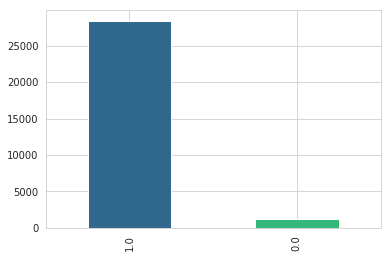

In [15]:
with sns.color_palette('viridis', n_colors=2):

    court_data.outcome.value_counts().plot.bar(); # no surprise

In [32]:
# filtered_df = court_data.dropna(subset=['judges_names']) # actually minus 541 of entries

In [34]:
# filtered_df['judges_names'] = filtered_df.judges_names.apply(ast.literal_eval)

# filtered_df.shape

(28866, 19)

In [35]:
# filtered_df = filtered_df[~filtered_df['sex'].isin(['[null]'])]

# filtered_df.shape

(28786, 19)

In [36]:
# filtered_df['bin_sex'] = filtered_df.apply(get_judge_sex, axis=1)

# filtered_df.dropna(subset=['bin_sex'], inplace=True)

In [17]:
# skipping the part with getting sex features, because we'll not need it further, but it drops a lot of values

filtered_df = court_data.copy()

In [18]:
def get_party_count(row, kind):
    if kind == 'claimant':
        return filtered_df.claimant.isin([row]).sum()
    
    elif kind == 'defendant':
        return filtered_df.defendant.isin([row]).sum()
    
    else:
        return filtered_df.claimant.isin([row]).sum() + filtered_df.defendant.isin([row]).sum()

In [19]:
filtered_df['claimant_as_claimant'] = filtered_df.claimant.apply(get_party_count, kind='claimant')
filtered_df['claimant_as_defendant'] = filtered_df.claimant.apply(get_party_count, kind='defendant')
filtered_df['claimant_overall'] = filtered_df.claimant.apply(get_party_count, kind='overall')

filtered_df['defendant_as_claimant'] = filtered_df.defendant.apply(get_party_count, kind='claimant')
filtered_df['defendant_as_defendant'] = filtered_df.defendant.apply(get_party_count, kind='defendant')
filtered_df['defendant_overall'] = filtered_df.defendant.apply(get_party_count, kind='overall')

In [40]:
filtered_df.to_csv('filtered_df_from_codes_v2.csv', index=False)

In [23]:
filtered_df.to_csv('filtered_df_from_codes_non_reduced_v2.csv', index=False)

In [25]:
data_full = pd.read_csv('most_recent/data_full.csv')

In [26]:
# getting codes by merging with larger dataframe that already have them

df_codes_dur = pd.merge(filtered_df, data_full[['id', 'dayofweek', 'duration_days']], how='inner')

In [27]:
filtered_with_capitals = pd.read_csv('most_recent/data_with_capitals.csv')

filtered_with_capitals.shape

(10448, 32)

In [30]:
filtered_with_capitals.drop(['claimant_split', 'defendant_split', 'n_claimants', 
                             'n_defendants', 'parties', 'name_y'], axis=1, inplace=True)
filtered_with_capitals.rename({'adjudication_date_x': 'adjudication_date'}, axis=1, inplace=True)

df_codes_dur.drop(['cleaned'], axis=1, inplace=True)

In [31]:
filtered_with_capitals.columns == df_codes_dur.columns

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True])

In [34]:
# let's combine our two datasets

capitals_d = filtered_with_capitals.append(df_codes_dur)

capitals_d.id.duplicated().sum() # intersection is 5447

5447

In [35]:
capitals_unique = capitals_d.drop_duplicates(subset=['id'])

capitals_unique.shape

(34453, 26)

In [37]:
# capitals_unique.to_csv('capitals_unique_v2.csv', index=False)
capitals_unique.to_csv('capitals_unique_non_reduced_v2.csv', index=False)

In [79]:
# judges_features = pd.read_csv('judges_features.csv', index_col='judges')

# da_capitals = pd.merge(capitals_unique, judges_features, left_on='judge', right_index=True).drop(['outcomeFull', 
#                       'judges_names', 'claimant', 'defendant', 'length'], axis=1)

In [38]:
da_capitals = capitals_unique.copy()

da_capitals.shape

(34453, 26)

## Trying out combined dataset with capitals for a modle

In [39]:
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, f1_score, make_scorer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import learning_curve

In [40]:
from train_functions import train_model

In [41]:
def f_importance_df(data, model):

    return pd.DataFrame([(f, val) for f, val in zip(data.columns[1:], model.feature_importances_.round(3))], 
             columns=['feature', 'importance']).sort_values('importance', ascending=False)

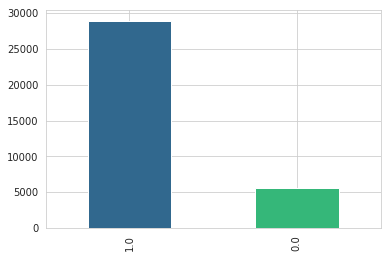

In [42]:
# and still we have unbalanced classes

with sns.color_palette('viridis', n_colors=2):

    da_capitals.outcome.value_counts().plot.bar();

In [43]:
columns_to_train = ['outcome', 'claimant_capital',
       'defendant_capital', 'claimant_as_claimant', 'claimant_as_defendant', 'claimant_overall',
       'defendant_as_claimant', 'defendant_as_defendant', 'defendant_overall',
       'dayofweek', 'duration_days']

In [44]:
# so we have very poor performance on negative class, especially for recall on our initial features

rfc = train_model(da_capitals[columns_to_train], 'rfc')

0.8686692787694094
              precision    recall  f1-score   support

         0.0       0.63      0.43      0.51      1103
         1.0       0.90      0.95      0.92      5788

   micro avg       0.87      0.87      0.87      6891
   macro avg       0.76      0.69      0.72      6891
weighted avg       0.86      0.87      0.86      6891



In [45]:
# let's add more features

da_capitals['judge_average_duration'] = da_capitals.groupby('judge')['duration_days'].transform('median')

da_capitals['judge_expected_outcome'] = da_capitals.groupby('judge')['outcome'].transform('mean')

In [46]:
columns_to_train = ['outcome', 'claimant_capital',
       'defendant_capital', 'claimant_as_claimant', 'claimant_as_defendant', 'claimant_overall',
       'defendant_as_claimant', 'defendant_as_defendant', 'defendant_overall',
       'dayofweek', 'duration_days'] + ['judge_average_duration','judge_expected_outcome']

In [47]:
# better, but still low on a negative class

rfc = train_model(da_capitals[columns_to_train], 'rfc')

0.9122043244812074
              precision    recall  f1-score   support

         0.0       0.78      0.63      0.70      1103
         1.0       0.93      0.97      0.95      5788

   micro avg       0.91      0.91      0.91      6891
   macro avg       0.86      0.80      0.82      6891
weighted avg       0.91      0.91      0.91      6891



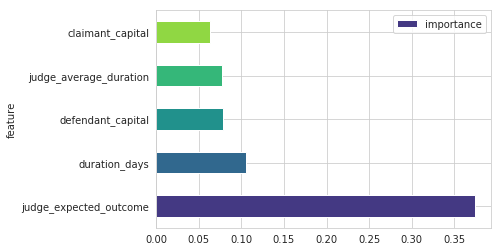

In [48]:
with sns.color_palette('viridis', n_colors=5):
    f_importance_df(da_capitals[columns_to_train], rfc)[:5].plot.barh('feature', 'importance');

In [49]:
# trying-out sensitive learning with weights parameter on SGD Classifier

from sklearn.linear_model import SGDClassifier


features_chosed = ['outcome', 'claimant_capital',
       'defendant_capital', 'claimant_overall', 'defendant_overall', 'duration_days'] + ['judge_average_duration',
                                                                                         'judge_expected_outcome']

sgd = SGDClassifier(max_iter=200, class_weight='balanced')

sgd = train_model(da_capitals[features_chosed], other=sgd)

/usr/local/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


0.877376287911769
              precision    recall  f1-score   support

         0.0       0.61      0.64      0.62      1103
         1.0       0.93      0.92      0.93      5788

   micro avg       0.88      0.88      0.88      6891
   macro avg       0.77      0.78      0.78      6891
weighted avg       0.88      0.88      0.88      6891



In [50]:
da_capitals.outcome.value_counts(normalize=True)

1.0    0.839898
0.0    0.160102
Name: outcome, dtype: float64

In [51]:
# getting recall higher

features_chosed = ['outcome', 'claimant_capital',
       'defendant_capital', 'claimant_overall', 'defendant_overall', 'duration_days'] + ['judge_average_duration',
                                                                                         'judge_expected_outcome']

sgd = SGDClassifier(max_iter=200, class_weight={0: 0.88, 1: 0.12})

sgd = train_model(da_capitals[features_chosed], other=sgd)

/usr/local/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


0.8736032506167465
              precision    recall  f1-score   support

         0.0       0.60      0.65      0.62      1103
         1.0       0.93      0.92      0.92      5788

   micro avg       0.87      0.87      0.87      6891
   macro avg       0.76      0.78      0.77      6891
weighted avg       0.88      0.87      0.88      6891



In [52]:
# actually we can do the same with SVM

svc = SVC(gamma='scale', class_weight={0: 0.79, 1: 0.21})

sgd = train_model(da_capitals[features_chosed], other=svc)

0.8811493252067915
              precision    recall  f1-score   support

         0.0       0.63      0.64      0.63      1103
         1.0       0.93      0.93      0.93      5788

   micro avg       0.88      0.88      0.88      6891
   macro avg       0.78      0.78      0.78      6891
weighted avg       0.88      0.88      0.88      6891



In [53]:
# downsampling to make balanced classes

print(data_full.outcome.mean())

n_neg_needed = round(1 - data_full.outcome.mean(), 2)

n_samples = int(da_capitals[da_capitals.outcome == 0].shape[0] / n_neg_needed - da_capitals[da_capitals.outcome == 0].shape[0])

neg = da_capitals[da_capitals.outcome == 0]

pos = da_capitals[da_capitals.outcome == 1].sample(n_samples)

balanced_capitals = pos.append(neg)

print(balanced_capitals.outcome.mean())
balanced_capitals.shape

0.5577147803505734
0.5599872367581366


(12536, 28)

In [54]:
# with balanced classes we see more accurate prediction, however still it seems that we are in overfit
# comparing to init model with a lot of data and not so high importance of capitals it's not so clear
# why we've got so high score

features_chosed = ['outcome', 'claimant_capital', 'defendant_capital', 'claimant_overall', 'defendant_overall',
                  'duration_days', 'judge_average_duration', 'judge_expected_outcome']


# and actually performance is lower than for our initial dataset with capitals, especially on negative class recall
rfc = train_model(balanced_capitals[features_chosed], 'rfc')

0.8365231259968102
              precision    recall  f1-score   support

         0.0       0.83      0.79      0.81      1105
         1.0       0.84      0.88      0.86      1403

   micro avg       0.84      0.84      0.84      2508
   macro avg       0.84      0.83      0.83      2508
weighted avg       0.84      0.84      0.84      2508



In [55]:
# dropping less than 15 and we've got on 2k more samples than in our initial dataset with capitals

grouped = balanced_capitals.groupby('judge').size()

more_15 = grouped[grouped > 15].index.tolist()

df_15 = balanced_capitals[balanced_capitals.judge.isin(more_15)]

df_15.shape

(10081, 28)

In [56]:
# and we have almost the same performance as for our first dataset (without codes)

rfc = train_model(balanced_capitals[features_chosed], 'rfc')

0.8365231259968102
              precision    recall  f1-score   support

         0.0       0.83      0.79      0.81      1105
         1.0       0.84      0.88      0.86      1403

   micro avg       0.84      0.84      0.84      2508
   macro avg       0.84      0.83      0.83      2508
weighted avg       0.84      0.84      0.84      2508



In [58]:
judges_features = pd.read_csv('judges_features.csv')

In [60]:
capitals_dec = pd.merge(balanced_capitals, judges_features, left_on='judge', right_on='judges')